In [1]:
import warnings

import pandas as pd
# from pandas.api.types import CategoricalDtype
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
import re

from tqdm import tqdm

from uszipcode import SearchEngine

'''
sklearn.externals.joblib will be deprecated
'''
from joblib import dump, load

from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

from sklearn.decomposition import FactorAnalysis, PCA

from sklearn.cluster import KMeans

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, mean_squared_error

from bayes_opt import BayesianOptimization

from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor, XGBClassifier

from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.naive_bayes import ComplementNB

# from eli5.sklearn import PermutationImportance
# from sklearn.feature_selection import SelectFromModel

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [3]:
train_targets = train.price
merged_features = pd.concat([train.drop('price', axis=1), test], axis=0)

In [4]:
merged_features.reset_index(drop=True, inplace=True)

## **■ FE**

- dt.date(2019, 4, 12).weekday()
- ex) 4 : Friday

In [5]:
def make_date_derived_features():
    merged_features['year'] = merged_features.date.apply(lambda value : int(value[:4]))
    merged_features['month'] = merged_features.date.apply(lambda value : int(value[4:6]))
    merged_features['day'] = merged_features.date.apply(lambda value : int(value[6:8]))
    merged_features['weekday'] = merged_features.date.apply(lambda value : dt.date(int(value[:4]), int(value[4:6]), int(value[6:8])).weekday())
    merged_features.drop('date', axis=1, inplace=True)

In [6]:
def make_zip_derived_features():
    major_city_list = []
    
    for _, features in tqdm(merged_features.iterrows(), total=merged_features.shape[0]):
        zipcode = features[merged_features.columns.get_loc('zipcode')]        
        find_result = search_engine.by_zipcode(int(zipcode))
        
        # 'county' and 'state' is all the same(county:King County, state:WA) at whole data.
        # and 'major_city' is same as 'post_office_city'(replace ', WA' with '').
        # so only use 'major_city'.
        
        '''
        merged_features.post_office_city = merged_features.post_office_city.apply(lambda word : word.replace(', WA', ''))
        for _, values in merged_features.iterrows():
            if values[merged_features.columns.get_loc('major_city')] != values[merged_features.columns.get_loc('post_office_city')]:
                print(False)
        '''
        
        major_city_list.append(find_result.major_city)
    
    merged_features['major_city'] = major_city_list

In [7]:
def make_sqft_derived_features():
    merged_features.loc[merged_features.sqft_living == merged_features.sqft_living15, 'living_renovate'] = 0
    merged_features.loc[merged_features.sqft_living != merged_features.sqft_living15, 'living_renovate'] = 1
    merged_features.living_renovate = merged_features.living_renovate.astype(int)

    merged_features.loc[merged_features.sqft_lot == merged_features.sqft_lot15, 'lot_renovate'] = 0
    merged_features.loc[merged_features.sqft_lot != merged_features.sqft_lot15, 'lot_renovate'] = 1
    merged_features.lot_renovate = merged_features.lot_renovate.astype(int)

    merged_features.loc[merged_features.sqft_basement==0, 'basement'] = 0
    merged_features.loc[merged_features.sqft_basement!=0, 'basement'] = 1
    merged_features.basement = merged_features.basement.astype(int)

In [8]:
%time make_date_derived_features()

Wall time: 104 ms


In [9]:
search_engine = SearchEngine()
%time make_zip_derived_features()
# about 35~42ss
del search_engine

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21503/21503 [00:38<00:00, 556.50it/s]


Wall time: 38.6 s


In [10]:
%time make_sqft_derived_features()

Wall time: 35.9 ms


In [11]:
merged_features = merged_features[[
    'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15',
    'year', 'month', 'day', 'weekday', 'yr_built', 'yr_renovated', 'view', 'condition', 'grade',
    'waterfront', 'living_renovate', 'lot_renovate', 'basement', 'floors', 'bedrooms', 'bathrooms', 'major_city'
]]

In [12]:
merged_features.floors = merged_features.floors.apply('{:,.1f}'.format)
merged_features.floors = merged_features.floors.astype(float)
merged_features.bathrooms = merged_features.bathrooms.apply('{:,.2f}'.format)
merged_features.bathrooms = merged_features.bathrooms.astype(float)

In [13]:
merged_features.head()

sqft_living  sqft_lot  sqft_above  sqft_basement  sqft_living15  \
0         1180      5650        1180              0           1340   
1          770     10000         770              0           2720   
2         1680      8080        1680              0           1800   
3         1715      6819        1715              0           2238   
4         1060      9711        1060              0           1650   

   sqft_lot15  year  month  day  weekday  ...  condition  grade  waterfront  \
0        5650  2014     10   13        0  ...          3      7           0   
1        8062  2015      2   25        2  ...          3      6           0   
2        7503  2015      2   18        2  ...          3      8           0   
3        6819  2014      6   27        4  ...          3      7           0   
4        9711  2015      1   15        3  ...          3      7           0   

   living_renovate  lot_renovate  basement  floors  bedrooms  bathrooms  \
0                1             0         0     1.0         3       1.00   
1                1             1         0     1.0         2       1.00   
2                1             1         0     1.0         3       2.00   
3                1             0         0     2.0         3       2.25   
4                1             0         0     1.0         3       1.50   

    major_city  
0      Seattle  
1      Kenmore  
2    Sammamish  
3  Federal Way  
4      Seattle  

[5 rows x 23 columns]

## **■ EDA**

- **basic features**

Variable | Definition
-------- | ----------
ID|집을 구분하는 번호
date|집을 구매한 날짜
price|집의 가격(Target variable)
bedrooms|침실의 수
bathrooms|화장실의 수
floors|집의 층 수
waterfront|집 전방에 강이 흐르는지 유무(river view)
view|집이 얼마나 좋아 보이는지의 정도
condition|집의 전반적인 상태
grade|King County grading 시스템 기준으로 매긴 집의 등급
yr_built|지어진 년도
yr_renovated|집을 재건축한 년도
zipcode|우편번호
lat|위도
long|경도
sqft_living|주거 공간의 평방 피트(면적)
sqft_lot|부지의 평방 피트(면적)
sqft_above|지하실을 제외한 평방 피트(면적)
sqft_basement|지하실의 평방 피트(면적)
sqft_living15|2015년 기준 주거 공간의 평방 피트(면적 / 집을 재건축했다면 변화가 있을 수 있음)
sqft_lot15|2015년 기준 부지의 평방 피트(면적 / 집을 재건축했다면 변화가 있을 수 있음)

In [14]:
def continuous_continuous(df_, var1_name_, var2_name_):
    var1 = df_[var1_name_].values
    var2 = df_[var2_name_].values
    
    _, p_value1 = stats.shapiro(var1)
    _, p_value2 = stats.shapiro(var2)
    
    normality1 = True if p_value1 > .05 else False
    normality2 = True if p_value2 > .05 else False
    
    if normality1 and normality2:
        r_value, p_value = stats.pearsonr(var1, var2)
        return r_value, p_value
    else:
        r_value, p_value = stats.spearmanr(var1, var2)
        return r_value, p_value

def continuous_binary(df_, continous_var_name_, binary_var_name_):
    norm_equal_var_result, grouped_arr = \
                        continuous_categorical_norm_equal_var(df_, continous_var_name_, binary_var_name_)
    
    if norm_equal_var_result:
        t_value, p_value = stats.ttest_ind(grouped_arr[0], grouped_arr[1])
        return t_value, p_value
    else:
        t_value, p_value = stats.ttest_ind(grouped_arr[0], grouped_arr[1], equal_var=False)
        return t_value, p_value

def continuous_multi(df_, continous_var_name_, multi_var_name_):
    norm_equal_var_result, grouped_arr = \
                        continuous_categorical_norm_equal_var(df_, continous_var_name_, multi_var_name_)
    
    if norm_equal_var_result:
        f_value, p_value = stats.f_oneway(*grouped_arr)
        return f_value, p_value
    else:
        h_value, p_value = stats.kruskal(*grouped_arr)
        return h_value, p_value

def categorical_categorical(df_, var1_name_, var2_name_):
    vars_count_df = pd.DataFrame({var1_name_:df_[var1_name_], var2_name_:df_[var2_name_],
                                    'no':[0 for _ in range(len(df_))]})
    pivot = vars_count_df.pivot_table(index=var1_name_, columns=var2_name_, values='no', aggfunc='count')
    pivot = pivot.fillna(0)
    chi2, p_value, _, _ = stats.chi2_contingency(pivot.values)
    
    return chi2, p_value
    
# -----------------------------------------------------------------------------------------------------------------

def normality_continuous_categorical(grouped_):
    normality_list = []
    for group in grouped_:
# ====== exception handling - # of group less than 3 ==========
        try:
            _, p_value = stats.shapiro(group)
        except:
            continue
# =============================================================
        normality = True if p_value > .05 else False
        normality_list.append(normality)
    
    return True if False not in normality_list else False

def equal_variance_continuous_categorical(grouped_, normality_result_):
    if normality_result_:
        _, p_value = stats.bartlett(*grouped_)
    else:
        _, p_value = stats.levene(*grouped_)
    
    return True if p_value > .05 else False

def continuous_categorical_norm_equal_var(data_, continous_name_, cat_name_):
    cat_values = np.array(data_[cat_name_].value_counts().index)
    grouped_list = []
    for value in cat_values:
        grouped = data_[data_[cat_name_]==value].values[:, data_.columns.get_loc(continous_name_)]
        grouped_list.append(grouped)
    
    normality_result = normality_continuous_categorical(grouped_list)
    equal_variance_result = equal_variance_continuous_categorical(grouped_list, normality_result)
    
    return (True, grouped_list) if normality_result and equal_variance_result else (False, grouped_list)

In [15]:
def two_variables_analysis(data_, nan_zero_cols_, nan_zero_cols_continuous_, nan_zero_cols_binary_, y_type_, y_name_):
    
    if (y_type_ != 'continuous') and (y_type_ != 'binary') and (y_type_ != 'multi'):
        raise TypeError("'y_type_' parameter must be 'continuous' or 'binary' or 'multi'.")
    
    result_dic = {'continuous_continuous':[], 'continuous_binary':[], 'continuous_multi':[],
                 'categorical_categorical':[]}
    
    for col in nan_zero_cols_:
        if col in nan_zero_cols_continuous_:
            if y_type_ == 'continuous':
                r_value, p_value = continuous_continuous(data_, col, y_name_)
                info = (col, r_value, p_value)
                result_dic['continuous_continuous'].append(info)
                
            elif y_type_ == 'binary':
                t_value, p_value = continuous_binary(data_, col, y_name_)
                info = (col, t_value, p_value)
                result_dic['continuous_binary'].append(info)
                
            else:
                stat, p_value = continuous_multi(data_, col, y_name_)
                info = (col, stat, p_value)
                result_dic['continuous_multi'].append(info)
                
        elif col in nan_zero_cols_binary_:
            if y_type_ == 'continuous':
                t_value, p_value = continuous_binary(data_, y_name_, col)
                info = (col, t_value, p_value)
                result_dic['continuous_binary'].append(info)
            
            elif y_type_ == 'binary':
                chi2, p_value = categorical_categorical(data_, y_name_, col)
                info = (col, chi2, p_value)
                result_dic['categorical_categorical'].append(info)
                
            else:
                chi2, p_value = categorical_categorical(data_, y_name_, col)
                info = (col, chi2, p_value)
                result_dic['categorical_categorical'].append(info)
                
        else:
            if y_type_ == 'continuous':
                stat, p_value = continuous_multi(data_, y_name_, col)
                info = (col, stat, p_value)
                result_dic['continuous_multi'].append(info)
                
            elif y_type_ == 'binary':
                chi2, p_value = categorical_categorical(data_, y_name_, col)
                info = (col, chi2, p_value)
                result_dic['categorical_categorical'].append(info)
                
            else:
                chi2, p_value = categorical_categorical(data_, y_name_, col)
                info = (col, chi2, p_value)
                result_dic['categorical_categorical'].append(info)
    
    return result_dic

In [16]:
def var_relation_show(result_dic_, verbose_=True):
    
    if type(verbose_) != bool:
        raise TypeError("'verbose_' must be a bool type.")
#         print("'verbose_' must be a bool type. return None now.")
#         return None
    
    if verbose_:
        for key in result_dic_:
            if len(result_dic_[key]) == 0:
                continue
                
            print('■ ', key, '\n')
            for ele in result_dic_[key]:
                print('---- ', ele[0])
                print('   => test_statistics : {:.4f} / p_value : {:.4f}'.format(ele[1], ele[2]))
                print('     ------------------------------------------')
            print('\n======================================================\n')
    
    valid_variables = []
    for key in result_dic_:
        for col_name, _, p_value in result_dic_[key]:
            if p_value < .05:
                valid_variables.append(col_name)
    
    return valid_variables

In [17]:
def plot_corr(data, columns, width, height, font_size, cmap):
    
    plt.figure(figsize=(width, height))
    sns.set(font_scale=font_size)
    sns.heatmap(data, xticklabels=columns, yticklabels=columns, annot=True, cmap=cmap)

In [18]:
def plot_multi_boxplot(df, cols, plot_no, width, height, gap):
    
    plt.figure(figsize=(width, height))
    plt.subplots_adjust(wspace=gap)
    for col in cols:
        ax = plt.subplot(plot_no)
        _ = sns.boxplot(y=df[col], ax=ax)
        plot_no += 1

In [19]:
def plot_multi_barplots(data, cols, plot_rows, plot_cols, width, height, font_scale, rotation, color):
    
    plt.figure(figsize=(width, height))
    
    for cur_no, city in zip(range(plot_rows), cols):
        sns.set(font_scale=font_scale)
        ax = plt.subplot(plot_rows, plot_cols, cur_no+1)
        ax.set_title(city)
        
#         _, labels = plt.xticks()
#         plt.setp(labels, rotation=rotation)
        
#         plt.xticks(rotation=rotation)
        ax.tick_params(rotation=rotation)
        
        sns.barplot(x=data[city].index, y=data[city].values, ax=ax, color=color)
        
        ax.yaxis.set_label_text('')
        ax.xaxis.set_label_text('')

In [20]:
def plot_stacked_barplots(df, plot_col_name, plot_col_names, x_col_name, y_col_name, plot_rows, plot_cols, width, height, rotation):
    
    plt.figure(figsize=(width, height))
    color_list = ['#f6f931', '#42e5f7', '#5c7cf2', '#74f943', '#cf48f9', '#f97748']
    
    for cur_no, city in zip(range(plot_rows), plot_col_names):
        # major_city
        data = df[df[plot_col_name]==city]
        
        # floor
        data = pd.get_dummies(data=data, columns=[y_col_name])
        # year
        years = sorted(data[x_col_name].unique())
        floors = data.columns[22:]
        
        floor_over_time = []
        # calculate number of corresponding floor by year.
        for floor in floors:
            floor_sum = data.groupby(['yr_built'])[floor].agg('sum')
            floor_over_time.append(floor_sum.tolist())

        floor_sum_over_time = []
        # calculate cumulative number by floor.
        for idx in range(len(floors)):
            floor_sum_over_time.append(np.array(floor_over_time[idx:]).sum(axis=0))

        # calculate percent of each floor by year.
        floor_sum_percent = (floor_sum_over_time / (1.*np.array(floor_sum_over_time).max(axis=0)))*100        
        
        ax = plt.subplot(plot_rows, plot_cols, cur_no+1)
        ax.set_title(city)
        
        for idx in range(len(floors)):
            sns.barplot(x=years, y=floor_sum_percent[idx], color=color_list[idx%len(color_list)], alpha=.7, ax=ax)
        
        ax.tick_params(rotation=rotation)
        
        _ = ax.legend([plt.Rectangle((0, 0), 1, 1, fc=color_list[idx%len(color_list)], edgecolor='none')
                   for idx in range(len(floors))], floors, loc='best')
        
        ax.yaxis.set_label_text('')
        ax.xaxis.set_label_text('')

In [21]:
def plot_multi_scatterplot(data, independents, dependent, wspace, hspace, width=30, col_no=2):
    
    plot_no = len(independents)
    row_no = plot_no // col_no + 1 if plot_no % col_no != 0 else plot_no // col_no
    cur_no = 1
    
    height = (10+hspace)*row_no
    
    plt.figure(figsize=(width, height))
    plt.subplots_adjust(wspace=wspace, hspace=hspace)
    
    for x in independents:
        
        ax = plt.subplot(row_no, col_no, cur_no)
        sns.scatterplot(x=x, y=dependent, data=data, ax=ax)
        cur_no += 1

In [22]:
def plot_multi_histograms(data, start_col, end_col, gap):
    
    start_index = data.columns.get_loc(start_col)
    
    end_index = data.columns.get_loc(end_col)
    no_cols = end_index+1
    
    plt.figure(figsize=(30, 4*no_cols))
    plt.subplots_adjust(hspace=gap)
#     plt.ylim(0, 10)
#     plt.yticks([.1, .2, .3, .4, .5, .6, .7, .8, .9])
    plot_no = 1
    
    for col in data.columns[start_index:no_cols]:
        
        ax = plt.subplot(no_cols, 1, plot_no)
        plot_no += 1

#         ax.set_title(col)
        sns.distplot(data[col], hist=True, kde=True, ax=ax)
    
    return no_cols

In [23]:
print('train set size : ', len(train), ' / test set size : ', len(test))
print('# of columns : ', len(merged_features.columns))

train set size :  15035  / test set size :  6468
# of columns :  23


In [24]:
merged_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21503 entries, 0 to 21502
Data columns (total 23 columns):
sqft_living        21503 non-null int64
sqft_lot           21503 non-null int64
sqft_above         21503 non-null int64
sqft_basement      21503 non-null int64
sqft_living15      21503 non-null int64
sqft_lot15         21503 non-null int64
year               21503 non-null int64
month              21503 non-null int64
day                21503 non-null int64
weekday            21503 non-null int64
yr_built           21503 non-null int64
yr_renovated       21503 non-null int64
view               21503 non-null int64
condition          21503 non-null int64
grade              21503 non-null int64
waterfront         21503 non-null int64
living_renovate    21503 non-null int32
lot_renovate       21503 non-null int32
basement           21503 non-null int32
floors             21503 non-null float64
bedrooms           21503 non-null int64
bathrooms          21503 non-null float64
major_c

In [25]:
# merged_features.floors = merged_features.floors.round(1)
# merged_features.bathrooms = merged_features.bathrooms.round(2)

In [26]:
merged_features.isna().sum()

sqft_living        0
sqft_lot           0
sqft_above         0
sqft_basement      0
sqft_living15      0
sqft_lot15         0
year               0
month              0
day                0
weekday            0
yr_built           0
yr_renovated       0
view               0
condition          0
grade              0
waterfront         0
living_renovate    0
lot_renovate       0
basement           0
floors             0
bedrooms           0
bathrooms          0
major_city         0
dtype: int64

In [27]:
for feature in merged_features.columns:
    print("------ Feature '{}'".format(feature))
    print('-- # of rows : ', len(merged_features[feature]))
    print('-- # of unique : ', len(merged_features[feature].unique()))
    print(merged_features[feature].unique())
    print()
    print('======================================================================================')
    print()

------ Feature 'sqft_living'
-- # of rows :  21503
-- # of unique :  1038
[1180  770 1680 ... 1496 7270 3118]


------ Feature 'sqft_lot'
-- # of rows :  21503
-- # of unique :  9782
[ 5650 10000  8080 ... 11968  1126  2388]


------ Feature 'sqft_above'
-- # of rows :  21503
-- # of unique :  946
[1180  770 1680 1715 1060 1860  860 1430 1370 1810 1980 1890 1600 1200
 1250 2330 1070 2450 1710 1750 1400 2320 1510 1090 1280 2360  890 2620
 2600 3595 1570  990 2290 1000 2830 2250 2420 3250 1590 1260 1540 1110
 2720 2240 3070 2390  910 3450 2350 1900  960 2660  765 3520 1290 1960
 1160 1270 2190 1210 1240 3140 2310  700 1080 2520 2780  880 1560 1720
 1620 1360 1440 2140 1320 1010 1340 1190 1170  940 3670 3540 2500 1760
 1030 1780 3400 2680 1610 1670 2570 2590  820 1220 2440 1050 2090 1100
 1420 1690 1130 1910 1350 1940  900 1630 1550 2714 1870 1950 2020 1120
  980 1480 1230 2280 3760 1640 3530  830 1300  790 2740 1830  720 2010
 3360 2460 1460 1700 4750 5310  580 2653 2850 2630 3500 1740 1

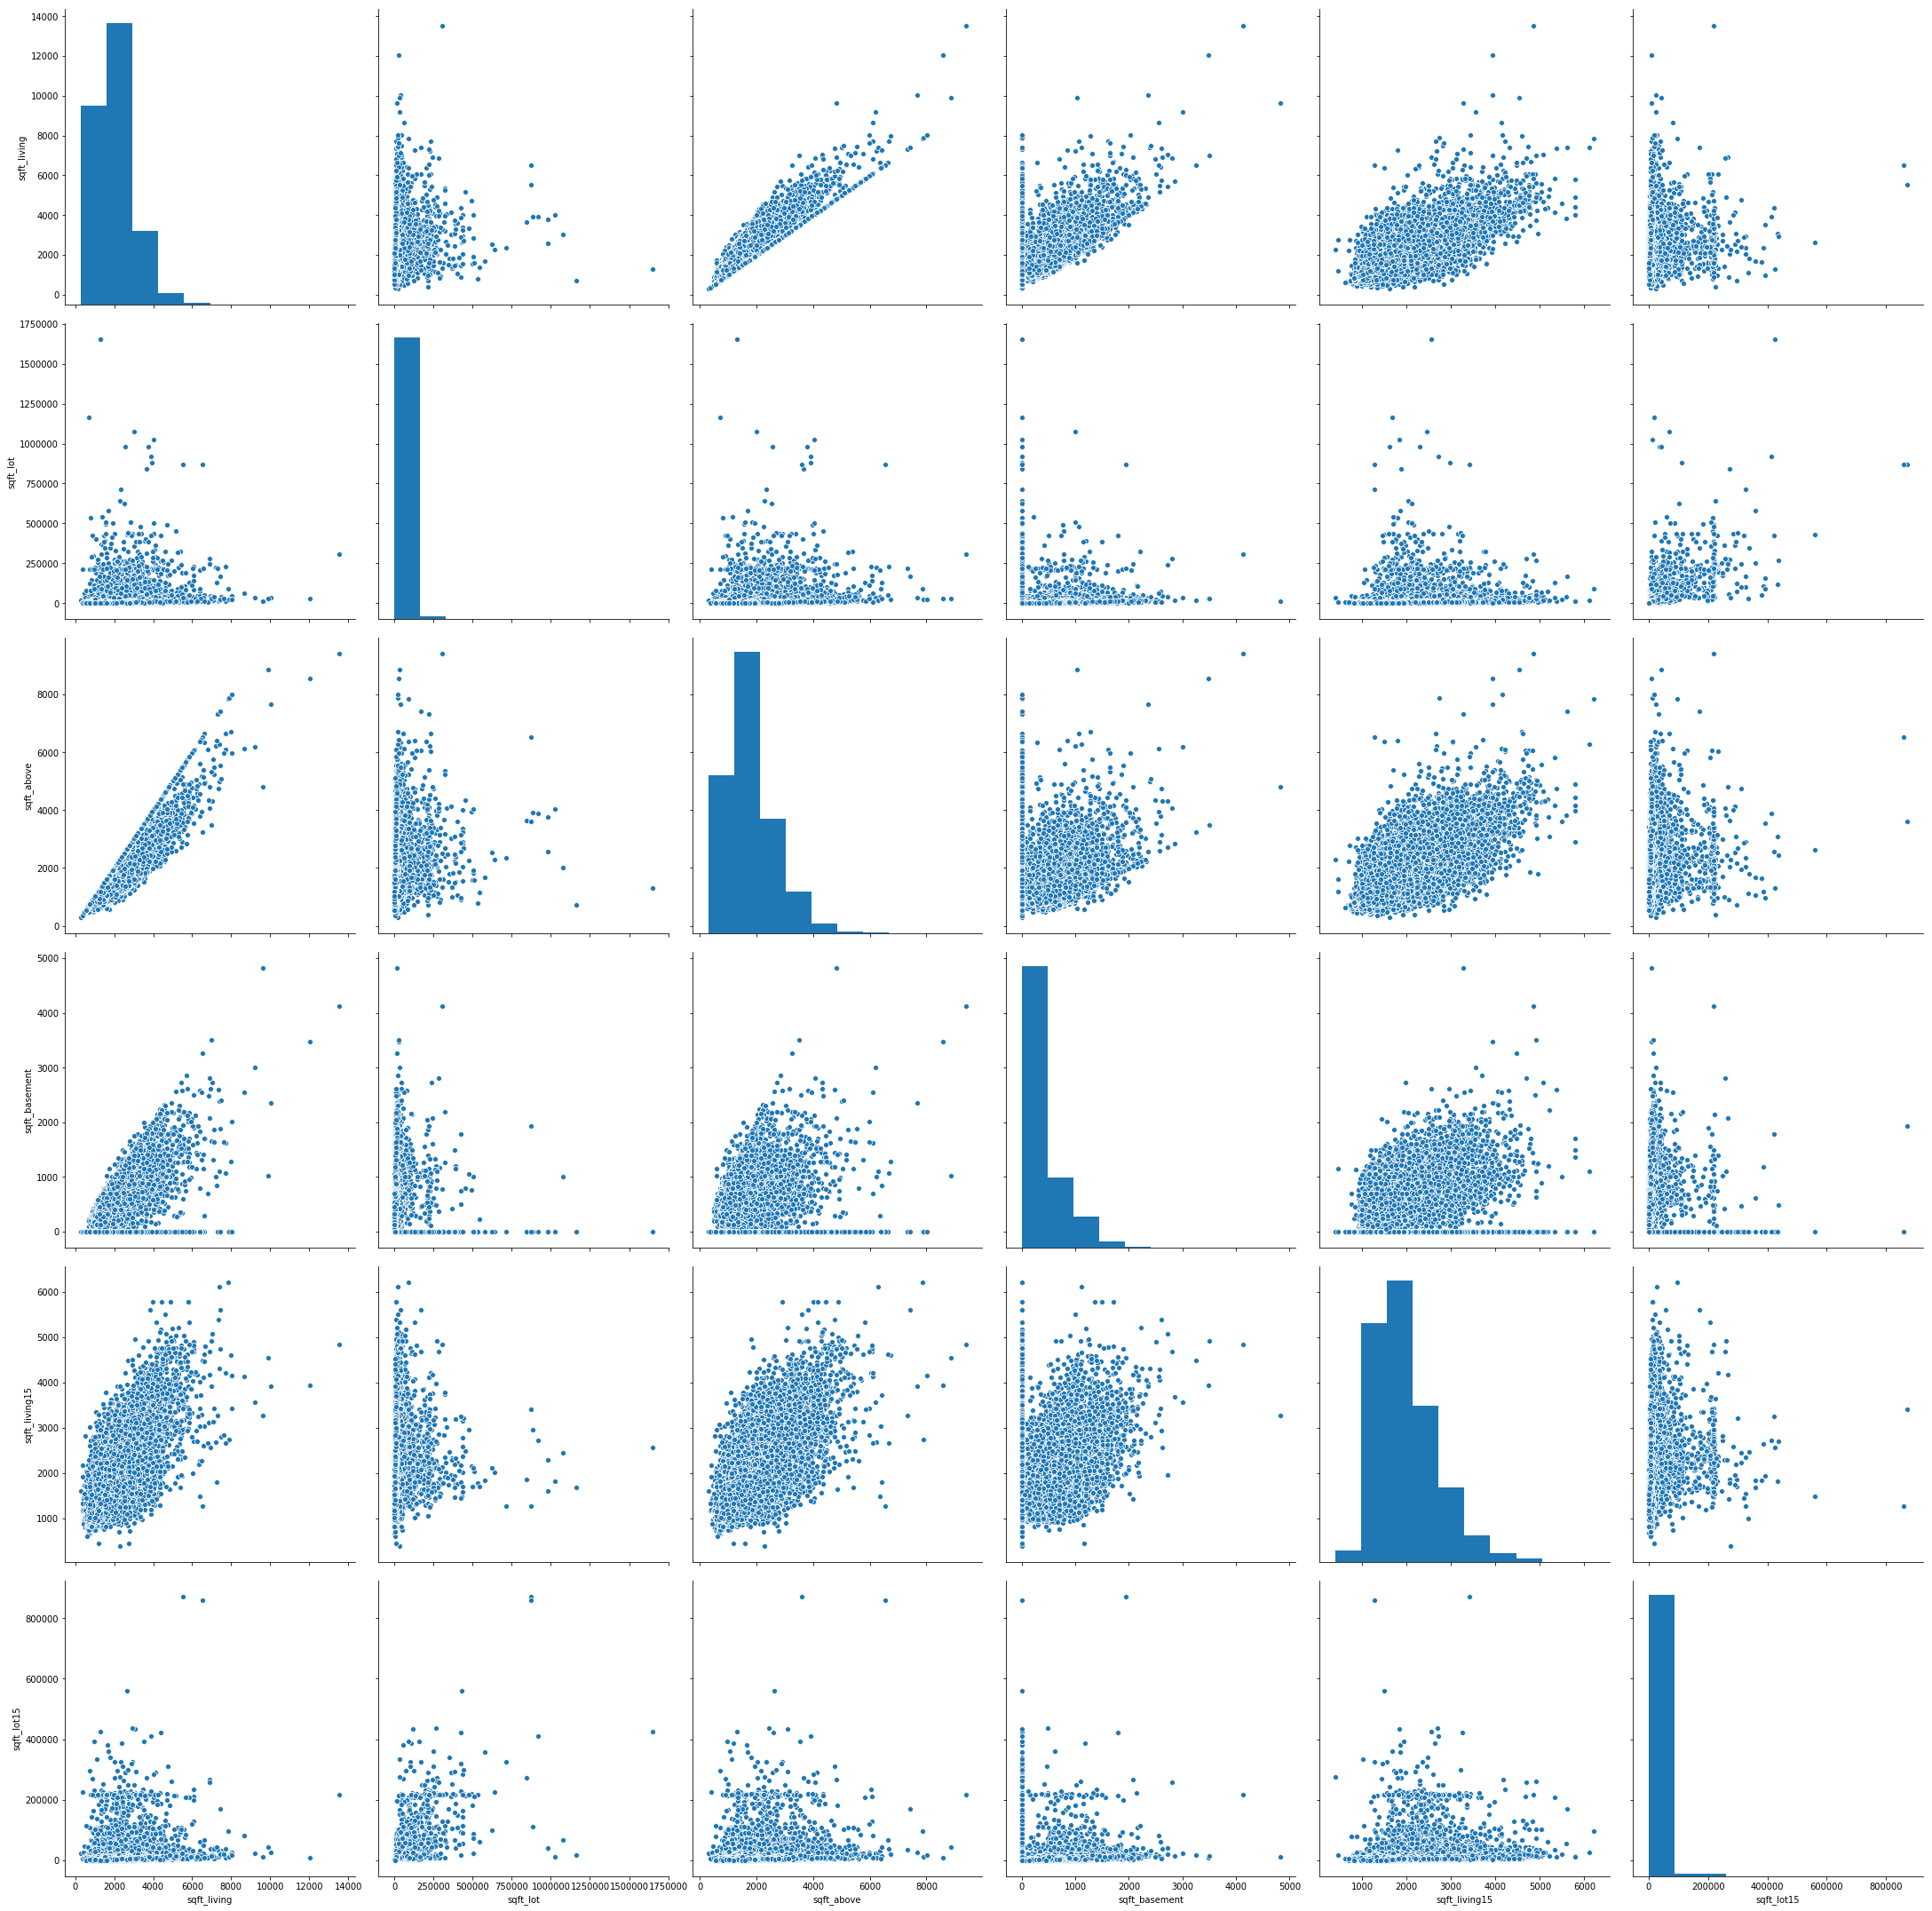

In [28]:
merged_features_sqft = merged_features[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']]

start = dt.datetime.now()
_ = sns.pairplot(merged_features_sqft, height=5, aspect=1)

In [29]:
end = dt.datetime.now()
print(end-start)

0:00:17.498610


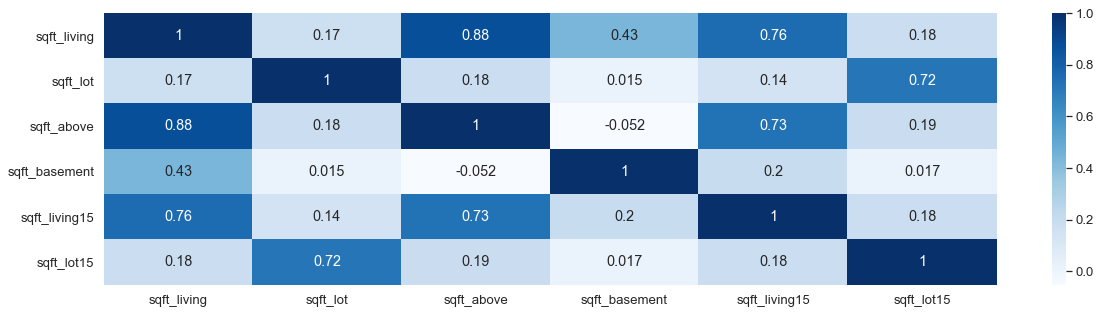

In [30]:
corr_sqft_features = merged_features_sqft.corr()
# 'YlGnBu'
plot_corr(corr_sqft_features, merged_features_sqft.columns, 20, 5, 1.2, 'Blues')

### **→ sqft 변수들 간 상관 관계**
sqft_feature | high correlated features
-------- | ----------
sqft_living | sqft_above, sqft_living15
sqft_lot | sqft_lot15
sqft_living15 | sqft_above, sqft_living

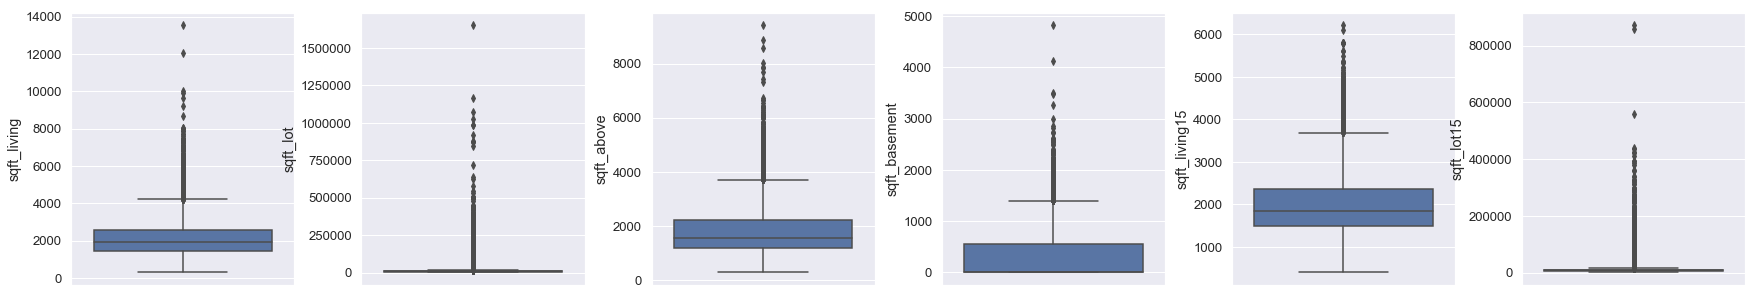

In [31]:
plot_multi_boxplot(merged_features_sqft, merged_features_sqft.columns, 161, 30, 5, .3)

In [32]:
pd.options.display.float_format = '{:.5f}'.format

In [33]:
merged_features_sqft.describe()

sqft_living      sqft_lot  sqft_above  sqft_basement  sqft_living15  \
count  21503.00000   21503.00000 21503.00000    21503.00000    21503.00000   
mean    2081.44133   15117.14803  1789.76599      291.67535     1987.24266   
std      918.66962   41475.91338   828.48166      442.64588      685.57948   
min      290.00000     520.00000   290.00000        0.00000      399.00000   
25%     1430.00000    5040.00000  1200.00000        0.00000     1490.00000   
50%     1914.00000    7616.00000  1560.00000        0.00000     1840.00000   
75%     2550.00000   10686.00000  2210.00000      560.00000     2370.00000   
max    13540.00000 1651359.00000  9410.00000     4820.00000     6210.00000   

        sqft_lot15  
count  21503.00000  
mean   12774.52909  
std    27334.99591  
min      651.00000  
25%     5100.00000  
50%     7620.00000  
75%    10085.00000  
max   871200.00000

In [34]:
pd.options.display.float_format = None

In [35]:
merged_features[merged_features.sqft_lot==1651359][merged_features_sqft.columns]

sqft_living  sqft_lot  sqft_above  sqft_basement  sqft_living15  \
1231         1300   1651359        1300              0           2560   

      sqft_lot15  
1231      425581

### **→ 큰 부지에 집만 작게 지을 수도 있으므로 이상치라고 보기는 어려울 듯**

In [36]:
vifs = pd.DataFrame()
vifs['VIF Factor'] = [variance_inflation_factor(merged_features_sqft.values, i)
                     for i in range(merged_features_sqft.shape[1])]
vifs['feature'] = merged_features_sqft.columns
vif_pivot = vifs.pivot_table(values='VIF Factor', columns='feature')

c:\users\kdw_msi\anaconda3\envs\py36\lib\site-packages\statsmodels\stats\outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [37]:
vif_pivot

feature     sqft_above  sqft_basement  sqft_living  sqft_living15  sqft_lot  \
VIF Factor         inf            inf          inf      15.444154  2.353686   

feature     sqft_lot15  
VIF Factor    2.549829

In [38]:
del vifs, vif_pivot, merged_features_sqft, corr_sqft_features

### **→ 최종 결과에서 개선 필요할 경우 다중공선성과 vif 활용해보기**
### **→ model importance도 측정해서, 다중공선성과 model importance에서 공통적으로 필요 없는 것으로 판단되는 feature 빼기**

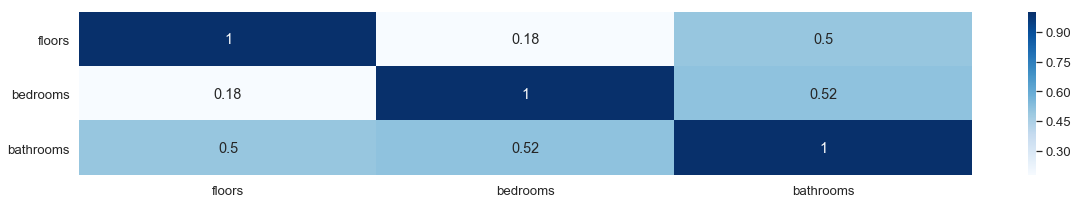

In [39]:
merged_features_floor_bedroom_bathroom = merged_features[['floors', 'bedrooms', 'bathrooms']]
corr_floor_bedroom_bathroom = merged_features_floor_bedroom_bathroom.corr()

plot_corr(corr_floor_bedroom_bathroom, merged_features_floor_bedroom_bathroom.columns, 20, 3, 1.2, 'Blues')

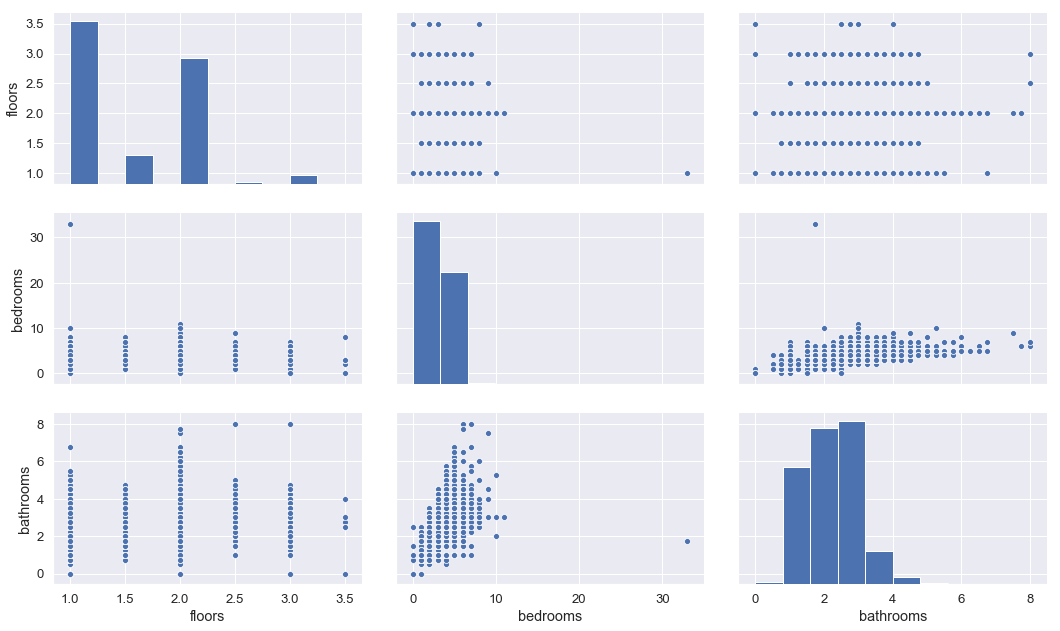

In [40]:
'''
height : height of each facets
height*aspect : width of each facets
''' 
_ = sns.pairplot(merged_features_floor_bedroom_bathroom, height=3, aspect=5/3)

In [41]:
del merged_features_floor_bedroom_bathroom, corr_floor_bedroom_bathroom

In [42]:
merged_features[(merged_features.floors==1)&(merged_features.bedrooms>30)]

sqft_living  sqft_lot  sqft_above  sqft_basement  sqft_living15  \
19745         1620      6000        1040            580           1330   

       sqft_lot15  year  month  day  weekday  ...  condition  grade  \
19745        4700  2014      6   25        2  ...          5      7   

       waterfront  living_renovate  lot_renovate  basement  floors  bedrooms  \
19745           0                1             1         1     1.0        33   

       bathrooms  major_city  
19745       1.75     Seattle  

[1 rows x 23 columns]

In [43]:
len(merged_features)

21503

In [44]:
merged_features_test = merged_features[len(train):]
merged_features_test.reset_index(drop=True, inplace=True)
print(merged_features_test[(merged_features_test.floors==1)&(merged_features_test.bedrooms>30)].index)
del merged_features_test

Int64Index([4710], dtype='int64')


In [45]:
merged_features_train = pd.concat([merged_features[:len(train)], train_targets], axis=1)

In [46]:
merged_features_train[merged_features_train.major_city=='Seattle'].describe(), len(merged_features_train[merged_features_train.major_city=='Seattle'])

(        sqft_living       sqft_lot   sqft_above  sqft_basement  sqft_living15  \
 count   6269.000000    6269.000000  6269.000000    6269.000000    6269.000000   
 mean    1792.644919    6490.016430  1445.315840     347.329080    1687.832509   
 std      800.526327    5479.890249   615.872571     425.375331     506.640911   
 min      380.000000     520.000000   380.000000       0.000000     460.000000   
 25%     1240.000000    3960.000000  1030.000000       0.000000    1340.000000   
 50%     1630.000000    5600.000000  1300.000000     140.000000    1580.000000   
 75%     2190.000000    7875.000000  1680.000000     670.000000    1920.000000   
 max    12050.000000  137214.000000  8570.000000    3480.000000    4510.000000   
 
           sqft_lot15         year        month          day      weekday  ...  \
 count    6269.000000  6269.000000  6269.000000  6269.000000  6269.000000  ...   
 mean     6236.396874  2014.315202     6.613176    15.633115     2.014037  ...   
 std      4565

In [47]:
5.349011e+05

534901.1

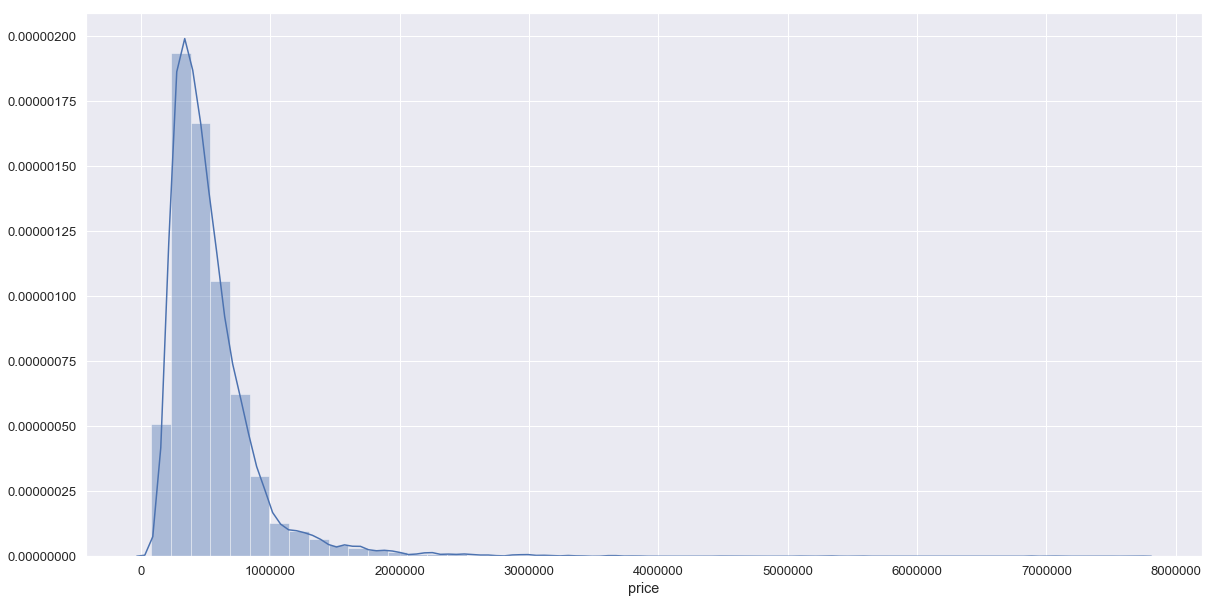

In [48]:
plt.figure(figsize=(20, 10))
_ = sns.distplot(merged_features_train.price, hist=True, kde=True)

In [49]:
del merged_features_train

### **→ bedrooms 33인 id의 price 예측값을 Seattle 지역 price 평균값으로 변경**

In [50]:
merged_features[merged_features.basement==1].floors.unique()

array([1. , 2. , 1.5, 2.5, 3. , 3.5])

### **→ floor의 .5는 지하실은 아닌 듯**
### **→ 검색 결과와 함께 생각해 보면 다락방이거나, 원룸 같은 곳에 계단 타고 올라가면 있는 천장까지의 높이가 낮은 그 공간 의미하는 듯**
## **→ .5인 것들 binary feature로 추가해보자**

In [51]:
merged_features[merged_features.bathrooms==8][['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
                                              'sqft_living15', 'sqft_lot15', 'floors', 'bedrooms']]

sqft_living  sqft_lot  sqft_above  sqft_basement  sqft_living15  \
5108        12050     27600        8570           3480           3940   
8912        13540    307752        9410           4130           4850   

      sqft_lot15  floors  bedrooms  
5108        8800     2.5         6  
8912      217800     3.0         7

### **→ 이상 없을 듯**

In [52]:
merged_features[merged_features.bedrooms==0][['living_renovate', 'lot_renovate', 'floors', 'bathrooms',
                                              'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
                                              'sqft_living15', 'sqft_lot15']]

living_renovate  lot_renovate  floors  bathrooms  sqft_living  \
6885                 1             1     2.0       0.00         1470   
8826                 1             1     2.0       2.50         1490   
12781                1             1     1.0       0.75          384   
13522                1             1     1.0       0.00          290   
15265                1             1     3.5       0.00         3064   
15911                0             1     3.0       0.00         1470   
16012                0             0     3.0       1.50         1430   
16418                1             1     1.0       1.00          390   
17064                1             1     2.0       0.00         4810   
17524                1             1     2.0       2.50         2290   
17526                0             1     2.0       2.50         1810   
17935                1             1     2.0       0.00         2460   
19312                1             1     1.0       0.00          844   

       sqft_lot  sqft_above  sqft_basement  sqft_living15  sqft_lot15  
6885       4800        1470              0           1060        7200  
8826       7111        1490              0           1500        4675  
12781    213444         384              0           1920      224341  
13522     20875         290              0           1620       22850  
15265      4764        3064              0           2360        4000  
15911       979        1470              0           1470        1399  
16012      1650        1430              0           1430        1650  
16418      5900         390              0           2170        6000  
17064     28008        4810              0           4740       35061  
17524      8319        2290              0           2500        8751  
17526      5669        1810              0           1810        5685  
17935      8049        2460              0           2520        8050  
19312      4269         844              0           1380        9600

In [53]:
merged_features[merged_features.bathrooms==0][['living_renovate', 'lot_renovate', 'floors', 'bedrooms',
                                               'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
                                              'sqft_living15', 'sqft_lot15']]

living_renovate  lot_renovate  floors  bedrooms  sqft_living  sqft_lot  \
4123                 1             1     1.0         1          600     24501   
6885                 1             1     2.0         0         1470      4800   
7322                 1             1     1.0         1          690     23244   
13522                1             1     1.0         0          290     20875   
15265                1             1     3.5         0         3064      4764   
15345                1             1     1.0         1          670     43377   
15911                0             1     3.0         0         1470       979   
17064                1             1     2.0         0         4810     28008   
17935                1             1     2.0         0         2460      8049   
19312                1             1     1.0         0          844      4269   

       sqft_above  sqft_basement  sqft_living15  sqft_lot15  
4123          600              0            990       22549  
6885         1470              0           1060        7200  
7322          690              0           1690       19290  
13522         290              0           1620       22850  
15265        3064              0           2360        4000  
15345         670              0           1160       42882  
15911        1470              0           1470        1399  
17064        4810              0           4740       35061  
17935        2460              0           2520        8050  
19312         844              0           1380        9600

In [54]:
merged_features[merged_features.basement==0][['living_renovate', 'lot_renovate', 'floors', 'bedrooms', 'bathrooms',
                                              'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
                                              'sqft_living15', 'sqft_lot15']]

living_renovate  lot_renovate  floors  bedrooms  bathrooms  \
0                    1             0     1.0         3       1.00   
1                    1             1     1.0         2       1.00   
2                    1             1     1.0         3       2.00   
3                    1             0     2.0         3       2.25   
4                    1             0     1.0         3       1.50   
7                    1             1     1.5         3       1.00   
8                    0             1     1.0         3       1.75   
9                    1             0     1.5         5       2.00   
11                   0             1     2.0         3       2.00   
12                   1             0     1.5         4       1.00   
13                   1             1     1.0         2       1.00   
14                   1             1     1.0         3       1.00   
17                   1             1     1.0         2       1.50   
18                   1             1     2.0         3       2.25   
19                   1             1     1.5         3       2.00   
21                   1             1     1.5         3       1.00   
22                   1             0     2.0         3       2.50   
24                   1             1     1.5         3       1.00   
27                   1             1     2.0         4       2.00   
29                   0             1     2.0         4       2.50   
31                   1             0     2.0         5       2.75   
32                   1             1     2.0         3       1.00   
33                   1             1     1.0         3       1.00   
34                   1             1     2.0         4       2.50   
36                   1             0     2.0         4       2.50   
37                   0             1     2.0         4       2.50   
38                   1             0     2.0         3       2.50   
39                   1             1     2.0         5       3.25   
41                   1             1     1.0         3       1.75   
42                   1             1     3.0         3       1.75   
...                ...           ...     ...       ...        ...   
21452                1             1     2.0         4       2.75   
21454                1             1     2.0         3       2.50   
21455                1             1     2.0         4       2.50   
21457                0             0     2.0         5       2.75   
21459                1             1     2.0         3       2.50   
21460                0             1     2.0         3       2.25   
21461                1             1     2.0         4       2.50   
21462                1             1     2.0         2       2.50   
21463                0             1     2.0         4       2.50   
21464                1             1     2.0         4       3.00   
21465                1             1     1.0         3       1.00   
21466                1             1     2.0         5       3.00   
21468                0             1     3.0         3       2.50   
21469                0             1     2.0         4       4.00   
21471                1             1     2.0         5       2.50   
21478                1             1     3.0         3       3.25   
21481                1             1     3.0         3       2.50   
21482                1             1     3.0         3       1.75   
21483                0             1     2.0         4       2.50   
21484                1             1     2.0         3       2.50   
21489                0             1     3.0         2       2.50   
21490                1             1     2.0         3       1.75   
21492                1             0     2.0         3       3.00   
21494                1             1     2.0         4       2.75   
21495                1             1     3.0         3       2.25   
21497                1             1     2.0         4       2.50   
21498

### **→ bedrooms 0, bathrooms 0, basement 0 이 다른 feature들과 어떤 관련이 있는 것 같지는 않아 보임**

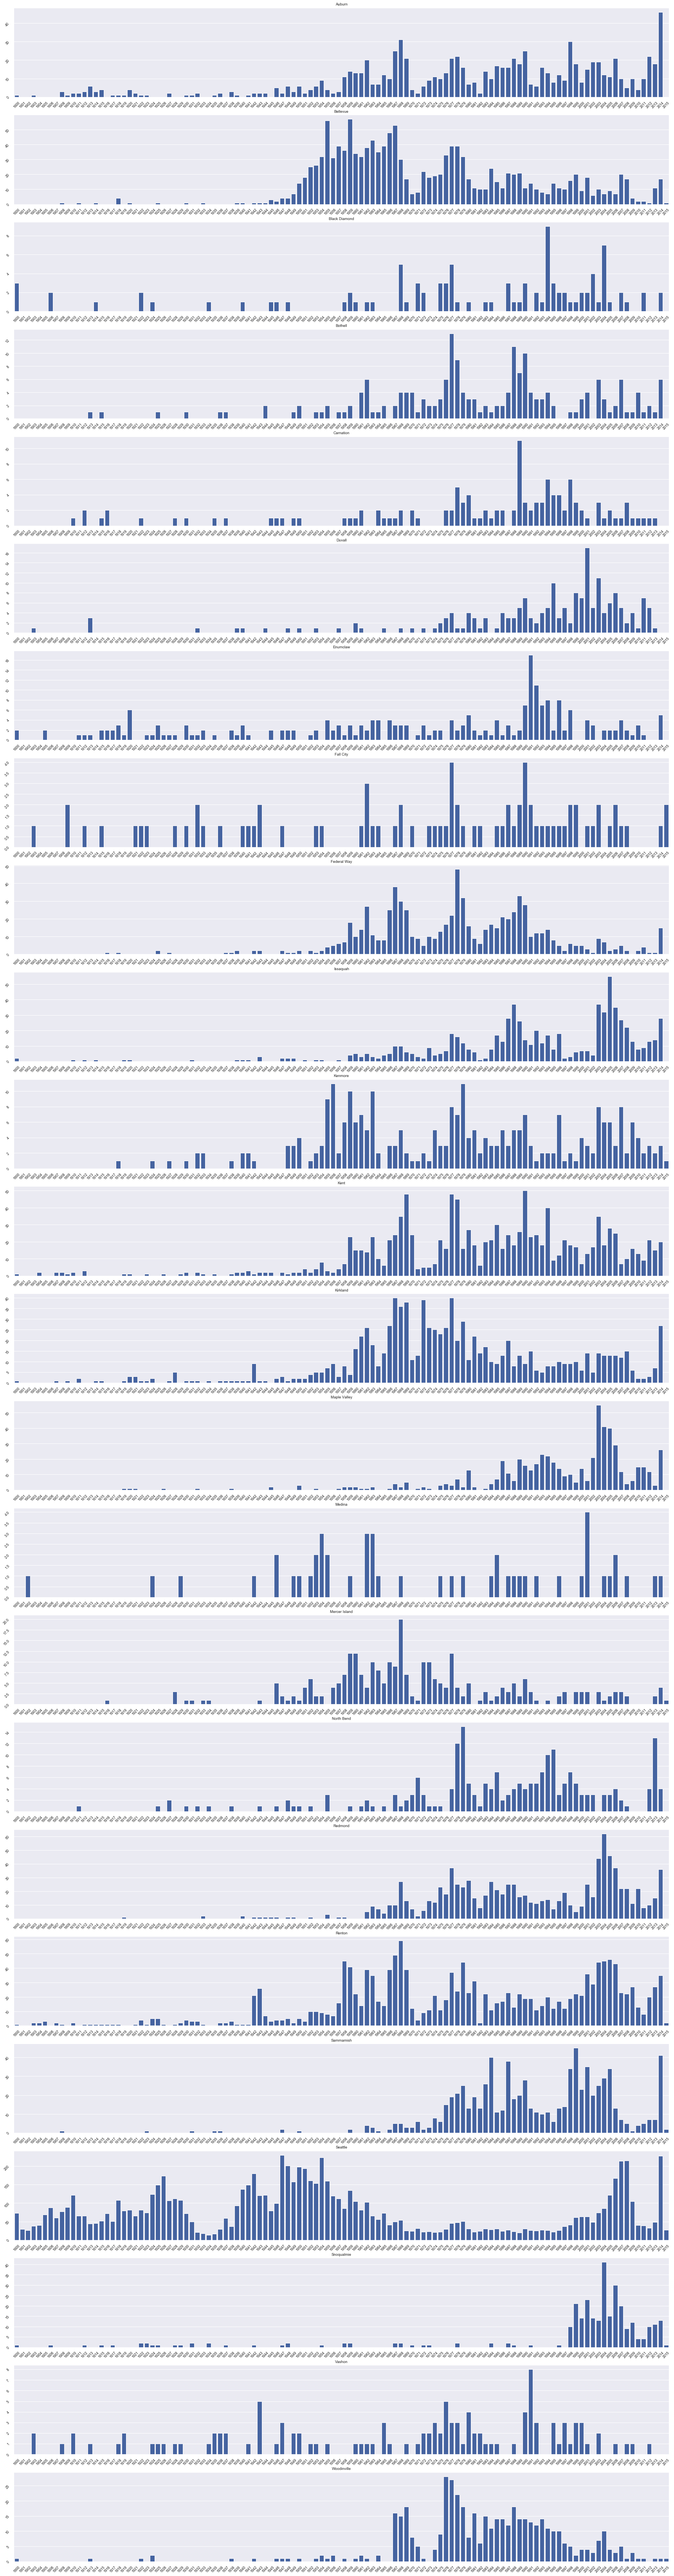

In [55]:
## 도시 별, 연도 별 주택 매매 건수

crosstab_major_city_yr_built = pd.crosstab(index=merged_features.yr_built, columns=merged_features.major_city)

start = dt.datetime.now()
plot_multi_barplots(crosstab_major_city_yr_built, sorted(merged_features.major_city.unique()),
                    len(merged_features.major_city.unique()), 1, 30, 120, .8, 45, '#365eaf')

In [56]:
end = dt.datetime.now()
print(end-start)

0:00:57.993768


In [57]:
del crosstab_major_city_yr_built

- ### **누적 퍼센트 데이터 생성 구조도**
<center>
    <img src="floor_sum_over_time.png" width="600">
</center>

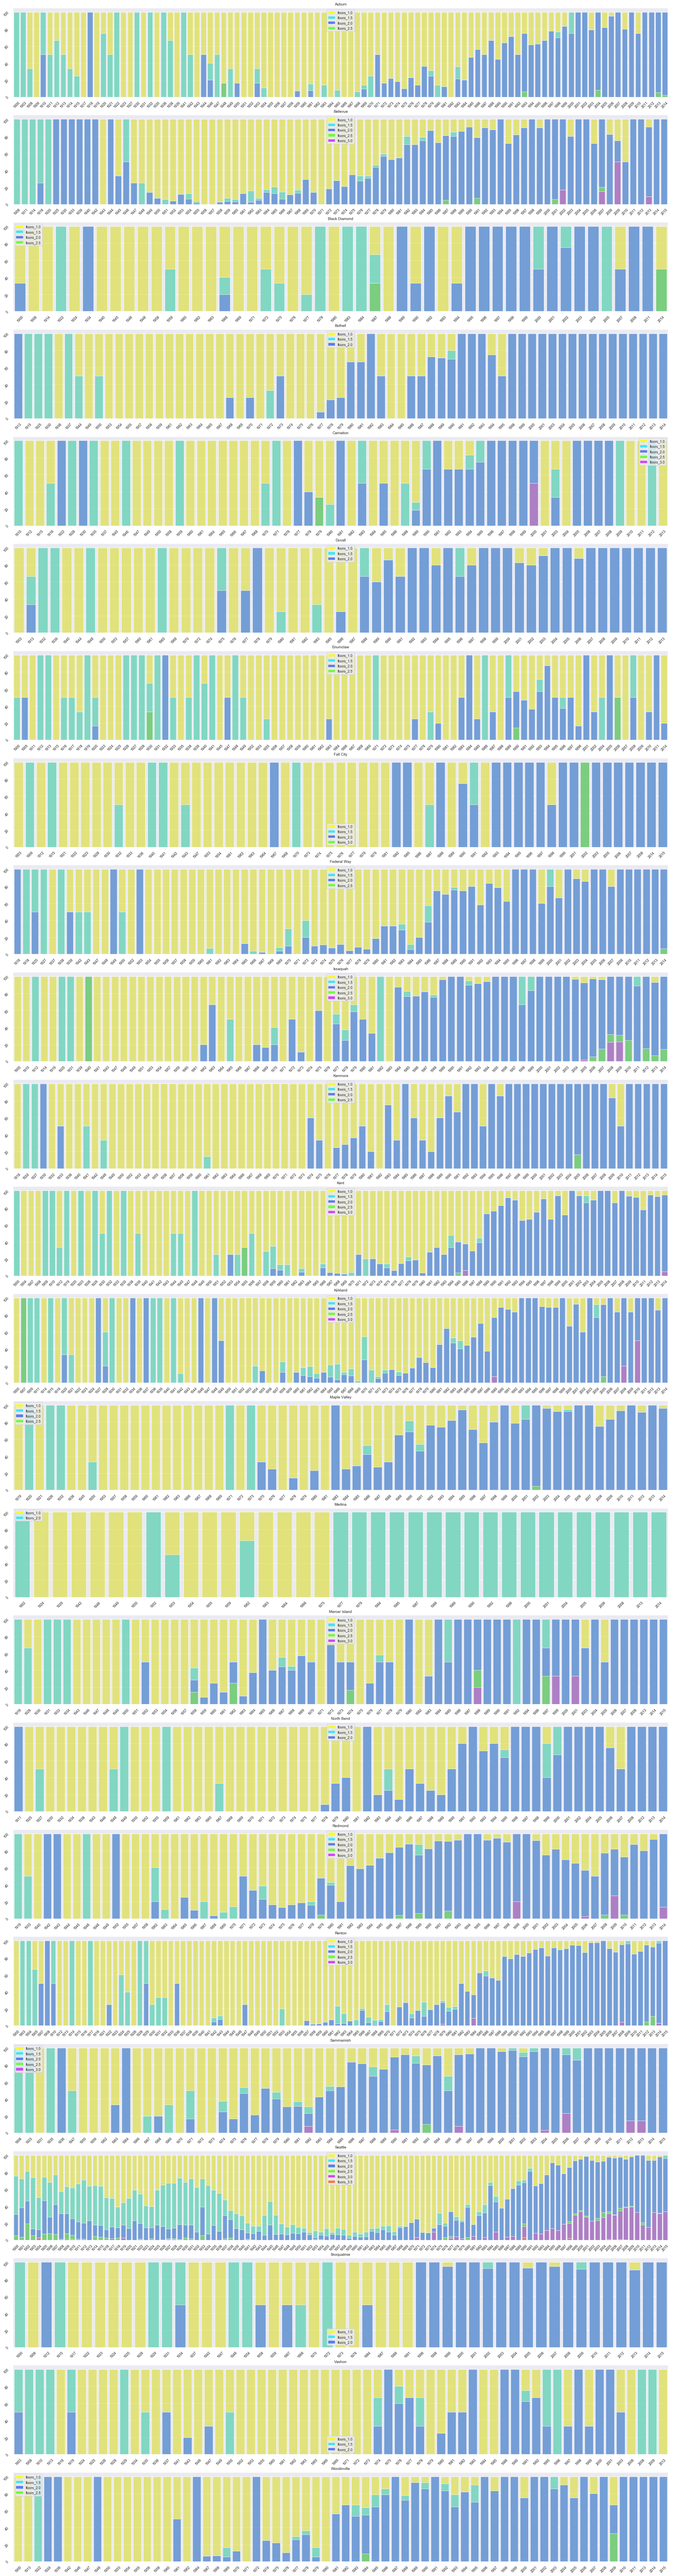

In [58]:
start = dt.datetime.now()
plot_stacked_barplots(merged_features, 'major_city', sorted(merged_features.major_city.unique()),\
                            'yr_built', 'floors', len(sorted(merged_features.major_city.unique())), 1, 30, 120, 45)

In [59]:
end = dt.datetime.now()
print(end - start)

0:01:30.167940


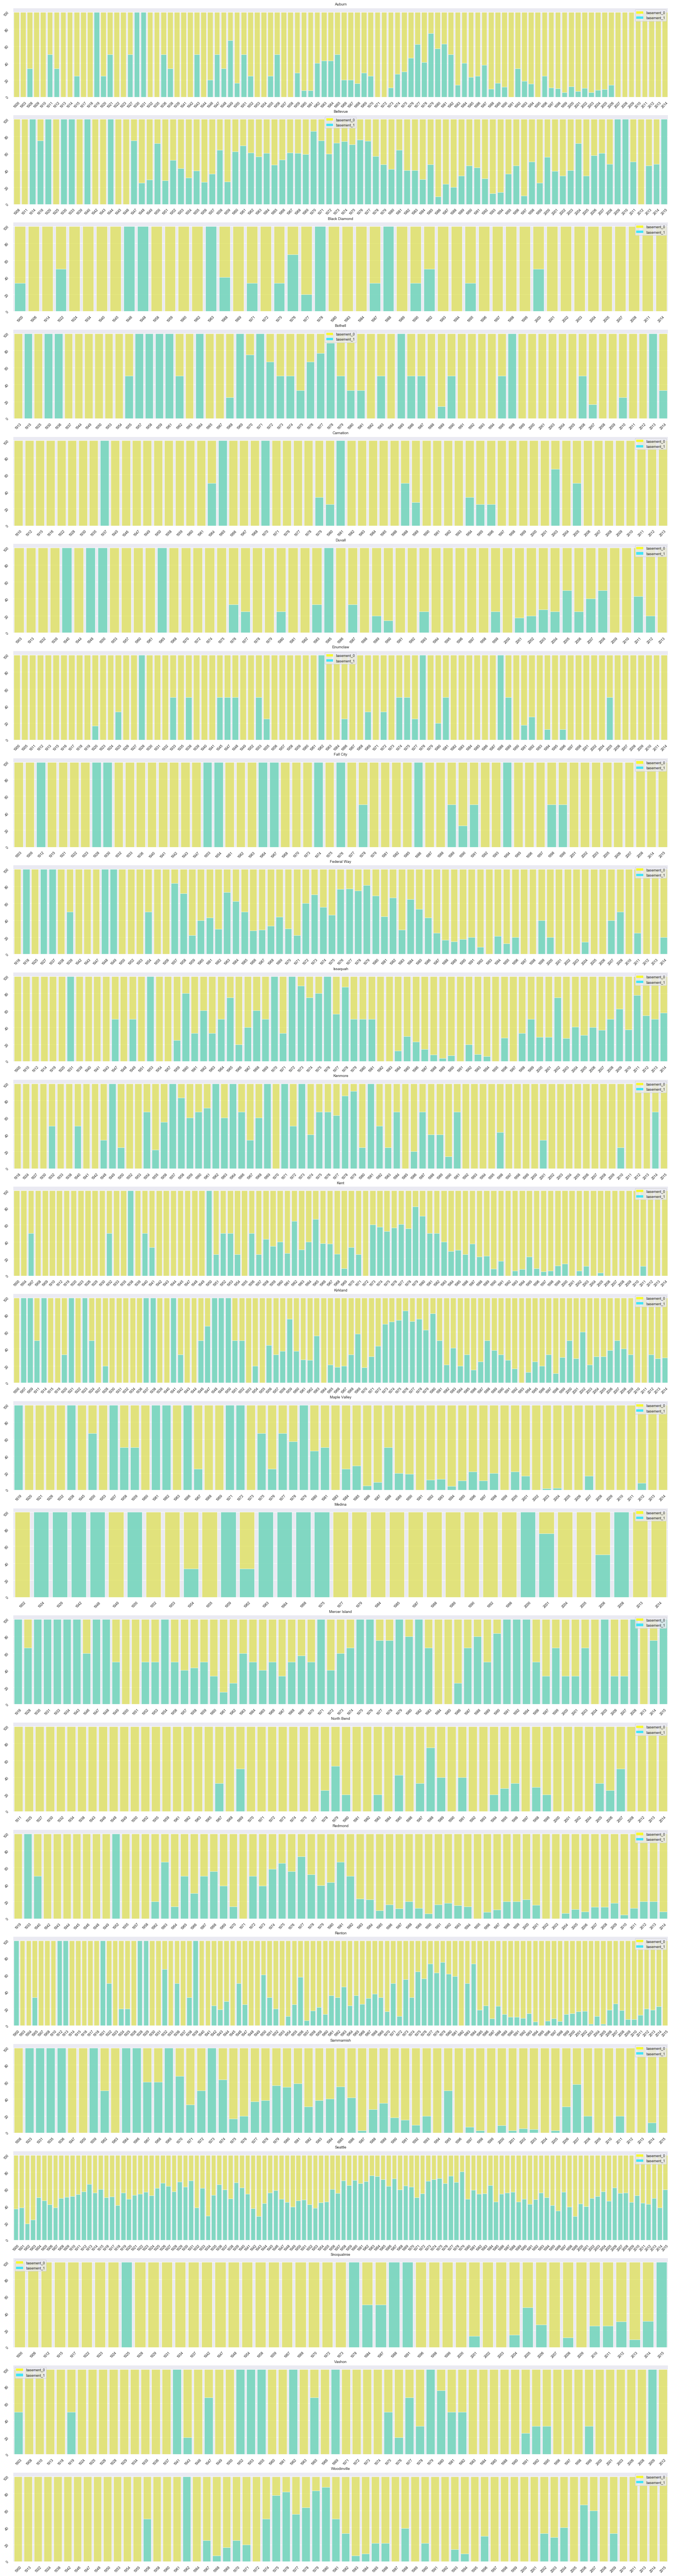

In [60]:
start = dt.datetime.now()
plot_stacked_barplots(merged_features, 'major_city', sorted(merged_features.major_city.unique()),\
                            'yr_built', 'basement', len(sorted(merged_features.major_city.unique())), 1, 30, 120, 45)

In [61]:
end = dt.datetime.now()
print(end - start)

0:00:56.735791


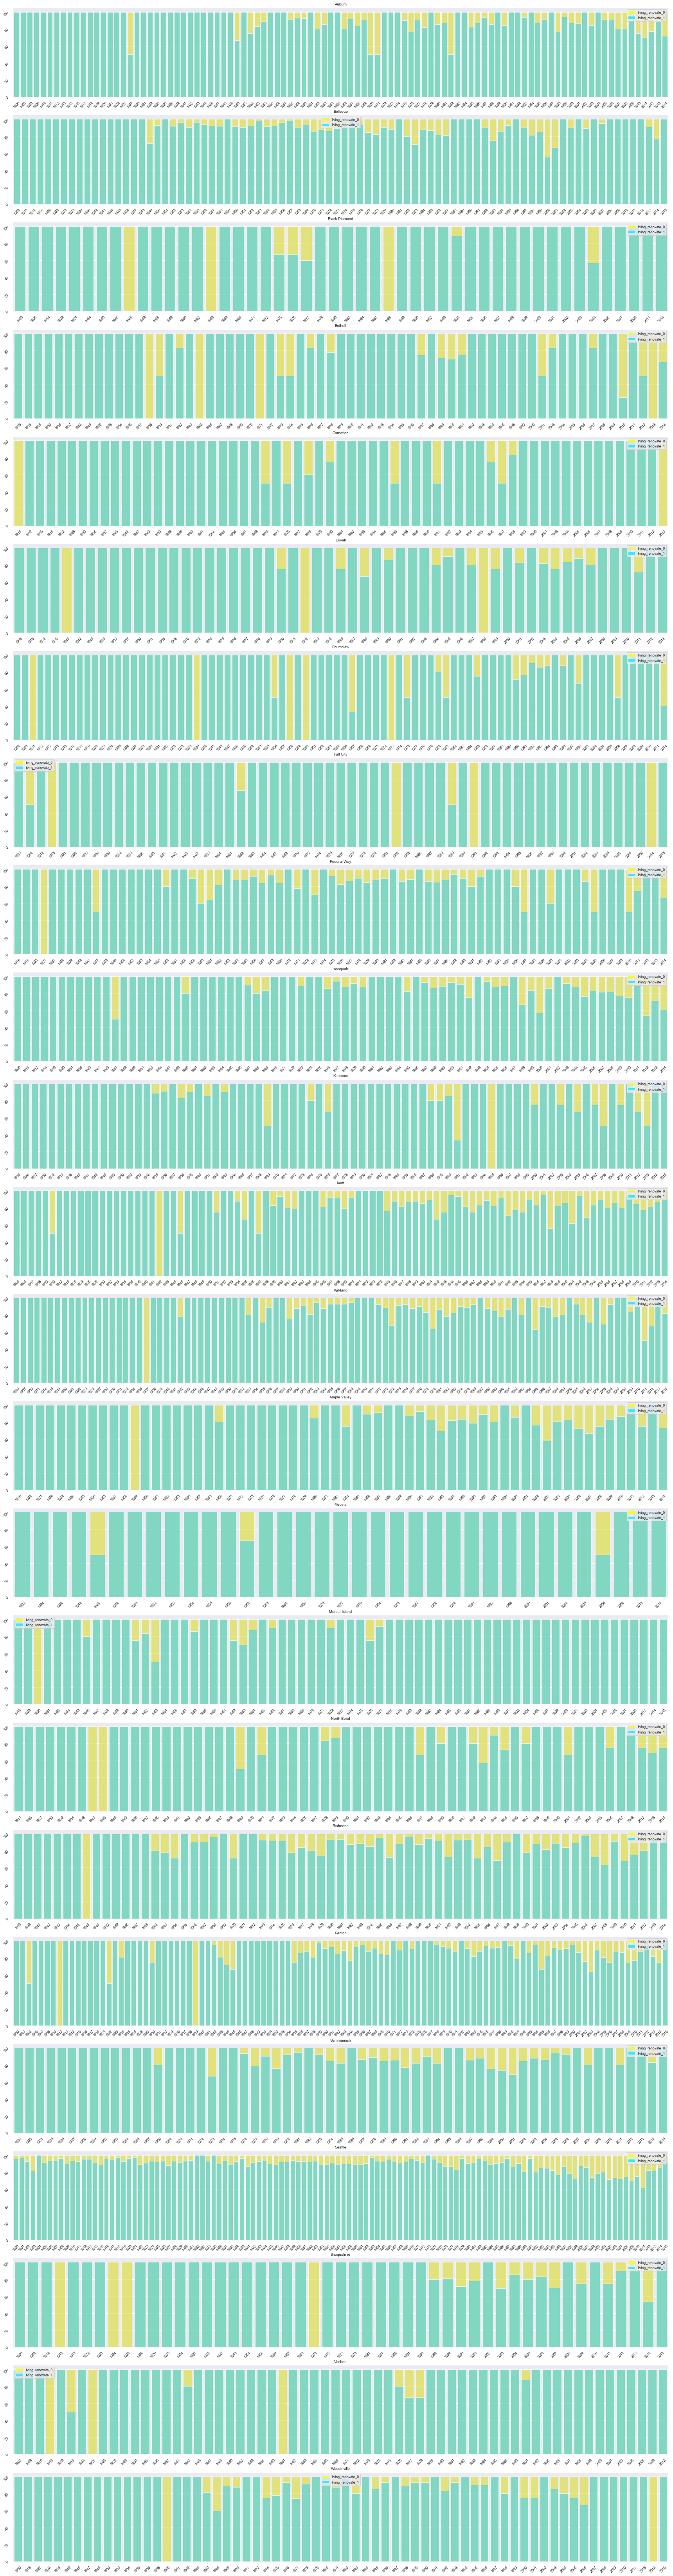

In [62]:
start = dt.datetime.now()
plot_stacked_barplots(merged_features, 'major_city', sorted(merged_features.major_city.unique()),\
                            'yr_built', 'living_renovate', len(sorted(merged_features.major_city.unique())), 1, 30, 120, 45)

In [63]:
end = dt.datetime.now()
print(end - start)

0:00:56.067714


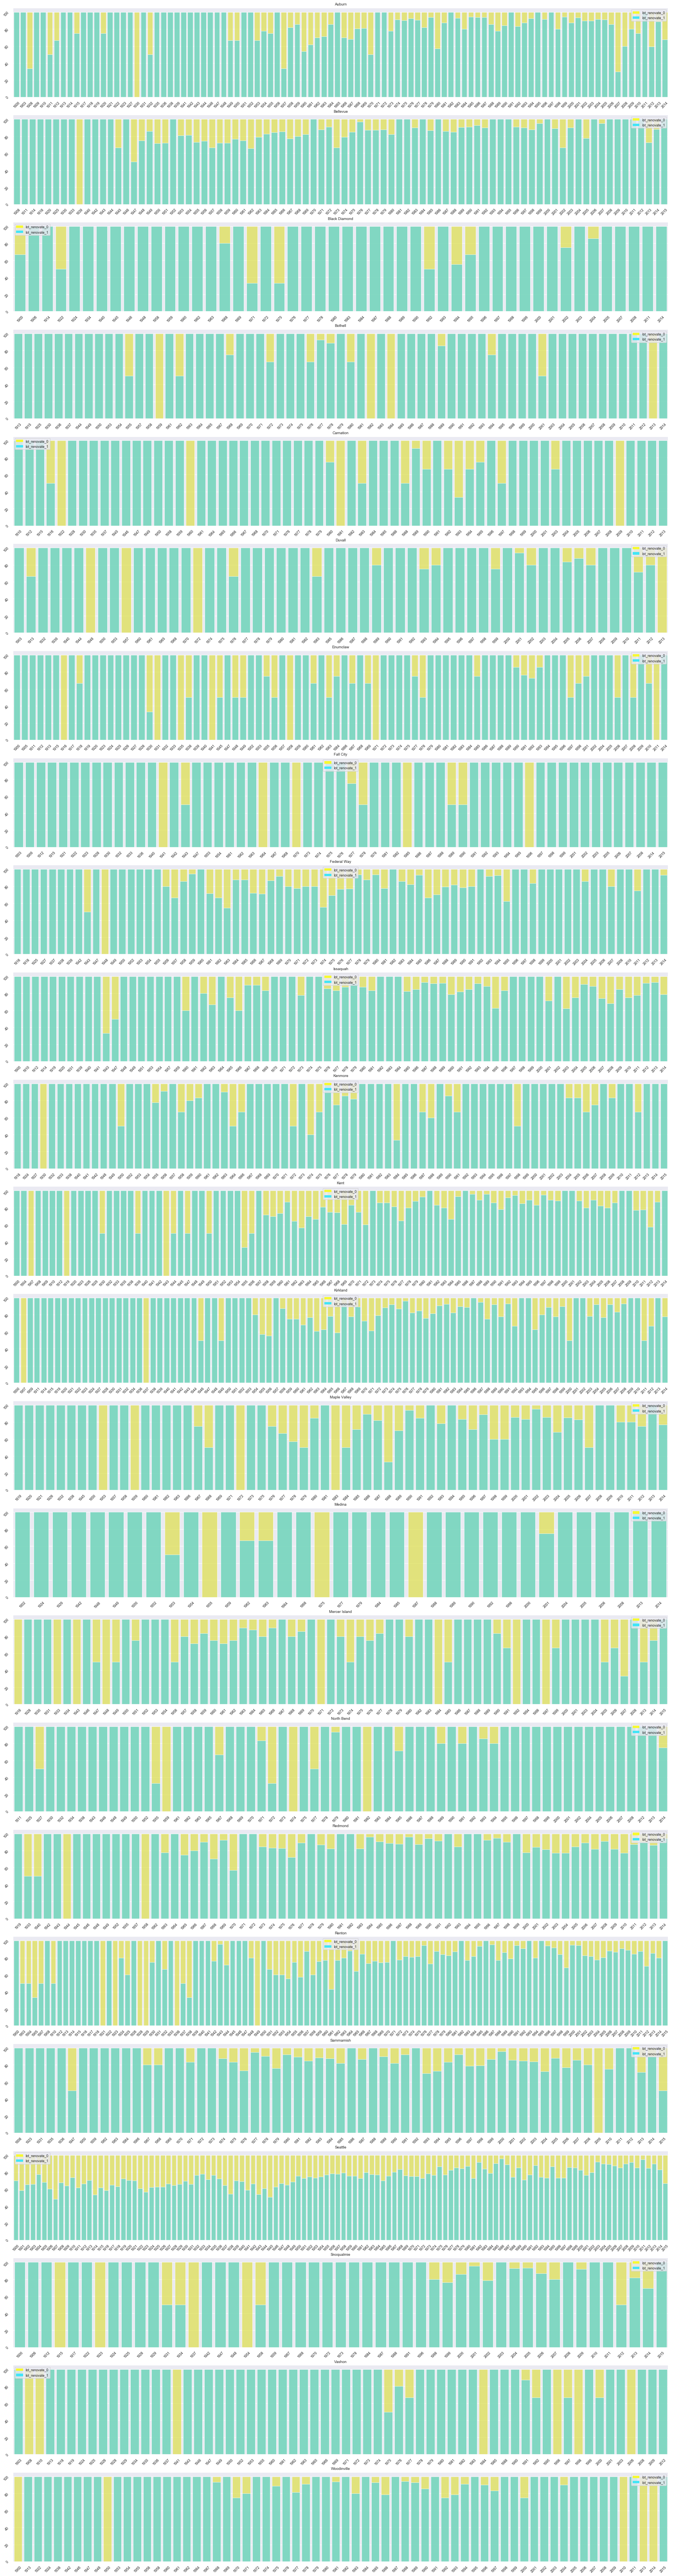

In [64]:
start = dt.datetime.now()
plot_stacked_barplots(merged_features, 'major_city', sorted(merged_features.major_city.unique()),\
                            'yr_built', 'lot_renovate', len(sorted(merged_features.major_city.unique())), 1, 30, 120, 45)

In [65]:
end = dt.datetime.now()
print(end - start)

0:00:57.328290


### **→ 군데 군데 패턴이 발견되는 곳이 있지만 어떻게 FE 해야할지 모르겠음**

In [66]:
train['month'] = train.date.apply(lambda value : int(value[4:6]))
# spring : 0
# summer : 1
# fall : 2
# winter1 : 3
# winter2 : 4
train['season'] = train.month.apply(lambda no: 0 if no in [4, 5, 6] else
                                                     (1 if no in [7, 8, 9] else
                                                      (2 if no==10 else
                                                      (3 if no in [11, 12] else 4))))
variables_relation = two_variables_analysis(train, ['season'], [1], [2], 'continuous', 'price')
_ = var_relation_show(variables_relation)

■  continuous_multi 

----  season
   => test_statistics : 33.7427 / p_value : 0.0000
     ------------------------------------------




In [67]:
train['season'] = train.month.apply(lambda no: 0 if no in [5, 6] else
                                                     (1 if no in [7, 8, 9] else
                                                      (2 if no==10 else
                                                      (3 if no in [11, 12] else 4))))
variables_relation = two_variables_analysis(train, ['season'], [1], [2], 'continuous', 'price')
_ = var_relation_show(variables_relation)

■  continuous_multi 

----  season
   => test_statistics : 14.2260 / p_value : 0.0066
     ------------------------------------------




In [68]:
# spring : 0
# summer : 1
# fall : 2
# winter : 3
train['season'] = train.month.apply(lambda no: 0 if no in [4, 5, 6] else
                                                     (1 if no in [7, 8, 9] else
                                                      (2 if no==10 else 3)))
variables_relation = two_variables_analysis(train, ['season'], [1], [2], 'continuous', 'price')
_ = var_relation_show(variables_relation)

■  continuous_multi 

----  season
   => test_statistics : 33.7136 / p_value : 0.0000
     ------------------------------------------




In [69]:
train.drop('season', axis=1, inplace=True)
del variables_relation

### **→ https://www.quora.com/Does-Seattle-Washington-have-four-seasons 참고해 EDA 진행**
### **→ 봄을 4-6월로 잡고, 겨울은 1·2로 나눠서 feature 만들기**

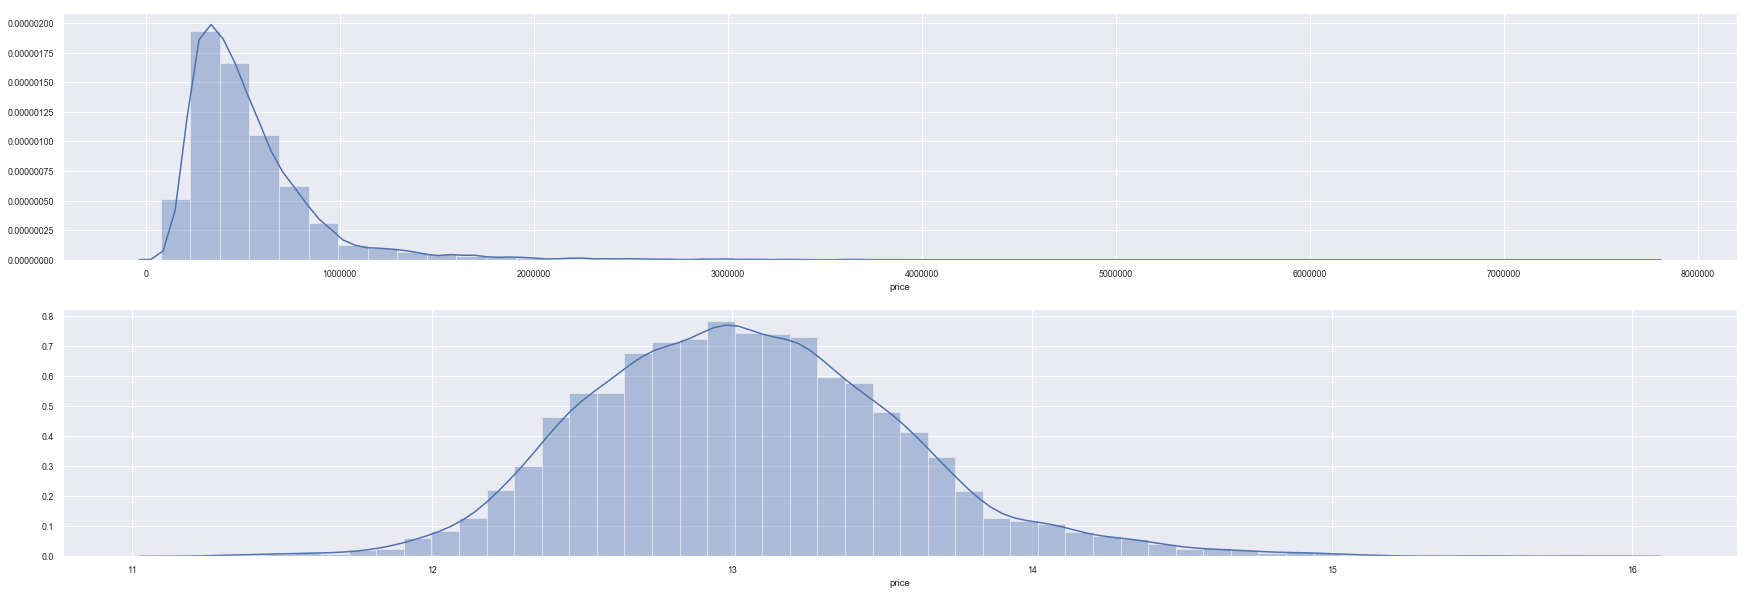

In [70]:
plt.figure(figsize=(30, 10))

ax = plt.subplot(211)
sns.distplot(train_targets, hist=True, kde=True, ax=ax)

ax = plt.subplot(212)
sns.distplot(np.log1p(train_targets), hist=True, kde=True, ax=ax)

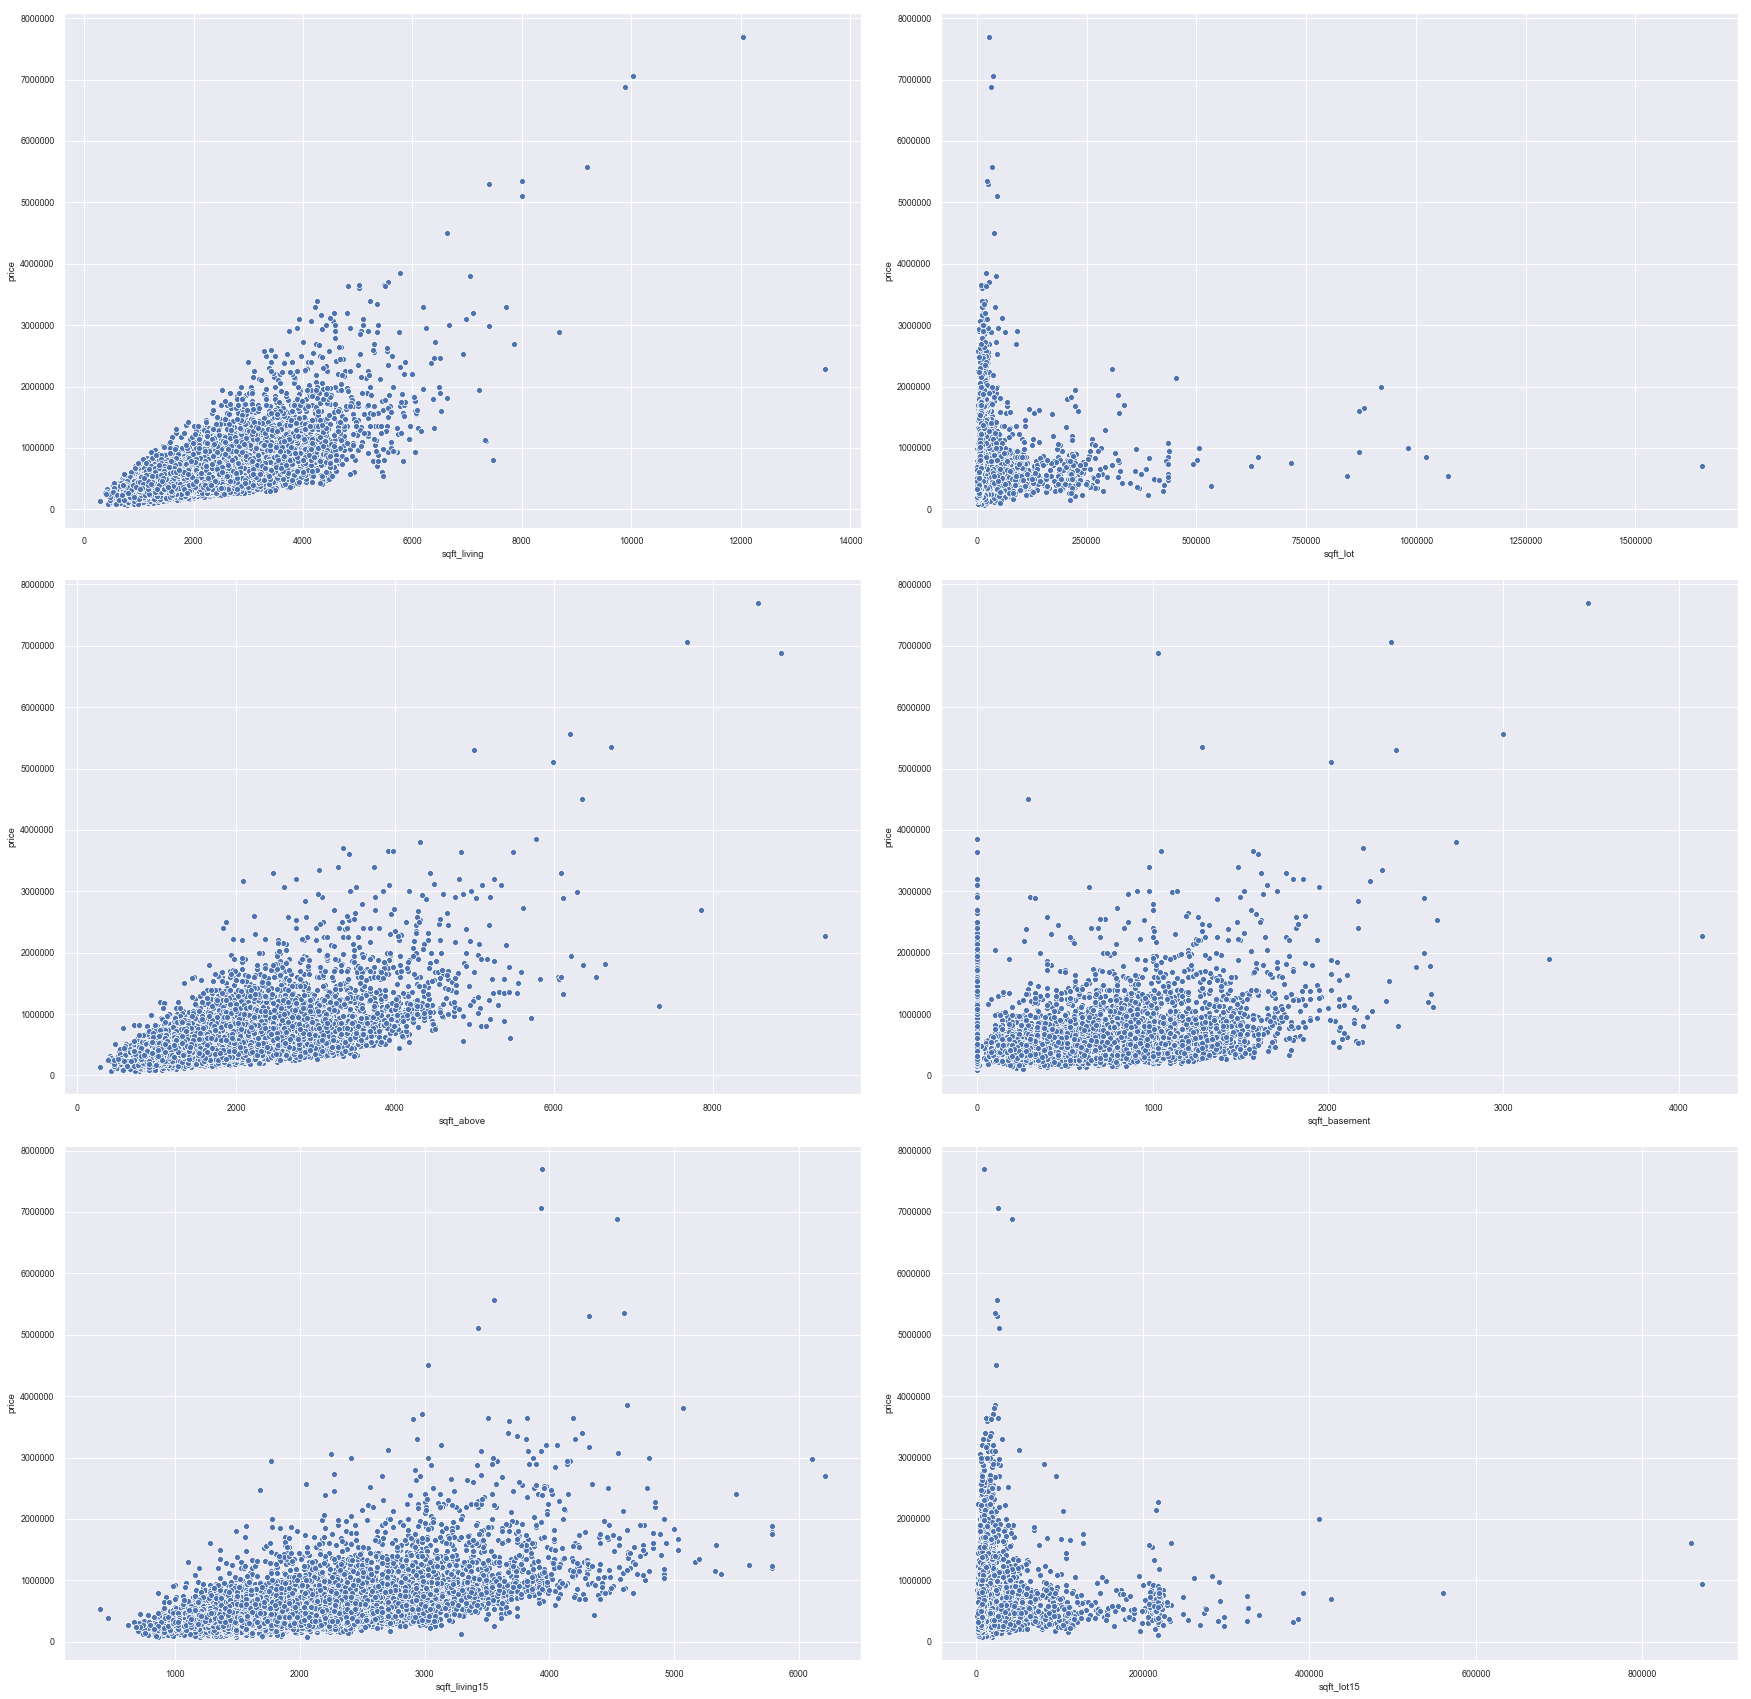

In [71]:
merged_price_train = pd.concat([merged_features[:len(train)], train_targets], axis=1)
plot_multi_scatterplot(merged_price_train, merged_price_train.columns[:merged_features.columns.get_loc('year')], 'price', .1, .1)
del merged_price_train

### **→ outlier 제거**
#### * 첫 번째
- sqft_living : 7,000 이상인데 price가 2,000,000 안 넘는 거 삭제
- sqft_lot : 600,000 이상인 거 삭제
- sqft_above : 4,000 이상인데 1,000,000 안 넘는 거 , 6,000 이상인데 1,500,000 안 넘는 거 , 7,000이상인데 3,000,000 안 넘는 거
- sqft_basement : 3,000 이상인데 3,000,000 안 넘는 거
- sqft_living15 : 5,000 이상인데 2,000,000 안 넘는 거
- sqft_lot15 : 500,000 이상인 거 삭제

#### * 두 번째
- sqft_living : 13,000 이상인 거 삭제
- sqft_lot : 1,500,000 이상인 거 삭제
- sqft_above : 7,000 이상인데 2,200,000 안 넘는 거 삭제
- sqft_basement : 4,000 이상인 거 삭제
- sqft_living15 : 그대로
- sqft_lot15 : 600,000 이상인 거 삭제

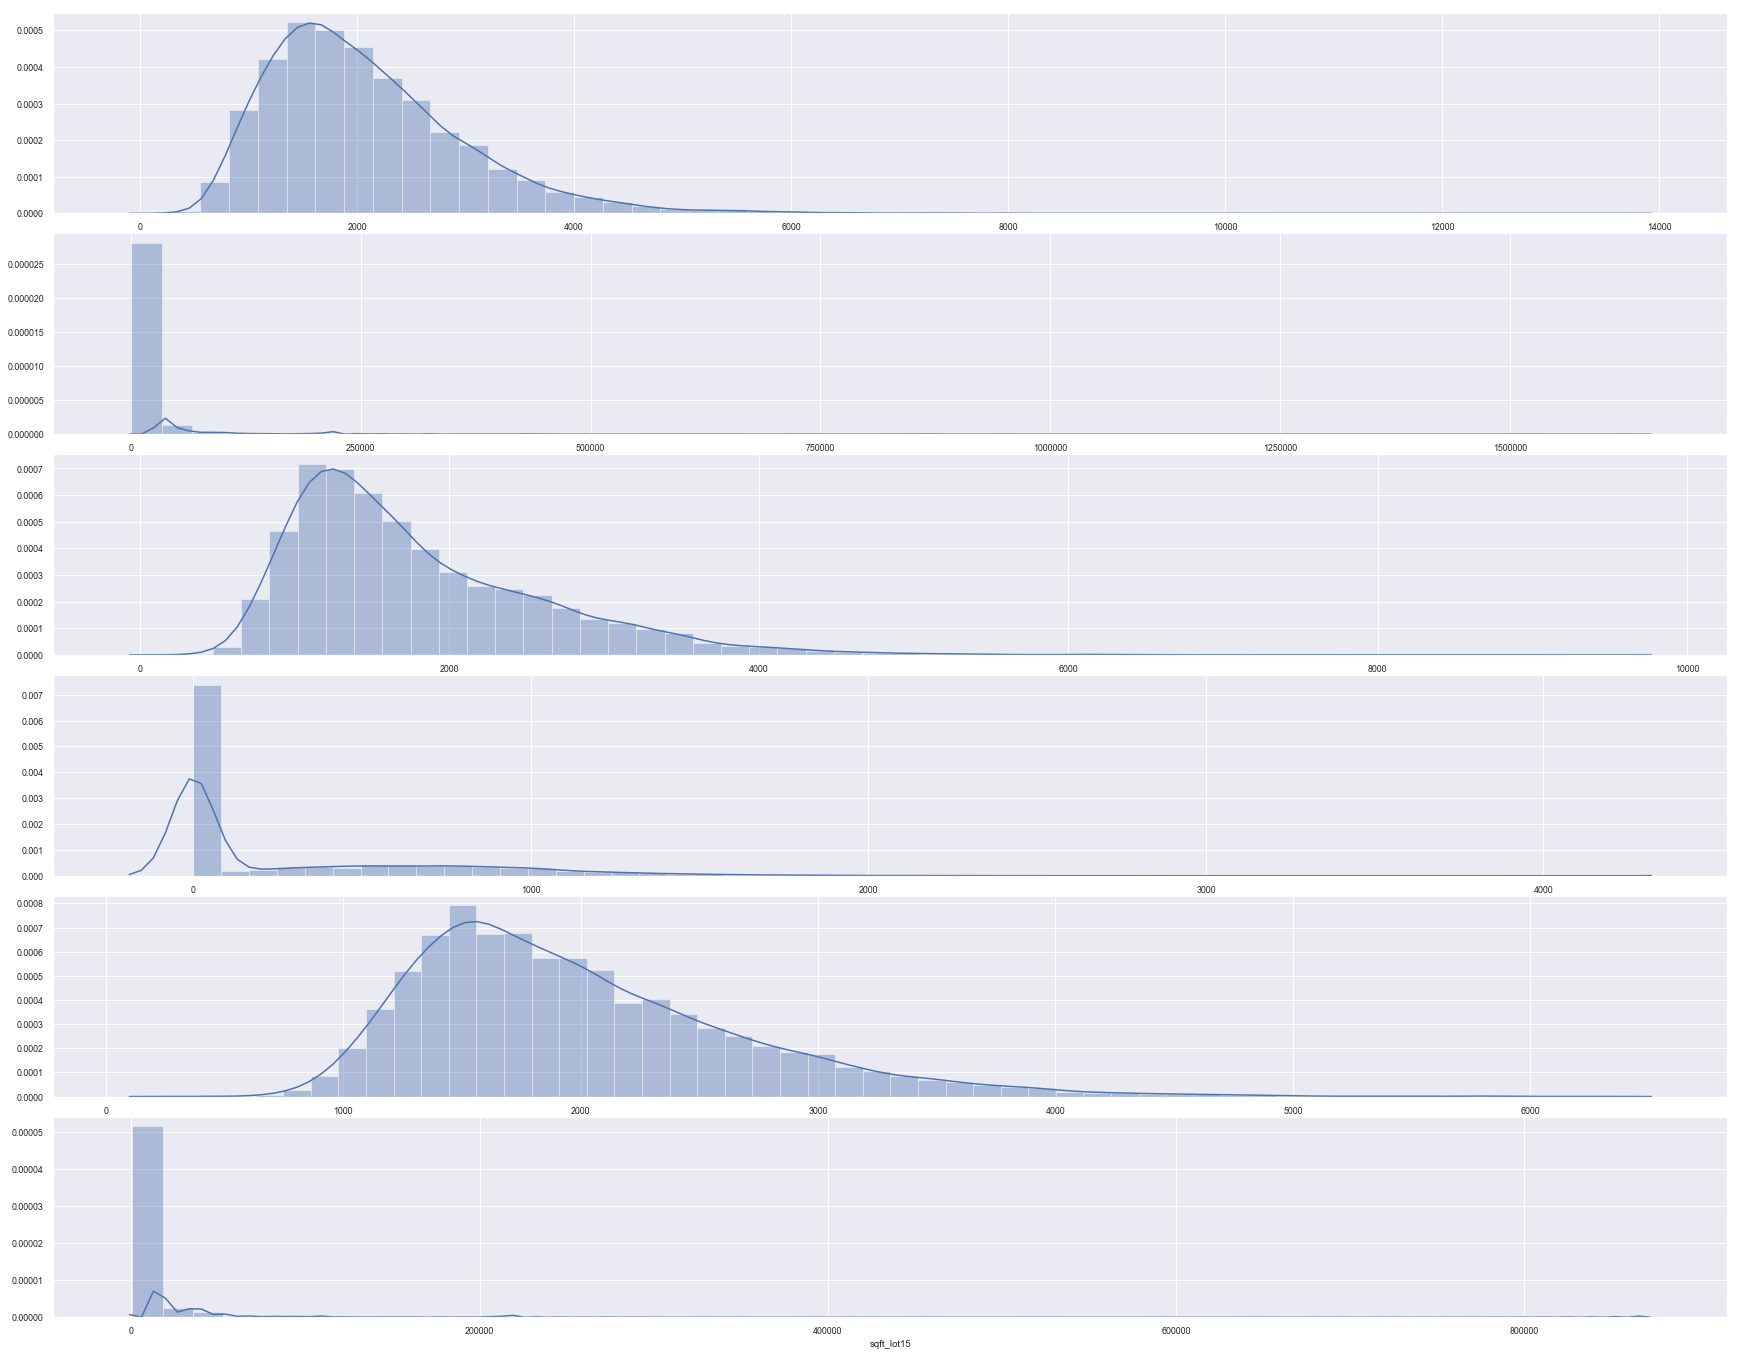

In [72]:
_ = plot_multi_histograms(merged_features[:len(train)], 'sqft_living', 'sqft_lot15', .1)

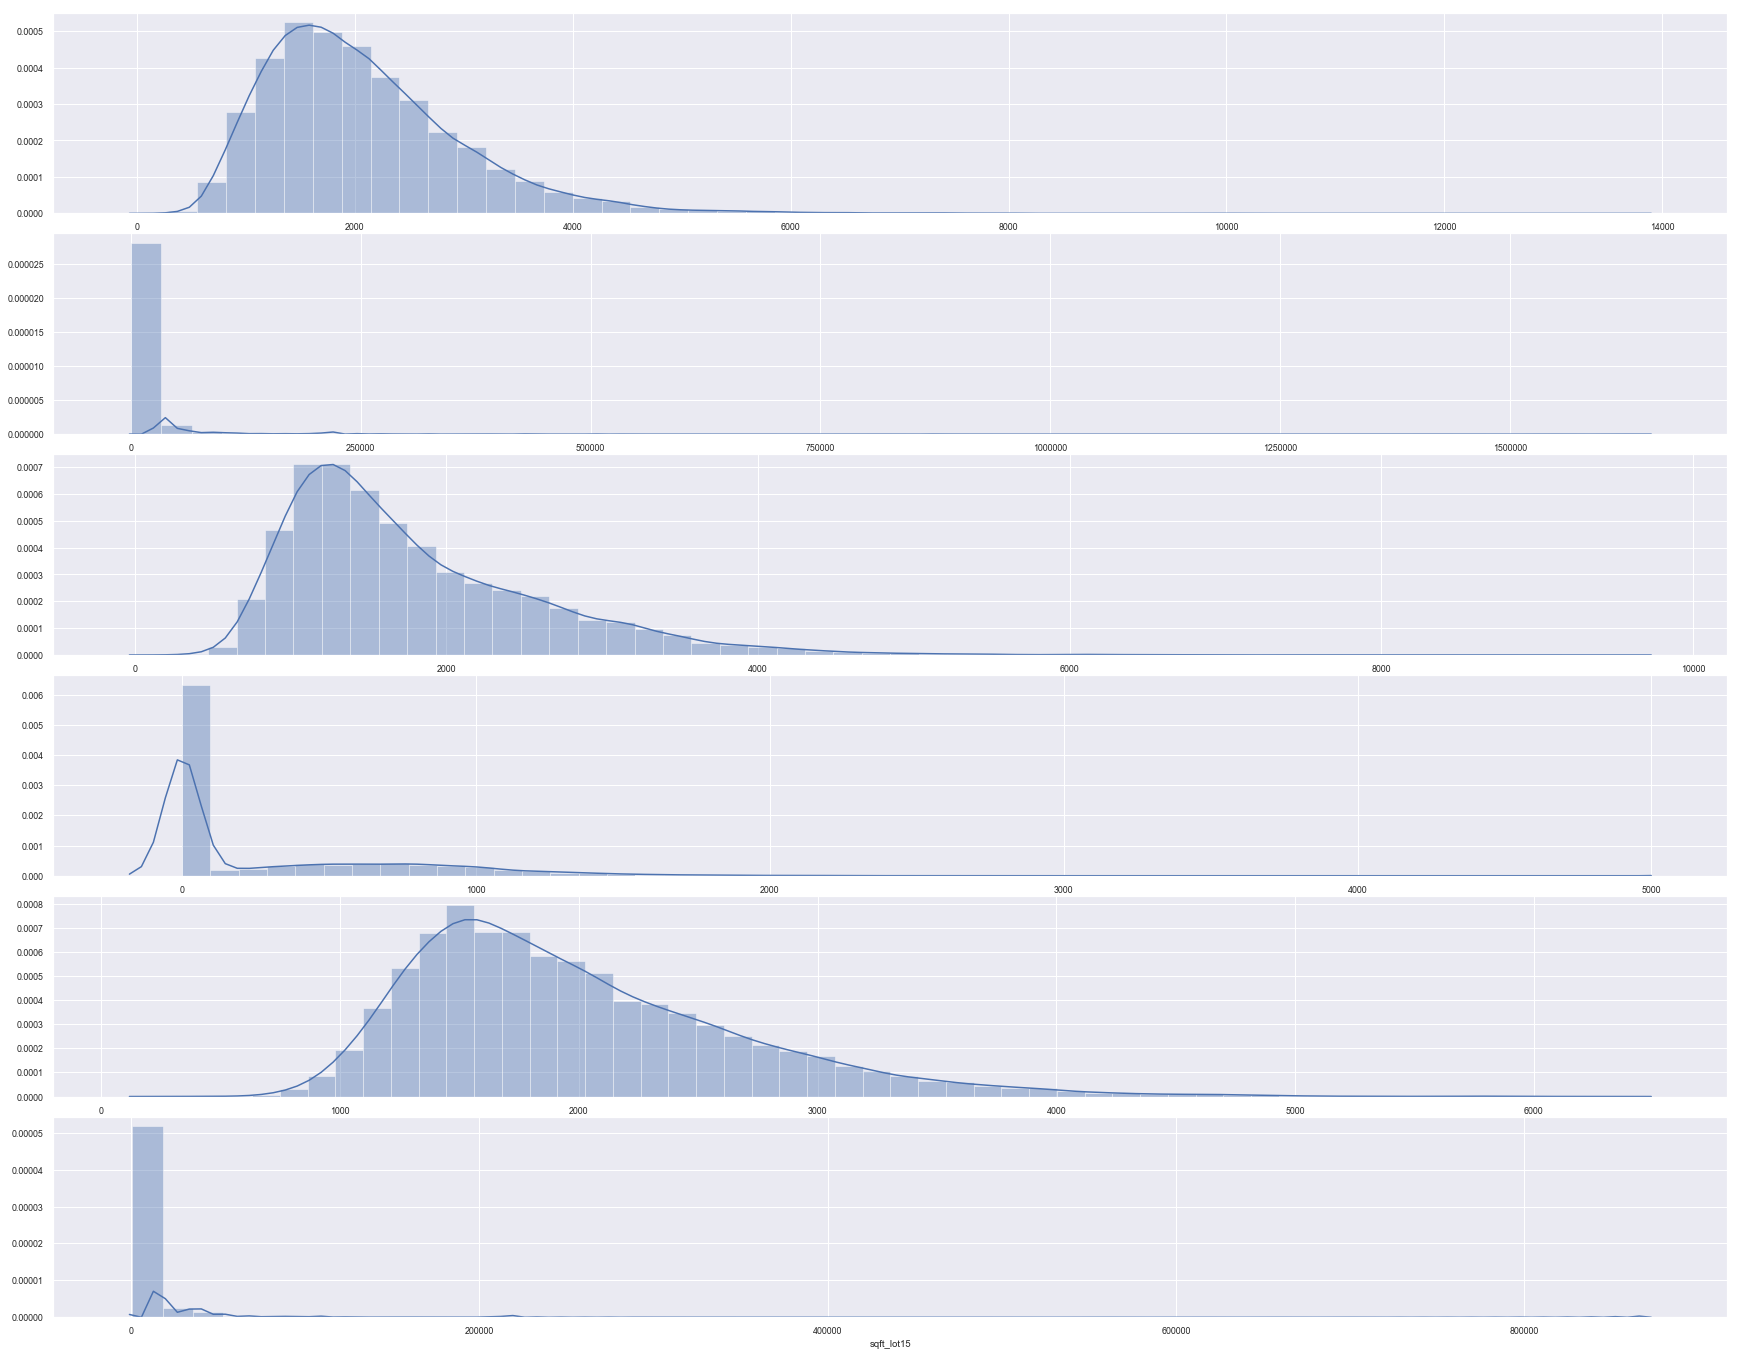

In [73]:
_ = plot_multi_histograms(merged_features, 'sqft_living', 'sqft_lot15', .1)

In [149]:
train_temp = merged_features[:len(train)]

In [243]:
# temp = pd.DataFrame(pd.qcut(merged_features.sqft_basement, 2, labels=False), columns=['sqft_basement'])[:len(train)]
# temp = pd.DataFrame(pd.qcut(train_temp[train_temp.sqft_lot!=0].sqft_basement, 10, labels=[no for no in range(1, 11)]), columns=['sqft_basement'])
temp = pd.DataFrame(pd.qcut(train_temp.sqft_lot15, 50, labels=False), columns=['sqft_lot15'])
# temp = np.floor(np.log10(train_temp.sqft_living))

In [250]:
len(train_temp[train_temp.sqft_lot15==0])

0

In [244]:
train_targets[temp[temp.sqft_lot15==0].index].mean()

430458.8552631579

In [245]:
train_targets[temp[temp.sqft_lot15==1].index].mean()

454861.8791946309

In [246]:
train_targets[temp[temp.sqft_lot15==2].index].mean()

466932.584717608

In [247]:
train_targets[temp[temp.sqft_lot15==48].index].mean(), train_targets[temp[temp.sqft_lot15==48].index].min(), train_targets[temp[temp.sqft_lot15==48].index].max()

(653842.3289036545, 192500.0, 6885000.0)

In [248]:
train_targets[temp[temp.sqft_lot15==49].index].mean(), train_targets[temp[temp.sqft_lot15==49].index].min(), train_targets[temp[temp.sqft_lot15==49].index].max()

(634271.4617940199, 110000.0, 2700000.0)

In [224]:
train_targets[temp[temp.sqft_lot15==59].index].mean(), train_targets[temp[temp.sqft_lot15==59].index].min(), train_targets[temp[temp.sqft_lot15==59].index].max()

(626742.3505976095, 110000.0, 2280000.0)

In [148]:
train_targets[temp[temp.sqft_basement==6].index].mean()

624533.0271739131

In [143]:
train_targets[temp[temp.sqft_basement==7].index].mean()

686859.5971479501

In [144]:
train_targets[temp[temp.sqft_basement==8].index].mean()

701799.9800664452

In [145]:
train_targets[temp[temp.sqft_basement==9].index].mean()

1091822.9305555555

In [175]:
train_targets[temp[temp.sqft_above==97].index].mean()

1169590.0980392157

In [176]:
train_targets[temp[temp.sqft_above==98].index].mean()

1315015.5637583893

In [177]:
train_targets[temp[temp.sqft_above==99].index].mean()

1928780.0

In [ ]:
del temp, train_temp

### **- qcut 범위**
### → 100, 50, 100, 11(0인 것들 먼저 0으로 labeling 하고 나머지 것들 가지고 qcut에 label 부여해서 10으로), 100, 50

## **■ FE**

In [74]:
def make_month_derived_feature():
    merged_features['season'] = merged_features.month.apply(lambda no: 0 if no in [4, 5, 6] else
                                                            (1 if no in [7, 8, 9] else
                                                             (2 if no==10 else
                                                              (3 if no in [11, 12] else 4))))

In [75]:
def compute_score(data_, n_components_):
    
    pca = PCA(n_components=n_components_, random_state=2019)
    cv_score = cross_val_score(pca, data_, n_jobs=-1, cv=5)
    
    return np.mean(cv_score)


def find_optimal_n_factors(data, max_n):
    
    scaler_names = []
    max_scores = []
    max_indexes = []
    
    for scaler_class in [MinMaxScaler, RobustScaler, StandardScaler]:
        
        scaler = scaler_class()
        scaler_names.append(scaler.__class__)
        data_scaled = scaler.fit_transform(data)
        
        scores = np.array([])
        
        for no in tqdm(range(1, max_n+1)):
            
            score = compute_score(data_scaled, no)
            scores = np.append(scores, score)
        
        max_scores.append(scores.max())
        max_indexes.append(scores.argmax())
    
    best_scaler_index = np.array(max_scores).argmax()
    
    return scaler_names[best_scaler_index], max_indexes[best_scaler_index]+1

In [76]:
make_month_derived_feature()

In [78]:
merged_features = merged_features[[
    'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15',
    'year', 'month', 'day', 'weekday', 'yr_built', 'yr_renovated', 'view', 'condition', 'grade',
    'season', 'waterfront', 'living_renovate', 'lot_renovate', 'basement', 'floors', 'bedrooms', 'bathrooms',  'major_city'
]]

In [79]:
train_size, test_size = len(train), len(test)

In [80]:
train_size, test_size

(15035, 6468)

### - pca for continuous features

In [81]:
%time best_scaler, best_n = find_optimal_n_factors(merged_features.iloc[:, :merged_features.columns.get_loc('sqft_lot15')+1], 6)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.75it/s]


Wall time: 3.72 s


In [82]:
best_scaler, best_n

(sklearn.preprocessing.data.MinMaxScaler, 4)

In [83]:
continuous_transformed = MinMaxScaler().fit_transform(merged_features.iloc[:, :merged_features.columns.get_loc('sqft_lot15')+1])
continuous_transformed = PCA(n_components=best_n, random_state=2019).fit_transform(continuous_transformed)
continuous_transformed = pd.DataFrame(continuous_transformed, columns=['continuous_pc1', 'continuous_pc2', 'continuous_pc3', 'continuous_pc4'])

In [84]:
merged_features_continuous_pca = pd.concat([continuous_transformed, merged_features.iloc[:, merged_features.columns.get_loc('sqft_lot15')+1:]], axis=1)

## **■ EDA**

### - feature selection - using statistics

In [ ]:
temp = pd.concat([merged_features[:train_size], train_targets], axis=1)

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
relation_result = two_variables_analysis(
    temp,
    list(temp.columns[:len(temp.columns)-1]),
    list(temp.columns[:temp.columns.get_loc('year')]),
    ['year', 'waterfront', 'living_renovate', 'lot_renovate', 'basement'],
    'continuous',
    'price'
)
selected_features = var_relation_show(relation_result)
print('removed features : ', [col for col in temp.columns if col not in selected_features])

# ■  continuous_continuous 

# ----  sqft_living
#    => test_statistics : 0.6465 / p_value : 0.0000
#      ------------------------------------------
# ----  sqft_lot
#    => test_statistics : 0.0806 / p_value : 0.0000
#      ------------------------------------------
# ----  sqft_above
#    => test_statistics : 0.5479 / p_value : 0.0000
#      ------------------------------------------
# ----  sqft_basement
#    => test_statistics : 0.2453 / p_value : 0.0000
#      ------------------------------------------
# ----  sqft_living15
#    => test_statistics : 0.5738 / p_value : 0.0000
#      ------------------------------------------
# ----  sqft_lot15
#    => test_statistics : 0.0658 / p_value : 0.0000
#      ------------------------------------------

# ======================================================

# ■  continuous_binary 

# ----  year
#    => test_statistics : -0.9869 / p_value : 0.3237
#      ------------------------------------------
# ----  waterfront
#    => test_statistics : -10.2401 / p_value : 0.0000
#      ------------------------------------------
# ----  living_renovate
#    => test_statistics : 9.8625 / p_value : 0.0000
#      ------------------------------------------
# ----  lot_renovate
#    => test_statistics : 5.0575 / p_value : 0.0000
#      ------------------------------------------
# ----  basement
#    => test_statistics : -20.1886 / p_value : 0.0000
#      ------------------------------------------

# ======================================================

# ■  continuous_multi 

# ----  month
#    => test_statistics : 55.1738 / p_value : 0.0000
#      ------------------------------------------
# ----  day
#    => test_statistics : 40.6597 / p_value : 0.0927
#      ------------------------------------------
# ----  weekday
#    => test_statistics : 6.5324 / p_value : 0.3663
#      ------------------------------------------
# ----  yr_built
#    => test_statistics : 1254.2192 / p_value : 0.0000
#      ------------------------------------------
# ----  yr_renovated
#    => test_statistics : 281.2345 / p_value : 0.0000
#      ------------------------------------------
# ----  view
#    => test_statistics : 1329.1798 / p_value : 0.0000
#      ------------------------------------------
# ----  condition
#    => test_statistics : 177.1015 / p_value : 0.0000
#      ------------------------------------------
# ----  grade
#    => test_statistics : 6815.1638 / p_value : 0.0000
#      ------------------------------------------
# ----  season
#    => test_statistics : 33.7427 / p_value : 0.0000
#      ------------------------------------------
# ----  floors
#    => test_statistics : 1706.9556 / p_value : 0.0000
#      ------------------------------------------
# ----  bedrooms
#    => test_statistics : 1880.6541 / p_value : 0.0000
#      ------------------------------------------
# ----  bathrooms
#    => test_statistics : 4044.9777 / p_value : 0.0000
#      ------------------------------------------
# ----  major_city
#    => test_statistics : 5229.5603 / p_value : 0.0000
#      ------------------------------------------

# ======================================================

# removed features :  ['year', 'day', 'weekday', 'price']

In [ ]:
temp = pd.concat([merged_features_continuous_pca[:train_size], train_targets], axis=1)

In [ ]:
relation_result = two_variables_analysis(
    temp,
    list(temp.columns[:temp.columns.get_loc('price')]),
    list(temp.columns[:temp.columns.get_loc('year')]),
    ['year', 'waterfront', 'living_renovate', 'lot_renovate', 'basement'],
    'continuous',
    'price'
)
selected_features_pca = var_relation_show(relation_result)
print('removed features : ', [col for col in temp.columns if col not in selected_features_pca])
del temp

# ■  continuous_continuous 

# ----  continuous_pc1
#    => test_statistics : 0.6477 / p_value : 0.0000
#      ------------------------------------------
# ----  continuous_pc2
#    => test_statistics : -0.0595 / p_value : 0.0000
#      ------------------------------------------
# ----  continuous_pc3
#    => test_statistics : -0.0050 / p_value : 0.5434
#      ------------------------------------------
# ----  continuous_pc4
#    => test_statistics : -0.3905 / p_value : 0.0000
#      ------------------------------------------

# ======================================================

# ■  continuous_binary 

# ----  year
#    => test_statistics : -0.9869 / p_value : 0.3237
#      ------------------------------------------
# ----  waterfront
#    => test_statistics : -10.2401 / p_value : 0.0000
#      ------------------------------------------
# ----  living_renovate
#    => test_statistics : 9.8625 / p_value : 0.0000
#      ------------------------------------------
# ----  lot_renovate
#    => test_statistics : 5.0575 / p_value : 0.0000
#      ------------------------------------------
# ----  basement
#    => test_statistics : -20.1886 / p_value : 0.0000
#      ------------------------------------------

# ======================================================

# ■  continuous_multi 

# ----  month
#    => test_statistics : 55.1738 / p_value : 0.0000
#      ------------------------------------------
# ----  day
#    => test_statistics : 40.6597 / p_value : 0.0927
#      ------------------------------------------
# ----  weekday
#    => test_statistics : 6.5324 / p_value : 0.3663
#      ------------------------------------------
# ----  yr_built
#    => test_statistics : 1254.2192 / p_value : 0.0000
#      ------------------------------------------
# ----  yr_renovated
#    => test_statistics : 281.2345 / p_value : 0.0000
#      ------------------------------------------
# ----  view
#    => test_statistics : 1329.1798 / p_value : 0.0000
#      ------------------------------------------
# ----  condition
#    => test_statistics : 177.1015 / p_value : 0.0000
#      ------------------------------------------
# ----  grade
#    => test_statistics : 6815.1638 / p_value : 0.0000
#      ------------------------------------------
# ----  season
#    => test_statistics : 33.7427 / p_value : 0.0000
#      ------------------------------------------
# ----  floors
#    => test_statistics : 1706.9556 / p_value : 0.0000
#      ------------------------------------------
# ----  bedrooms
#    => test_statistics : 1880.6541 / p_value : 0.0000
#      ------------------------------------------
# ----  bathrooms
#    => test_statistics : 4044.9777 / p_value : 0.0000
#      ------------------------------------------
# ----  major_city
#    => test_statistics : 5229.5603 / p_value : 0.0000
#      ------------------------------------------

# ======================================================

# removed features :  ['continuous_pc3', 'year', 'day', 'weekday', 'price']

### - best k selection for k-means clustering

In [ ]:
def compute_score_clustering(data_, n_clusters_):
    
    kmeans = KMeans(n_clusters=n_clusters_, random_state=2019, n_jobs=-1)
    cv_score = cross_val_score(kmeans, data_, n_jobs=-1, cv=5)
    
    return np.mean(cv_score)


def find_optimal_n_clusters(data, max_n):
    
    scaler_names = []
    max_scores = []
    max_indexes = []
    
    for scaler_class in [MinMaxScaler, RobustScaler, StandardScaler]:
        
        scaler = scaler_class()
        scaler_names.append(scaler.__class__)
        data_scaled = scaler.fit_transform(data)
        
        scores = np.array([])
        
        for no in tqdm(range(1, max_n+1)):
            
            score = compute_score_clustering(data_scaled, no)
            scores = np.append(scores, score)
        
        max_scores.append(scores.max())
        max_indexes.append(scores.argmax())
    
    best_scaler_index = np.array(max_scores).argmax()
    
    return scaler_names[best_scaler_index], max_indexes[best_scaler_index]+1

In [ ]:
%time best_scaler, best_n = find_optimal_n_clusters(merged_features.iloc[:, :merged_features.columns.get_loc('sqft_lot15')+1], 30)

In [ ]:
best_scaler, best_n

In [ ]:
%time best_scaler, best_n = find_optimal_n_clusters(merged_features_continuous_pca.iloc[:, :merged_features_continuous_pca.columns.get_loc('continuous_pc4')+1], 30)

In [ ]:
best_scaler, best_n

In [ ]:
def SSE(data, n_clusters_):
    
    sse = []
    
    for no in range(1, n_clusters_+1):
        kmeans = KMeans(n_clusters=no, random_state=2019, n_jobs=-1)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
    
    plt.figure(figsize=(25, 5))
    plt.plot(range(1, n_clusters_+1), sse, marker='o')
    plt.xlabel('# of clusters')
    plt.ylabel('SSE')
    plt.show()

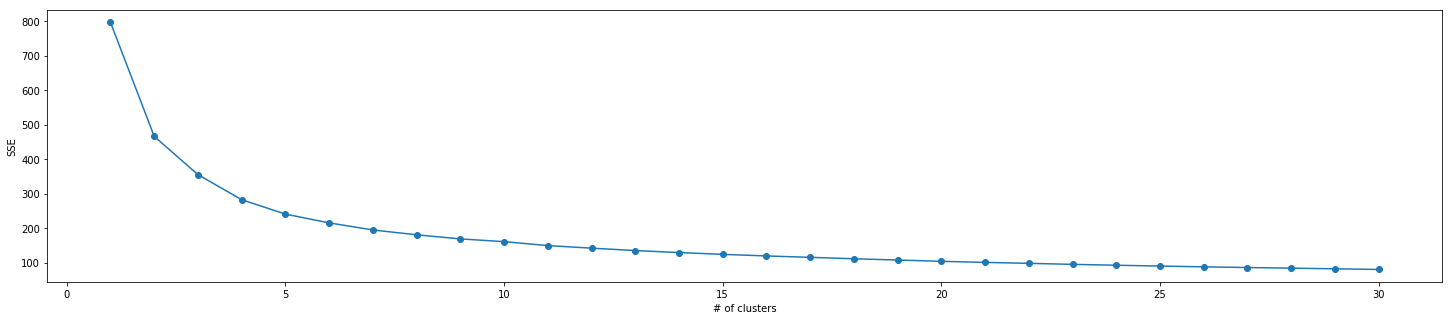

Wall time: 41.1 s


In [25]:
%time SSE(MinMaxScaler().fit_transform(merged_features.iloc[:, :merged_features.columns.get_loc('sqft_lot15')+1]), 30)

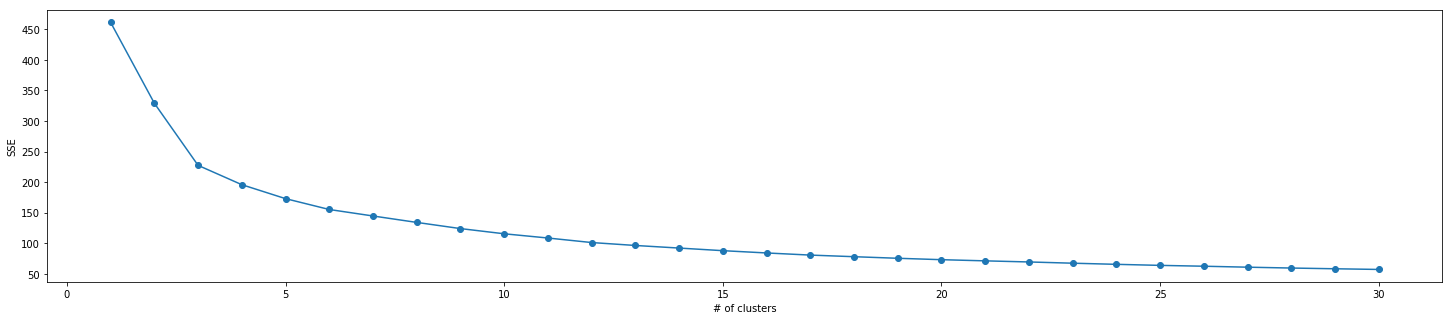

Wall time: 35.8 s


In [26]:
%time SSE(MinMaxScaler().fit_transform(merged_features_continuous_pca.iloc[:, :merged_features_continuous_pca.columns.get_loc('continuous_pc4')+1]), 30)

## **■ FE**

In [85]:
# 참고

# cat_type = CategoricalDtype(categories=sorted(merged_features[col].unique()), ordered=True)
# merged_features[col] = merged_features[col].astype(cat_type)

# merged_features[col] = merged_features[col].astype('category')


def ordinal_factorize_nominal_onehot(data):
    
    start_index = data.columns.get_loc('year')
#     start_index = data.columns.get_loc('month')
    end_index = data.columns.get_loc('grade')+1
    
    for col in data.columns[start_index:end_index]:
        data[col], _ = pd.factorize(data[col], sort=True)
    
    return pd.get_dummies(data, columns=data.columns[end_index:])


def ordinal_nominal_factorize(data):
    
    start_index = data.columns.get_loc('year')
    
    for col in data.columns[start_index:]:
        data[col], _ = pd.factorize(data[col], sort=True)
    
    return data


# def ordinal_nominal_onehot(data):
    
#     start_index = data.columns.get_loc('year')
    
#     return pd.get_dummies(data, columns=data.columns[start_index:])

In [86]:
def make_floors_derived_feature():
    merged_features['attic'] = merged_features.floors.apply(lambda floor: 1 if floor%1 != 0 else 0)

In [87]:
def make_bathrooms_derived_features():
    merged_features['bathroom_three_quarters'] = merged_features.bathrooms.apply(lambda bathroom: 1 if (bathroom%1==.75) or (bathroom%1==.25) else 0)
    merged_features['bathroom_half'] = merged_features.bathrooms.apply(lambda bathroom: 1 if (bathroom%1==.5) or (bathroom%1==.25) else 0)

In [ ]:
# merged_features = merged_features[selected_features]
# merged_features = merged_features[[
#     'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15',
#     'month', 'yr_built', 'yr_renovated', 'view', 'condition', 'grade',
#     'season', 'waterfront', 'living_renovate', 'lot_renovate', 'basement', 'floors', 'bedrooms', 'bathrooms', 'major_city'
# ]]
# merged_features_continuous_pca = merged_features_continuous_pca[selected_features_pca]
# merged_features_continuous_pca = merged_features_continuous_pca[[
#     'continuous_pc1', 'continuous_pc2', 'continuous_pc4',
#     'month', 'yr_built', 'yr_renovated', 'view', 'condition', 'grade',
#     'season', 'waterfront', 'living_renovate', 'lot_renovate', 'basement', 'floors', 'bedrooms', 'bathrooms', 'major_city'
# ]]

In [ ]:
cluster_distances = KMeans(n_clusters=4, random_state=2019, n_jobs=-1).fit_transform(MinMaxScaler().fit_transform(merged_features.iloc[:, :merged_features.columns.get_loc('sqft_lot15')+1]))
merged_features = pd.concat([pd.DataFrame(cluster_distances, columns=['cluster_distance1', 'cluster_distance2', 'cluster_distance3', 'cluster_distance4']), merged_features], axis=1)

In [ ]:
cluster_distances = KMeans(n_clusters=3, random_state=2019, n_jobs=-1).fit_transform(
    MinMaxScaler().fit_transform(MinMaxScaler().fit_transform(merged_features_continuous_pca.iloc[:, :merged_features_continuous_pca.columns.get_loc('continuous_pc4')+1]))
)
merged_features_continuous_pca = pd.concat([pd.DataFrame(cluster_distances, columns=['cluster_distance1', 'cluster_distance2', 'cluster_distance3']), merged_features_continuous_pca], axis=1)

del cluster_distances

In [88]:
merged_features_ordinal_nominal_factorize = ordinal_nominal_factorize(merged_features)

In [89]:
merged_features_ordinal_factorize_nominal_onehot = ordinal_factorize_nominal_onehot(merged_features)
# merged_features_ordinal_nominal_onehot = ordinal_nominal_onehot(merged_features)

In [90]:
merged_features_ordinal_factorize_nominal_onehot_pca = ordinal_factorize_nominal_onehot(merged_features_continuous_pca)

In [91]:
make_floors_derived_feature()
make_bathrooms_derived_features()

In [92]:
merged_features_ordinal_nominal_factorize['attic'] = merged_features.attic
merged_features_ordinal_factorize_nominal_onehot['attic'] = merged_features.attic
merged_features_ordinal_factorize_nominal_onehot_pca['attic'] = merged_features.attic

merged_features_ordinal_nominal_factorize['bathroom_three_quarters'] = merged_features.bathroom_three_quarters
merged_features_ordinal_factorize_nominal_onehot['bathroom_three_quarters'] = merged_features.bathroom_three_quarters
merged_features_ordinal_factorize_nominal_onehot_pca['bathroom_three_quarters'] = merged_features.bathroom_three_quarters

merged_features_ordinal_nominal_factorize['bathroom_half'] = merged_features.bathroom_half
merged_features_ordinal_factorize_nominal_onehot['bathroom_half'] = merged_features.bathroom_half
merged_features_ordinal_factorize_nominal_onehot_pca['bathroom_half'] = merged_features.bathroom_half

In [94]:
len(merged_features_ordinal_factorize_nominal_onehot.columns), len(merged_features_ordinal_nominal_factorize.columns), len(merged_features_ordinal_factorize_nominal_onehot_pca.columns)
# len(merged_features_ordinal_nominal_onehot)

(104, 27, 102)

In [95]:
merged_features_ordinal_nominal_factorize.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21503 entries, 0 to 21502
Data columns (total 27 columns):
sqft_living                21503 non-null int64
sqft_lot                   21503 non-null int64
sqft_above                 21503 non-null int64
sqft_basement              21503 non-null int64
sqft_living15              21503 non-null int64
sqft_lot15                 21503 non-null int64
year                       21503 non-null int64
month                      21503 non-null int64
day                        21503 non-null int64
weekday                    21503 non-null int64
yr_built                   21503 non-null int64
yr_renovated               21503 non-null int64
view                       21503 non-null int64
condition                  21503 non-null int64
grade                      21503 non-null int64
season                     21503 non-null int64
waterfront                 21503 non-null int64
living_renovate            21503 non-null int64
lot_renovate               

In [96]:
for col in merged_features_ordinal_factorize_nominal_onehot.columns:
    print(merged_features_ordinal_factorize_nominal_onehot[col].tail(1))

21502    1600
Name: sqft_living, dtype: int64
21502    2388
Name: sqft_lot, dtype: int64
21502    1600
Name: sqft_above, dtype: int64
21502    0
Name: sqft_basement, dtype: int64
21502    1410
Name: sqft_living15, dtype: int64
21502    1287
Name: sqft_lot15, dtype: int64
21502    1
Name: year, dtype: int64
21502    0
Name: month, dtype: int64
21502    15
Name: day, dtype: int64
21502    4
Name: weekday, dtype: int64
21502    104
Name: yr_built, dtype: int64
21502    0
Name: yr_renovated, dtype: int64
21502    0
Name: view, dtype: int64
21502    2
Name: condition, dtype: int64
21502    6
Name: grade, dtype: int64
21502    0
Name: season_0, dtype: uint8
21502    0
Name: season_1, dtype: uint8
21502    0
Name: season_2, dtype: uint8
21502    0
Name: season_3, dtype: uint8
21502    1
Name: season_4, dtype: uint8
21502    1
Name: waterfront_0, dtype: uint8
21502    0
Name: waterfront_1, dtype: uint8
21502    0
Name: living_renovate_0, dtype: uint8
21502    1
Name: living_renovate_1, dtype: 

In [97]:
for col in merged_features_ordinal_factorize_nominal_onehot_pca.columns:
    print(merged_features_ordinal_factorize_nominal_onehot_pca[col].tail(1))

21502   -0.10885
Name: continuous_pc1, dtype: float64
21502   -0.048855
Name: continuous_pc2, dtype: float64
21502    0.033697
Name: continuous_pc3, dtype: float64
21502   -0.012038
Name: continuous_pc4, dtype: float64
21502    1
Name: year, dtype: int64
21502    0
Name: month, dtype: int64
21502    15
Name: day, dtype: int64
21502    4
Name: weekday, dtype: int64
21502    104
Name: yr_built, dtype: int64
21502    0
Name: yr_renovated, dtype: int64
21502    0
Name: view, dtype: int64
21502    2
Name: condition, dtype: int64
21502    6
Name: grade, dtype: int64
21502    0
Name: season_0, dtype: uint8
21502    0
Name: season_1, dtype: uint8
21502    0
Name: season_2, dtype: uint8
21502    0
Name: season_3, dtype: uint8
21502    1
Name: season_4, dtype: uint8
21502    1
Name: waterfront_0, dtype: uint8
21502    0
Name: waterfront_1, dtype: uint8
21502    0
Name: living_renovate_0, dtype: uint8
21502    1
Name: living_renovate_1, dtype: uint8
21502    0
Name: lot_renovate_0, dtype: uint8
2

In [ ]:
# for col in merged_features_ordinal_nominal_onehot.columns:
#     print(merged_features_ordinal_nominal_onehot[col].tail(1))

### - take log to target values

In [98]:
train_targets_log = np.log1p(train_targets)

## **■ Validation Set making(Adversarial Validation)**

In [99]:
def AV_make_instances(**kwargs):
    
    params = {}
    
    for key, value in kwargs.items():
        if key=='estimator':
            continue
        if key in ['n_estimators', 'max_depth', 'min_child_weight', 'min_child_samples', 'num_leaves',
                   'iterations', 'depth', 'min_data_in_leaf', 'max_leaves', 'max_bin', 'max_iter']:
            params[key] = int(value)
        else:
            params[key] = value
    
    predictions_ = np.zeros(is_test.shape)
    
    cv_fold_ = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)
    
    return kwargs['estimator'](**params), cv_fold_, predictions_


def AV_fit_predict_auc(model_, train_index_, test_index_):
    
    y_train_ = is_test.iloc[train_index_]
    y_test_ = is_test.iloc[test_index_]
    
    if model_.__class__ in [XGBClassifier().__class__, CatBoostClassifier().__class__, ComplementNB().__class__]:
        
        x_train_ = merged_features_ordinal_factorize_nominal_onehot.iloc[train_index_]
        x_test_ = merged_features_ordinal_factorize_nominal_onehot.iloc[test_index_]
        
        if model_.__class__ == XGBClassifier().__class__:
            model_.fit(x_train_, y_train_, verbose=True)
        elif model_.__class__ == ComplementNB().__class__:
            model_.fit(x_train_, y_train_)
        else:
            model_.fit(x_train_, y_train_,
                       cat_features=[idx for idx in range(x_train_.columns.get_loc('year'), len(x_train_.columns))],
                       verbose=0)
        
#     elif model_.__class__ in [LogisticRegression().__class__, ComplementNB().__class__]:
    elif model_.__class__ in [LogisticRegression().__class__]:
        
        x_train_ = merged_features_ordinal_nominal_onehot.iloc[train_index_]
        x_test_ = merged_features_ordinal_nominal_onehot.iloc[test_index_]
        
        model_.fit(x_train_, y_train_)
        
    else:
        
        x_train_ = merged_features_ordinal_nominal_factorize.iloc[train_index_]
        x_test_ = merged_features_ordinal_nominal_factorize.iloc[test_index_]
        
        model_.fit(x_train_, y_train_,
                   categorical_feature=[idx for idx in range(x_train_.columns.get_loc('year'), len(x_train_.columns))],
                   verbose=1)
    
    predict_proba_ = model_.predict_proba(x_test_)[:, 1]
    
    return y_test_, predict_proba_


def AV_BO_rest(estimator, fold):
    
    auc_list = []
    
    if estimator.__class__ in [XGBClassifier().__class__, CatBoostClassifier().__class__, ComplementNB().__class__]:
        for train_index, test_index in fold.split(merged_features_ordinal_factorize_nominal_onehot, is_test):    
            y_test, predict_proba = AV_fit_predict_auc(estimator, train_index, test_index)
#     elif estimator.__class__ in [LogisticRegression().__class__, ComplementNB().__class__]:
    elif estimator.__class__ in [LogisticRegression().__class__]:
        for train_index, test_index in fold.split(merged_features_ordinal_nominal_onehot, is_test):
            y_test, predict_proba = AV_fit_predict_auc(estimator, train_index, test_index)
    else:
        for train_index, test_index in fold.split(merged_features_ordinal_nominal_factorize, is_test):    
            y_test, predict_proba = AV_fit_predict_auc(estimator, train_index, test_index)
    
    auc = roc_auc_score(y_test, predict_proba)
    auc_list.append(auc)
    
    return np.array(auc_list).mean()


# def AV_BO_NB(alpha):
    
#     model, cv_fold, _ = AV_make_instances(
#         estimator=ComplementNB,
#         alpha=alpha
#     )
    
#     return AV_BO_rest(model, cv_fold)


# def AV_BO_Logistic(max_iter, l1_ratio, C):
    
#     model, cv_fold, _ = AV_make_instances(
#         estimator=LogisticRegression,
#         verbose=0,
#         n_jobs=-1,
#         random_state=2019,
#         solver='saga',
#         penalty='elasticnet',
#         max_iter=int(max_iter),
#         l1_ratio=l1_ratio,
#         C=C
#     )
    
#     return AV_BO_rest(model, cv_fold)


def AV_BO_Catboost(max_bin, iterations, lr, depth, l2_leaf_reg, random_strength, bagging_temperature, min_data_in_leaf, max_leaves):
    
    model, cv_fold, _ = AV_make_instances(
        estimator=CatBoostClassifier,
        task_type='GPU',
        loss_function='Logloss',
        gpu_ram_part=.99,
        random_state=2019,
        verbose=0,
        iterations=int(iterations),
        learning_rate=lr,
        depth=int(depth),
        l2_leaf_reg=l2_leaf_reg,
        random_strength=random_strength,
        bagging_temperature=bagging_temperature,
        min_data_in_leaf=int(min_data_in_leaf),
        max_leaves=int(max_leaves),
        max_bin=int(max_bin)
    )
    
    return AV_BO_rest(model, cv_fold)


def AV_BO_XGB(n_estimators, lr, max_depth, gamma, subsample, colsample_bytree, min_child_weight, reg_lambda, reg_alpha):
    
    model, cv_fold, _ = AV_make_instances(
        estimator=XGBClassifier,
        learning_rate=lr,
        n_estimators=n_estimators,
        max_depth=max_depth,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        min_child_weight=min_child_weight,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        tree_method='gpu_hist',
        objective='binary:logistic',
        n_jobs=-1,
        random_state=2019
    )
    
    return AV_BO_rest(model, cv_fold)


def AV_BO_LGBM(n_estimators, lr, max_depth, min_child_samples, num_leaves, subsample, colsample_bytree, reg_lambda, reg_alpha):
    
    model, cv_fold, _ = AV_make_instances(
        estimator=LGBMClassifier,
        n_estimators=n_estimators,
        learning_rate=lr,
        max_depth=max_depth,
        min_child_samples=min_child_samples,
        num_leaves=num_leaves,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        device='gpu',
        gpu_platform_id=1,
        gpu_device_id=0,
        objective='binary',
        n_jobs=-1,
        random_state=2019
    )
    
    return AV_BO_rest(model, cv_fold)


def AV_rest(estimator, fold, predictions_):
    
    if estimator.__class__ in [XGBClassifier().__class__, CatBoostClassifier().__class__, ComplementNB().__class__]:
        for train_index, test_index in fold.split(merged_features_ordinal_factorize_nominal_onehot, is_test):
            _, predict_proba = AV_fit_predict_auc(estimator, train_index, test_index)
            predictions_[test_index] = predict_proba
            
#     elif estimator.__class__ in [LogisticRegression().__class__, ComplementNB().__class__]:
    elif estimator.__class__ in [LogisticRegression().__class__]:
        for train_index, test_index in fold.split(merged_features_ordinal_nominal_onehot, is_test):
            _, predict_proba = AV_fit_predict_auc(estimator, train_index, test_index)
            predictions_[test_index] = predict_proba
        
    else:
        for train_index, test_index in fold.split(merged_features_ordinal_nominal_factorize, is_test):
            _, predict_proba = AV_fit_predict_auc(estimator, train_index, test_index)
            predictions_[test_index] = predict_proba
    
    return predictions_


# def AV_NB(alpha):
    
#     model, cv_fold, predictions = AV_make_instances(
#         estimator=ComplementNB,
#         alpha=alpha
#     )
    
#     return AV_rest(model, cv_fold, predictions)


# def AV_Logistic(max_iter, l1_ratio, C):
    
#     model, cv_fold, predictions = AV_make_instances(
#         estimator=LogisticRegression,
#         verbose=0,
#         n_jobs=-1,
#         random_state=2019,
#         solver='saga',
#         penalty='elasticnet',
#         max_iter=int(max_iter),
#         l1_ratio=l1_ratio,
#         C=C
#     )
    
#     return AV_rest(model, cv_fold, predictions)


def AV_Catboost(max_bin, iterations, lr, depth, l2_leaf_reg, random_strength, bagging_temperature, min_data_in_leaf, max_leaves):
    
    model, cv_fold, predictions = AV_make_instances(
        estimator=CatBoostClassifier,
        task_type='GPU',
        loss_function='Logloss',
        gpu_ram_part=.99,
        random_state=2019,
        verbose=0,
        iterations=int(iterations),
        learning_rate=lr,
        depth=int(depth),
        l2_leaf_reg=l2_leaf_reg,
        random_strength=random_strength,
        bagging_temperature=bagging_temperature,
        min_data_in_leaf=int(min_data_in_leaf),
        max_leaves=int(max_leaves),
        max_bin=int(max_bin)
    )
    
    return AV_rest(model, cv_fold, predictions)


def AV_XGB(n_estimators, lr, max_depth, gamma, subsample, colsample_bytree, min_child_weight, reg_lambda, reg_alpha):
    
    model, cv_fold, predictions = AV_make_instances(
        estimator=XGBClassifier,
        learning_rate=lr,
        n_estimators=n_estimators,
        max_depth=max_depth,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        min_child_weight=min_child_weight,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        tree_method='gpu_hist',
        objective='binary:logistic',
        n_jobs=-1,
        random_state=2019
    )
    
    return AV_rest(model, cv_fold, predictions)


def AV_LGBM(n_estimators, lr, max_depth, min_child_samples, num_leaves, subsample, colsample_bytree, reg_lambda, reg_alpha):
    
    model, cv_fold, predictions = AV_make_instances(
        estimator=LGBMClassifier,
        n_estimators=n_estimators,
        learning_rate=lr,
        max_depth=max_depth,
        min_child_samples=min_child_samples,
        num_leaves=num_leaves,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        device='gpu',
        gpu_platform_id=1,
        gpu_device_id=0,
        objective='binary',
        n_jobs=-1,
        random_state=2019
    )
    
    return AV_rest(model, cv_fold, predictions)

In [100]:
pbounds_xgb = {
    'n_estimators':(100, 50000),
    'lr':(.0001, 1),
    'max_depth':(1, 10),
    'gamma':(0, 100),
    'subsample':(.5, 1),
    'colsample_bytree':(0, 1),
    'min_child_weight':(10, 100),
    'reg_lambda':(0, 1),
    'reg_alpha':(0, 1)
}

pbounds_lgbm = {
    'n_estimators':(100, 50000),
    'lr':(.0001, 1),
    'max_depth':(1, 10),
    'min_child_samples':(10, 1000),
    'num_leaves':(10, 100),
    'subsample':(0, 1),
    'colsample_bytree':(0, 1),
    'reg_lambda':(0, 1),
    'reg_alpha':(0, 1)
}

pbounds_catboost = {
    'max_bin':(128, 254),
    'iterations':(100, 50000),
    'lr':(.0001, 1),
    'depth':(1, 10),
    'l2_leaf_reg':(0, 1),
    'random_strength':(0, 20),
    'bagging_temperature':(0, 50),
    'min_data_in_leaf':(10, 1000),
    'max_leaves':(10, 100)
}

# pbounds_logistic = {
#     'max_iter':(100, 20000),
#     'l1_ratio':(0, 1),
#     'C':(0, 10)
# }

# pbounds_nb = {
#     'alpha':(0, 10)
# }

# pbounds_elasticnet = {
#     'max_iter':(100, 20000),
#     'alpha':(0, 10),
#     'l1_ratio':(0, 1)
# }

In [101]:
is_test = [0 for _ in range(train_size)]
is_test.extend([1 for _ in range(len(merged_features)-train_size)])
is_test = pd.Series(is_test)

In [102]:
len(is_test), len(merged_features)

(21503, 21503)

In [103]:
is_test.value_counts()

0    15035
1     6468
dtype: int64

### - for Data Set(Ordinal/Nominal Features - factorize)

- ##### Hyper Parameters Search - Bayesian Optimization

In [104]:
warnings.filterwarnings('ignore')

In [105]:
optimizer = BayesianOptimization(
    f=AV_BO_LGBM, pbounds=pbounds_lgbm, random_state=2019, verbose=2
)

%time optimizer.maximize(init_points=3, n_iter=15, acq='ei', xi=.01)

# ================================================== add binary features - attic, bathroom_three_quarters, bathroom_half ==================================================
# |   iter    |  target   | colsam... |    lr     | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        |  0.494    |  0.9035   |  0.3931   |  6.616    |  641.5    |  4.404e+0 |  36.93    |  0.7022   |  0.9032   |  0.8814   |
# |  2        |  0.4956   |  0.4057   |  0.4525   |  3.404    |  171.2    |  4.447e+0 |  23.36    |  0.9847   |  0.03236  |  0.5154   |
# |  3        |  0.4889   |  0.2011   |  0.886    |  5.623    |  582.5    |  1.503e+0 |  85.35    |  0.5266   |  0.1048   |  0.2781   |
# |  4        |  0.5181   |  0.3887   |  0.2694   |  7.843    |  149.7    |  104.3    |  72.9     |  0.3298   |  0.6658   |  0.8085   |
# |  5        |  0.484    |  0.06971  |  0.5259   |  8.014    |  905.7    |  4.999e+0 |  72.82    |  0.5785   |  0.1876   |  0.7252   |
# |  6        |  0.5034   |  0.1171   |  0.5744   |  7.469    |  998.5    |  222.2    |  12.22    |  0.4567   |  0.3558   |  0.6797   |
# |  7        |  0.4968   |  0.6395   |  0.9407   |  3.279    |  10.22    |  2.99e+04 |  87.17    |  0.7147   |  0.05262  |  0.4319   |
# |  8        |  0.4926   |  0.5458   |  0.2925   |  1.376    |  13.05    |  4.568e+0 |  10.39    |  0.8257   |  0.9298   |  0.9656   |
# |  9        |  0.4966   |  0.3637   |  0.1917   |  6.515    |  20.55    |  2.238e+0 |  13.16    |  0.6534   |  0.7381   |  0.5984   |
# |  10       |  0.499    |  0.4106   |  0.896    |  9.434    |  24.68    |  3.72e+04 |  13.05    |  0.8491   |  0.318    |  0.7925   |
# |  11       |  0.5017   |  0.7751   |  0.5866   |  2.516    |  26.62    |  123.4    |  23.87    |  0.5141   |  0.1736   |  0.04644  |
# |  12       |  0.4932   |  0.3368   |  0.3579   |  6.287    |  980.2    |  9.241e+0 |  98.32    |  0.243    |  0.8807   |  0.139    |
# |  13       |  0.4985   |  0.4153   |  0.7371   |  5.917    |  997.4    |  2.638e+0 |  99.48    |  0.6727   |  0.8994   |  0.8769   |
# |  14       |  0.4913   |  0.7772   |  0.276    |  2.229    |  997.7    |  3.368e+0 |  93.09    |  0.3616   |  0.9389   |  0.81     |
# |  15       |  0.4942   |  0.8732   |  0.1686   |  4.132    |  999.2    |  1.954e+0 |  98.99    |  0.1885   |  0.881    |  0.4333   |
# |  16       |  0.4981   |  0.4658   |  0.8476   |  8.439    |  925.4    |  2.552e+0 |  98.71    |  0.5607   |  0.3093   |  0.2637   |
# |  17       |  0.4993   |  0.7878   |  0.6279   |  9.014    |  13.45    |  8.697e+0 |  99.48    |  0.495    |  0.2151   |  0.5777   |
# |  18       |  0.4825   |  0.6063   |  0.8186   |  1.698    |  19.02    |  4.081e+0 |  97.89    |  0.3734   |  0.4993   |  0.005634 |
# =====================================================================================================================================
# Wall time: 1h 58min 23s


# ================================================== add cluster_distances ==================================================
# |   iter    |  target   | colsam... |    lr     | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        |  0.4976   |  0.9035   |  0.3931   |  6.616    |  641.5    |  4.404e+0 |  36.93    |  0.7022   |  0.9032   |  0.8814   |
# |  2        |  0.4963   |  0.4057   |  0.4525   |  3.404    |  171.2    |  4.447e+0 |  23.36    |  0.9847   |  0.03236  |  0.5154   |
# |  3        |  0.4955   |  0.2011   |  0.886    |  5.623    |  582.5    |  1.503e+0 |  85.35    |  0.5266   |  0.1048   |  0.2781   |
# |  4        |  0.5086   |  0.839    |  0.9167   |  8.248    |  987.3    |  108.4    |  45.41    |  0.9953   |  0.02932  |  0.3636   |
# |  5        |  0.4945   |  0.9419   |  0.1668   |  6.401    |  973.8    |  4.994e+0 |  98.1     |  0.1935   |  0.9877   |  0.8048   |
# |  6        |  0.4928   |  0.2763   |  0.2037   |  1.469    |  995.4    |  2.931e+0 |  94.45    |  0.05047  |  0.3472   |  0.917    |
# |  7        |  0.4882   |  0.2304   |  0.7029   |  9.889    |  10.73    |  119.5    |  58.87    |  0.09949  |  0.5729   |  0.3641   |
# |  8        |  0.4942   |  0.1      |  0.08736  |  2.246    |  997.4    |  5.819e+0 |  17.12    |  0.1267   |  0.8691   |  0.3238   |
# |  9        |  0.502    |  0.8363   |  0.7966   |  7.611    |  989.8    |  2.099e+0 |  13.44    |  0.5837   |  0.3827   |  0.1182   |
# |  10       |  0.4941   |  0.1083   |  0.408    |  5.778    |  998.7    |  3.735e+0 |  13.09    |  0.1838   |  0.9232   |  0.3808   |
# |  11       |  0.4966   |  0.3208   |  0.9969   |  4.58     |  21.01    |  4.998e+0 |  32.55    |  0.6947   |  0.9132   |  0.1156   |
# |  12       |  0.4891   |  0.7523   |  0.6021   |  7.787    |  14.53    |  2.338e+0 |  12.32    |  0.4787   |  0.9075   |  0.7965   |
# |  13       |  0.504    |  0.4749   |  0.6916   |  2.849    |  977.5    |  164.4    |  94.62    |  0.3394   |  0.953    |  0.07878  |
# |  14       |  0.4934   |  0.2589   |  0.4708   |  7.418    |  987.4    |  1.251e+0 |  12.57    |  0.4143   |  0.9453   |  0.8816   |
# |  15       |  0.4882   |  0.3738   |  0.4309   |  9.426    |  15.98    |  3.908e+0 |  99.51    |  0.542    |  0.2077   |  0.6417   |
# |  16       |  0.4923   |  0.9742   |  0.4984   |  9.324    |  999.8    |  1.847e+0 |  99.82    |  0.7886   |  0.4243   |  0.9636   |
# |  17       |  0.493    |  0.8055   |  0.4973   |  2.201    |  983.0    |  1.865e+0 |  15.87    |  0.8318   |  0.7661   |  0.1885   |
# |  18       |  0.4885   |  0.381    |  0.07206  |  9.378    |  18.24    |  9.555e+0 |  12.62    |  0.1317   |  0.7083   |  0.5799   |
# =====================================================================================================================================
# Wall time: 2h 7min 1s


# ================================================== features selection - var relation(statistics) ==================================================
# |   iter    |  target   | colsam... |    lr     | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        |  0.4913   |  0.9035   |  0.3931   |  6.616    |  641.5    |  4.404e+0 |  36.93    |  0.7022   |  0.9032   |  0.8814   |
# |  2        |  0.4872   |  0.4057   |  0.4525   |  3.404    |  171.2    |  4.447e+0 |  23.36    |  0.9847   |  0.03236  |  0.5154   |
# |  3        |  0.4964   |  0.2011   |  0.886    |  5.623    |  582.5    |  1.503e+0 |  85.35    |  0.5266   |  0.1048   |  0.2781   |
# |  4        |  0.5113   |  0.839    |  0.9167   |  8.248    |  987.3    |  108.4    |  45.41    |  0.9953   |  0.02932  |  0.3636   |
# |  5        |  0.4878   |  0.9419   |  0.1668   |  6.401    |  973.8    |  4.994e+0 |  98.1     |  0.1935   |  0.9877   |  0.8048   |
# |  6        |  0.4856   |  0.2176   |  0.9867   |  5.504    |  999.7    |  2.866e+0 |  94.63    |  0.292    |  0.1753   |  0.5789   |
# |  7        |  0.4909   |  0.2304   |  0.7029   |  9.889    |  10.73    |  119.5    |  58.87    |  0.09949  |  0.5729   |  0.3641   |
# |  8        |  0.4814   |  0.1      |  0.08736  |  2.246    |  997.4    |  5.819e+0 |  17.12    |  0.1267   |  0.8691   |  0.3238   |
# |  9        |  0.4913   |  0.3015   |  0.8378   |  5.187    |  997.4    |  2.039e+0 |  20.84    |  0.5151   |  0.9292   |  0.01684  |
# |  10       |  0.4859   |  0.949    |  0.04949  |  2.403    |  997.1    |  3.694e+0 |  96.32    |  0.5406   |  0.7936   |  0.3404   |
# |  11       |  0.4914   |  0.8763   |  0.594    |  4.614    |  12.6     |  2.335e+0 |  92.37    |  0.8644   |  0.4539   |  0.9016   |
# |  12       |  0.4859   |  0.2463   |  0.8617   |  5.879    |  23.27    |  3.263e+0 |  12.46    |  0.1232   |  0.4032   |  0.06705  |
# |  13       |  0.4906   |  0.4749   |  0.6916   |  2.849    |  977.5    |  164.4    |  94.62    |  0.3394   |  0.953    |  0.07878  |
# |  14       |  0.4893   |  0.6413   |  0.368    |  8.522    |  956.3    |  1.025e+0 |  10.73    |  0.3328   |  0.6323   |  0.7505   |
# |  15       |  0.4961   |  0.5658   |  0.1413   |  8.709    |  11.34    |  4.009e+0 |  53.12    |  0.8962   |  0.4215   |  0.475    |
# |  16       |  0.4891   |  0.551    |  0.3097   |  3.383    |  21.64    |  1.797e+0 |  12.6     |  0.2864   |  0.2322   |  0.4817   |
# |  17       |  0.4748   |  0.04531  |  0.2941   |  3.839    |  11.53    |  7.919e+0 |  12.85    |  0.3821   |  0.3116   |  0.7031   |
# |  18       |  0.4807   |  0.1576   |  0.8216   |  3.173    |  21.42    |  2.673e+0 |  18.0     |  0.1954   |  0.6279   |  0.2061   |
# =====================================================================================================================================
# Wall time: 2h 22min 39s


# ================================================== wihtout continuous outlier(deal with consideration with price) 2 ==================================================
# |   iter    |  target   | colsam... |    lr     | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        |  0.4889   |  0.9035   |  0.3931   |  6.616    |  641.5    |  4.404e+0 |  36.93    |  0.7022   |  0.9032   |  0.8814   |
# |  2        |  0.4895   |  0.4057   |  0.4525   |  3.404    |  171.2    |  4.447e+0 |  23.36    |  0.9847   |  0.03236  |  0.5154   |
# |  3        |  0.4888   |  0.2011   |  0.886    |  5.623    |  582.5    |  1.503e+0 |  85.35    |  0.5266   |  0.1048   |  0.2781   |
# |  4        |  0.5007   |  0.7061   |  0.6977   |  3.166    |  966.6    |  103.4    |  14.94    |  0.009809 |  0.2229   |  0.1121   |
# |  5        |  0.4892   |  0.06971  |  0.5259   |  8.014    |  905.7    |  4.999e+0 |  72.82    |  0.5785   |  0.1876   |  0.7252   |
# |  6        |  0.4901   |  0.2346   |  0.9593   |  4.346    |  10.65    |  193.9    |  84.49    |  0.6863   |  0.2409   |  0.0522   |
# |  7        |  0.4929   |  0.8529   |  0.7243   |  2.986    |  998.0    |  2.844e+0 |  22.0     |  0.9002   |  0.8992   |  0.5582   |
# |  8        |  0.5032   |  0.1      |  0.08736  |  2.246    |  997.4    |  5.819e+0 |  17.12    |  0.1267   |  0.8691   |  0.3238   |
# |  9        |  0.4883   |  0.7141   |  0.8402   |  3.805    |  15.13    |  3.509e+0 |  92.63    |  0.03746  |  0.4743   |  0.9745   |
# |  10       |  0.4916   |  0.4835   |  0.5516   |  6.014    |  985.8    |  3.099e+0 |  97.12    |  0.9426   |  0.192    |  0.7245   |
# |  11       |  0.4913   |  0.5317   |  0.1802   |  4.333    |  993.7    |  9.899e+0 |  10.4     |  0.8494   |  0.7784   |  0.6265   |
# |  12       |  0.4892   |  0.5763   |  0.4237   |  6.676    |  13.65    |  2.213e+0 |  11.33    |  0.7069   |  0.6075   |  0.3661   |
# |  13       |  0.4927   |  0.938    |  0.6927   |  2.883    |  989.0    |  1.994e+0 |  11.09    |  0.2956   |  0.4904   |  0.4877   |
# |  14       |  0.493    |  0.3943   |  0.6168   |  1.615    |  992.0    |  3.849e+0 |  12.42    |  0.212    |  0.6919   |  0.4903   |
# |  15       |  0.492    |  0.7592   |  0.275    |  5.641    |  23.13    |  6.832e+0 |  12.93    |  0.9352   |  0.9588   |  0.4917   |
# |  16       |  0.4922   |  0.4489   |  0.2075   |  8.555    |  11.64    |  4.998e+0 |  10.73    |  0.2409   |  0.4724   |  0.4967   |
# |  17       |  0.492    |  0.6963   |  0.9813   |  7.407    |  998.9    |  3.339e+0 |  11.18    |  0.3958   |  0.8044   |  0.8113   |
# |  18       |  0.4907   |  0.3265   |  0.2921   |  4.569    |  10.76    |  3.007e+0 |  10.56    |  0.6347   |  0.3055   |  0.03959  |
# =====================================================================================================================================
# Wall time: 2h 6min 37s


# ================================================== wihtout continuous outlier(deal with consideration with price) 1 ==================================================
# |   iter    |  target   | colsam... |    lr     | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        |  0.5085   |  0.9035   |  0.3931   |  6.616    |  641.5    |  4.404e+0 |  36.93    |  0.7022   |  0.9032   |  0.8814   |
# |  2        |  0.5128   |  0.4057   |  0.4525   |  3.404    |  171.2    |  4.447e+0 |  23.36    |  0.9847   |  0.03236  |  0.5154   |
# |  3        |  0.5128   |  0.2011   |  0.886    |  5.623    |  582.5    |  1.503e+0 |  85.35    |  0.5266   |  0.1048   |  0.2781   |
# |  4        |  0.4838   |  0.07646  |  0.7952   |  9.916    |  20.82    |  120.1    |  42.58    |  0.1716   |  0.8962   |  0.3382   |
# |  5        |  0.5012   |  0.4001   |  0.9801   |  7.644    |  10.94    |  2.956e+0 |  11.74    |  0.03328  |  0.2612   |  0.02307  |
# |  6        |  0.5004   |  0.3796   |  0.9342   |  4.896    |  31.53    |  4.999e+0 |  51.07    |  0.6377   |  0.5125   |  0.9213   |
# |  7        |  0.4844   |  0.07311  |  0.1847   |  8.241    |  10.48    |  1.085e+0 |  28.01    |  0.4724   |  0.8921   |  0.2212   |
# |  8        |  0.4877   |  0.7572   |  0.451    |  1.723    |  999.0    |  2.014e+0 |  97.24    |  0.003535 |  0.6148   |  0.753    |
# |  9        |  0.5046   |  0.9167   |  0.3131   |  9.714    |  12.23    |  3.748e+0 |  98.11    |  0.6144   |  0.7115   |  0.03633  |
# |  10       |  0.4806   |  0.4474   |  0.1308   |  1.786    |  10.87    |  1.653e+0 |  32.92    |  0.01412  |  0.501    |  0.07811  |
# |  11       |  0.5108   |  0.2632   |  0.6987   |  9.864    |  998.5    |  1.325e+0 |  98.91    |  0.9816   |  0.07274  |  0.0571   |
# |  12       |  0.4893   |  0.8615   |  0.4921   |  1.312    |  999.8    |  3.194e+0 |  76.66    |  0.04865  |  0.392    |  0.5825   |
# |  13       |  0.5117   |  0.4153   |  0.7371   |  5.917    |  997.4    |  2.638e+0 |  99.48    |  0.6727   |  0.8994   |  0.8769   |
# |  14       |  0.5043   |  0.4028   |  0.7274   |  4.138    |  13.08    |  4.168e+0 |  93.91    |  0.01711  |  0.7107   |  0.7645   |
# |  15       |  0.5151   |  0.7676   |  0.6878   |  9.616    |  39.01    |  4.406e+0 |  99.27    |  0.7696   |  0.1906   |  0.2501   |
# |  16       |  0.4888   |  0.2215   |  0.1197   |  1.205    |  992.6    |  3.71e+03 |  92.91    |  0.3216   |  0.2554   |  0.08844  |
# |  17       |  0.5095   |  0.8184   |  0.1157   |  7.883    |  976.0    |  4.777e+0 |  99.05    |  0.006755 |  0.3729   |  0.2297   |
# |  18       |  0.5107   |  0.1986   |  0.3924   |  5.288    |  993.9    |  1.543e+0 |  17.24    |  0.4649   |  0.8515   |  0.9362   |
# =====================================================================================================================================
# Wall time: 3h 15min 45s


# ================================================== continuous binning ==================================================
# |   iter    |  target   | colsam... |    lr     | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        |  0.5066   |  0.9035   |  0.3931   |  6.616    |  641.5    |  4.404e+0 |  36.93    |  0.7022   |  0.9032   |  0.8814   |
# |  2        |  0.4859   |  0.4057   |  0.4525   |  3.404    |  171.2    |  4.447e+0 |  23.36    |  0.9847   |  0.03236  |  0.5154   |
# |  3        |  0.502    |  0.2011   |  0.886    |  5.623    |  582.5    |  1.503e+0 |  85.35    |  0.5266   |  0.1048   |  0.2781   |
# |  4        |  0.4939   |  0.3623   |  0.4098   |  6.084    |  999.2    |  3.084e+0 |  22.75    |  0.9885   |  0.732    |  0.3662   |
# |  5        |  0.4987   |  0.3191   |  0.7643   |  6.101    |  996.8    |  142.5    |  54.61    |  0.6699   |  0.7802   |  0.3749   |
# |  6        |  0.4852   |  0.9493   |  0.4931   |  7.324    |  996.6    |  4.995e+0 |  72.68    |  0.07255  |  0.09957  |  0.8465   |
# |  7        |  0.4825   |  0.9261   |  0.7639   |  5.693    |  999.1    |  4.1e+04  |  93.34    |  0.5942   |  0.5868   |  0.2972   |
# |  8        |  0.4867   |  0.881    |  0.705    |  6.724    |  998.8    |  2.281e+0 |  52.03    |  0.9672   |  0.0788   |  0.11     |
# |  9        |  0.4943   |  0.6428   |  0.1652   |  4.149    |  997.4    |  7.211e+0 |  29.41    |  0.2793   |  0.4651   |  0.3841   |
# |  10       |  0.5062   |  0.6842   |  0.9671   |  2.127    |  998.2    |  4.557e+0 |  35.03    |  0.9121   |  0.1446   |  0.05591  |
# |  11       |  0.4918   |  0.07221  |  0.6834   |  3.189    |  11.27    |  2.987e+0 |  98.54    |  0.2594   |  0.2198   |  0.6396   |
# |  12       |  0.4921   |  0.4355   |  0.09019  |  7.486    |  18.3     |  2.7e+04  |  11.77    |  0.05241  |  0.4818   |  0.04351  |
# |  13       |  0.4922   |  0.1293   |  0.3415   |  8.238    |  18.46    |  1.099e+0 |  17.76    |  0.8905   |  0.6384   |  0.4165   |
# |  14       |  0.4964   |  0.2348   |  0.05726  |  9.458    |  998.7    |  2.746e+0 |  91.98    |  0.02237  |  0.8889   |  0.3035   |
# |  15       |  0.4999   |  0.7309   |  0.3789   |  5.236    |  990.4    |  4.386e+0 |  20.5     |  0.5491   |  0.7254   |  0.2866   |
# |  16       |  0.4919   |  0.0201   |  0.3706   |  4.223    |  18.89    |  3.571e+0 |  92.74    |  0.5622   |  0.4836   |  0.9768   |
# |  17       |  0.4967   |  0.264    |  0.9865   |  2.471    |  14.75    |  1.866e+0 |  94.45    |  0.4009   |  0.6933   |  0.5752   |
# |  18       |  0.4932   |  0.2156   |  0.5189   |  9.86     |  16.74    |  4.123e+0 |  98.76    |  0.7231   |  0.2644   |  0.001947 |
# =====================================================================================================================================
# Wall time: 1h 56min 30s


# ================================================== continuous pca ==================================================
# |   iter    |  target   | colsam... |    lr     | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        |  0.4951   |  0.9035   |  0.3931   |  6.616    |  641.5    |  4.404e+0 |  36.93    |  0.7022   |  0.9032   |  0.8814   |
# |  2        |  0.4931   |  0.4057   |  0.4525   |  3.404    |  171.2    |  4.447e+0 |  23.36    |  0.9847   |  0.03236  |  0.5154   |
# |  3        |  0.4954   |  0.2011   |  0.886    |  5.623    |  582.5    |  1.503e+0 |  85.35    |  0.5266   |  0.1048   |  0.2781   |
# |  4        |  0.5088   |  0.839    |  0.9167   |  8.248    |  987.3    |  108.4    |  45.41    |  0.9953   |  0.02932  |  0.3636   |
# |  5        |  0.4928   |  0.9419   |  0.1668   |  6.401    |  973.8    |  4.994e+0 |  98.1     |  0.1935   |  0.9877   |  0.8048   |
# |  6        |  0.4991   |  0.0228   |  0.5854   |  2.989    |  996.8    |  2.885e+0 |  99.45    |  0.3447   |  0.04032  |  0.01159  |
# |  7        |  0.4936   |  0.2304   |  0.7029   |  9.889    |  10.73    |  119.5    |  58.87    |  0.09949  |  0.5729   |  0.3641   |
# |  8        |  0.4993   |  0.1      |  0.08736  |  2.246    |  997.4    |  5.819e+0 |  17.12    |  0.1267   |  0.8691   |  0.3238   |
# |  9        |  0.4879   |  0.5127   |  0.9705   |  8.43     |  992.0    |  2.191e+0 |  12.33    |  0.8991   |  0.8052   |  0.2064   |
# |  10       |  0.4996   |  0.7116   |  0.5141   |  2.021    |  996.3    |  3.619e+0 |  95.95    |  0.1879   |  0.03319  |  0.1362   |
# |  11       |  0.4978   |  0.7355   |  0.3765   |  2.717    |  22.15    |  3.22e+04 |  10.93    |  0.07759  |  0.9965   |  0.1064   |
# |  12       |  0.4921   |  0.894    |  0.9973   |  3.373    |  992.7    |  1.186e+0 |  11.24    |  0.5627   |  0.6993   |  0.9536   |
# |  13       |  0.4964   |  0.7118   |  0.9729   |  4.406    |  979.8    |  2.109e+0 |  99.26    |  0.01888  |  0.9124   |  0.4235   |
# |  14       |  0.4986   |  0.07884  |  0.4966   |  4.581    |  14.2     |  2.605e+0 |  95.85    |  0.2226   |  0.4222   |  0.9514   |
# |  15       |  0.4781   |  0.1109   |  0.3655   |  8.355    |  17.4     |  3.988e+0 |  96.12    |  0.5975   |  0.6111   |  0.2547   |
# |  16       |  0.4984   |  0.6233   |  0.5012   |  3.633    |  10.58    |  9.219e+0 |  12.86    |  0.6446   |  0.8394   |  0.7849   |
# |  17       |  0.495    |  0.9882   |  0.8995   |  4.357    |  991.5    |  4.705e+0 |  99.88    |  0.3984   |  0.9486   |  0.2875   |
# |  18       |  0.4939   |  0.4312   |  0.5986   |  1.579    |  13.59    |  1.872e+0 |  10.68    |  0.4676   |  0.9752   |  0.895    |
# =====================================================================================================================================
# Wall time: 2h 11min 1s


# ================================================== without continuous features which has high vif factor ==================================================
# |   iter    |  target   | colsam... |    lr     | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        |  0.4981   |  0.9035   |  0.3931   |  6.616    |  641.5    |  4.404e+0 |  36.93    |  0.7022   |  0.9032   |  0.8814   |
# |  2        |  0.5003   |  0.4057   |  0.4525   |  3.404    |  171.2    |  4.447e+0 |  23.36    |  0.9847   |  0.03236  |  0.5154   |
# |  3        |  0.5056   |  0.2011   |  0.886    |  5.623    |  582.5    |  1.503e+0 |  85.35    |  0.5266   |  0.1048   |  0.2781   |
# |  4        |  0.4889   |  0.07646  |  0.7952   |  9.916    |  20.82    |  120.1    |  42.58    |  0.1716   |  0.8962   |  0.3382   |
# |  5        |  0.4994   |  0.4001   |  0.9801   |  7.644    |  10.94    |  2.956e+0 |  11.74    |  0.03328  |  0.2612   |  0.02307  |
# |  6        |  0.5015   |  0.3796   |  0.9342   |  4.896    |  31.53    |  4.999e+0 |  51.07    |  0.6377   |  0.5125   |  0.9213   |
# |  7        |  0.5004   |  0.257    |  0.9909   |  3.404    |  10.95    |  1.014e+0 |  32.0     |  0.1895   |  0.4541   |  0.5511   |
# |  8        |  0.4927   |  0.2057   |  0.484    |  7.441    |  14.42    |  2.011e+0 |  98.3     |  0.5689   |  0.867    |  0.06297  |
# |  9        |  0.5018   |  0.5134   |  0.3173   |  6.525    |  997.8    |  7.933e+0 |  11.07    |  0.8146   |  0.6335   |  0.9241   |
# |  10       |  0.4982   |  0.6173   |  0.06384  |  8.584    |  24.65    |  3.654e+0 |  99.32    |  0.5413   |  0.6687   |  0.6227   |
# |  11       |  0.5077   |  0.8264   |  0.883    |  9.76     |  996.3    |  3.137e+0 |  13.55    |  0.3231   |  0.1964   |  0.9092   |
# |  12       |  0.4858   |  0.05019  |  0.9563   |  9.259    |  999.5    |  2.649e+0 |  97.57    |  0.5835   |  0.1842   |  0.07677  |
# |  13       |  0.5051   |  0.5957   |  0.8602   |  8.088    |  990.1    |  129.2    |  15.15    |  0.4262   |  0.339    |  0.1292   |
# |  14       |  0.5009   |  0.2589   |  0.4708   |  7.418    |  987.4    |  1.251e+0 |  12.57    |  0.4143   |  0.9453   |  0.8816   |
# |  15       |  0.499    |  0.2075   |  0.7493   |  1.732    |  984.2    |  3.422e+0 |  97.77    |  0.3132   |  0.4138   |  0.5584   |
# |  16       |  0.4936   |  0.822    |  0.2966   |  1.595    |  999.1    |  4.811e+0 |  11.02    |  0.3031   |  0.2126   |  0.1712   |
# |  17       |  0.4839   |  0.004494 |  0.4129   |  9.895    |  38.26    |  1.586e+0 |  11.3     |  0.5731   |  0.4657   |  0.9289   |
# |  18       |  0.4944   |  0.3281   |  0.07801  |  3.228    |  995.7    |  1.863e+0 |  98.77    |  0.2659   |  0.4426   |  0.6653   |
# =====================================================================================================================================
# Wall time: 2h 25min 30s


# ====================================================== without outlier(considerate only each continuous features) ======================================================
# |   iter    |  target   | colsam... |    lr     | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        |  0.4983   |  0.9035   |  0.3931   |  6.616    |  641.5    |  4.404e+0 |  36.93    |  0.7022   |  0.9032   |  0.8814   |
# |  2        |  0.502    |  0.4057   |  0.4525   |  3.404    |  171.2    |  4.447e+0 |  23.36    |  0.9847   |  0.03236  |  0.5154   |
# |  3        |  0.496    |  0.2011   |  0.886    |  5.623    |  582.5    |  1.503e+0 |  85.35    |  0.5266   |  0.1048   |  0.2781   |
# |  4        |  0.4845   |  0.07646  |  0.7952   |  9.916    |  20.82    |  120.1    |  42.58    |  0.1716   |  0.8962   |  0.3382   |
# |  5        |  0.4851   |  0.9346   |  0.9188   |  6.939    |  11.77    |  5e+04    |  54.4     |  0.8608   |  0.3138   |  0.6792   |
# |  6        |  0.4923   |  0.4956   |  0.09741  |  1.303    |  10.09    |  3.103e+0 |  25.02    |  0.6784   |  0.159    |  0.5064   |
# |  7        |  0.4863   |  0.9314   |  0.8669   |  1.851    |  10.5     |  8.71e+03 |  31.56    |  0.181    |  0.6023   |  0.2567   |
# |  8        |  0.4841   |  0.7006   |  0.7012   |  1.267    |  10.1     |  2.068e+0 |  99.31    |  0.1529   |  0.3383   |  0.8131   |
# |  9        |  0.4964   |  0.5518   |  0.7826   |  6.893    |  999.0    |  3.028e+0 |  77.78    |  0.5581   |  0.3942   |  0.1012   |
# |  10       |  0.49     |  0.3458   |  0.779    |  2.873    |  10.18    |  3.902e+0 |  93.85    |  0.6788   |  0.3951   |  0.852    |
# |  11       |  0.4932   |  0.5737   |  0.7399   |  8.954    |  998.4    |  2.62e+04 |  21.62    |  0.8072   |  0.09749  |  0.7487   |
# |  12       |  0.4854   |  0.7695   |  0.9666   |  3.263    |  999.1    |  120.0    |  11.07    |  0.28     |  0.8657   |  0.759    |
# |  13       |  0.495    |  0.09358  |  0.2842   |  3.224    |  993.0    |  3.304e+0 |  98.75    |  0.5316   |  0.03315  |  0.6721   |
# |  14       |  0.4914   |  0.7938   |  0.389    |  5.211    |  980.9    |  1.85e+04 |  10.13    |  0.2489   |  0.4918   |  0.9991   |
# |  15       |  0.4943   |  0.3141   |  0.383    |  8.403    |  33.82    |  4.593e+0 |  98.64    |  0.4701   |  0.3701   |  0.8614   |
# |  16       |  0.4895   |  0.2437   |  0.9715   |  6.917    |  991.6    |  1.142e+0 |  96.05    |  0.4038   |  0.9738   |  0.4452   |
# |  17       |  0.4944   |  0.1493   |  0.325    |  6.675    |  978.3    |  4.749e+0 |  10.64    |  0.2      |  0.5768   |  0.8729   |
# |  18       |  0.4918   |  0.4165   |  0.3446   |  1.887    |  989.3    |  3.672e+0 |  11.54    |  0.3321   |  0.8361   |  0.3828   |
# =====================================================================================================================================
# Wall time: 2h 17min 31s


# ===================================================================== with outlier =====================================================================

# |   iter    |  target   | colsam... |    lr     | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        |  0.4982   |  0.9035   |  0.3931   |  6.616    |  641.5    |  4.404e+0 |  36.93    |  0.7022   |  0.9032   |  0.8814   |
# |  2        |  0.5025   |  0.4057   |  0.4525   |  3.404    |  171.2    |  4.447e+0 |  23.36    |  0.9847   |  0.03236  |  0.5154   |
# |  3        |  0.5054   |  0.2011   |  0.886    |  5.623    |  582.5    |  1.503e+0 |  85.35    |  0.5266   |  0.1048   |  0.2781   |
# |  4        |  0.498    |  0.07646  |  0.7952   |  9.916    |  20.82    |  120.1    |  42.58    |  0.1716   |  0.8962   |  0.3382   |
# |  5        |  0.5055   |  0.4001   |  0.9801   |  7.644    |  10.94    |  2.956e+0 |  11.74    |  0.03328  |  0.2612   |  0.02307  |
# |  6        |  0.5005   |  0.3796   |  0.9342   |  4.896    |  31.53    |  4.999e+0 |  51.07    |  0.6377   |  0.5125   |  0.9213   |
# |  7        |  0.4988   |  0.05082  |  0.4997   |  2.996    |  11.72    |  9.402e+0 |  26.11    |  0.7899   |  0.7929   |  0.3327   |
# |  8        |  0.5      |  0.7006   |  0.7012   |  1.267    |  10.1     |  2.068e+0 |  99.31    |  0.1529   |  0.3383   |  0.8131   |
# |  9        |  0.4995   |  0.1414   |  0.3889   |  2.569    |  999.0    |  598.4    |  11.25    |  0.5847   |  0.3672   |  0.9672   |
# |  10       |  0.496    |  0.6173   |  0.06384  |  8.584    |  24.65    |  3.654e+0 |  99.32    |  0.5413   |  0.6687   |  0.6227   |
# |  11       |  0.5001   |  0.5737   |  0.7399   |  8.954    |  998.4    |  2.62e+04 |  21.62    |  0.8072   |  0.09749  |  0.7487   |
# |  12       |  0.495    |  0.8509   |  0.3634   |  1.616    |  991.5    |  1.762e+0 |  10.65    |  0.6696   |  0.1975   |  0.1179   |
# |  13       |  0.4959   |  0.5296   |  0.3716   |  1.227    |  16.05    |  2.677e+0 |  98.57    |  0.4283   |  0.2818   |  0.9218   |
# |  14       |  0.5042   |  0.7096   |  0.7991   |  3.851    |  994.7    |  3.179e+0 |  88.98    |  0.4021   |  0.8292   |  0.4776   |
# |  15       |  0.4982   |  0.6752   |  0.3632   |  8.279    |  12.31    |  1.426e+0 |  16.64    |  0.8759   |  0.6945   |  0.577    |
# |  16       |  0.5059   |  0.2437   |  0.9715   |  6.917    |  991.6    |  1.142e+0 |  96.05    |  0.4038   |  0.9738   |  0.4452   |
# |  17       |  0.4969   |  0.7164   |  0.7695   |  4.665    |  930.1    |  4.592e+0 |  99.68    |  0.5742   |  0.8042   |  0.4068   |
# |  18       |  0.504    |  0.4526   |  0.2944   |  3.143    |  999.8    |  4.79e+04 |  26.97    |  0.6821   |  0.5733   |  0.5013   |
# =====================================================================================================================================
# Wall time: 3h 45min 3s

|   iter    |  target   | colsam... |    lr     | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.494    |  0.9035   |  0.3931   |  6.616    |  641.5    |  4.404e+0 |  36.93    |  0.7022   |  0.9032   |  0.8814   |
|  2        |  0.4956   |  0.4057   |  0.4525   |  3.404    |  171.2    |  4.447e+0 |  23.36    |  0.9847   |  0.03236  |  0.5154   |
|  3        |  0.4889   |  0.2011   |  0.886    |  5.623    |  582.5    |  1.503e+0 |  85.35    |  0.5266   |  0.1048   |  0.2781   |
|  4        |  0.5181   |  0.3887   |  0.2694   |  7.843    |  149.7    |  104.3    |  72.9     |  0.3298   |  0.6658   |  0.8085   |
|  5        |  0.484    |  0.06971  |  0.5259   |  8.014    |  905.7    |  4.999e+0 |  72.82    |  0.5785   |  0.1876   |  0.7252   |
|  6        |  0.5034   |  0.1171   |  0.5744   |  7.469    | 

In [106]:
optimizer.max

# ================================================== add binary features - attic, bathroom_three_quarters, bathroom_half ==================================================
# {'target': 0.5181014858086995,
#  'params': {'colsample_bytree': 0.38869911842254656,
#   'lr': 0.2694310454271813,
#   'max_depth': 7.843348336303949,
#   'min_child_samples': 149.6553236468833,
#   'n_estimators': 104.31806899824024,
#   'num_leaves': 72.90311856926525,
#   'reg_alpha': 0.32980562518511325,
#   'reg_lambda': 0.6657899918629305,
#   'subsample': 0.8084881806194306}}


# ================================================== add cluster_distances ==================================================
# {'target': 0.5085506851633377,
#  'params': {'colsample_bytree': 0.8389553983347989,
#   'lr': 0.9167264756282567,
#   'max_depth': 8.247904626999226,
#   'min_child_samples': 987.3323374173503,
#   'n_estimators': 108.40298324854574,
#   'num_leaves': 45.41202601292433,
#   'reg_alpha': 0.9953358955308552,
#   'reg_lambda': 0.029324896676058865,
#   'subsample': 0.36360287152173176}}


# ================================================== features selection - var relation(statistics) ==================================================
# {'target': 0.511322125147021,
#  'params': {'colsample_bytree': 0.8389553983347989,
#   'lr': 0.9167264756282567,
#   'max_depth': 8.247904626999226,
#   'min_child_samples': 987.3323374173503,
#   'n_estimators': 108.40298324854574,
#   'num_leaves': 45.41202601292433,
#   'reg_alpha': 0.9953358955308552,
#   'reg_lambda': 0.029324896676058865,
#   'subsample': 0.36360287152173176}}


# ================================================== wihtout continuous outlier(deal with consideration with price) 2 ==================================================
# {'target': 0.5031637139956221,
#  'params': {'colsample_bytree': 0.10003199890858838,
#   'lr': 0.08735517135602267,
#   'max_depth': 2.245501731451831,
#   'min_child_samples': 997.3916999381566,
#   'n_estimators': 5818.632576931422,
#   'num_leaves': 17.117625553057906,
#   'reg_alpha': 0.1267283121346866,
#   'reg_lambda': 0.8691282985886994,
#   'subsample': 0.3237946385530902}}


# ================================================== wihtout continuous outlier(deal with consideration with price) 1 ==================================================
# {'target': 0.5150972703165221,
#  'params': {'colsample_bytree': 0.7675794798375793,
#   'lr': 0.6878479801814334,
#   'max_depth': 9.616120144746928,
#   'min_child_samples': 39.00620938011638,
#   'n_estimators': 4406.341937867087,
#   'num_leaves': 99.27155639008396,
#   'reg_alpha': 0.7696170477545964,
#   'reg_lambda': 0.19056412674076995,
#   'subsample': 0.2501380313644871}}


# ================================================== continuous binning ==================================================
# {'target': 0.5066219553190017,
#  'params': {'colsample_bytree': 0.9034822144192743,
#   'lr': 0.39314119859957747,
#   'max_depth': 6.61572965167978,
#   'min_child_samples': 641.4986270120042,
#   'n_estimators': 44036.90353203528,
#   'num_leaves': 36.92548174557318,
#   'reg_alpha': 0.7021982701865517,
#   'reg_lambda': 0.9032061613222434,
#   'subsample': 0.8813819264816171}}


# ================================================== continuous pca ==================================================
# {'target': 0.5087564437812158,
#  'params': {'colsample_bytree': 0.8389553983347989,
#   'lr': 0.9167264756282567,
#   'max_depth': 8.247904626999226,
#   'min_child_samples': 987.3323374173503,
#   'n_estimators': 108.40298324854574,
#   'num_leaves': 45.41202601292433,
#   'reg_alpha': 0.9953358955308552,
#   'reg_lambda': 0.029324896676058865,
#   'subsample': 0.36360287152173176}}


# ================================================== without continuous features which has high vif factor ==================================================
# {'target': 0.5077129903903009,
#  'params': {'colsample_bytree': 0.8263539502523931,
#   'lr': 0.8830158472207345,
#   'max_depth': 9.759614685266257,
#   'min_child_samples': 996.2585067359132,
#   'n_estimators': 31365.89346666843,
#   'num_leaves': 13.547358954192944,
#   'reg_alpha': 0.3230557652644923,
#   'reg_lambda': 0.1964043201805672,
#   'subsample': 0.9092242581366556}}

# ====================================================== without outlier(considerate only each continuous features) ======================================================
# {'target': 0.5019527778828005,
#  'params': {'colsample_bytree': 0.4057497979799133,
#   'lr': 0.45250137590335054,
#   'max_depth': 3.4036329123532467,
#   'min_child_samples': 171.23622158900585,
#   'n_estimators': 44471.813300846596,
#   'num_leaves': 23.362860323825934,
#   'reg_alpha': 0.9847234850366756,
#   'reg_lambda': 0.03236121947224102,
#   'subsample': 0.5153507541718032}}


# ===================================================================== with outlier =====================================================================

# {'target': 0.505878137915372,
#  'params': {'colsample_bytree': 0.24365685643941737,
#   'lr': 0.9714929452758398,
#   'max_depth': 6.916655741979204,
#   'min_child_samples': 991.6492466154614,
#   'n_estimators': 11422.366053575908,
#   'num_leaves': 96.05085967806352,
#   'reg_alpha': 0.403770934091224,
#   'reg_lambda': 0.9738147291550227,
#   'subsample': 0.44519085563864025}}

{'target': 0.5181014858086995,
 'params': {'colsample_bytree': 0.38869911842254656,
  'lr': 0.2694310454271813,
  'max_depth': 7.843348336303949,
  'min_child_samples': 149.6553236468833,
  'n_estimators': 104.31806899824024,
  'num_leaves': 72.90311856926525,
  'reg_alpha': 0.32980562518511325,
  'reg_lambda': 0.6657899918629305,
  'subsample': 0.8084881806194306}}

- ##### train/val set divide

In [107]:
bo_result = optimizer.max['params']
%time predictions_positive_proba = AV_LGBM(\
    bo_result['n_estimators'], bo_result['lr'], bo_result['max_depth'], bo_result['min_child_samples'],\
    bo_result['num_leaves'], bo_result['subsample'], bo_result['colsample_bytree'], bo_result['reg_lambda'], bo_result['reg_alpha']\
)
del bo_result

# params = {'colsample_bytree': 0.24365685643941737,
#   'lr': 0.9714929452758398,
#   'max_depth': 6.916655741979204,
#   'min_child_samples': 991.6492466154614,
#   'n_estimators': 11422.366053575908,
#   'num_leaves': 96.05085967806352,
#   'reg_alpha': 0.403770934091224,
#   'reg_lambda': 0.9738147291550227,
#   'subsample': 0.44519085563864025}

# %time predictions_positive_proba = AV_LGBM(**params)

Wall time: 21.3 s


In [108]:
predictions_positive_proba = predictions_positive_proba[:train_size]

In [109]:
train_fe_ordinal_nominal_factorize = merged_features_ordinal_nominal_factorize[:train_size]
test_fe_ordinal_nominal_factorize = merged_features_ordinal_nominal_factorize[train_size:]
train_fe_ordinal_nominal_factorize['price_log'] = train_targets_log

In [110]:
train_fe_ordinal_nominal_factorize['av_proba'] = predictions_positive_proba

sort_index = predictions_positive_proba.argsort()
train_fe_ordinal_nominal_factorize = train_fe_ordinal_nominal_factorize.iloc[sort_index]

In [111]:
# val_fe_ordinal_nominal_factorize = train_fe_ordinal_nominal_factorize[int(-len(test)/1.5):]
# train_fe_ordinal_nominal_factorize = train_fe_ordinal_nominal_factorize[:int(-len(test)/1.5)]

val_fe_ordinal_nominal_factorize = train_fe_ordinal_nominal_factorize[int(-test_size/1.5):]
train_fe_ordinal_nominal_factorize = train_fe_ordinal_nominal_factorize[:int(-test_size/1.5)]

In [112]:
print('train set size : ', len(train_fe_ordinal_nominal_factorize), ' / val set size : ', len(val_fe_ordinal_nominal_factorize))

train set size :  10723  / val set size :  4312


In [113]:
train_fe_ordinal_nominal_factorize_x = train_fe_ordinal_nominal_factorize.drop(['price_log', 'av_proba'], axis=1)
train_fe_ordinal_nominal_factorize_y_log = train_fe_ordinal_nominal_factorize.price_log
val_fe_ordinal_nominal_factorize_x = val_fe_ordinal_nominal_factorize.drop(['price_log', 'av_proba'], axis=1)
val_fe_ordinal_nominal_factorize_y_log = val_fe_ordinal_nominal_factorize.price_log

In [ ]:
# train_fe_ordinal_nominal_factorize_x.to_csv('./data/(basic)train_fe_ordinal_nominal_factorize_x.csv', index=False)
# train_fe_ordinal_nominal_factorize_y_log.to_csv('./data/(basic)train_fe_ordinal_nominal_factorize_y_log.csv', index=False, header=['price'])

# val_fe_ordinal_nominal_factorize_x.to_csv('./data/(basic)val_fe_ordinal_nominal_factorize_x.csv', index=False)
# val_fe_ordinal_nominal_factorize_y_log.to_csv('./data/(basic)val_fe_ordinal_nominal_factorize_y_log.csv', index=False, header=['price'])

# test_fe_ordinal_nominal_factorize.to_csv('./data/(basic)test_fe_ordinal_nominal_factorize.csv', index=False)

In [ ]:
# train_fe_ordinal_nominal_factorize_x = pd.read_csv('./data/(basic)train_fe_ordinal_nominal_factorize_x.csv')
# train_fe_ordinal_nominal_factorize_y_log = pd.read_csv('./data/(basic)train_fe_ordinal_nominal_factorize_y_log.csv')
# train_fe_ordinal_nominal_factorize_y_log = pd.Series(train_fe_ordinal_nominal_factorize_y_log.price)

# val_fe_ordinal_nominal_factorize_x = pd.read_csv('./data/(basic)val_fe_ordinal_nominal_factorize_x.csv')
# val_fe_ordinal_nominal_factorize_y_log = pd.read_csv('./data/(basic)val_fe_ordinal_nominal_factorize_y_log.csv')
# val_fe_ordinal_nominal_factorize_y_log = pd.Series(val_fe_ordinal_nominal_factorize_y_log.price)

# test_fe_ordinal_nominal_factorize = pd.read_csv('./data/(basic)test_fe_ordinal_nominal_factorize.csv')

### - for Data Set(Ordinal Features - factorize / Nominal Features - one hot)

- ##### Hyper Parameters Search - Bayesian Optimization

In [114]:
optimizer = BayesianOptimization(
    f=AV_BO_XGB, pbounds=pbounds_xgb, random_state=2019, verbose=2
)

%time optimizer.maximize(init_points=3, n_iter=15, acq='ei', xi=.01)
# %time optimizer.maximize(init_points=3, n_iter=15)

# ================================================== add binary features - attic, bathroom_three_quarters, bathroom_half ==================================================
# |   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        |  0.5034   |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
# |  2        |  0.5105   |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
# |  3        |  0.5048   |  0.2011   |  88.6     |  0.5137   |  6.205    |  36.94    |  4.188e+0 |  0.5266   |  0.1048   |  0.6391   |
# |  4        |  0.5047   |  0.6664   |  0.3231   |  0.1889   |  5.94     |  74.71    |  5e+04    |  0.3967   |  0.6199   |  0.8069   |
# |  5        |  0.5058   |  0.5678   |  19.1     |  0.04406  |  1.203    |  30.38    |  100.1    |  0.9232   |  0.8585   |  0.9725   |
# |  6        |  0.5054   |  0.2378   |  0.9314   |  0.1273   |  3.881    |  99.37    |  3.022e+0 |  0.3358   |  0.3187   |  0.5811   |
# |  7        |  0.497    |  0.6873   |  98.21    |  0.8203   |  7.357    |  10.64    |  2.406e+0 |  0.4301   |  0.9888   |  0.9752   |
# |  8        |  0.4811   |  0.007923 |  96.02    |  0.8438   |  2.922    |  10.71    |  3.574e+0 |  0.7139   |  0.6704   |  0.8975   |
# |  9        |  0.4847   |  0.9677   |  1.292    |  0.6642   |  1.572    |  94.74    |  4.628e+0 |  0.5893   |  0.8111   |  0.9533   |
# |  10       |  0.5105   |  0.6251   |  2.215    |  0.128    |  8.528    |  99.39    |  3.734e+0 |  0.7065   |  0.8492   |  0.9689   |
# |  11       |  0.4994   |  0.7252   |  9.778    |  0.6172   |  8.473    |  10.34    |  1.119e+0 |  0.6035   |  0.6569   |  0.8616   |
# |  12       |  0.5047   |  0.2803   |  1.494    |  0.6308   |  6.644    |  99.67    |  1.897e+0 |  0.4718   |  0.4152   |  0.9597   |
# |  13       |  0.4978   |  0.5777   |  98.89    |  0.9446   |  1.62     |  12.41    |  4.936e+0 |  0.8637   |  0.5044   |  0.601    |
# |  14       |  0.4966   |  0.7138   |  4.443    |  0.1543   |  9.366    |  99.93    |  2.73e+04 |  0.01697  |  0.5998   |  0.5128   |
# |  15       |  0.5061   |  0.7666   |  0.8263   |  0.798    |  9.386    |  94.15    |  4.011e+0 |  0.9377   |  0.3103   |  0.9135   |
# |  16       |  0.5032   |  0.6119   |  97.48    |  0.9254   |  9.867    |  99.09    |  1.809e+0 |  0.3301   |  0.9727   |  0.5706   |
# |  17       |  0.5077   |  0.7425   |  1.752    |  0.06831  |  7.221    |  99.26    |  2.18e+04 |  0.9632   |  0.4364   |  0.9577   |
# |  18       |  0.4976   |  0.07693  |  0.8902   |  0.9894   |  6.545    |  99.66    |  6.035e+0 |  0.7585   |  0.5909   |  0.9156   |
# =====================================================================================================================================
# Wall time: 7h 30min 18s(두 시간 가량 빼야 함)


# ================================================== add cluster_distances ==================================================
# |   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        |  0.5086   |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
# |  2        |  0.4987   |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
# |  3        |  0.5049   |  0.2011   |  88.6     |  0.5137   |  6.205    |  36.94    |  4.188e+0 |  0.5266   |  0.1048   |  0.6391   |
# |  4        |  0.5053   |  0.6664   |  0.3231   |  0.1889   |  5.94     |  74.71    |  5e+04    |  0.3967   |  0.6199   |  0.8069   |
# |  5        |  0.5119   |  0.6674   |  0.891    |  0.1593   |  7.347    |  98.61    |  2.689e+0 |  0.581    |  0.7787   |  0.5388   |
# |  6        |  0.5048   |  0.263    |  91.89    |  0.9023   |  2.519    |  13.91    |  106.0    |  0.8941   |  0.3601   |  0.5775   |
# |  7        |  0.5055   |  0.3482   |  99.21    |  0.6351   |  7.708    |  13.61    |  2.158e+0 |  0.2594   |  0.09117  |  0.9684   |
# |  8        |  0.5062   |  0.3279   |  0.8491   |  0.1054   |  7.665    |  99.65    |  3.379e+0 |  0.1269   |  0.6626   |  0.7502   |
# |  9        |  0.5007   |  0.797    |  99.94    |  0.1015   |  4.111    |  10.08    |  2.917e+0 |  0.606    |  0.386    |  0.5865   |
# |  10       |  0.4996   |  0.1542   |  0.06701  |  0.1424   |  1.245    |  98.18    |  4.558e+0 |  0.1218   |  0.9451   |  0.6353   |
# |  11       |  0.506    |  0.3767   |  2.0      |  0.02799  |  4.492    |  99.3     |  3.81e+04 |  0.2895   |  0.4982   |  0.6266   |
# |  12       |  0.5143   |  0.3745   |  3.14     |  0.4514   |  8.73     |  97.57    |  2.784e+0 |  0.8575   |  0.1912   |  0.9252   |
# |  13       |  0.509    |  0.9311   |  0.152    |  0.4904   |  9.448    |  99.56    |  1.796e+0 |  0.2785   |  0.4516   |  0.9488   |
# |  14       |  0.4959   |  0.7276   |  0.5547   |  0.4756   |  1.355    |  14.34    |  2.442e+0 |  0.6364   |  0.01571  |  0.8402   |
# |  15       |  0.5089   |  0.6234   |  99.29    |  0.07697  |  9.401    |  94.16    |  3.521e+0 |  0.4491   |  0.8448   |  0.8103   |
# |  16       |  0.5035   |  0.2569   |  3.096    |  0.2347   |  4.199    |  98.6     |  1.177e+0 |  0.5961   |  0.3406   |  0.7937   |
# |  17       |  0.4995   |  0.4079   |  98.73    |  0.389    |  2.994    |  98.92    |  3.574e+0 |  0.09928  |  0.7115   |  0.7901   |
# |  18       |  0.5029   |  0.4467   |  5.528    |  0.6869   |  1.487    |  99.66    |  2.13e+04 |  0.5457   |  0.5018   |  0.6072   |
# =====================================================================================================================================
# Wall time: 7h 9min


# ================================================== features selection - var relation(statistics) ==================================================
# |   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        |  0.5025   |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
# |  2        |  0.5037   |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
# |  3        |  0.4933   |  0.2011   |  88.6     |  0.5137   |  6.205    |  36.94    |  4.188e+0 |  0.5266   |  0.1048   |  0.6391   |
# |  4        |  0.4997   |  0.6664   |  0.3231   |  0.1889   |  5.94     |  74.71    |  5e+04    |  0.3967   |  0.6199   |  0.8069   |
# |  5        |  0.4962   |  0.8034   |  7.991    |  0.9876   |  7.424    |  32.08    |  101.2    |  0.006622 |  0.009567 |  0.8286   |
# |  6        |  0.4869   |  0.04731  |  1.305    |  0.309    |  3.772    |  99.25    |  2.743e+0 |  0.9387   |  0.7095   |  0.5428   |
# |  7        |  0.4845   |  0.07657  |  99.58    |  0.2099   |  4.176    |  10.61    |  1.052e+0 |  0.5001   |  0.2732   |  0.7218   |
# |  8        |  0.4909   |  0.2149   |  3.685    |  0.5163   |  9.063    |  98.61    |  2.039e+0 |  0.4386   |  0.8636   |  0.7506   |
# |  9        |  0.4946   |  0.1919   |  0.02299  |  0.7377   |  5.531    |  99.01    |  3.513e+0 |  0.7354   |  0.8767   |  0.9613   |
# |  10       |  0.5      |  0.6007   |  1.186    |  0.281    |  6.615    |  99.65    |  3.822e+0 |  0.984    |  0.7085   |  0.926    |
# |  11       |  0.4956   |  0.6468   |  5.152    |  0.3206   |  4.687    |  97.9     |  4.658e+0 |  0.8326   |  0.000477 |  0.7781   |
# |  12       |  0.5033   |  0.4185   |  99.48    |  0.7008   |  7.155    |  96.38    |  3.153e+0 |  0.04235  |  0.1583   |  0.8724   |
# |  13       |  0.4867   |  0.5594   |  98.48    |  0.9943   |  1.348    |  96.07    |  1.734e+0 |  0.9674   |  0.1695   |  0.9206   |
# |  14       |  0.4893   |  0.6535   |  0.6847   |  0.2477   |  3.915    |  12.92    |  3.159e+0 |  0.6245   |  0.3608   |  0.7334   |
# |  15       |  0.503    |  0.3297   |  99.71    |  0.08853  |  2.793    |  99.77    |  2.341e+0 |  0.7564   |  0.9896   |  0.8509   |
# |  16       |  0.4863   |  0.6669   |  97.41    |  0.8518   |  3.756    |  97.67    |  3.837e+0 |  0.4504   |  0.5401   |  0.5733   |
# |  17       |  0.4992   |  0.4786   |  99.88    |  0.5652   |  4.149    |  97.57    |  6.014e+0 |  0.04256  |  0.9019   |  0.7743   |
# |  18       |  0.496    |  0.8851   |  99.87    |  0.1418   |  3.159    |  98.53    |  4.892e+0 |  0.8515   |  0.9437   |  0.8257   |
# =====================================================================================================================================
# Wall time: 6h 12min 56s


# ================================================== wihtout continuous outlier(deal with consideration with price) 2 ==================================================
# |   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        |  0.4925   |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
# |  2        |  0.4957   |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
# |  3        |  0.4817   |  0.2011   |  88.6     |  0.5137   |  6.205    |  36.94    |  4.188e+0 |  0.5266   |  0.1048   |  0.6391   |
# |  4        |  0.4928   |  0.6664   |  0.3231   |  0.1889   |  5.94     |  74.71    |  5e+04    |  0.3967   |  0.6199   |  0.8069   |
# |  5        |  0.4945   |  0.8034   |  7.991    |  0.9876   |  7.424    |  32.08    |  101.2    |  0.006622 |  0.009567 |  0.8286   |
# |  6        |  0.4846   |  0.04731  |  1.305    |  0.309    |  3.772    |  99.25    |  2.743e+0 |  0.9387   |  0.7095   |  0.5428   |
# |  7        |  0.4896   |  0.7134   |  99.64    |  0.7383   |  7.593    |  12.0     |  4.142e+0 |  0.6973   |  0.2642   |  0.8753   |
# |  8        |  0.4968   |  0.8229   |  0.9409   |  0.04233  |  2.485    |  10.96    |  1.055e+0 |  0.838    |  0.4469   |  0.573    |
# |  9        |  0.4894   |  0.815    |  0.01262  |  0.179    |  8.337    |  96.39    |  3.463e+0 |  0.4101   |  0.3523   |  0.706    |
# |  10       |  0.491    |  0.5592   |  2.745    |  0.7467   |  9.374    |  12.22    |  2.002e+0 |  0.8325   |  0.2405   |  0.5899   |
# |  11       |  0.4918   |  0.8537   |  0.04089  |  0.8043   |  4.045    |  93.06    |  4.713e+0 |  0.2809   |  0.3917   |  0.8618   |
# |  12       |  0.4967   |  0.4947   |  1.043    |  0.2423   |  6.932    |  99.8     |  3.74e+03 |  0.1098   |  0.3423   |  0.9106   |
# |  13       |  0.5113   |  0.5999   |  98.58    |  0.8337   |  6.064    |  90.0     |  102.8    |  0.03744  |  0.1409   |  0.5651   |
# |  14       |  0.4942   |  0.5507   |  99.12    |  0.06701  |  3.481    |  99.73    |  2.313e+0 |  0.6574   |  0.1584   |  0.7233   |
# |  15       |  0.4948   |  0.7581   |  99.38    |  0.4974   |  7.28     |  98.75    |  3.12e+04 |  0.1979   |  0.2109   |  0.9961   |
# |  16       |  0.4922   |  0.376    |  96.29    |  0.4999   |  4.44     |  99.19    |  1.175e+0 |  0.8058   |  0.3177   |  0.9965   |
# |  17       |  0.4813   |  0.9891   |  97.92    |  0.927    |  4.884    |  99.12    |  1.705e+0 |  0.4339   |  0.8951   |  0.5671   |
# |  18       |  0.4819   |  0.9625   |  99.93    |  0.9458   |  5.362    |  99.36    |  3.829e+0 |  0.3914   |  0.8507   |  0.7859   |
# =====================================================================================================================================
# Wall time: 5h 30min 13s


# ================================================== wihtout continuous outlier(deal with consideration with price) 1 ==================================================
# |   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        |  0.4922   |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
# |  2        |  0.4946   |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
# |  3        |  0.4962   |  0.2011   |  88.6     |  0.5137   |  6.205    |  36.94    |  4.188e+0 |  0.5266   |  0.1048   |  0.6391   |
# |  4        |  0.4964   |  0.6664   |  0.3231   |  0.1889   |  5.94     |  74.71    |  5e+04    |  0.3967   |  0.6199   |  0.8069   |
# |  5        |  0.5047   |  0.8034   |  7.991    |  0.9876   |  7.424    |  32.08    |  101.2    |  0.006622 |  0.009567 |  0.8286   |
# |  6        |  0.4781   |  0.3267   |  2.795    |  0.5423   |  8.183    |  99.3     |  2.976e+0 |  0.4633   |  0.4517   |  0.5094   |
# |  7        |  0.4833   |  0.3664   |  91.34    |  0.9221   |  8.664    |  98.74    |  142.5    |  0.2247   |  0.1646   |  0.8764   |
# |  8        |  0.4999   |  0.1746   |  4.27     |  0.1082   |  3.457    |  14.63    |  2.265e+0 |  0.2416   |  0.678    |  0.5649   |
# |  9        |  0.5022   |  0.694    |  0.08892  |  0.4853   |  9.568    |  10.66    |  3.621e+0 |  0.3974   |  0.318    |  0.6352   |
# |  10       |  0.4954   |  0.7667   |  3.102    |  0.03023  |  9.582    |  10.13    |  1.078e+0 |  0.3196   |  0.7509   |  0.9653   |
# |  11       |  0.5074   |  0.884    |  1.875    |  0.3951   |  2.028    |  11.58    |  3.776e+0 |  0.6413   |  0.8442   |  0.8524   |
# |  12       |  0.5025   |  0.05736  |  2.466    |  0.4757   |  9.945    |  11.6     |  1.866e+0 |  0.674    |  0.004599 |  0.5668   |
# |  13       |  0.4981   |  0.3824   |  3.129    |  0.7592   |  7.812    |  10.85    |  4.647e+0 |  0.114    |  0.03664  |  0.5278   |
# |  14       |  0.4956   |  0.9891   |  0.5078   |  0.7635   |  4.572    |  11.67    |  3.899e+0 |  0.182    |  0.02622  |  0.8281   |
# |  15       |  0.506    |  0.2493   |  0.5127   |  0.5317   |  2.312    |  10.71    |  5.634e+0 |  0.6076   |  0.4855   |  0.6024   |
# |  16       |  0.4991   |  0.2064   |  3.395    |  0.7829   |  9.447    |  10.39    |  3.326e+0 |  0.001722 |  0.6106   |  0.8677   |
# |  17       |  0.4997   |  0.0377   |  1.161    |  0.661    |  4.967    |  10.15    |  1.816e+0 |  0.7563   |  0.4715   |  0.8491   |
# |  18       |  0.4875   |  0.7571   |  97.16    |  0.7808   |  5.303    |  99.81    |  4.794e+0 |  0.7415   |  0.1832   |  0.944    |
# =====================================================================================================================================
# Wall time: 6h 15min 45s


# ================================================== continuous binning ==================================================
# |   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        |  0.5062   |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
# |  2        |  0.5079   |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
# |  3        |  0.5011   |  0.2011   |  88.6     |  0.5137   |  6.205    |  36.94    |  4.188e+0 |  0.5266   |  0.1048   |  0.6391   |
# |  4        |  0.4999   |  0.6664   |  0.3231   |  0.1889   |  5.94     |  74.71    |  5e+04    |  0.3967   |  0.6199   |  0.8069   |
# |  5        |  0.5077   |  0.8034   |  7.991    |  0.9876   |  7.424    |  32.08    |  101.2    |  0.006622 |  0.009567 |  0.8286   |
# |  6        |  0.5108   |  0.05731  |  0.4221   |  0.9641   |  9.817    |  93.83    |  2.859e+0 |  0.7996   |  0.1921   |  0.5994   |
# |  7        |  0.5016   |  0.6177   |  98.99    |  0.9056   |  6.131    |  10.35    |  2.323e+0 |  0.9497   |  0.72     |  0.695    |
# |  8        |  0.4956   |  0.192    |  0.3399   |  0.4528   |  1.808    |  12.95    |  3.371e+0 |  0.4524   |  0.07468  |  0.6535   |
# |  9        |  0.5062   |  0.2917   |  1.035    |  0.1222   |  4.546    |  97.37    |  4.637e+0 |  0.02926  |  0.002396 |  0.7278   |
# |  10       |  0.5107   |  0.7451   |  3.102    |  0.3679   |  5.407    |  99.2     |  3.432e+0 |  0.2552   |  0.2615   |  0.5954   |
# |  11       |  0.5038   |  0.6266   |  99.76    |  0.4934   |  5.228    |  98.71    |  2.181e+0 |  0.7559   |  0.1394   |  0.6563   |
# |  12       |  0.5044   |  0.4717   |  2.004    |  0.5433   |  3.63     |  12.9     |  1.121e+0 |  0.8773   |  0.9163   |  0.6949   |
# |  13       |  0.503    |  0.1139   |  2.799    |  0.4924   |  7.07     |  99.79    |  1.969e+0 |  0.2177   |  0.3833   |  0.5247   |
# |  14       |  0.504    |  0.2657   |  0.7441   |  0.3328   |  4.001    |  97.3     |  2.552e+0 |  0.5576   |  0.7503   |  0.5552   |
# |  15       |  0.4941   |  0.5088   |  3.736    |  0.6695   |  3.977    |  10.68    |  5.296e+0 |  0.04187  |  0.7227   |  0.9767   |
# |  16       |  0.5087   |  0.384    |  99.82    |  0.0698   |  9.609    |  99.62    |  3.088e+0 |  0.6698   |  0.06762  |  0.8267   |
# |  17       |  0.5065   |  0.5126   |  94.4     |  0.5021   |  8.319    |  98.2     |  3.798e+0 |  0.7501   |  0.4359   |  0.7999   |
# |  18       |  0.5053   |  0.8482   |  99.88    |  0.2117   |  9.658    |  12.21    |  4.799e+0 |  0.2005   |  0.7937   |  0.7755   |
# =====================================================================================================================================
# Wall time: 7h 21min 1s


# ================================================== continuous pca ==================================================
# |   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        |  0.5043   |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
# |  2        |  0.5042   |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
# |  3        |  0.508    |  0.2011   |  88.6     |  0.5137   |  6.205    |  36.94    |  4.188e+0 |  0.5266   |  0.1048   |  0.6391   |
# |  4        |  0.5062   |  0.6664   |  0.3231   |  0.1889   |  5.94     |  74.71    |  5e+04    |  0.3967   |  0.6199   |  0.8069   |
# |  5        |  0.5008   |  0.8034   |  7.991    |  0.9876   |  7.424    |  32.08    |  101.2    |  0.006622 |  0.009567 |  0.8286   |
# |  6        |  0.5071   |  0.2378   |  0.9314   |  0.1273   |  3.881    |  99.37    |  3.022e+0 |  0.3358   |  0.3187   |  0.5811   |
# |  7        |  0.4999   |  0.6177   |  98.99    |  0.9056   |  6.131    |  10.35    |  2.323e+0 |  0.9497   |  0.72     |  0.695    |
# |  8        |  0.5051   |  0.8707   |  5.55     |  0.8451   |  9.295    |  10.08    |  3.603e+0 |  0.9385   |  0.7457   |  0.668    |
# |  9        |  0.5176   |  0.3973   |  1.197    |  0.4881   |  9.708    |  99.75    |  4.485e+0 |  0.1799   |  0.258    |  0.6574   |
# |  10       |  0.5001   |  0.3062   |  99.29    |  0.1136   |  5.287    |  10.04    |  4.686e+0 |  0.009434 |  0.3556   |  0.5473   |
# |  11       |  0.5173   |  0.6695   |  3.242    |  0.05261  |  8.112    |  99.89    |  3.311e+0 |  0.0142   |  0.45     |  0.7505   |
# |  12       |  0.5077   |  0.2803   |  1.494    |  0.6308   |  6.644    |  99.67    |  1.897e+0 |  0.4718   |  0.4152   |  0.9597   |
# |  13       |  0.5047   |  0.1409   |  0.5326   |  0.06348  |  2.284    |  99.15    |  3.914e+0 |  0.857    |  0.4968   |  0.7691   |
# |  14       |  0.4919   |  0.2614   |  98.06    |  0.9643   |  2.759    |  11.01    |  3.724e+0 |  0.4062   |  0.1925   |  0.7662   |
# |  15       |  0.504    |  0.1138   |  4.024    |  0.44     |  2.517    |  99.56    |  1.115e+0 |  0.3085   |  0.9108   |  0.9281   |
# |  16       |  0.5083   |  0.2037   |  0.979    |  0.03158  |  6.275    |  97.69    |  2.609e+0 |  0.07187  |  0.5537   |  0.722    |
# |  17       |  0.5094   |  0.4815   |  0.302    |  0.1289   |  8.914    |  98.69    |  3.368e+0 |  0.3666   |  0.06249  |  0.7464   |
# |  18       |  0.5029   |  0.6219   |  0.07941  |  0.3309   |  5.299    |  16.17    |  4.342e+0 |  0.9102   |  0.9061   |  0.6726   |
# =====================================================================================================================================
# Wall time: 6h 46min 10s


# ================================================== without continuous features which has high vif factor ==================================================
# |   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        |  0.5027   |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
# |  2        |  0.4903   |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
# |  3        |  0.4986   |  0.2011   |  88.6     |  0.5137   |  6.205    |  36.94    |  4.188e+0 |  0.5266   |  0.1048   |  0.6391   |
# |  4        |  0.5044   |  0.6664   |  0.3231   |  0.1889   |  5.94     |  74.71    |  5e+04    |  0.3967   |  0.6199   |  0.8069   |
# |  5        |  0.5017   |  0.2462   |  0.04452  |  0.2993   |  1.049    |  96.66    |  2.663e+0 |  0.07128  |  0.6201   |  0.9943   |
# |  6        |  0.4941   |  0.263    |  91.89    |  0.9023   |  2.519    |  13.91    |  106.0    |  0.8941   |  0.3601   |  0.5775   |
# |  7        |  0.4958   |  0.4653   |  99.38    |  0.9542   |  4.769    |  11.22    |  2.096e+0 |  0.4889   |  0.178    |  0.6334   |
# |  8        |  0.5057   |  0.6386   |  0.276    |  0.1165   |  5.799    |  98.4     |  3.387e+0 |  0.2597   |  0.533    |  0.6518   |
# |  9        |  0.4904   |  0.1358   |  98.87    |  0.7302   |  4.628    |  15.45    |  3.081e+0 |  0.3265   |  0.3761   |  0.9885   |
# |  10       |  0.5072   |  0.519    |  1.947    |  0.1837   |  7.265    |  98.17    |  3.786e+0 |  0.2614   |  0.2432   |  0.6872   |
# |  11       |  0.4998   |  0.9342   |  0.05549  |  0.3947   |  5.636    |  98.44    |  4.61e+04 |  0.07165  |  0.206    |  0.7928   |
# |  12       |  0.4916   |  0.6885   |  3.99     |  0.5823   |  3.399    |  99.13    |  1.826e+0 |  0.6802   |  0.8202   |  0.5418   |
# |  13       |  0.4942   |  0.1523   |  1.678    |  0.04539  |  6.664    |  11.27    |  1.178e+0 |  0.6804   |  0.7953   |  0.8908   |
# |  14       |  0.502    |  0.004507 |  98.13    |  0.8324   |  1.668    |  98.96    |  3.591e+0 |  0.5268   |  0.2456   |  0.7626   |
# |  15       |  0.4999   |  0.6495   |  1.076    |  0.8408   |  9.669    |  14.8     |  3.228e+0 |  0.4797   |  0.7209   |  0.785    |
# |  16       |  0.502    |  0.8082   |  0.5909   |  0.92     |  6.307    |  99.05    |  2.332e+0 |  0.1275   |  0.5812   |  0.5591   |
# |  17       |  0.4925   |  0.2286   |  2.392    |  0.009899 |  6.642    |  10.84    |  3.605e+0 |  0.6936   |  0.1238   |  0.6693   |
# |  18       |  0.5011   |  0.8638   |  95.67    |  0.2023   |  7.568    |  99.71    |  2.531e+0 |  0.9155   |  0.7437   |  0.8045   |
# =====================================================================================================================================
# Wall time: 5h 40min 54s


# ====================================================== without outlier(considerate only each continuous features) ======================================================
# |   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        |  0.4958   |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
# |  2        |  0.502    |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
# |  3        |  0.4955   |  0.2011   |  88.6     |  0.5137   |  6.205    |  36.94    |  4.188e+0 |  0.5266   |  0.1048   |  0.6391   |
# |  4        |  0.4951   |  0.6664   |  0.3231   |  0.1889   |  5.94     |  74.71    |  5e+04    |  0.3967   |  0.6199   |  0.8069   |
# |  5        |  0.5098   |  0.5678   |  19.1     |  0.04406  |  1.203    |  30.38    |  100.1    |  0.9232   |  0.8585   |  0.9725   |
# |  6        |  0.5001   |  0.6743   |  3.834    |  0.8866   |  3.593    |  94.86    |  2.948e+0 |  0.5885   |  0.9268   |  0.8349   |
# |  7        |  0.5008   |  0.3664   |  91.34    |  0.9221   |  8.664    |  98.74    |  142.5    |  0.2247   |  0.1646   |  0.8764   |
# |  8        |  0.4917   |  0.1159   |  1.756    |  0.1584   |  4.339    |  12.67    |  2.307e+0 |  0.7627   |  0.222    |  0.5351   |
# |  9        |  0.4879   |  0.6035   |  0.1581   |  0.1736   |  1.407    |  10.36    |  3.517e+0 |  0.5578   |  0.3917   |  0.819    |
# |  10       |  0.486    |  0.1948   |  1.258    |  0.2247   |  4.624    |  11.11    |  2.949e+0 |  0.3221   |  0.9258   |  0.7993   |
# |  11       |  0.5056   |  0.7225   |  3.343    |  0.7956   |  6.254    |  10.93    |  1.06e+04 |  0.762    |  0.8142   |  0.5271   |
# |  12       |  0.4934   |  0.2394   |  0.0748   |  0.1626   |  4.408    |  12.32    |  4.62e+04 |  0.6966   |  0.9909   |  0.8097   |
# |  13       |  0.4931   |  0.4953   |  96.99    |  0.7301   |  2.255    |  10.74    |  2.671e+0 |  0.5367   |  0.6666   |  0.8595   |
# |  14       |  0.4988   |  0.2189   |  0.3402   |  0.7882   |  3.207    |  12.87    |  1.856e+0 |  0.9321   |  0.4315   |  0.5056   |
# |  15       |  0.496    |  0.9728   |  99.33    |  0.9517   |  4.424    |  10.84    |  3.151e+0 |  0.109    |  0.4439   |  0.9722   |
# |  16       |  0.4936   |  0.07266  |  98.96    |  0.4121   |  7.896    |  98.82    |  4.821e+0 |  0.05861  |  0.7376   |  0.7331   |
# |  17       |  0.4958   |  0.8164   |  0.4555   |  0.4481   |  3.464    |  97.01    |  3.913e+0 |  0.9551   |  0.2362   |  0.9528   |
# |  18       |  0.4978   |  0.1651   |  99.27    |  0.5674   |  8.762    |  10.55    |  9.073e+0 |  0.7771   |  0.2179   |  0.5967   |
# =====================================================================================================================================
# Wall time: 6h 57min 27s


# ===================================================================== with outlier =====================================================================

# |   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        |  0.5033   |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
# |  2        |  0.4992   |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
# |  3        |  0.5078   |  0.2011   |  88.6     |  0.5137   |  6.205    |  36.94    |  4.188e+0 |  0.5266   |  0.1048   |  0.6391   |
# |  4        |  0.4942   |  0.6664   |  0.3231   |  0.1889   |  5.94     |  74.71    |  5e+04    |  0.3967   |  0.6199   |  0.8069   |
# |  5        |  0.4959   |  0.08892  |  1.315    |  0.7227   |  6.281    |  98.67    |  3.01e+04 |  0.4341   |  0.4127   |  0.9034   |
# |  6        |  0.4807   |  0.263    |  91.89    |  0.9023   |  2.519    |  13.91    |  106.0    |  0.8941   |  0.3601   |  0.5775   |
# |  7        |  0.4934   |  0.3055   |  0.6517   |  0.9475   |  5.135    |  14.12    |  3.759e+0 |  0.2425   |  0.3813   |  0.899    |
# |  8        |  0.4971   |  0.09768  |  98.73    |  0.038    |  9.109    |  11.89    |  2.22e+04 |  0.6686   |  0.3515   |  0.6362   |
# |  9        |  0.4953   |  0.3973   |  1.197    |  0.4881   |  9.708    |  99.75    |  4.485e+0 |  0.1799   |  0.258    |  0.6574   |
# |  10       |  0.4986   |  0.1151   |  99.51    |  0.02202  |  8.72     |  11.0     |  1.133e+0 |  0.2749   |  0.0859   |  0.5509   |
# |  11       |  0.4968   |  0.5222   |  98.7     |  0.4659   |  8.673    |  10.34    |  4.115e+0 |  0.7879   |  0.9447   |  0.9751   |
# |  12       |  0.4959   |  0.07098  |  99.02    |  0.4356   |  7.862    |  95.68    |  2.633e+0 |  0.9308   |  0.6704   |  0.6205   |
# |  13       |  0.4976   |  0.5402   |  99.84    |  0.5417   |  4.824    |  98.2     |  1.817e+0 |  0.5577   |  0.2975   |  0.5007   |
# |  14       |  0.4955   |  0.05142  |  0.08085  |  0.4958   |  5.89     |  99.97    |  4.118e+0 |  0.4098   |  0.06278  |  0.8897   |
# |  15       |  0.4953   |  0.03214  |  99.43    |  0.5982   |  2.774    |  10.3     |  3.326e+0 |  0.4539   |  0.0538   |  0.6909   |
# |  16       |  0.4995   |  0.9394   |  98.36    |  0.6799   |  4.217    |  12.34    |  4.746e+0 |  0.7527   |  0.6287   |  0.6775   |
# |  17       |  0.5028   |  0.4041   |  2.795    |  0.6167   |  7.544    |  10.98    |  1.658e+0 |  0.9711   |  0.004765 |  0.9528   |
# |  18       |  0.4941   |  0.5277   |  98.47    |  0.01343  |  8.701    |  10.97    |  4.369e+0 |  0.6549   |  0.4847   |  0.8057   |
# =====================================================================================================================================
# Wall time: 8h 13min 54s

|   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.5034   |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
|  2        |  0.5105   |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
|  3        |  0.5048   |  0.2011   |  88.6     |  0.5137   |  6.205    |  36.94    |  4.188e+0 |  0.5266   |  0.1048   |  0.6391   |
|  4        |  0.5047   |  0.6664   |  0.3231   |  0.1889   |  5.94     |  74.71    |  5e+04    |  0.3967   |  0.6199   |  0.8069   |
|  5        |  0.5058   |  0.5678   |  19.1     |  0.04406  |  1.203    |  30.38    |  100.1    |  0.9232   |  0.8585   |  0.9725   |
|  6        |  0.5054   |  0.2378   |  0.9314   |  0.1273   | 

In [115]:
optimizer.max

# ================================================== add binary features - attic, bathroom_three_quarters, bathroom_half ==================================================
# {'target': 0.5104899601368398,
#  'params': {'colsample_bytree': 0.4057497979799133,
#   'gamma': 45.244662056540704,
#   'lr': 0.26714361656244573,
#   'max_depth': 2.465783832627326,
#   'min_child_weight': 90.02932258669728,
#   'n_estimators': 7508.9636684323805,
#   'reg_alpha': 0.9847234850366756,
#   'reg_lambda': 0.03236121947224102,
#   'subsample': 0.7576753770859016}}


# ================================================== add cluster_distances ==================================================
# {'target': 0.5143350743084388,
#  'params': {'colsample_bytree': 0.3745414533722513,
#   'gamma': 3.140331455682166,
#   'lr': 0.45137391720014386,
#   'max_depth': 8.73018524155728,
#   'min_child_weight': 97.57487907628575,
#   'n_estimators': 2783.6725124760187,
#   'reg_alpha': 0.8575264981614643,
#   'reg_lambda': 0.19117325171066368,
#   'subsample': 0.9251751413643514}}


# ================================================== features selection - var relation(statistics) ==================================================
# {'target': 0.5036691905533133,
#  'params': {'colsample_bytree': 0.4057497979799133,
#   'gamma': 45.244662056540704,
#   'lr': 0.26714361656244573,
#   'max_depth': 2.465783832627326,
#   'min_child_weight': 90.02932258669728,
#   'n_estimators': 7508.9636684323805,
#   'reg_alpha': 0.9847234850366756,
#   'reg_lambda': 0.03236121947224102,
#   'subsample': 0.7576753770859016}}


# ================================================== wihtout continuous outlier(deal with consideration with price) 2 ==================================================
# {'target': 0.5113164061444383,
#  'params': {'colsample_bytree': 0.5999346175387701,
#   'gamma': 98.57702582005464,
#   'lr': 0.8336778362360465,
#   'max_depth': 6.064471693266622,
#   'min_child_weight': 90.00147386203614,
#   'n_estimators': 102.80862550148984,
#   'reg_alpha': 0.0374403713644158,
#   'reg_lambda': 0.1409489810473168,
#   'subsample': 0.5650737910354985}}


# ================================================== wihtout continuous outlier(deal with consideration with price) 1 ==================================================
# {'target': 0.5074401395997776,
#  'params': {'colsample_bytree': 0.8840144116597214,
#   'gamma': 1.8754811237300717,
#   'lr': 0.39513642347568134,
#   'max_depth': 2.027681916544621,
#   'min_child_weight': 11.576070166330199,
#   'n_estimators': 3775.7196262461116,
#   'reg_alpha': 0.6413459515094287,
#   'reg_lambda': 0.8442294212414843,
#   'subsample': 0.8524141850937406}}


# ================================================== continuous binning ==================================================
# {'target': 0.5108389781924156,
#  'params': {'colsample_bytree': 0.05731120430184622,
#   'gamma': 0.4221381441018024,
#   'lr': 0.9641186186658456,
#   'max_depth': 9.817260514045284,
#   'min_child_weight': 93.83069724624528,
#   'n_estimators': 28587.047946866114,
#   'reg_alpha': 0.799612903943163,
#   'reg_lambda': 0.19211197311451766,
#   'subsample': 0.5994103194821718}}


# ================================================== continuous pca ==================================================
# {'target': 0.517609208315426,
#  'params': {'colsample_bytree': 0.397252661579218,
#   'gamma': 1.197276379813772,
#   'lr': 0.48810960114133184,
#   'max_depth': 9.707630558545597,
#   'min_child_weight': 99.74551886821625,
#   'n_estimators': 44851.57273086395,
#   'reg_alpha': 0.17991343007829153,
#   'reg_lambda': 0.2580421912770089,
#   'subsample': 0.6574211506917209}}


# ================================================== without continuous features which has high vif factor ==================================================
# {'target': 0.5071766033933197,
#  'params': {'colsample_bytree': 0.5190258149382818,
#   'gamma': 1.9474252406168069,
#   'lr': 0.18372239030018608,
#   'max_depth': 7.265175042670572,
#   'min_child_weight': 98.16751031263522,
#   'n_estimators': 37857.0710807599,
#   'reg_alpha': 0.26139222744340507,
#   'reg_lambda': 0.24318433606021705,
#   'subsample': 0.6871721344155162}}


# ====================================================== without outlier(considerate only each continuous features) ======================================================
# {'target': 0.5097959105989094,
#  'params': {'colsample_bytree': 0.5677741080514385,
#   'gamma': 19.10158958814292,
#   'lr': 0.04405617277316362,
#   'max_depth': 1.203122060135354,
#   'min_child_weight': 30.37723119349183,
#   'n_estimators': 100.05401444472164,
#   'reg_alpha': 0.9232031589012621,
#   'reg_lambda': 0.8585023162399829,
#   'subsample': 0.9725026037564061}}


# ===================================================================== with outlier =====================================================================

# {'target': 0.507751441532017,
#  'params': {'colsample_bytree': 0.2011290467836626,
#   'gamma': 88.6010873927902,
#   'lr': 0.5136685571745127,
#   'max_depth': 6.204714279308869,
#   'min_child_weight': 36.93543877227965,
#   'n_estimators': 41876.1504808176,
#   'reg_alpha': 0.5266498302067891,
#   'reg_lambda': 0.1048442378806883,
#   'subsample': 0.6390647046057238}}

{'target': 0.5104899601368398,
 'params': {'colsample_bytree': 0.4057497979799133,
  'gamma': 45.244662056540704,
  'lr': 0.26714361656244573,
  'max_depth': 2.465783832627326,
  'min_child_weight': 90.02932258669728,
  'n_estimators': 7508.9636684323805,
  'reg_alpha': 0.9847234850366756,
  'reg_lambda': 0.03236121947224102,
  'subsample': 0.7576753770859016}}

- ##### train/val set divide

In [116]:
bo_result = optimizer.max['params']
%time predictions_positive_proba = AV_XGB(\
    bo_result['n_estimators'], bo_result['lr'], bo_result['max_depth'], bo_result['gamma'], bo_result['subsample'],\
    bo_result['colsample_bytree'], bo_result['min_child_weight'], bo_result['reg_lambda'], bo_result['reg_alpha']\
)
del bo_result

# params = {'colsample_bytree': 0.397252661579218,
#   'gamma': 1.197276379813772,
#   'lr': 0.48810960114133184,
#   'max_depth': 9.707630558545597,
#   'min_child_weight': 99.74551886821625,
#   'n_estimators': 44851.57273086395,
#   'reg_alpha': 0.17991343007829153,
#   'reg_lambda': 0.2580421912770089,
#   'subsample': 0.6574211506917209}

# %time predictions_positive_proba = AV_XGB(**params)

Wall time: 6min 26s


In [117]:
predictions_positive_proba = predictions_positive_proba[:train_size]

In [118]:
train_fe_ordinal_factorize_nominal_onehot = merged_features_ordinal_factorize_nominal_onehot[:train_size]
test_fe_ordinal_factorize_nominal_onehot = merged_features_ordinal_factorize_nominal_onehot[train_size:]
train_fe_ordinal_factorize_nominal_onehot['price'] = train_targets
train_fe_ordinal_factorize_nominal_onehot['price_log'] = train_targets_log

In [119]:
train_fe_ordinal_factorize_nominal_onehot['av_proba'] = predictions_positive_proba

sort_index = predictions_positive_proba.argsort()
train_fe_ordinal_factorize_nominal_onehot = train_fe_ordinal_factorize_nominal_onehot.iloc[sort_index]

In [120]:
val_fe_ordinal_factorize_nominal_onehot = train_fe_ordinal_factorize_nominal_onehot[int(-test_size/1.5):]
train_fe_ordinal_factorize_nominal_onehot = train_fe_ordinal_factorize_nominal_onehot[:int(-test_size/1.5)]

In [121]:
print('train set size : ', len(train_fe_ordinal_factorize_nominal_onehot), ' / val set size : ', len(val_fe_ordinal_factorize_nominal_onehot))

train set size :  10723  / val set size :  4312


In [122]:
train_fe_ordinal_factorize_nominal_onehot_x = train_fe_ordinal_factorize_nominal_onehot.drop(['price', 'price_log', 'av_proba'], axis=1)
train_fe_ordinal_factorize_nominal_onehot_y = train_fe_ordinal_factorize_nominal_onehot.price
train_fe_ordinal_factorize_nominal_onehot_y_log = train_fe_ordinal_factorize_nominal_onehot.price_log

val_fe_ordinal_factorize_nominal_onehot_x = val_fe_ordinal_factorize_nominal_onehot.drop(['price', 'price_log', 'av_proba'], axis=1)
val_fe_ordinal_factorize_nominal_onehot_y = val_fe_ordinal_factorize_nominal_onehot.price
val_fe_ordinal_factorize_nominal_onehot_y_log = val_fe_ordinal_factorize_nominal_onehot.price_log

In [123]:
def AV_fit_predict_auc(model_, train_index_, test_index_):
    
    y_train_ = is_test.iloc[train_index_]
    y_test_ = is_test.iloc[test_index_]
    
    if model_.__class__ in [XGBClassifier().__class__, CatBoostClassifier().__class__, ComplementNB().__class__]:
        
        x_train_ = merged_features_ordinal_factorize_nominal_onehot_pca.iloc[train_index_]
        x_test_ = merged_features_ordinal_factorize_nominal_onehot_pca.iloc[test_index_]
        
        if model_.__class__ == XGBClassifier().__class__:
            model_.fit(x_train_, y_train_, verbose=True)
        elif model_.__class__ == ComplementNB().__class__:
            model_.fit(x_train_, y_train_)
        else:
            model_.fit(x_train_, y_train_,
                       cat_features=[idx for idx in range(x_train_.columns.get_loc('year'), len(x_train_.columns))],
                       verbose=0)
        
#     elif model_.__class__ in [LogisticRegression().__class__, ComplementNB().__class__]:
    elif model_.__class__ in [LogisticRegression().__class__]:
        
        x_train_ = merged_features_ordinal_nominal_onehot.iloc[train_index_]
        x_test_ = merged_features_ordinal_nominal_onehot.iloc[test_index_]
        
        model_.fit(x_train_, y_train_)
        
    else:
        
        x_train_ = merged_features_ordinal_nominal_factorize.iloc[train_index_]
        x_test_ = merged_features_ordinal_nominal_factorize.iloc[test_index_]
        
        model_.fit(x_train_, y_train_,
                   categorical_feature=[idx for idx in range(x_train_.columns.get_loc('year'), len(x_train_.columns))],
                   verbose=1)
    
    predict_proba_ = model_.predict_proba(x_test_)[:, 1]
    
    return y_test_, predict_proba_


def AV_BO_rest(estimator, fold):
    
    auc_list = []
    
    if estimator.__class__ in [XGBClassifier().__class__, CatBoostClassifier().__class__, ComplementNB().__class__]:
        for train_index, test_index in fold.split(merged_features_ordinal_factorize_nominal_onehot_pca, is_test):    
            y_test, predict_proba = AV_fit_predict_auc(estimator, train_index, test_index)
#     elif estimator.__class__ in [LogisticRegression().__class__, ComplementNB().__class__]:
    elif estimator.__class__ in [LogisticRegression().__class__]:
        for train_index, test_index in fold.split(merged_features_ordinal_nominal_onehot, is_test):
            y_test, predict_proba = AV_fit_predict_auc(estimator, train_index, test_index)
    else:
        for train_index, test_index in fold.split(merged_features_ordinal_nominal_factorize, is_test):    
            y_test, predict_proba = AV_fit_predict_auc(estimator, train_index, test_index)
    
    auc = roc_auc_score(y_test, predict_proba)
    auc_list.append(auc)
    
    return np.array(auc_list).mean()


def AV_rest(estimator, fold, predictions_):
    
    if estimator.__class__ in [XGBClassifier().__class__, CatBoostClassifier().__class__, ComplementNB().__class__]:
        for train_index, test_index in fold.split(merged_features_ordinal_factorize_nominal_onehot_pca, is_test):
            _, predict_proba = AV_fit_predict_auc(estimator, train_index, test_index)
            predictions_[test_index] = predict_proba
            
#     elif estimator.__class__ in [LogisticRegression().__class__, ComplementNB().__class__]:
    elif estimator.__class__ in [LogisticRegression().__class__]:
        for train_index, test_index in fold.split(merged_features_ordinal_nominal_onehot, is_test):
            _, predict_proba = AV_fit_predict_auc(estimator, train_index, test_index)
            predictions_[test_index] = predict_proba
        
    else:
        for train_index, test_index in fold.split(merged_features_ordinal_nominal_factorize, is_test):
            _, predict_proba = AV_fit_predict_auc(estimator, train_index, test_index)
            predictions_[test_index] = predict_proba
    
    return predictions_

### - for Data Set(Continuous Features - pca / Ordinal Features - factorize / Nominal Features - one hot)

- ##### Hyper Parameters Search - Bayesian Optimization

In [124]:
optimizer = BayesianOptimization(
    f=AV_BO_XGB, pbounds=pbounds_xgb, random_state=2019, verbose=2
)

%time optimizer.maximize(init_points=3, n_iter=15, acq='ei', xi=.01)
# %time optimizer.maximize(init_points=3, n_iter=15)

# ================================================== add binary features - attic, bathroom_three_quarters, bathroom_half ==================================================
# |   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        |  0.5014   |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
# |  2        |  0.501    |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
# |  3        |  0.5095   |  0.2011   |  88.6     |  0.5137   |  6.205    |  36.94    |  4.188e+0 |  0.5266   |  0.1048   |  0.6391   |
# |  4        |  0.5084   |  0.6664   |  0.3231   |  0.1889   |  5.94     |  74.71    |  5e+04    |  0.3967   |  0.6199   |  0.8069   |
# |  5        |  0.4907   |  0.8034   |  7.991    |  0.9876   |  7.424    |  32.08    |  101.2    |  0.006622 |  0.009567 |  0.8286   |
# |  6        |  0.5101   |  0.3225   |  1.616    |  0.2199   |  5.242    |  99.96    |  3.082e+0 |  0.2449   |  0.9345   |  0.8254   |
# |  7        |  0.4967   |  0.3479   |  99.68    |  0.4704   |  4.804    |  10.22    |  2.518e+0 |  0.7804   |  0.7919   |  0.6782   |
# |  8        |  0.5057   |  0.314    |  0.6291   |  0.6078   |  8.507    |  11.0     |  3.665e+0 |  0.2328   |  0.3046   |  0.8762   |
# |  9        |  0.5081   |  0.2832   |  1.992    |  0.6169   |  6.988    |  94.8     |  4.586e+0 |  0.4967   |  0.1537   |  0.843    |
# |  10       |  0.5051   |  0.1784   |  99.14    |  0.253    |  5.887    |  99.02    |  3.363e+0 |  0.6471   |  0.5384   |  0.8342   |
# |  11       |  0.5099   |  0.5192   |  0.05501  |  0.5594   |  1.677    |  99.7     |  4.041e+0 |  0.1101   |  0.6693   |  0.9635   |
# |  12       |  0.505    |  0.4717   |  2.004    |  0.5433   |  3.63     |  12.9     |  1.121e+0 |  0.8773   |  0.9163   |  0.6949   |
# |  13       |  0.4984   |  0.6016   |  0.1444   |  0.9943   |  5.194    |  12.85    |  1.961e+0 |  0.8998   |  0.3236   |  0.9861   |
# |  14       |  0.5107   |  0.8378   |  0.8341   |  0.2981   |  1.27     |  11.45    |  4.354e+0 |  0.06883  |  0.07201  |  0.8346   |
# |  15       |  0.5146   |  0.1754   |  99.65    |  0.7576   |  1.679    |  10.42    |  4.835e+0 |  0.6585   |  0.2664   |  0.6979   |
# |  16       |  0.5036   |  0.4773   |  2.368    |  0.05799  |  2.62     |  10.21    |  3.928e+0 |  0.7419   |  0.6315   |  0.8798   |
# |  17       |  0.4973   |  0.3359   |  96.44    |  0.9117   |  2.857    |  10.82    |  2.978e+0 |  0.4139   |  0.3718   |  0.548    |
# |  18       |  0.5086   |  0.1598   |  1.468    |  0.9009   |  5.404    |  98.21    |  2.234e+0 |  0.6093   |  0.4493   |  0.8826   |
# =====================================================================================================================================
# Wall time: 6h 22min 21s


# ================================================== add cluster_distances ==================================================
# |   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        |  0.5073   |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
# |  2        |  0.4993   |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
# |  3        |  0.5018   |  0.2011   |  88.6     |  0.5137   |  6.205    |  36.94    |  4.188e+0 |  0.5266   |  0.1048   |  0.6391   |
# |  4        |  0.5116   |  0.6664   |  0.3231   |  0.1889   |  5.94     |  74.71    |  5e+04    |  0.3967   |  0.6199   |  0.8069   |
# |  5        |  0.4968   |  0.2462   |  0.04452  |  0.2993   |  1.049    |  96.66    |  2.663e+0 |  0.07128  |  0.6201   |  0.9943   |
# |  6        |  0.5116   |  0.263    |  91.89    |  0.9023   |  2.519    |  13.91    |  106.0    |  0.8941   |  0.3601   |  0.5775   |
# |  7        |  0.5017   |  0.2504   |  99.62    |  0.5906   |  3.89     |  11.23    |  1.975e+0 |  0.8578   |  0.9835   |  0.923    |
# |  8        |  0.5062   |  0.8872   |  5.592    |  0.8315   |  2.886    |  97.83    |  112.4    |  0.04644  |  0.8005   |  0.5209   |
# |  9        |  0.4978   |  0.4295   |  98.28    |  0.3435   |  3.825    |  10.59    |  3.465e+0 |  0.6384   |  0.7664   |  0.7889   |
# |  10       |  0.507    |  0.4895   |  99.34    |  0.8362   |  5.939    |  10.24    |  4.734e+0 |  0.4537   |  0.08584  |  0.5109   |
# |  11       |  0.497    |  0.2735   |  95.06    |  0.2048   |  1.802    |  99.98    |  4.992e+0 |  0.991    |  0.8171   |  0.8133   |
# |  12       |  0.5096   |  0.7262   |  0.07832  |  0.6824   |  8.637    |  12.47    |  4.542e+0 |  0.1722   |  0.02322  |  0.5482   |
# |  13       |  0.5131   |  0.2815   |  1.135    |  0.7247   |  2.883    |  14.88    |  3.865e+0 |  0.6243   |  0.5022   |  0.5902   |
# |  14       |  0.5016   |  0.01608  |  97.51    |  0.515    |  9.705    |  10.64    |  2.843e+0 |  0.1029   |  0.3579   |  0.5493   |
# |  15       |  0.5091   |  0.7718   |  0.3366   |  0.8161   |  9.105    |  12.34    |  1.19e+04 |  0.04929  |  0.6958   |  0.6264   |
# |  16       |  0.5017   |  0.9347   |  1.054    |  0.555    |  6.647    |  14.53    |  3.055e+0 |  0.4943   |  0.6682   |  0.9682   |
# |  17       |  0.5057   |  0.1807   |  0.08073  |  0.5196   |  6.702    |  10.86    |  4.881e+0 |  0.1897   |  0.05061  |  0.9425   |
# |  18       |  0.51     |  0.3225   |  1.851    |  0.8898   |  6.739    |  12.95    |  2.327e+0 |  0.3445   |  0.6154   |  0.6809   |
# =====================================================================================================================================
# Wall time: 5h 35min 10s


# ================================================== features selection - var relation(statistics) ==================================================
# |   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        |  0.484    |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
# |  2        |  0.4989   |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
# |  3        |  0.4922   |  0.2011   |  88.6     |  0.5137   |  6.205    |  36.94    |  4.188e+0 |  0.5266   |  0.1048   |  0.6391   |
# |  4        |  0.4895   |  0.6664   |  0.3231   |  0.1889   |  5.94     |  74.71    |  5e+04    |  0.3967   |  0.6199   |  0.8069   |
# |  5        |  0.5018   |  0.04107  |  84.98    |  0.9319   |  8.898    |  17.14    |  102.0    |  0.01971  |  0.386    |  0.9574   |
# |  6        |  0.4917   |  0.346    |  0.05287  |  0.5409   |  7.301    |  94.54    |  3.128e+0 |  0.9679   |  0.5803   |  0.6856   |
# |  7        |  0.4944   |  0.8202   |  2.005    |  0.4102   |  4.44     |  99.67    |  2.508e+0 |  0.2342   |  0.2639   |  0.83     |
# |  8        |  0.4861   |  0.8634   |  96.63    |  0.778    |  9.712    |  10.28    |  2.5e+04  |  0.974    |  0.4226   |  0.9472   |
# |  9        |  0.5041   |  0.008155 |  99.61    |  0.779    |  1.926    |  11.54    |  3.645e+0 |  0.1759   |  0.1308   |  0.7126   |
# |  10       |  0.4971   |  0.519    |  1.947    |  0.1837   |  7.265    |  98.17    |  3.786e+0 |  0.2614   |  0.2432   |  0.6872   |
# |  11       |  0.4872   |  0.06161  |  98.87    |  0.6355   |  3.339    |  11.57    |  4.973e+0 |  0.06853  |  0.7553   |  0.9811   |
# |  12       |  0.4851   |  0.2838   |  1.772    |  0.2893   |  7.619    |  10.48    |  1.07e+04 |  0.5233   |  0.4277   |  0.9538   |
# |  13       |  0.4936   |  0.3031   |  99.87    |  0.135    |  3.508    |  94.19    |  4.669e+0 |  0.2741   |  0.2044   |  0.9793   |
# |  14       |  0.4941   |  0.3588   |  97.84    |  0.7272   |  3.175    |  98.13    |  2.028e+0 |  0.5398   |  0.438    |  0.7177   |
# |  15       |  0.4953   |  0.1097   |  96.41    |  0.3457   |  2.059    |  97.31    |  3.488e+0 |  0.5619   |  0.1214   |  0.8553   |
# |  16       |  0.4966   |  0.6032   |  0.01216  |  0.6718   |  3.182    |  98.4     |  201.0    |  0.5649   |  0.07212  |  0.7364   |
# |  17       |  0.4906   |  0.8165   |  99.32    |  0.508    |  5.172    |  18.25    |  2.857e+0 |  0.208    |  0.5933   |  0.5962   |
# |  18       |  0.4982   |  0.6714   |  1.139    |  0.9252   |  2.169    |  13.09    |  1.815e+0 |  0.2609   |  0.6911   |  0.8251   |
# =====================================================================================================================================
# Wall time: 4h 47min 57s


|   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.5014   |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
|  2        |  0.501    |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
|  3        |  0.5095   |  0.2011   |  88.6     |  0.5137   |  6.205    |  36.94    |  4.188e+0 |  0.5266   |  0.1048   |  0.6391   |
|  4        |  0.5084   |  0.6664   |  0.3231   |  0.1889   |  5.94     |  74.71    |  5e+04    |  0.3967   |  0.6199   |  0.8069   |
|  5        |  0.4907   |  0.8034   |  7.991    |  0.9876   |  7.424    |  32.08    |  101.2    |  0.006622 |  0.009567 |  0.8286   |
|  6        |  0.5101   |  0.3225   |  1.616    |  0.2199   | 

In [125]:
optimizer.max

# ================================================== add binary features - attic, bathroom_three_quarters, bathroom_half ==================================================
# {'target': 0.5146339387009069,
#  'params': {'colsample_bytree': 0.17540183879056803,
#   'gamma': 99.64634654851127,
#   'lr': 0.7575808097468527,
#   'max_depth': 1.6792702103110662,
#   'min_child_weight': 10.41647498159897,
#   'n_estimators': 48353.37215957956,
#   'reg_alpha': 0.6585259087896704,
#   'reg_lambda': 0.26643265863675225,
#   'subsample': 0.6978841466407575}}


# ================================================== add cluster_distances ==================================================
# {'target': 0.5131321579886683,
#  'params': {'colsample_bytree': 0.28154992422065084,
#   'gamma': 1.1345892665264423,
#   'lr': 0.7247241378458097,
#   'max_depth': 2.88261471595773,
#   'min_child_weight': 14.884217325407722,
#   'n_estimators': 38648.03059172718,
#   'reg_alpha': 0.6242519090615635,
#   'reg_lambda': 0.5021926010235114,
#   'subsample': 0.5901919689857439}}


# ================================================== features selection - var relation(statistics) ==================================================
# {'target': 0.5041302184564966,
#  'params': {'colsample_bytree': 0.00815526207341033,
#   'gamma': 99.61333063412233,
#   'lr': 0.779002031955245,
#   'max_depth': 1.9257119959921059,
#   'min_child_weight': 11.535784954864562,
#   'n_estimators': 36446.21291457508,
#   'reg_alpha': 0.17590830226562237,
#   'reg_lambda': 0.13081311757753922,
#   'subsample': 0.7126240359403546}}


{'target': 0.5146339387009069,
 'params': {'colsample_bytree': 0.17540183879056803,
  'gamma': 99.64634654851127,
  'lr': 0.7575808097468527,
  'max_depth': 1.6792702103110662,
  'min_child_weight': 10.41647498159897,
  'n_estimators': 48353.37215957956,
  'reg_alpha': 0.6585259087896704,
  'reg_lambda': 0.26643265863675225,
  'subsample': 0.6978841466407575}}

- ##### train/val set divide

In [126]:
bo_result = optimizer.max['params']
%time predictions_positive_proba = AV_XGB(\
    bo_result['n_estimators'], bo_result['lr'], bo_result['max_depth'], bo_result['gamma'], bo_result['subsample'],\
    bo_result['colsample_bytree'], bo_result['min_child_weight'], bo_result['reg_lambda'], bo_result['reg_alpha']\
)
del bo_result

Wall time: 26min 58s


In [127]:
predictions_positive_proba = predictions_positive_proba[:train_size]

In [128]:
train_fe_ordinal_factorize_nominal_onehot_pca = merged_features_ordinal_factorize_nominal_onehot_pca[:train_size]
test_fe_ordinal_factorize_nominal_onehot_pca = merged_features_ordinal_factorize_nominal_onehot_pca[train_size:]
train_fe_ordinal_factorize_nominal_onehot_pca['price'] = train_targets
train_fe_ordinal_factorize_nominal_onehot_pca['price_log'] = train_targets_log

In [129]:
train_fe_ordinal_factorize_nominal_onehot_pca['av_proba'] = predictions_positive_proba

sort_index = predictions_positive_proba.argsort()
train_fe_ordinal_factorize_nominal_onehot_pca = train_fe_ordinal_factorize_nominal_onehot_pca.iloc[sort_index]

In [130]:
val_fe_ordinal_factorize_nominal_onehot_pca = train_fe_ordinal_factorize_nominal_onehot_pca[int(-test_size/1.5):]
train_fe_ordinal_factorize_nominal_onehot_pca = train_fe_ordinal_factorize_nominal_onehot_pca[:int(-test_size/1.5)]

In [131]:
print('train set size : ', len(train_fe_ordinal_factorize_nominal_onehot_pca), ' / val set size : ', len(val_fe_ordinal_factorize_nominal_onehot_pca))

train set size :  10723  / val set size :  4312


In [132]:
train_fe_ordinal_factorize_nominal_onehot_pca_x = train_fe_ordinal_factorize_nominal_onehot_pca.drop(['price', 'price_log', 'av_proba'], axis=1)
train_fe_ordinal_factorize_nominal_onehot_pca_y = train_fe_ordinal_factorize_nominal_onehot_pca.price
train_fe_ordinal_factorize_nominal_onehot_pca_y_log = train_fe_ordinal_factorize_nominal_onehot_pca.price_log

val_fe_ordinal_factorize_nominal_onehot_pca_x = val_fe_ordinal_factorize_nominal_onehot_pca.drop(['price', 'price_log', 'av_proba'], axis=1)
val_fe_ordinal_factorize_nominal_onehot_pca_y = val_fe_ordinal_factorize_nominal_onehot_pca.price
val_fe_ordinal_factorize_nominal_onehot_pca_y_log = val_fe_ordinal_factorize_nominal_onehot_pca.price_log

In [ ]:
# train_fe_ordinal_factorize_nominal_onehot_x.to_csv('./data/(basic)train_fe_ordinal_factorize_nominal_onehot_x.csv', index=False)
# train_fe_ordinal_factorize_nominal_onehot_y.to_csv('./data/(basic)train_fe_ordinal_factorize_nominal_onehot_y.csv', index=False, header=['price'])
# train_fe_ordinal_factorize_nominal_onehot_y_log.to_csv('./data/(basic)train_fe_ordinal_factorize_nominal_onehot_y_log.csv', index=False, header=['price_log'])

# val_fe_ordinal_factorize_nominal_onehot_x.to_csv('./data/(basic)val_fe_ordinal_factorize_nominal_onehot_x.csv', index=False)
# val_fe_ordinal_factorize_nominal_onehot_y.to_csv('./data/(basic)val_fe_ordinal_factorize_nominal_onehot_y.csv', index=False, header=['price'])
# val_fe_ordinal_factorize_nominal_onehot_y_log.to_csv('./data/(basic)val_fe_ordinal_factorize_nominal_onehot_y_log.csv', index=False, header=['price_log'])

# test_fe_ordinal_factorize_nominal_onehot.to_csv('./data/(basic)test_fe_ordinal_factorize_nominal_onehot.csv', index=False)

In [ ]:
# train_fe_ordinal_factorize_nominal_onehot_pca_x.to_csv('./data/(basic)train_fe_ordinal_factorize_nominal_onehot_pca_x.csv', index=False)
# train_fe_ordinal_factorize_nominal_onehot_pca_y.to_csv('./data/(basic)train_fe_ordinal_factorize_nominal_onehot_pca_y.csv', index=False, header=['price'])
# train_fe_ordinal_factorize_nominal_onehot_pca_y_log.to_csv('./data/(basic)train_fe_ordinal_factorize_nominal_onehot_pca_y_log.csv', index=False, header=['price_log'])

# val_fe_ordinal_factorize_nominal_onehot_pca_x.to_csv('./data/(basic)val_fe_ordinal_factorize_nominal_onehot_pca_x.csv', index=False)
# val_fe_ordinal_factorize_nominal_onehot_pca_y.to_csv('./data/(basic)val_fe_ordinal_factorize_nominal_onehot_pca_y.csv', index=False, header=['price'])
# val_fe_ordinal_factorize_nominal_onehot_pca_y_log.to_csv('./data/(basic)val_fe_ordinal_factorize_nominal_onehot_pca_y_log.csv', index=False, header=['price_log'])

# test_fe_ordinal_factorize_nominal_onehot_pca.to_csv('./data/(basic)test_fe_ordinal_factorize_nominal_onehot_pca.csv', index=False)

In [133]:
del train_fe_ordinal_nominal_factorize, val_fe_ordinal_nominal_factorize
del train_fe_ordinal_factorize_nominal_onehot, val_fe_ordinal_factorize_nominal_onehot
del train_fe_ordinal_factorize_nominal_onehot_pca, val_fe_ordinal_factorize_nominal_onehot_pca
del merged_features_ordinal_nominal_factorize, merged_features_ordinal_factorize_nominal_onehot, merged_features_ordinal_factorize_nominal_onehot_pca
del predictions_positive_proba, sort_index, train_targets, train_targets_log

## **■ Predict**

In [137]:
def BO_LGBM(n_estimators, lr, max_depth, min_child_samples, num_leaves, subsample, colsample_bytree, reg_lambda, reg_alpha):
    
    model = LGBMRegressor(device='gpu', gpu_platform_id=1, gpu_device_id=0,
                          n_estimators=int(n_estimators),
                          learning_rate=lr,
                          max_depth=int(max_depth),
                          min_child_samples=int(min_child_samples),
                          num_leaves=int(num_leaves),
                          subsample=subsample,
                          colsample_bytree=colsample_bytree,
                          reg_lambda=reg_lambda,
                          reg_alpha=reg_alpha,
                          objective='rmse',
                          n_jobs=-1,
                          random_state=2019
                         )

#     model.fit(train_fe_ordinal_nominal_factorize_x_lgbm, train_fe_ordinal_nominal_factorize_y_log,
#               eval_set=(val_fe_ordinal_nominal_factorize_x_lgbm, val_fe_ordinal_nominal_factorize_y_log),
#               early_stopping_rounds=1000,
#               categorical_feature=[idx for idx in range(train_fe_ordinal_nominal_factorize_x_lgbm.columns.get_loc('month'), len(train_fe_ordinal_nominal_factorize_x_lgbm.columns))],
#               eval_metric='rmse',
#               verbose=0
#              )
    
#     result = model.predict(val_fe_ordinal_nominal_factorize_x_lgbm)
    
    model.fit(train_fe_ordinal_nominal_factorize_x, train_fe_ordinal_nominal_factorize_y_log,
              eval_set=(val_fe_ordinal_nominal_factorize_x, val_fe_ordinal_nominal_factorize_y_log),
              early_stopping_rounds=1000,
              categorical_feature=[idx for idx in range(train_fe_ordinal_nominal_factorize_x.columns.get_loc('year'), len(train_fe_ordinal_nominal_factorize_x.columns))],
              eval_metric='rmse',
              verbose=0
             )
    
    result = model.predict(val_fe_ordinal_nominal_factorize_x)
    
    return -np.sqrt(mean_squared_error(val_fe_ordinal_nominal_factorize_y_log, result))


def BO_Catboost(max_bin, iterations, lr, depth, l2_leaf_reg, random_strength, bagging_temperature, min_data_in_leaf, max_leaves):
    
    model = CatBoostRegressor(task_type='GPU',
                              loss_function='RMSE',
                              eval_metric='RMSE',
                              od_type='Iter',
                              od_wait=1000,
                              gpu_ram_part=.99,
                              random_state=2019,
                              verbose=0,
                              iterations=int(iterations),
                              learning_rate=lr,
                              depth=int(depth),
                              l2_leaf_reg=l2_leaf_reg,
                              random_strength=random_strength,
                              bagging_temperature=bagging_temperature,
                              min_data_in_leaf=int(min_data_in_leaf),
                              max_leaves=int(max_leaves),
                              max_bin=int(max_bin)
                             )
    
#     model.fit(train_fe_ordinal_factorize_nominal_onehot_x_catboost, train_fe_ordinal_factorize_nominal_onehot_y,
#               use_best_model=True,
#               eval_set=(val_fe_ordinal_factorize_nominal_onehot_x_catboost, val_fe_ordinal_factorize_nominal_onehot_y),
#               cat_features=[idx for idx in range(train_fe_ordinal_factorize_nominal_onehot_x_catboost.columns.get_loc('yr_built'), len(train_fe_ordinal_factorize_nominal_onehot_x_catboost.columns))],
#               verbose=0
#              )
    
#     result = model.predict(val_fe_ordinal_factorize_nominal_onehot_x_catboost)
    
    model.fit(train_fe_ordinal_factorize_nominal_onehot_x, train_fe_ordinal_factorize_nominal_onehot_y,
              use_best_model=True,
              eval_set=(val_fe_ordinal_factorize_nominal_onehot_x, val_fe_ordinal_factorize_nominal_onehot_y),
              cat_features=[idx for idx in range(train_fe_ordinal_factorize_nominal_onehot_x.columns.get_loc('year'), len(train_fe_ordinal_factorize_nominal_onehot_x.columns))],
              verbose=0
             )
    
    result = model.predict(val_fe_ordinal_factorize_nominal_onehot_x)
    
    return -np.sqrt(mean_squared_error(val_fe_ordinal_factorize_nominal_onehot_y, result))


def BO_XGB(n_estimators, lr, max_depth, gamma, subsample, colsample_bytree, min_child_weight, reg_lambda, reg_alpha):
    
    model = XGBRegressor(tree_method='gpu_hist',
                         objective='reg:squarederror',
                         eval_metric='rmse',
                         n_jobs=-1,
                         random_state=2019,
                         learning_rate=lr,
                         n_estimators=int(n_estimators),
                         max_depth=int(max_depth),
                         gamma=gamma,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         min_child_weight=int(min_child_weight),
                         reg_lambda=reg_lambda,
                         reg_alpha=reg_alpha
                        )
    
#     model.fit(train_fe_ordinal_factorize_nominal_onehot_x_xgb, train_fe_ordinal_factorize_nominal_onehot_y_log,
#               eval_set=[(val_fe_ordinal_factorize_nominal_onehot_x_xgb, val_fe_ordinal_factorize_nominal_onehot_y_log)],
#               early_stopping_rounds=1000,
#               verbose=False
#              )
    
#     result = model.predict(val_fe_ordinal_factorize_nominal_onehot_x_xgb)
    
    model.fit(train_fe_ordinal_factorize_nominal_onehot_pca_x, train_fe_ordinal_factorize_nominal_onehot_pca_y_log,
              eval_set=[(val_fe_ordinal_factorize_nominal_onehot_pca_x, val_fe_ordinal_factorize_nominal_onehot_pca_y_log)],
              early_stopping_rounds=1000,
              verbose=False
             )
    
    result = model.predict(val_fe_ordinal_factorize_nominal_onehot_pca_x)
    
    return -np.sqrt(mean_squared_error(val_fe_ordinal_factorize_nominal_onehot_pca_y_log, result))


def BO_ElasticNet(max_iter, l1_ratio, alpha):
    
    model = ElasticNet(random_state=2019,
                       max_iter=int(max_iter),
                       l1_ratio=l1_ratio,
                       alpha=alpha)
    
    model.fit(train_fe_ordinal_factorize_nominal_onehot_x, train_fe_ordinal_factorize_nominal_onehot_y)
    
    result = model.predict(val_fe_ordinal_factorize_nominal_onehot_x)
    
    return -np.sqrt(mean_squared_error(val_fe_ordinal_factorize_nominal_onehot_y, result))

### - LGBM

- ##### Feature Selection

In [ ]:
# model_lgbm_feature_importances = pd.DataFrame({'features':train_fe_ordinal_nominal_factorize_x.columns,
#                                                'feature_importances_percent':[np.round(value/sum(model_lgbm.feature_importances_)*100, decimals=2) for value in model_lgbm.feature_importances_]})

In [ ]:
# selected_index = model_lgbm_feature_importances[model_lgbm_feature_importances.feature_importances_percent >= 1].index

In [ ]:
# train_fe_ordinal_nominal_factorize_x_lgbm = train_fe_ordinal_nominal_factorize_x.iloc[:, selected_index]
# val_fe_ordinal_nominal_factorize_x_lgbm = val_fe_ordinal_nominal_factorize_x.iloc[:, selected_index]
# test_fe_ordinal_nominal_factorize_lgbm = test_fe_ordinal_nominal_factorize.iloc[:, selected_index]

- ##### Feature Selection(drop useless features) - using PermutationImportance

In [ ]:
# train_fe_ordinal_nominal_factorize_x.drop(list(train_fe_ordinal_nominal_factorize_x.columns[remove_index]), axis=1, inplace=True)
# val_fe_ordinal_nominal_factorize_x.drop(list(val_fe_ordinal_nominal_factorize_x.columns[remove_index]), axis=1, inplace=True)
# test_fe_ordinal_nominal_factorize.drop(list(test_fe_ordinal_nominal_factorize.columns[remove_index]), axis=1, inplace=True)

- ##### Hyper Parameters Search

In [138]:
warnings.filterwarnings('ignore')

In [139]:
optimizer = BayesianOptimization(
    f=BO_LGBM, pbounds=pbounds_lgbm, random_state=2019, verbose=2
)

%time optimizer.maximize(init_points=2, n_iter=20)

# ================================================== add binary features - attic, bathroom_three_quarters, bathroom_half ==================================================
# |   iter    |  target   | colsam... |    lr     | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -0.2372   |  0.9035   |  0.3931   |  6.616    |  641.5    |  4.404e+0 |  36.93    |  0.7022   |  0.9032   |  0.8814   |
# |  2        | -0.2289   |  0.4057   |  0.4525   |  3.404    |  171.2    |  4.447e+0 |  23.36    |  0.9847   |  0.03236  |  0.5154   |
# |  3        | -0.249    |  0.07646  |  0.7952   |  9.916    |  20.82    |  120.1    |  42.58    |  0.1716   |  0.8962   |  0.3382   |
# |  4        | -0.2273   |  0.4167   |  0.4535   |  4.774    |  10.28    |  2.249e+0 |  29.01    |  0.8854   |  0.6053   |  0.8952   |
# |  5        | -0.2515   |  0.3796   |  0.9342   |  4.896    |  31.53    |  4.999e+0 |  51.07    |  0.6377   |  0.5125   |  0.9213   |
# |  6        | -0.2352   |  0.9762   |  0.8832   |  2.632    |  10.03    |  3.331e+0 |  79.37    |  0.0627   |  0.4171   |  0.1067   |
# |  7        | -0.2465   |  0.8851   |  0.8229   |  4.862    |  11.88    |  1.055e+0 |  15.11    |  0.5058   |  0.9648   |  0.5466   |
# |  8        | -0.2606   |  0.783    |  0.9451   |  6.654    |  18.04    |  4.044e+0 |  98.8     |  0.7331   |  0.3341   |  0.8264   |
# |  9        | -0.2296   |  0.5935   |  0.2058   |  6.708    |  1e+03    |  4.818e+0 |  13.22    |  0.08749  |  0.9324   |  0.4686   |
# |  10       | -0.2421   |  0.8937   |  0.6283   |  4.363    |  999.3    |  2.711e+0 |  12.29    |  0.9161   |  0.6786   |  0.2156   |
# |  11       | -0.2351   |  0.1036   |  0.5176   |  5.427    |  999.8    |  1.645e+0 |  25.93    |  0.6171   |  0.7197   |  0.8756   |
# |  12       | -0.241    |  0.7472   |  0.05573  |  6.143    |  995.0    |  112.5    |  64.8     |  0.4814   |  0.003179 |  0.6456   |
# |  13       | -0.2337   |  0.07293  |  0.05301  |  1.218    |  13.79    |  2.858e+0 |  11.47    |  0.6167   |  0.8596   |  0.3982   |
# |  14       | -0.2533   |  0.1482   |  0.6815   |  7.107    |  15.34    |  4.667e+0 |  99.65    |  0.6821   |  0.7491   |  0.5584   |
# |  15       | -0.2347   |  0.4007   |  0.5777   |  7.929    |  15.98    |  1.85e+04 |  15.4     |  0.5069   |  0.7578   |  0.1231   |
# |  16       | -0.2494   |  0.9538   |  0.9267   |  3.325    |  999.7    |  2.063e+0 |  21.32    |  0.4679   |  0.4989   |  0.8267   |
# |  17       | -0.2363   |  0.1521   |  0.5954   |  3.558    |  999.6    |  8.018e+0 |  84.38    |  0.457    |  0.3544   |  0.6066   |
# |  18       | -0.2441   |  0.9317   |  0.6145   |  7.247    |  999.7    |  3.198e+0 |  13.62    |  0.6687   |  0.3211   |  0.04383  |
# |  19       | -0.2307   |  0.2984   |  0.3636   |  4.146    |  998.5    |  1.263e+0 |  19.36    |  0.4476   |  0.1224   |  0.8279   |
# |  20       | -0.2405   |  0.7743   |  0.6691   |  4.889    |  27.39    |  1.505e+0 |  97.87    |  0.961    |  0.4377   |  0.4753   |
# |  21       | -0.2345   |  0.9688   |  0.5542   |  3.235    |  10.49    |  2.54e+04 |  10.45    |  0.537    |  0.3356   |  0.5004   |
# |  22       | -0.238    |  0.1698   |  0.6304   |  6.784    |  960.0    |  2.505e+0 |  98.93    |  0.6894   |  0.007364 |  0.3481   |
# =====================================================================================================================================
# Wall time: 7min 15s


# ================================================== add cluster_distances ==================================================
# |   iter    |  target   | colsam... |    lr     | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -0.2369   |  0.9035   |  0.3931   |  6.616    |  641.5    |  4.404e+0 |  36.93    |  0.7022   |  0.9032   |  0.8814   |
# |  2        | -0.2287   |  0.4057   |  0.4525   |  3.404    |  171.2    |  4.447e+0 |  23.36    |  0.9847   |  0.03236  |  0.5154   |
# |  3        | -0.2592   |  0.07646  |  0.7952   |  9.916    |  20.82    |  120.1    |  42.58    |  0.1716   |  0.8962   |  0.3382   |
# |  4        | -0.226    |  0.4167   |  0.4535   |  4.774    |  10.28    |  2.249e+0 |  29.01    |  0.8854   |  0.6053   |  0.8952   |
# |  5        | -0.2468   |  0.3796   |  0.9342   |  4.896    |  31.53    |  4.999e+0 |  51.07    |  0.6377   |  0.5125   |  0.9213   |
# |  6        | -0.2349   |  0.9762   |  0.8832   |  2.632    |  10.03    |  3.331e+0 |  79.37    |  0.0627   |  0.4171   |  0.1067   |
# |  7        | -0.2149   |  0.6119   |  0.02072  |  8.804    |  11.49    |  1.101e+0 |  26.42    |  0.5745   |  0.09199  |  0.8671   |
# |  8        | -0.243    |  0.9416   |  0.7601   |  3.002    |  996.5    |  1.283e+0 |  98.59    |  0.09856  |  0.01132  |  0.06288  |
# |  9        | -0.2605   |  0.4728   |  0.9968   |  7.277    |  10.31    |  1.5e+04  |  80.71    |  0.8056   |  0.5693   |  0.5043   |
# |  10       | -0.2248   |  0.2788   |  0.2316   |  3.012    |  990.7    |  5.567e+0 |  12.29    |  0.5755   |  0.9638   |  0.5555   |
# |  11       | -0.2305   |  0.2058   |  0.4877   |  8.334    |  999.9    |  2.737e+0 |  14.02    |  0.1487   |  0.3214   |  0.8988   |
# |  12       | -0.2179   |  0.1086   |  0.09162  |  3.18     |  19.81    |  7.148e+0 |  89.12    |  0.6147   |  0.7293   |  0.3555   |
# |  13       | -0.247    |  0.7802   |  0.851    |  6.522    |  11.51    |  2.717e+0 |  17.93    |  0.2568   |  0.9582   |  0.9588   |
# |  14       | -0.2246   |  0.7224   |  0.3131   |  4.16     |  23.29    |  3.9e+04  |  11.74    |  0.6021   |  0.9972   |  0.5097   |
# |  15       | -0.2347   |  0.5772   |  0.6705   |  1.842    |  996.6    |  3.608e+0 |  12.43    |  0.1347   |  0.9107   |  0.325    |
# |  16       | -0.2265   |  0.6094   |  0.1462   |  7.953    |  992.2    |  8.879e+0 |  10.56    |  0.4524   |  0.692    |  0.246    |
# |  17       | -0.2504   |  0.5237   |  0.9199   |  6.845    |  998.8    |  2.326e+0 |  17.63    |  0.06603  |  0.4834   |  0.4371   |
# |  18       | -0.2329   |  0.5328   |  0.3216   |  5.259    |  997.3    |  3.101e+0 |  90.67    |  0.5915   |  0.03389  |  0.000829 |
# |  19       | -0.2186   |  0.4196   |  0.2061   |  5.635    |  18.27    |  3.421e+0 |  10.42    |  0.146    |  0.936    |  0.4824   |
# |  20       | -0.237    |  0.339    |  0.6171   |  9.163    |  995.8    |  4.778e+0 |  29.51    |  0.1791   |  0.02599  |  0.2563   |
# |  21       | -0.2563   |  0.9732   |  0.9549   |  9.564    |  989.0    |  2.457e+0 |  99.27    |  0.1852   |  0.57     |  0.05202  |
# |  22       | -0.2268   |  0.7138   |  0.3802   |  9.643    |  11.88    |  2.018e+0 |  10.34    |  0.5741   |  0.5246   |  0.9723   |
# =====================================================================================================================================
# Wall time: 7min 22s


# ================================================== features selection - var relation(statistics) ==================================================
# |   iter    |  target   | colsam... |    lr     | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -0.2329   |  0.9035   |  0.3931   |  6.616    |  641.5    |  4.404e+0 |  36.93    |  0.7022   |  0.9032   |  0.8814   |
# |  2        | -0.2225   |  0.4057   |  0.4525   |  3.404    |  171.2    |  4.447e+0 |  23.36    |  0.9847   |  0.03236  |  0.5154   |
# |  3        | -0.2476   |  0.07646  |  0.7952   |  9.916    |  20.82    |  120.1    |  42.58    |  0.1716   |  0.8962   |  0.3382   |
# |  4        | -0.2231   |  0.593    |  0.5326   |  2.412    |  11.4     |  2.184e+0 |  13.34    |  0.8886   |  0.2964   |  0.2498   |
# |  5        | -0.2445   |  0.3796   |  0.9342   |  4.896    |  31.53    |  4.999e+0 |  51.07    |  0.6377   |  0.5125   |  0.9213   |
# |  6        | -0.2332   |  0.9762   |  0.8832   |  2.632    |  10.03    |  3.331e+0 |  79.37    |  0.0627   |  0.4171   |  0.1067   |
# |  7        | -0.2306   |  0.9297   |  0.7927   |  2.184    |  13.48    |  1.012e+0 |  95.41    |  0.5211   |  0.06179  |  0.4503   |
# |  8        | -0.2387   |  0.8884   |  0.747    |  4.997    |  14.64    |  1.638e+0 |  11.9     |  0.04218  |  0.6896   |  0.7054   |
# |  9        | -0.2278   |  0.2434   |  0.447    |  2.135    |  998.2    |  5.413e+0 |  23.92    |  0.2958   |  0.5876   |  0.04834  |
# |  10       | -0.2357   |  0.556    |  0.612    |  9.65     |  998.5    |  2.556e+0 |  98.15    |  0.08047  |  0.6193   |  0.2464   |
# |  11       | -0.2387   |  0.201    |  0.6834   |  9.249    |  11.48    |  4.058e+0 |  92.43    |  0.9956   |  0.4818   |  0.339    |
# |  12       | -0.2289   |  0.7666   |  0.499    |  3.88     |  14.19    |  2.754e+0 |  17.86    |  0.9381   |  0.8049   |  0.3715   |
# |  13       | -0.2194   |  0.1105   |  0.2262   |  2.127    |  11.23    |  4.941e+0 |  24.77    |  0.6347   |  0.1637   |  0.7988   |
# |  14       | -0.2308   |  0.6493   |  0.8332   |  1.765    |  18.32    |  4.602e+0 |  93.78    |  0.9697   |  0.1953   |  0.3739   |
# |  15       | -0.2346   |  0.5115   |  0.7766   |  7.338    |  12.44    |  7.141e+0 |  10.37    |  0.6306   |  0.743    |  0.1504   |
# |  16       | -0.2323   |  0.1189   |  0.1688   |  3.251    |  992.0    |  2.764e+0 |  98.43    |  0.2454   |  0.0599   |  0.1056   |
# |  17       | -0.2368   |  0.7882   |  0.2782   |  1.665    |  999.8    |  1.27e+04 |  23.4     |  0.3239   |  0.08473  |  0.5992   |
# |  18       | -0.2368   |  0.7857   |  0.3891   |  1.059    |  998.8    |  1.962e+0 |  98.09    |  0.2136   |  0.5859   |  0.6066   |
# |  19       | -0.2277   |  0.5533   |  0.3909   |  4.009    |  996.2    |  3.058e+0 |  13.45    |  0.3514   |  0.9401   |  0.5761   |
# |  20       | -0.2148   |  0.4973   |  0.04872  |  4.951    |  20.86    |  3.39e+03 |  97.31    |  0.6404   |  0.8158   |  0.1057   |
# |  21       | -0.2278   |  0.3793   |  0.5251   |  9.986    |  12.47    |  3.326e+0 |  12.69    |  0.8384   |  0.9994   |  0.468    |
# |  22       | -0.2303   |  0.4078   |  0.4033   |  9.574    |  18.23    |  3.054e+0 |  95.3     |  0.1805   |  0.3276   |  0.3441   |
# =====================================================================================================================================
# Wall time: 7min 42s


# ====================== feature selection using PermutationImportances(perm fit without eval set) - drop column which has negative importances ======================



# ====================== feature selection using PermutationImportances(perm fit with eval set) - drop column which has negative importances ======================
# |   iter    |  target   | colsam... |    lr     | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -0.2395   |  0.9035   |  0.3931   |  6.616    |  641.5    |  4.404e+0 |  36.93    |  0.7022   |  0.9032   |  0.8814   |
# |  2        | -0.2228   |  0.4057   |  0.4525   |  3.404    |  171.2    |  4.447e+0 |  23.36    |  0.9847   |  0.03236  |  0.5154   |
# |  3        | -0.2241   |  0.2818   |  0.09813  |  8.276    |  10.0     |  100.0    |  100.0    |  0.2322   |  0.0      |  0.2814   |
# |  4        | -0.2322   |  0.5895   |  0.121    |  1.438    |  10.07    |  2.036e+0 |  40.59    |  0.6345   |  0.06978  |  0.2811   |
# |  5        | -0.2489   |  0.3796   |  0.9342   |  4.896    |  31.53    |  4.999e+0 |  51.07    |  0.6377   |  0.5125   |  0.9213   |
# |  6        | -0.2186   |  0.6486   |  0.09202  |  2.285    |  10.93    |  3.269e+0 |  57.87    |  0.02436  |  0.3502   |  0.8896   |
# |  7        | -0.2544   |  0.1656   |  0.784    |  7.592    |  11.44    |  8.312e+0 |  42.6     |  0.3967   |  0.06625  |  0.1155   |
# |  8        | -0.2193   |  0.9522   |  0.08124  |  5.806    |  11.62    |  3.898e+0 |  92.6     |  0.9894   |  0.8114   |  0.9668   |
# |  9        | -0.2432   |  0.3514   |  0.8107   |  2.81     |  991.3    |  112.9    |  39.85    |  0.4592   |  0.2783   |  0.8089   |
# |  10       | -0.2455   |  0.5816   |  0.8878   |  4.25     |  11.1     |  2.715e+0 |  26.01    |  0.2813   |  0.3969   |  0.9192   |
# |  11       | -0.2322   |  0.2954   |  0.05657  |  1.824    |  13.97    |  1.515e+0 |  88.7     |  0.5974   |  0.7952   |  0.9762   |
# |  12       | -0.2284   |  0.0967   |  0.391    |  6.421    |  16.37    |  3.588e+0 |  10.71    |  0.9372   |  0.0668   |  0.4209   |
# |  13       | -0.2431   |  0.8099   |  0.7377   |  8.379    |  13.62    |  4.242e+0 |  95.65    |  0.9193   |  0.1104   |  0.7491   |
# |  14       | -0.2408   |  0.2757   |  0.6646   |  9.261    |  999.4    |  1.839e+0 |  80.51    |  0.8875   |  0.2698   |  0.6454   |
# |  15       | -0.2201   |  0.3519   |  0.3957   |  2.852    |  10.63    |  3.351e+0 |  78.34    |  0.778    |  0.0265   |  0.5368   |
# |  16       | -0.2383   |  0.9138   |  0.6698   |  3.494    |  998.9    |  3.106e+0 |  91.37    |  0.5411   |  0.6269   |  0.5734   |
# |  17       | -0.2352   |  0.1275   |  0.2025   |  9.657    |  14.13    |  4.718e+0 |  95.92    |  0.03248  |  0.7715   |  0.7416   |
# |  18       | -0.2368   |  0.6797   |  0.5456   |  5.606    |  999.7    |  1.232e+0 |  21.79    |  0.6515   |  0.2225   |  0.7411   |
# |  19       | -0.2321   |  0.6809   |  0.2677   |  5.445    |  998.3    |  2.314e+0 |  18.22    |  0.998    |  0.8757   |  0.6152   |
# |  20       | -0.2286   |  0.6561   |  0.03735  |  8.631    |  999.8    |  5.036e+0 |  96.79    |  0.6308   |  0.1561   |  0.6846   |
# |  21       | -0.2395   |  0.2782   |  0.8478   |  1.027    |  993.3    |  4.994e+0 |  18.32    |  0.8062   |  0.3204   |  0.4863   |
# |  22       | -0.2226   |  0.3298   |  0.3727   |  8.229    |  33.47    |  3.049e+0 |  13.02    |  0.6571   |  0.4185   |  0.6874   |
# =====================================================================================================================================
# Wall time: 8min 12s


# ==================================================== round 2 to price log to train data ========================================================================
# |   iter    |  target   | colsam... |    lr     | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -0.239    |  0.9035   |  0.3931   |  6.616    |  641.5    |  4.404e+0 |  36.93    |  0.7022   |  0.9032   |  0.8814   |
# |  2        | -0.2294   |  0.4057   |  0.4525   |  3.404    |  171.2    |  4.447e+0 |  23.36    |  0.9847   |  0.03236  |  0.5154   |
# |  3        | -0.2449   |  0.07646  |  0.7952   |  9.916    |  20.82    |  120.1    |  42.58    |  0.1716   |  0.8962   |  0.3382   |
# |  4        | -0.2265   |  0.593    |  0.5326   |  2.412    |  11.4     |  2.184e+0 |  13.34    |  0.8886   |  0.2964   |  0.2498   |
# |  5        | -0.2457   |  0.3796   |  0.9342   |  4.896    |  31.53    |  4.999e+0 |  51.07    |  0.6377   |  0.5125   |  0.9213   |
# |  6        | -0.235    |  0.9762   |  0.8832   |  2.632    |  10.03    |  3.331e+0 |  79.37    |  0.0627   |  0.4171   |  0.1067   |
# |  7        | -0.2335   |  0.9297   |  0.7927   |  2.184    |  13.48    |  1.012e+0 |  95.41    |  0.5211   |  0.06179  |  0.4503   |
# |  8        | -0.2193   |  0.8262   |  0.09585  |  6.827    |  10.95    |  1.705e+0 |  98.07    |  0.6218   |  0.7326   |  0.1516   |
# |  9        | -0.239    |  0.6887   |  0.5728   |  1.108    |  999.1    |  1.569e+0 |  14.11    |  0.1747   |  0.4647   |  0.8988   |
# |  10       | -0.2361   |  0.4      |  0.6693   |  7.548    |  12.73    |  1.601e+0 |  11.88    |  0.8478   |  0.2775   |  0.1027   |
# |  11       | -0.244    |  0.06648  |  0.02923  |  3.988    |  997.9    |  4.904e+0 |  99.27    |  0.3315   |  0.7219   |  0.7366   |
# |  12       | -0.2296   |  0.09757  |  0.3618   |  3.531    |  13.01    |  3.916e+0 |  99.62    |  0.941    |  0.6738   |  0.5796   |
# |  13       | -0.2296   |  0.8432   |  0.02558  |  4.17     |  995.9    |  2.727e+0 |  98.87    |  0.9782   |  0.02329  |  0.8546   |
# |  14       | -0.2501   |  0.6805   |  0.937    |  9.652    |  992.4    |  1.99e+04 |  98.18    |  0.2701   |  0.5577   |  0.6565   |
# |  15       | -0.2158   |  0.5594   |  0.04822  |  4.695    |  16.95    |  2.825e+0 |  99.11    |  0.8831   |  0.7309   |  0.05347  |
# |  16       | -0.2408   |  0.5435   |  0.6965   |  9.039    |  969.2    |  160.0    |  98.71    |  0.5311   |  0.9275   |  0.1079   |
# |  17       | -0.2569   |  0.4072   |  0.8498   |  7.133    |  10.1     |  2.523e+0 |  96.5     |  0.4399   |  0.7761   |  0.7183   |
# |  18       | -0.2567   |  0.2591   |  0.9863   |  6.992    |  994.4    |  3.087e+0 |  15.19    |  0.4227   |  0.08594  |  0.7889   |
# |  19       | -0.2416   |  0.3558   |  0.8671   |  4.288    |  994.0    |  4.773e+0 |  91.38    |  0.129    |  0.3447   |  0.5036   |
# |  20       | -0.2397   |  0.6988   |  0.9754   |  1.704    |  999.3    |  9.057e+0 |  13.06    |  0.07156  |  0.1312   |  0.7616   |
# |  21       | -0.2322   |  0.129    |  0.3076   |  3.414    |  994.1    |  3.651e+0 |  94.57    |  0.7002   |  0.661    |  0.3767   |
# |  22       | -0.2396   |  0.9261   |  0.9801   |  1.724    |  981.8    |  1.217e+0 |  98.93    |  0.0286   |  0.5395   |  0.1603   |
# =====================================================================================================================================
# Wall time: 7min 30s


# ================================================== wihtout continuous outlier(deal with consideration with price) 2 ==================================================
# |   iter    |  target   | colsam... |    lr     | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -0.5308   |  0.9035   |  0.3931   |  6.616    |  641.5    |  4.404e+0 |  36.93    |  0.7022   |  0.9032   |  0.8814   |
# |  2        | -0.5302   |  0.4057   |  0.4525   |  3.404    |  171.2    |  4.447e+0 |  23.36    |  0.9847   |  0.03236  |  0.5154   |
# |  3        | -0.5308   |  0.07646  |  0.7952   |  9.916    |  20.82    |  120.1    |  42.58    |  0.1716   |  0.8962   |  0.3382   |
# |  4        | -0.5298   |  0.593    |  0.5326   |  2.412    |  11.4     |  2.184e+0 |  13.34    |  0.8886   |  0.2964   |  0.2498   |
# |  5        | -0.5293   |  0.2966   |  0.2447   |  4.859    |  951.6    |  4.999e+0 |  50.08    |  0.889    |  0.2029   |  0.7814   |
# |  6        | -0.5299   |  0.3495   |  0.2927   |  6.683    |  997.9    |  9.369e+0 |  83.89    |  0.02253  |  0.7649   |  0.2181   |
# |  7        | -0.5298   |  0.1357   |  0.8012   |  8.398    |  998.1    |  3.067e+0 |  96.97    |  0.8875   |  0.4714   |  0.3945   |
# |  8        | -0.5298   |  0.1697   |  0.882    |  9.463    |  995.5    |  149.6    |  18.88    |  0.6401   |  0.06808  |  0.8733   |
# |  9        | -0.5301   |  0.3034   |  0.1065   |  9.192    |  15.4     |  4.992e+0 |  96.66    |  0.8863   |  0.621    |  0.4835   |
# |  10       | -0.5298   |  0.5953   |  0.3652   |  1.847    |  997.0    |  1.743e+0 |  97.09    |  0.006352 |  0.3684   |  0.2114   |
# |  11       | -0.5304   |  0.461    |  0.6036   |  3.797    |  13.09    |  3.608e+0 |  11.32    |  0.1229   |  0.6248   |  0.5983   |
# |  12       | -0.5299   |  0.1996   |  0.7096   |  1.902    |  998.0    |  2.519e+0 |  10.78    |  0.5883   |  0.1699   |  0.1635   |
# |  13       | -0.5303   |  0.5486   |  0.4286   |  7.568    |  13.56    |  1.389e+0 |  10.68    |  0.7115   |  0.4501   |  0.05841  |
# |  14       | -0.5303   |  0.569    |  0.3625   |  8.115    |  994.1    |  4.087e+0 |  10.18    |  0.9258   |  0.5076   |  0.2969   |
# |  15       | -0.5289   |  0.5594   |  0.04822  |  4.695    |  16.95    |  2.825e+0 |  99.11    |  0.8831   |  0.7309   |  0.05347  |
# |  16       | -0.53     |  0.6193   |  0.05192  |  9.356    |  975.0    |  3.92e+04 |  99.99    |  0.2706   |  0.2556   |  0.6826   |
# |  17       | -0.5399   |  0.9513   |  0.867    |  6.268    |  19.5     |  6.129e+0 |  99.68    |  0.9053   |  0.7146   |  0.2355   |
# |  18       | -0.5322   |  0.332    |  0.9093   |  9.229    |  991.6    |  1.399e+0 |  10.36    |  0.5692   |  0.8428   |  0.5669   |
# |  19       | -0.53     |  0.3956   |  0.232    |  7.734    |  998.7    |  130.2    |  97.98    |  0.4169   |  0.9009   |  0.9954   |
# |  20       | -0.5323   |  0.9061   |  0.7437   |  5.346    |  27.49    |  3.016e+0 |  11.34    |  0.8174   |  0.177    |  0.3819   |
# |  21       | -0.5295   |  0.02838  |  0.5076   |  5.416    |  992.5    |  4.8e+04  |  97.96    |  0.3281   |  0.8069   |  0.3221   |
# |  22       | -0.5302   |  0.7244   |  0.5312   |  3.819    |  983.1    |  129.3    |  10.16    |  0.985    |  0.1775   |  0.2729   |
# =====================================================================================================================================
# Wall time: 9min 29s


# ================================================== wihtout continuous outlier(deal with consideration with price) 1 ==================================================
# |   iter    |  target   | colsam... |    lr     | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -0.5301   |  0.9035   |  0.3931   |  6.616    |  641.5    |  4.404e+0 |  36.93    |  0.7022   |  0.9032   |  0.8814   |
# |  2        | -0.5299   |  0.4057   |  0.4525   |  3.404    |  171.2    |  4.447e+0 |  23.36    |  0.9847   |  0.03236  |  0.5154   |
# |  3        | -0.5318   |  0.07646  |  0.7952   |  9.916    |  20.82    |  120.1    |  42.58    |  0.1716   |  0.8962   |  0.3382   |
# |  4        | -0.5295   |  0.593    |  0.5326   |  2.412    |  11.4     |  2.184e+0 |  13.34    |  0.8886   |  0.2964   |  0.2498   |
# |  5        | -0.5296   |  0.2966   |  0.2447   |  4.859    |  951.6    |  4.999e+0 |  50.08    |  0.889    |  0.2029   |  0.7814   |
# |  6        | -0.5311   |  0.5605   |  0.7065   |  5.24     |  998.6    |  9.861e+0 |  92.62    |  0.4049   |  0.6003   |  0.005666 |
# |  7        | -0.5301   |  0.6967   |  0.507    |  9.735    |  994.0    |  3.111e+0 |  99.06    |  0.9192   |  0.625    |  0.43     |
# |  8        | -0.5291   |  0.1697   |  0.882    |  9.463    |  995.5    |  149.6    |  18.88    |  0.6401   |  0.06808  |  0.8733   |
# |  9        | -0.5294   |  0.1643   |  0.5514   |  2.952    |  999.0    |  1.907e+0 |  98.29    |  0.497    |  0.9095   |  0.9352   |
# |  10       | -0.5296   |  0.8436   |  0.4116   |  1.371    |  11.25    |  4.99e+04 |  90.44    |  0.5641   |  0.5773   |  0.6036   |
# |  11       | -0.5296   |  0.1331   |  0.07936  |  7.124    |  10.3     |  3.689e+0 |  16.1     |  0.9424   |  0.9956   |  0.8568   |
# |  12       | -0.5293   |  0.1996   |  0.7096   |  1.902    |  998.0    |  2.519e+0 |  10.78    |  0.5883   |  0.1699   |  0.1635   |
# |  13       | -0.5295   |  0.4778   |  0.2632   |  2.401    |  992.6    |  3.671e+0 |  11.91    |  0.49     |  0.6892   |  0.8613   |
# |  14       | -0.5316   |  0.7456   |  0.4982   |  6.237    |  15.41    |  2.725e+0 |  97.29    |  0.7138   |  0.003319 |  0.6983   |
# |  15       | -0.5295   |  0.4908   |  0.3727   |  2.034    |  984.3    |  1.62e+04 |  10.28    |  0.8232   |  0.4657   |  0.7465   |
# |  16       | -0.5298   |  0.4863   |  0.6182   |  2.368    |  991.8    |  3.887e+0 |  96.13    |  0.977    |  0.245    |  0.5911   |
# |  17       | -0.5296   |  0.1991   |  0.003991 |  8.191    |  995.6    |  3.472e+0 |  11.99    |  0.3822   |  0.04642  |  0.8172   |
# |  18       | -0.5308   |  0.473    |  0.6976   |  8.51     |  999.1    |  2.213e+0 |  14.61    |  0.7166   |  0.322    |  0.01142  |
# |  19       | -0.5297   |  0.3956   |  0.232    |  7.734    |  998.7    |  130.2    |  97.98    |  0.4169   |  0.9009   |  0.9954   |
# |  20       | -0.5296   |  0.2686   |  0.423    |  9.104    |  12.2     |  1.565e+0 |  10.49    |  0.1139   |  0.8572   |  0.2238   |
# |  21       | -0.5298   |  0.5713   |  0.677    |  1.96     |  10.29    |  4.979e+0 |  12.49    |  0.1494   |  0.7135   |  0.6098   |
# |  22       | -0.5318   |  0.4333   |  0.9493   |  4.917    |  990.4    |  4.737e+0 |  11.18    |  0.9087   |  0.08127  |  0.7581   |
# =====================================================================================================================================
# Wall time: 7min 54s


# ================================================== continuous binning, random_state 2019 ==================================================
# |   iter    |  target   | colsam... |    lr     | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -0.2443   |  0.9035   |  0.3931   |  6.616    |  641.5    |  4.404e+0 |  36.93    |  0.7022   |  0.9032   |  0.8814   |
# |  2        | -0.2447   |  0.4057   |  0.4525   |  3.404    |  171.2    |  4.447e+0 |  23.36    |  0.9847   |  0.03236  |  0.5154   |
# |  3        | -0.2368   |  0.07646  |  0.7952   |  9.916    |  20.82    |  120.1    |  42.58    |  0.1716   |  0.8962   |  0.3382   |
# |  4        | -0.2359   |  0.593    |  0.5326   |  2.412    |  11.4     |  2.184e+0 |  13.34    |  0.8886   |  0.2964   |  0.2498   |
# |  5        | -0.2347   |  0.2966   |  0.2447   |  4.859    |  951.6    |  4.999e+0 |  50.08    |  0.889    |  0.2029   |  0.7814   |
# |  6        | -0.2598   |  0.5605   |  0.7065   |  5.24     |  998.6    |  9.861e+0 |  92.62    |  0.4049   |  0.6003   |  0.005666 |
# |  7        | -0.2444   |  0.5637   |  0.4546   |  3.977    |  996.6    |  3.001e+0 |  88.07    |  0.04396  |  0.7654   |  0.5257   |
# |  8        | -0.2273   |  0.7413   |  0.09753  |  3.272    |  28.69    |  4.999e+0 |  98.11    |  0.9197   |  0.9257   |  0.4377   |
# |  9        | -0.2655   |  0.6124   |  0.9255   |  8.178    |  39.6     |  4.996e+0 |  10.04    |  0.2535   |  0.9093   |  0.8846   |
# |  10       | -0.3163   |  1.0      |  0.0001   |  1.0      |  10.0     |  3.678e+0 |  100.0    |  0.0      |  0.0      |  1.0      |
# |  11       | -0.2687   |  1.0      |  1.0      |  10.0     |  1e+03    |  1.591e+0 |  100.0    |  1.0      |  0.0      |  1.0      |
# |  12       | -0.2323   |  1.0      |  1.0      |  1.0      |  10.0     |  4.862e+0 |  10.0     |  1.0      |  1.0      |  1.0      |
# error


# ================================================== continuous binning, random_state 2018 ==================================================
# |   iter    |  target   | colsam... |    lr     | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -0.2445   |  0.9035   |  0.3931   |  6.616    |  641.5    |  4.404e+0 |  36.93    |  0.7022   |  0.9032   |  0.8814   |
# |  2        | -0.2396   |  0.4057   |  0.4525   |  3.404    |  171.2    |  4.447e+0 |  23.36    |  0.9847   |  0.03236  |  0.5154   |
# |  3        | -0.2441   |  0.07646  |  0.7952   |  9.916    |  20.82    |  120.1    |  42.58    |  0.1716   |  0.8962   |  0.3382   |
# |  4        | -0.2345   |  0.593    |  0.5326   |  2.412    |  11.4     |  2.184e+0 |  13.34    |  0.8886   |  0.2964   |  0.2498   |
# |  5        | -0.2787   |  0.3796   |  0.9342   |  4.896    |  31.53    |  4.999e+0 |  51.07    |  0.6377   |  0.5125   |  0.9213   |
# |  6        | -0.2456   |  0.9762   |  0.8832   |  2.632    |  10.03    |  3.331e+0 |  79.37    |  0.0627   |  0.4171   |  0.1067   |
# |  7        | -0.2388   |  0.3395   |  0.3395   |  6.926    |  19.79    |  9.842e+0 |  98.96    |  0.4653   |  0.6699   |  0.7002   |
# |  8        | -0.2337   |  0.8855   |  0.1105   |  3.281    |  999.7    |  1.615e+0 |  14.49    |  0.2655   |  0.277    |  0.5632   |
# |  9        | -0.2513   |  0.3397   |  0.5293   |  8.321    |  997.5    |  4.323e+0 |  11.75    |  0.04925  |  0.2984   |  0.9853   |
# |  10       | -0.255    |  0.4      |  0.6693   |  7.548    |  12.73    |  1.601e+0 |  11.88    |  0.8478   |  0.2775   |  0.1027   |
# |  11       | -0.2376   |  0.05019  |  0.9563   |  9.259    |  999.5    |  2.649e+0 |  97.57    |  0.5835   |  0.1842   |  0.07677  |
# |  12       | -0.2359   |  0.6336   |  0.275    |  9.181    |  13.19    |  3.952e+0 |  99.23    |  0.3883   |  0.4654   |  0.01601  |
# |  13       | -0.265    |  0.7016   |  0.7933   |  9.199    |  999.8    |  2.115e+0 |  86.19    |  0.4409   |  0.2008   |  0.9864   |
# |  14       | -0.2381   |  0.4294   |  0.2661   |  3.366    |  982.1    |  129.9    |  13.16    |  0.1651   |  0.9365   |  0.8289   |
# |  15       | -0.2256   |  0.8208   |  0.03029  |  7.54     |  13.51    |  2.767e+0 |  20.89    |  0.1089   |  0.0732   |  0.03176  |
# |  16       | -0.2517   |  0.5388   |  0.5264   |  7.638    |  995.7    |  1.188e+0 |  13.07    |  0.271    |  0.573    |  0.7962   |
# |  17       | -0.2354   |  0.4165   |  0.3446   |  1.887    |  989.3    |  3.672e+0 |  11.54    |  0.3321   |  0.8361   |  0.3828   |
# |  18       | -0.2295   |  0.8935   |  0.1772   |  3.478    |  10.05    |  2.495e+0 |  85.72    |  0.2641   |  0.7306   |  0.2555   |
# |  19       | -0.2473   |  0.9491   |  0.4723   |  6.568    |  992.8    |  7.717e+0 |  10.68    |  0.9921   |  0.2598   |  0.7494   |
# |  20       | -0.2615   |  0.8358   |  0.9177   |  6.232    |  996.8    |  3.081e+0 |  12.49    |  0.6207   |  0.9449   |  0.1284   |
# |  21       | -0.246    |  0.1147   |  0.5939   |  9.169    |  993.8    |  4.751e+0 |  22.16    |  0.2602   |  0.3266   |  0.5142   |
# |  22       | -0.2715   |  0.56     |  0.9535   |  3.43     |  12.04    |  3.714e+0 |  13.12    |  0.5187   |  0.4532   |  0.5091   |
# =====================================================================================================================================
# Wall time: 6min 22s


# ================================================== continuous binning, random_state 2017 ==================================================
# |   iter    |  target   | colsam... |    lr     | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -0.2436   |  0.9035   |  0.3931   |  6.616    |  641.5    |  4.404e+0 |  36.93    |  0.7022   |  0.9032   |  0.8814   |
# |  2        | -0.2384   |  0.4057   |  0.4525   |  3.404    |  171.2    |  4.447e+0 |  23.36    |  0.9847   |  0.03236  |  0.5154   |
# |  3        | -0.2422   |  0.07646  |  0.7952   |  9.916    |  20.82    |  120.1    |  42.58    |  0.1716   |  0.8962   |  0.3382   |
# |  4        | -0.2318   |  0.4889   |  0.2912   |  3.789    |  10.3     |  2.158e+0 |  13.89    |  0.67     |  0.2069   |  0.4865   |
# |  5        | -0.2655   |  0.3796   |  0.9342   |  4.896    |  31.53    |  4.999e+0 |  51.07    |  0.6377   |  0.5125   |  0.9213   |
# |  6        | -0.2273   |  0.6486   |  0.09202  |  2.285    |  10.93    |  3.269e+0 |  57.87    |  0.02436  |  0.3502   |  0.8896   |
# |  7        | -0.2663   |  0.7027   |  0.8683   |  4.942    |  12.13    |  9.434e+0 |  94.21    |  0.2504   |  0.2702   |  0.5203   |
# |  8        | -0.2428   |  0.9444   |  0.4886   |  4.911    |  12.41    |  2.718e+0 |  96.95    |  0.78     |  0.7348   |  0.7845   |
# |  9        | -0.2463   |  0.3514   |  0.8107   |  2.81     |  991.3    |  112.9    |  39.85    |  0.4592   |  0.2783   |  0.8089   |
# |  10       | -0.232    |  0.8938   |  0.3826   |  2.276    |  12.0     |  3.813e+0 |  10.65    |  0.1363   |  0.0763   |  0.3482   |
# |  11       | -0.2354   |  0.3218   |  0.5149   |  1.832    |  999.0    |  1.755e+0 |  14.61    |  0.5364   |  0.2976   |  0.8457   |
# |  12       | -0.2327   |  0.4553   |  0.3105   |  1.946    |  12.26    |  1.724e+0 |  99.75    |  0.9754   |  0.9304   |  0.8758   |
# |  13       | -0.2352   |  0.01547  |  0.8124   |  4.112    |  995.7    |  3.383e+0 |  16.65    |  0.1254   |  0.2138   |  0.3889   |
# |  14       | -0.2326   |  0.9993   |  0.3703   |  1.989    |  21.01    |  3.532e+0 |  98.02    |  0.1904   |  0.5811   |  0.8339   |
# |  15       | -0.2326   |  0.9024   |  0.6256   |  1.88     |  20.26    |  3.315e+0 |  10.87    |  0.6275   |  0.04302  |  0.1638   |
# |  16       | -0.2288   |  0.6392   |  0.1743   |  4.386    |  18.95    |  4.096e+0 |  96.6     |  0.304    |  0.129    |  0.4469   |
# |  17       | -0.245    |  0.6817   |  0.6924   |  2.024    |  975.6    |  2.041e+0 |  97.33    |  0.5747   |  0.8474   |  0.1396   |
# |  18       | -0.2329   |  0.0823   |  0.4474   |  1.068    |  28.19    |  1.491e+0 |  12.34    |  0.9912   |  0.9759   |  0.2391   |
# |  19       | -0.2286   |  0.2823   |  0.2145   |  5.025    |  11.23    |  1.87e+04 |  14.06    |  0.134    |  0.7308   |  0.4349   |
# |  20       | -0.2326   |  0.1393   |  0.63     |  1.946    |  17.64    |  3.123e+0 |  11.05    |  0.04271  |  0.6148   |  0.7143   |
# |  21       | -0.2252   |  0.3939   |  0.04484  |  5.0      |  16.76    |  4.142e+0 |  10.73    |  0.9416   |  0.7484   |  0.7384   |
# |  22       | -0.256    |  0.8453   |  0.6443   |  5.306    |  12.62    |  4.202e+0 |  16.98    |  0.9494   |  0.8269   |  0.464    |
# =====================================================================================================================================
# Wall time: 9min 14s


# ================================================== continuous pca ==================================================
# |   iter    |  target   | colsam... |    lr     | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -0.2384   |  0.9035   |  0.3931   |  6.616    |  641.5    |  4.404e+0 |  36.93    |  0.7022   |  0.9032   |  0.8814   |
# |  2        | -0.2283   |  0.4057   |  0.4525   |  3.404    |  171.2    |  4.447e+0 |  23.36    |  0.9847   |  0.03236  |  0.5154   |
# |  3        | -0.2634   |  0.07646  |  0.7952   |  9.916    |  20.82    |  120.1    |  42.58    |  0.1716   |  0.8962   |  0.3382   |
# |  4        | -0.2294   |  0.4167   |  0.4535   |  4.774    |  10.28    |  2.249e+0 |  29.01    |  0.8854   |  0.6053   |  0.8952   |
# |  5        | -0.2605   |  0.3796   |  0.9342   |  4.896    |  31.53    |  4.999e+0 |  51.07    |  0.6377   |  0.5125   |  0.9213   |
# |  6        | -0.2214   |  0.9994   |  0.06654  |  9.211    |  11.11    |  3.376e+0 |  79.76    |  0.06843  |  0.4288   |  0.5276   |
# |  7        | -0.2188   |  0.6119   |  0.02072  |  8.804    |  11.49    |  1.101e+0 |  26.42    |  0.5745   |  0.09199  |  0.8671   |
# |  8        | -0.2426   |  0.8498   |  0.7395   |  8.525    |  12.65    |  3.933e+0 |  96.13    |  0.4836   |  0.2693   |  0.8719   |
# |  9        | -0.2412   |  0.3417   |  0.8427   |  2.343    |  999.0    |  6.548e+0 |  22.68    |  0.8473   |  0.2504   |  0.1022   |
# |  10       | -0.2403   |  0.07407  |  0.404    |  4.308    |  996.3    |  1.543e+0 |  11.65    |  0.5398   |  0.9424   |  0.1721   |
# |  11       | -0.2291   |  0.4962   |  0.463    |  3.238    |  20.76    |  2.851e+0 |  10.95    |  0.6064   |  0.3076   |  0.02276  |
# |  12       | -0.246    |  0.8881   |  0.7257   |  6.035    |  12.71    |  1.672e+0 |  86.66    |  0.4916   |  0.2719   |  0.9951   |
# |  13       | -0.2495   |  0.7229   |  0.9704   |  3.807    |  995.2    |  3.187e+0 |  19.47    |  0.6971   |  0.5351   |  0.9769   |
# |  14       | -0.2404   |  0.03109  |  0.5645   |  8.45     |  984.6    |  1.081e+0 |  98.69    |  0.09725  |  0.02783  |  0.07394  |
# |  15       | -0.2263   |  0.8455   |  0.2179   |  7.176    |  11.87    |  5.35e+03 |  34.31    |  0.8194   |  0.3559   |  0.4724   |
# |  16       | -0.2444   |  0.6022   |  0.856    |  9.578    |  14.85    |  8.658e+0 |  11.26    |  0.2469   |  0.9086   |  0.3869   |
# |  17       | -0.2389   |  0.9855   |  0.401    |  1.295    |  993.7    |  2.551e+0 |  11.12    |  0.9605   |  0.5207   |  0.12     |
# |  18       | -0.2292   |  0.2196   |  0.1176   |  9.423    |  994.9    |  2.516e+0 |  95.98    |  0.5581   |  0.7865   |  0.5094   |
# |  19       | -0.2333   |  0.5832   |  0.7616   |  2.881    |  12.08    |  1.317e+0 |  13.37    |  0.6648   |  0.2072   |  0.4229   |
# |  20       | -0.2372   |  0.1713   |  0.9255   |  9.582    |  998.0    |  2.017e+0 |  20.23    |  0.1855   |  0.3653   |  0.3664   |
# |  21       | -0.2339   |  0.1147   |  0.5939   |  9.169    |  993.8    |  4.751e+0 |  22.16    |  0.2602   |  0.3266   |  0.5142   |
# |  22       | -0.2338   |  0.9348   |  0.1762   |  3.262    |  979.9    |  3.593e+0 |  17.65    |  0.2739   |  0.8123   |  0.1467   |
# =====================================================================================================================================
# Wall time: 9min 26s


# ================================================== without continuous features which has high vif factor ==================================================
# |   iter    |  target   | colsam... |    lr     | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -0.2449   |  0.9035   |  0.3931   |  6.616    |  641.5    |  4.404e+0 |  36.93    |  0.7022   |  0.9032   |  0.8814   |
# |  2        | -0.2313   |  0.4057   |  0.4525   |  3.404    |  171.2    |  4.447e+0 |  23.36    |  0.9847   |  0.03236  |  0.5154   |
# |  3        | -0.2496   |  0.07646  |  0.7952   |  9.916    |  20.82    |  120.1    |  42.58    |  0.1716   |  0.8962   |  0.3382   |
# |  4        | -0.2452   |  0.5164   |  0.8805   |  3.51     |  11.01    |  2.09e+04 |  31.37    |  0.2748   |  0.4317   |  0.2664   |
# |  5        | -0.2497   |  0.3796   |  0.9342   |  4.896    |  31.53    |  4.999e+0 |  51.07    |  0.6377   |  0.5125   |  0.9213   |
# |  6        | -0.2385   |  0.9762   |  0.8832   |  2.632    |  10.03    |  3.331e+0 |  79.37    |  0.0627   |  0.4171   |  0.1067   |
# |  7        | -0.2517   |  0.7027   |  0.8683   |  4.942    |  12.13    |  9.434e+0 |  94.21    |  0.2504   |  0.2702   |  0.5203   |
# |  8        | -0.2407   |  0.7811   |  0.4718   |  7.615    |  11.03    |  4.083e+0 |  28.24    |  0.2547   |  0.1468   |  0.5372   |
# |  9        | -0.2502   |  0.452    |  0.8457   |  3.187    |  997.6    |  3.422e+0 |  26.89    |  0.7364   |  0.05884  |  0.2702   |
# |  10       | -0.2529   |  0.5816   |  0.8878   |  4.25     |  11.1     |  2.715e+0 |  26.01    |  0.2813   |  0.3969   |  0.9192   |
# |  11       | -0.238    |  0.8767   |  0.1735   |  9.603    |  998.1    |  1.522e+0 |  96.65    |  0.8961   |  0.1954   |  0.6576   |
# |  12       | -0.2257   |  0.7007   |  0.1173   |  5.213    |  14.93    |  4.636e+0 |  99.95    |  0.4151   |  0.08018  |  0.3182   |
# |  13       | -0.2491   |  0.6864   |  0.6349   |  1.234    |  995.8    |  164.9    |  89.43    |  0.4867   |  0.6471   |  0.2019   |
# |  14       | -0.231    |  0.09948  |  0.4477   |  2.953    |  15.69    |  4.647e+0 |  12.13    |  0.5979   |  0.09551  |  0.2587   |
# |  15       | -0.2445   |  0.3738   |  0.8457   |  3.045    |  14.28    |  4.445e+0 |  97.45    |  0.3012   |  0.205    |  0.1113   |
# |  16       | -0.2534   |  0.5409   |  0.9498   |  7.622    |  995.5    |  3.694e+0 |  17.16    |  0.0972   |  0.1527   |  0.5504   |
# |  17       | -0.2448   |  0.9302   |  0.3747   |  8.29     |  999.8    |  2.383e+0 |  56.92    |  0.7901   |  0.000424 |  0.3989   |
# |  18       | -0.2471   |  0.01838  |  0.2333   |  5.146    |  997.1    |  3.019e+0 |  20.21    |  0.2216   |  0.7986   |  0.6208   |
# |  19       | -0.2442   |  0.6278   |  0.8585   |  2.034    |  994.5    |  4.995e+0 |  26.29    |  0.06872  |  0.3396   |  0.1725   |
# |  20       | -0.2409   |  1.0      |  1.0      |  1.0      |  10.0     |  1.33e+04 |  10.0     |  1.0      |  1.225e-1 |  1.0      |
# |  21       | -0.2495   |  1.216e-0 |  1.0      |  1.034    |  1e+03    |  1.129e+0 |  10.0     |  0.0      |  1.216e-0 |  1.0      |
# |  22       | -0.2443   |  0.9672   |  0.6747   |  2.86     |  985.5    |  1.889e+0 |  16.52    |  0.9017   |  0.6769   |  0.1547   |
# =====================================================================================================================================
# Wall time: 8min 23s


# =================================== take log to target values / feature selection - over 1 percent =======================================================
# |   iter    |  target   | colsam... |    lr     | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -0.2375   |  0.9035   |  0.3931   |  6.616    |  641.5    |  4.404e+0 |  36.93    |  0.7022   |  0.9032   |  0.8814   |
# |  2        | -0.2298   |  0.4057   |  0.4525   |  3.404    |  171.2    |  4.447e+0 |  23.36    |  0.9847   |  0.03236  |  0.5154   |
# |  3        | -0.2467   |  0.07646  |  0.7952   |  9.916    |  20.82    |  120.1    |  42.58    |  0.1716   |  0.8962   |  0.3382   |
# |  4        | -0.2274   |  0.593    |  0.5326   |  2.412    |  11.4     |  2.184e+0 |  13.34    |  0.8886   |  0.2964   |  0.2498   |
# |  5        | -0.243    |  0.3796   |  0.9342   |  4.896    |  31.53    |  4.999e+0 |  51.07    |  0.6377   |  0.5125   |  0.9213   |
# |  6        | -0.2216   |  0.6486   |  0.09202  |  2.285    |  10.93    |  3.269e+0 |  57.87    |  0.02436  |  0.3502   |  0.8896   |
# |  7        | -0.2312   |  0.6605   |  0.3848   |  8.531    |  12.18    |  1.07e+04 |  90.38    |  0.8684   |  0.239    |  0.5583   |
# |  8        | -0.2305   |  0.9167   |  0.3131   |  9.714    |  12.23    |  3.748e+0 |  98.11    |  0.6144   |  0.7115   |  0.03633  |
# |  9        | -0.2346   |  0.7876   |  0.3651   |  2.228    |  997.0    |  6.693e+0 |  14.84    |  0.4222   |  0.1834   |  0.3691   |
# |  10       | -0.2508   |  0.1345   |  0.7014   |  9.03     |  13.17    |  2.76e+04 |  93.84    |  0.7274   |  0.9783   |  0.6503   |
# |  11       | -0.2443   |  0.6879   |  0.6953   |  8.156    |  999.2    |  1.589e+0 |  31.15    |  0.9353   |  0.2562   |  0.6956   |
# |  12       | -0.2263   |  0.3142   |  0.3545   |  4.631    |  19.44    |  4.836e+0 |  18.69    |  0.1315   |  0.7042   |  0.1221   |
# |  13       | -0.2249   |  0.3498   |  0.3427   |  3.164    |  17.84    |  1.75e+04 |  16.61    |  0.7036   |  0.09005  |  0.5994   |
# |  14       | -0.2448   |  0.0298   |  0.6224   |  1.155    |  984.9    |  3.377e+0 |  14.6     |  0.6981   |  0.7313   |  0.4787   |
# |  15       | -0.2218   |  0.598    |  0.2396   |  2.145    |  26.74    |  3.465e+0 |  15.69    |  0.6124   |  0.8468   |  0.9158   |
# |  16       | -0.2174   |  0.4683   |  0.02962  |  3.324    |  26.27    |  1.925e+0 |  97.69    |  0.5836   |  0.6598   |  0.8101   |
# |  17       | -0.2465   |  0.6269   |  0.7887   |  8.101    |  984.3    |  2.852e+0 |  99.11    |  0.7566   |  0.2604   |  0.2296   |
# |  18       | -0.2355   |  0.5029   |  0.1326   |  1.05     |  16.09    |  7.152e+0 |  97.32    |  0.9005   |  0.4409   |  0.4917   |
# |  19       | -0.2376   |  0.2296   |  0.523    |  6.978    |  17.23    |  4.712e+0 |  99.13    |  0.1604   |  0.9951   |  0.5447   |
# |  20       | -0.2391   |  0.5924   |  0.6432   |  5.341    |  27.26    |  1.948e+0 |  11.18    |  0.7883   |  0.5118   |  0.8238   |
# |  21       | -0.2204   |  0.2103   |  0.123    |  3.557    |  11.81    |  1.392e+0 |  98.66    |  0.1812   |  0.1725   |  0.3221   |
# |  22       | -0.2437   |  0.07087  |  0.7429   |  6.712    |  998.0    |  2.37e+04 |  92.61    |  0.05673  |  0.1814   |  0.9116   |
# =====================================================================================================================================
# Wall time: 8min 25s


# ======================================= take log to target values / feature selection - over 0 ===========================================================
# |   iter    |  target   | colsam... |    lr     | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -0.2373   |  0.9035   |  0.3931   |  6.616    |  641.5    |  4.404e+0 |  36.93    |  0.7022   |  0.9032   |  0.8814   |
# |  2        | -0.2234   |  0.4057   |  0.4525   |  3.404    |  171.2    |  4.447e+0 |  23.36    |  0.9847   |  0.03236  |  0.5154   |
# |  3        | -0.2444   |  0.07646  |  0.7952   |  9.916    |  20.82    |  120.1    |  42.58    |  0.1716   |  0.8962   |  0.3382   |
# |  4        | -0.2399   |  0.5164   |  0.8805   |  3.51     |  11.01    |  2.09e+04 |  31.37    |  0.2748   |  0.4317   |  0.2664   |
# |  5        | -0.2467   |  0.3796   |  0.9342   |  4.896    |  31.53    |  4.999e+0 |  51.07    |  0.6377   |  0.5125   |  0.9213   |
# |  6        | -0.2332   |  0.9762   |  0.8832   |  2.632    |  10.03    |  3.331e+0 |  79.37    |  0.0627   |  0.4171   |  0.1067   |
# |  7        | -0.2319   |  0.005384 |  0.2659   |  2.611    |  13.64    |  9.022e+0 |  33.09    |  0.7591   |  0.2998   |  0.6673   |
# |  8        | -0.2558   |  0.783    |  0.9451   |  6.654    |  18.04    |  4.044e+0 |  98.8     |  0.7331   |  0.3341   |  0.8264   |
# |  9        | -0.2402   |  0.5389   |  0.7267   |  4.486    |  999.8    |  4.702e+0 |  19.11    |  0.6872   |  0.796    |  0.4963   |
# |  10       | -0.2462   |  0.5816   |  0.8878   |  4.25     |  11.1     |  2.715e+0 |  26.01    |  0.2813   |  0.3969   |  0.9192   |
# |  11       | -0.227    |  0.1507   |  0.1481   |  6.567    |  997.9    |  1.434e+0 |  32.31    |  0.2234   |  0.8291   |  0.4376   |
# |  12       | -0.2162   |  0.443    |  0.251    |  7.241    |  13.62    |  1.523e+0 |  18.51    |  0.9947   |  0.5621   |  0.8969   |
# |  13       | -0.2197   |  0.7932   |  0.177    |  9.626    |  11.51    |  4.667e+0 |  92.6     |  0.1904   |  0.5981   |  0.004563 |
# |  14       | -0.2337   |  0.4294   |  0.2661   |  3.366    |  982.1    |  129.9    |  13.16    |  0.1651   |  0.9365   |  0.8289   |
# |  15       | -0.2208   |  0.1435   |  0.297    |  2.956    |  23.52    |  1.291e+0 |  95.49    |  0.4329   |  0.1049   |  0.5591   |
# |  16       | -0.2315   |  0.7287   |  0.63     |  1.837    |  24.93    |  1.65e+04 |  97.56    |  0.1004   |  0.6341   |  0.1038   |
# |  17       | -0.2314   |  0.34     |  0.6765   |  1.709    |  36.19    |  1.286e+0 |  10.2     |  0.5416   |  0.9008   |  0.2411   |
# |  18       | -0.2347   |  0.5585   |  0.4774   |  4.618    |  997.8    |  2.433e+0 |  86.21    |  0.5675   |  0.5332   |  0.449    |
# |  19       | -0.241    |  0.04933  |  0.3406   |  9.3      |  995.3    |  3.073e+0 |  98.75    |  0.8906   |  0.6202   |  0.693    |
# |  20       | -0.2404   |  0.06641  |  0.2918   |  3.644    |  993.9    |  3.556e+0 |  11.62    |  0.08069  |  0.7231   |  0.8539   |
# |  21       | -0.2396   |  0.4289   |  0.8255   |  6.618    |  978.3    |  7.867e+0 |  99.54    |  0.01079  |  0.6961   |  0.7529   |
# |  22       | -0.2339   |  0.2447   |  0.8056   |  3.288    |  11.34    |  6.264e+0 |  95.69    |  0.2041   |  0.543    |  0.4515   |
# =====================================================================================================================================
# Wall time: 7min 8s


# ===================================================================== without outlier =====================================================================
# |   iter    |  target   | colsam... |    lr     | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -0.2401   |  0.9035   |  0.3931   |  6.616    |  641.5    |  4.404e+0 |  36.93    |  0.7022   |  0.9032   |  0.8814   |
# |  2        | -0.2284   |  0.4057   |  0.4525   |  3.404    |  171.2    |  4.447e+0 |  23.36    |  0.9847   |  0.03236  |  0.5154   |
# |  3        | -0.247    |  0.07646  |  0.7952   |  9.916    |  20.82    |  120.1    |  42.58    |  0.1716   |  0.8962   |  0.3382   |
# |  4        | -0.2339   |  0.3676   |  0.435    |  5.033    |  10.23    |  2.123e+0 |  12.54    |  0.1556   |  0.7097   |  0.7538   |
# |  5        | -0.2561   |  0.3796   |  0.9342   |  4.896    |  31.53    |  4.999e+0 |  51.07    |  0.6377   |  0.5125   |  0.9213   |
# |  6        | -0.2399   |  0.9762   |  0.8832   |  2.632    |  10.03    |  3.331e+0 |  79.37    |  0.0627   |  0.4171   |  0.1067   |
# |  7        | -0.2479   |  0.7027   |  0.8683   |  4.942    |  12.13    |  9.434e+0 |  94.21    |  0.2504   |  0.2702   |  0.5203   |
# |  8        | -0.2317   |  0.09773  |  0.1563   |  7.508    |  13.31    |  4.066e+0 |  21.4     |  0.04321  |  0.2312   |  0.0644   |
# |  9        | -0.2386   |  0.6992   |  0.4224   |  3.316    |  998.6    |  178.5    |  90.34    |  0.9581   |  0.2834   |  0.01152  |
# |  10       | -0.249    |  0.378    |  0.9023   |  6.715    |  999.7    |  1.617e+0 |  24.12    |  0.7961   |  0.2762   |  0.3938   |
# |  11       | -0.2408   |  0.05273  |  0.03434  |  8.184    |  14.18    |  2.643e+0 |  99.63    |  0.3155   |  0.3001   |  0.77     |
# |  12       | -0.25     |  0.8817   |  0.8319   |  4.792    |  20.6     |  4.443e+0 |  99.8     |  0.9088   |  0.7077   |  0.1041   |
# |  13       | -0.2494   |  0.8346   |  0.7026   |  5.457    |  990.5    |  4.663e+0 |  20.51    |  0.4353   |  0.4357   |  0.9744   |
# |  14       | -0.2538   |  0.9364   |  0.6836   |  8.361    |  998.6    |  2.357e+0 |  19.52    |  0.2695   |  0.8574   |  0.3694   |
# |  15       | -0.2431   |  0.956    |  0.5157   |  6.339    |  985.6    |  3.683e+0 |  10.38    |  0.6387   |  0.1321   |  0.9738   |
# |  16       | -0.2324   |  0.1493   |  0.325    |  6.675    |  978.3    |  4.749e+0 |  10.64    |  0.2      |  0.5768   |  0.8729   |
# |  17       | -0.2349   |  0.6034   |  0.3722   |  6.963    |  996.1    |  2.997e+0 |  13.72    |  0.8046   |  0.2834   |  0.5549   |
# |  18       | -0.2346   |  0.3354   |  0.6327   |  3.585    |  11.98    |  1.368e+0 |  10.48    |  0.1726   |  0.7737   |  0.9711   |
# |  19       | -0.2428   |  0.7669   |  0.6564   |  3.192    |  997.9    |  1.129e+0 |  14.33    |  0.1907   |  0.7191   |  0.08148  |
# |  20       | -0.25     |  0.6749   |  0.8355   |  4.495    |  10.71    |  3.014e+0 |  13.65    |  0.1711   |  0.8789   |  0.8779   |
# |  21       | -0.2187   |  0.3803   |  0.01542  |  5.495    |  14.36    |  1.801e+0 |  13.75    |  0.1565   |  0.6827   |  0.7832   |
# |  22       | -0.2341   |  0.9821   |  0.01589  |  6.539    |  989.0    |  3.329e+0 |  10.96    |  0.8324   |  0.4251   |  0.9315   |
# =====================================================================================================================================
# Wall time: 8min 39s


# ==================================================== take log to target values ========================================================================
# |   iter    |  target   | colsam... |    lr     | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -0.2363   |  0.9035   |  0.3931   |  6.616    |  641.5    |  4.404e+0 |  36.93    |  0.7022   |  0.9032   |  0.8814   |
# |  2        | -0.2297   |  0.4057   |  0.4525   |  3.404    |  171.2    |  4.447e+0 |  23.36    |  0.9847   |  0.03236  |  0.5154   |
# |  3        | -0.2488   |  0.07646  |  0.7952   |  9.916    |  20.82    |  120.1    |  42.58    |  0.1716   |  0.8962   |  0.3382   |
# |  4        | -0.2276   |  0.4167   |  0.4535   |  4.774    |  10.28    |  2.249e+0 |  29.01    |  0.8854   |  0.6053   |  0.8952   |
# |  5        | -0.2486   |  0.3796   |  0.9342   |  4.896    |  31.53    |  4.999e+0 |  51.07    |  0.6377   |  0.5125   |  0.9213   |
# |  6        | -0.2338   |  0.9762   |  0.8832   |  2.632    |  10.03    |  3.331e+0 |  79.37    |  0.0627   |  0.4171   |  0.1067   |
# |  7        | -0.2347   |  0.1674   |  0.07089  |  1.415    |  10.02    |  1.067e+0 |  44.32    |  0.6711   |  0.7761   |  0.7409   |
# |  8        | -0.2444   |  0.5681   |  0.729    |  7.894    |  991.0    |  1.7e+04  |  10.37    |  0.08325  |  0.5586   |  0.3325   |
# |  9        | -0.2354   |  0.9477   |  0.9565   |  1.41     |  13.56    |  4.083e+0 |  98.72    |  0.7859   |  0.2818   |  0.8838   |
# |  10       | -0.2164   |  0.4251   |  0.06936  |  5.237    |  12.87    |  2.768e+0 |  11.93    |  0.3427   |  0.2709   |  0.8398   |
# |  11       | -0.2484   |  0.9261   |  0.7685   |  7.908    |  994.3    |  5.416e+0 |  21.07    |  0.7247   |  0.6189   |  0.02983  |
# |  12       | -0.2447   |  0.8207   |  0.6398   |  8.185    |  995.0    |  2.677e+0 |  10.61    |  0.01706  |  0.4517   |  0.1867   |
# |  13       | -0.2356   |  0.08657  |  0.3198   |  5.738    |  14.75    |  2.769e+0 |  96.39    |  0.1687   |  0.9833   |  0.7642   |
# |  14       | -0.2217   |  0.9232   |  0.09013  |  9.868    |  25.55    |  4.403e+0 |  15.77    |  0.9674   |  0.4027   |  0.7869   |
# |  15       | -0.235    |  0.6623   |  0.1334   |  1.832    |  10.13    |  1.636e+0 |  10.48    |  0.8065   |  0.7372   |  0.09553  |
# |  16       | -0.2489   |  0.9444   |  0.9387   |  4.447    |  15.74    |  3.685e+0 |  11.03    |  0.9739   |  0.4104   |  0.2221   |
# |  17       | -0.2235   |  0.5805   |  0.261    |  3.393    |  34.42    |  3.05e+04 |  10.24    |  0.08687  |  0.1376   |  0.9931   |
# |  18       | -0.2356   |  0.8498   |  0.01368  |  1.768    |  33.68    |  7.514e+0 |  10.12    |  0.3235   |  0.7064   |  0.7584   |
# |  19       | -0.2385   |  0.05783  |  0.4654   |  6.786    |  32.66    |  2.499e+0 |  11.76    |  0.6745   |  0.3253   |  0.471    |
# |  20       | -0.242    |  0.5924   |  0.6432   |  5.341    |  27.26    |  1.948e+0 |  11.18    |  0.7883   |  0.5118   |  0.8238   |
# |  21       | -0.2326   |  0.8622   |  0.1972   |  7.247    |  972.6    |  4.818e+0 |  11.08    |  0.02115  |  0.2538   |  0.1636   |
# |  22       | -0.2402   |  0.1239   |  0.6067   |  7.973    |  998.8    |  1.364e+0 |  10.57    |  0.1843   |  0.1053   |  0.6218   |
# =====================================================================================================================================
# Wall time: 7min 22s


# ========================================================== fa / eval set ==============================================================================
# |   iter    |  target   | colsam... |    lr     | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -2.464e+0 |  0.9035   |  0.3931   |  6.616    |  641.5    |  4.404e+0 |  36.93    |  0.7022   |  0.9032   |  0.8814   |
# |  2        | -2.436e+0 |  0.4057   |  0.4525   |  3.404    |  171.2    |  4.447e+0 |  23.36    |  0.9847   |  0.03236  |  0.5154   |
# |  3        | -2.476e+0 |  0.4744   |  0.4146   |  4.344    |  404.4    |  2.248e+0 |  65.6     |  0.8418   |  0.7795   |  0.9024   |
# |  4        | -2.458e+0 |  0.447    |  0.5484   |  8.387    |  176.4    |  4.446e+0 |  23.94    |  0.1506   |  0.01368  |  0.7431   |
# |  5        | -2.405e+0 |  0.6463   |  0.08524  |  3.011    |  170.6    |  4.445e+0 |  29.68    |  0.3822   |  0.1205   |  0.09584  |
# |  6        | -2.503e+0 |  0.002085 |  0.4197   |  3.332    |  658.2    |  4.347e+0 |  25.69    |  0.7334   |  0.8123   |  0.9243   |
# |  7        | -2.504e+0 |  0.7171   |  0.3526   |  9.478    |  676.2    |  325.1    |  62.24    |  0.8508   |  0.9168   |  0.2878   |
# |  8        | -2.452e+0 |  0.1589   |  0.8228   |  5.229    |  186.6    |  4.445e+0 |  24.59    |  0.1339   |  0.6429   |  0.3002   |
# |  9        | -2.426e+0 |  0.4052   |  0.4189   |  3.003    |  159.1    |  4.447e+0 |  19.84    |  0.1674   |  0.7308   |  0.865    |
# |  10       | -2.466e+0 |  0.1035   |  0.862    |  9.624    |  177.2    |  4.444e+0 |  37.9     |  0.05161  |  0.566    |  0.4297   |
# |  11       | -2.432e+0 |  0.621    |  0.6018   |  9.215    |  166.7    |  4.447e+0 |  14.97    |  0.8246   |  0.1556   |  0.716    |
# |  12       | -2.428e+0 |  0.2235   |  0.7243   |  2.093    |  196.4    |  4.445e+0 |  17.67    |  0.1385   |  0.9669   |  0.4214   |
# |  13       | -2.442e+0 |  0.5586   |  0.9667   |  7.001    |  139.0    |  4.446e+0 |  11.75    |  0.5877   |  0.1659   |  0.3757   |
# |  14       | -2.44e+05 |  0.3      |  0.5996   |  6.281    |  164.0    |  4.445e+0 |  10.63    |  0.6043   |  0.8809   |  0.2535   |
# |  15       | -2.451e+0 |  0.3304   |  0.3675   |  6.003    |  193.0    |  4.446e+0 |  22.89    |  0.7004   |  0.1835   |  0.7421   |
# |  16       | -2.439e+0 |  0.3916   |  0.9915   |  3.876    |  154.6    |  4.447e+0 |  22.36    |  0.7996   |  0.7526   |  0.9387   |
# |  17       | -2.442e+0 |  0.6907   |  0.9174   |  3.658    |  175.1    |  4.446e+0 |  31.37    |  0.4525   |  0.3839   |  0.4756   |
# |  18       | -2.442e+0 |  0.0326   |  0.6854   |  4.058    |  202.0    |  4.443e+0 |  15.15    |  0.8054   |  0.9383   |  0.7574   |
# |  19       | -2.362e+0 |  0.9525   |  0.1275   |  5.359    |  139.7    |  4.447e+0 |  17.25    |  0.4428   |  0.3111   |  0.439    |
# |  20       | -2.411e+0 |  0.3841   |  0.3572   |  2.806    |  122.3    |  4.448e+0 |  16.55    |  0.8543   |  0.5228   |  0.199    |
# |  21       | -2.449e+0 |  0.2146   |  0.3142   |  9.573    |  138.6    |  4.45e+04 |  18.25    |  0.4847   |  0.2793   |  0.3703   |
# |  22       | -2.446e+0 |  0.12     |  0.6833   |  5.073    |  144.8    |  4.447e+0 |  24.26    |  0.7321   |  0.8198   |  0.8676   |
# =====================================================================================================================================
# Wall time: 3min 32s


# ========================================================== ordinal, nominal 모두 factorize / eval set 없이 진행 ==============================================================================
# |   iter    |  target   | colsam... |    lr     | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -2.043e+0 |  0.9035   |  0.3931   |  6.616    |  641.5    |  4.404e+0 |  36.93    |  0.7022   |  0.9032   |  0.8814   |
# |  2        | -1.855e+0 |  0.4057   |  0.4525   |  3.404    |  171.2    |  4.447e+0 |  23.36    |  0.9847   |  0.03236  |  0.5154   |
# |  3        | -1.897e+0 |  0.4744   |  0.4146   |  4.344    |  404.4    |  2.248e+0 |  65.6     |  0.8418   |  0.7795   |  0.9024   |
# |  4        | -2.046e+0 |  0.7548   |  0.724    |  4.624    |  404.8    |  2.247e+0 |  64.97    |  0.4693   |  0.06762  |  0.2967   |
# |  5        | -1.996e+0 |  0.6857   |  0.6922   |  6.341    |  642.3    |  306.7    |  41.64    |  0.9726   |  0.9238   |  0.7892   |
# |  6        | -1.962e+0 |  0.002085 |  0.4197   |  3.332    |  658.2    |  4.347e+0 |  25.69    |  0.7334   |  0.8123   |  0.9243   |
# |  7        | -1.888e+0 |  0.7171   |  0.3526   |  9.478    |  676.2    |  325.1    |  62.24    |  0.8508   |  0.9168   |  0.2878   |
# |  8        | -1.917e+0 |  0.4196   |  0.2986   |  8.095    |  597.1    |  2.39e+04 |  86.03    |  0.146    |  0.3899   |  0.2947   |
# |  9        | -2.076e+0 |  0.4388   |  0.7696   |  4.75     |  533.7    |  4.386e+0 |  38.06    |  0.837    |  0.7667   |  0.6275   |
# |  10       | -1.842e+0 |  0.4332   |  0.4899   |  7.382    |  147.0    |  3.988e+0 |  87.53    |  0.9111   |  0.2995   |  0.004113 |
# |  11       | -1.867e+0 |  0.6955   |  0.5703   |  1.88     |  47.02    |  1.665e+0 |  13.49    |  0.9626   |  0.1843   |  0.018    |
# |  12       | -2.195e+0 |  0.8029   |  0.9633   |  5.967    |  435.9    |  3.899e+0 |  62.85    |  0.8468   |  0.5234   |  0.6077   |
# |  13       | -2.159e+0 |  0.2933   |  0.9058   |  3.12     |  855.9    |  2.543e+0 |  61.79    |  0.8556   |  0.1568   |  0.03399  |
# |  14       | -1.917e+0 |  0.3097   |  0.5662   |  6.143    |  140.2    |  2.602e+0 |  76.46    |  0.3031   |  0.533    |  0.4537   |
# |  15       | -1.753e+0 |  0.8229   |  0.04891  |  2.377    |  271.5    |  4.349e+0 |  18.85    |  0.8746   |  0.2018   |  0.0535   |
# |  16       | -1.993e+0 |  0.2142   |  0.7012   |  1.652    |  763.4    |  2.077e+0 |  71.34    |  0.569    |  0.09949  |  0.3859   |
# |  17       | -2.086e+0 |  0.7805   |  0.2264   |  5.211    |  980.3    |  1.537e+0 |  98.1     |  0.7072   |  0.9086   |  0.8053   |
# |  18       | -1.904e+0 |  0.2994   |  0.1251   |  1.856    |  548.7    |  3.11e+04 |  98.68    |  0.9541   |  0.01275  |  0.8891   |
# |  19       | -1.988e+0 |  0.3751   |  0.4219   |  5.733    |  658.2    |  2.75e+04 |  33.54    |  0.05424  |  0.9538   |  0.1805   |
# |  20       | -1.769e+0 |  0.3646   |  0.2227   |  5.872    |  243.7    |  1.325e+0 |  57.2     |  0.2623   |  0.5097   |  0.3755   |
# |  21       | -1.797e+0 |  0.2054   |  0.1415   |  6.83     |  277.7    |  4.565e+0 |  12.64    |  0.2247   |  0.6251   |  0.5737   |
# |  22       | -1.854e+0 |  0.6842   |  0.3885   |  6.133    |  249.7    |  1.646e+0 |  74.63    |  0.2159   |  0.7218   |  0.8313   |
# =====================================================================================================================================
# Wall time: 1h 18min 34s


# =================================================================== ordinal, nominal 모두 ont-hot ============================================================================================
# |   iter    |  target   | colsam... |    lr     | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -2.132e+0 |  0.9035   |  0.3931   |  6.616    |  641.5    |  4.404e+0 |  36.93    |  0.7022   |  0.9032   |  0.8814   |
# |  2        | -1.9e+05  |  0.4057   |  0.4525   |  3.404    |  171.2    |  4.447e+0 |  23.36    |  0.9847   |  0.03236  |  0.5154   |
# |  3        | -1.937e+0 |  0.4744   |  0.4146   |  4.344    |  404.4    |  2.248e+0 |  65.6     |  0.8418   |  0.7795   |  0.9024   |
# |  4        | -1.984e+0 |  0.7548   |  0.724    |  4.624    |  404.8    |  2.247e+0 |  64.97    |  0.4693   |  0.06762  |  0.2967   |
# |  5        | -1.886e+0 |  0.6463   |  0.08524  |  3.011    |  170.6    |  4.445e+0 |  29.68    |  0.3822   |  0.1205   |  0.09584  |
# |  6        | -2.317e+0 |  0.002085 |  0.4197   |  3.332    |  658.2    |  4.347e+0 |  25.69    |  0.7334   |  0.8123   |  0.9243   |
# |  7        | -1.915e+0 |  0.9922   |  0.9565   |  2.535    |  165.5    |  4.446e+0 |  18.54    |  0.3144   |  0.3273   |  0.4056   |
# |  8        | -1.931e+0 |  0.2109   |  0.2552   |  4.591    |  405.4    |  2.248e+0 |  73.53    |  0.6715   |  0.408    |  0.8417   |
# |  9        | -1.84e+05 |  0.4052   |  0.4189   |  3.003    |  159.1    |  4.447e+0 |  19.84    |  0.1674   |  0.7308   |  0.865    |
# |  10       | -2.008e+0 |  0.1035   |  0.862    |  9.624    |  177.2    |  4.444e+0 |  37.9     |  0.05161  |  0.566    |  0.4297   |
# |  11       | -1.866e+0 |  0.3464   |  0.3615   |  3.065    |  159.0    |  4.447e+0 |  20.18    |  0.1829   |  0.7428   |  0.8939   |
# |  12       | -2.105e+0 |  0.04395  |  0.9858   |  8.226    |  418.5    |  2.248e+0 |  74.42    |  0.7194   |  0.1964   |  0.03105  |
# |  13       | -2.189e+0 |  0.2933   |  0.9058   |  3.12     |  855.9    |  2.543e+0 |  61.79    |  0.8556   |  0.1568   |  0.03399  |
# |  14       | -1.909e+0 |  0.3      |  0.5996   |  6.281    |  164.0    |  4.445e+0 |  10.63    |  0.6043   |  0.8809   |  0.2535   |
# |  15       | -1.962e+0 |  0.3369   |  0.5742   |  7.758    |  412.3    |  2.247e+0 |  61.58    |  0.1144   |  0.1368   |  0.7207   |
# |  16       | -1.943e+0 |  0.3916   |  0.9915   |  3.876    |  154.6    |  4.447e+0 |  22.36    |  0.7996   |  0.7526   |  0.9387   |
# |  17       | -1.934e+0 |  0.6907   |  0.9174   |  3.658    |  175.1    |  4.446e+0 |  31.37    |  0.4525   |  0.3839   |  0.4756   |
# |  18       | -2.196e+0 |  0.2994   |  0.1251   |  1.856    |  548.7    |  3.11e+04 |  98.68    |  0.9541   |  0.01275  |  0.8891   |
# |  19       | -2.088e+0 |  0.7773   |  0.8572   |  1.273    |  391.4    |  2.248e+0 |  69.18    |  0.008925 |  0.6474   |  0.5024   |
# |  20       | -2.01e+05 |  0.2923   |  0.8485   |  4.152    |  408.0    |  2.248e+0 |  59.3     |  0.5944   |  0.7902   |  0.002579 |
# |  21       | -1.953e+0 |  0.6784   |  0.6097   |  6.798    |  393.0    |  2.247e+0 |  54.98    |  0.08882  |  0.6079   |  0.4512   |
# |  22       | -1.927e+0 |  0.12     |  0.6833   |  5.073    |  144.8    |  4.447e+0 |  24.26    |  0.7321   |  0.8198   |  0.8676   |
# =====================================================================================================================================
# Wall time: 6min 3s


# =================================================================== ordinal, nominal 모두 factorize ==========================================================================================
# |   iter    |  target   | colsam... |    lr     | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -1.947e+0 |  0.9035   |  0.3931   |  6.616    |  641.5    |  4.404e+0 |  36.93    |  0.7022   |  0.9032   |  0.8814   |
# |  2        | -1.85e+05 |  0.4057   |  0.4525   |  3.404    |  171.2    |  4.447e+0 |  23.36    |  0.9847   |  0.03236  |  0.5154   |
# |  3        | -1.948e+0 |  0.4744   |  0.4146   |  4.344    |  404.4    |  2.248e+0 |  65.6     |  0.8418   |  0.7795   |  0.9024   |
# |  4        | -1.977e+0 |  0.447    |  0.5484   |  8.387    |  176.4    |  4.446e+0 |  23.94    |  0.1506   |  0.01368  |  0.7431   |
# |  5        | -2.024e+0 |  0.6857   |  0.6922   |  6.341    |  642.3    |  306.7    |  41.64    |  0.9726   |  0.9238   |  0.7892   |
# |  6        | -2.011e+0 |  0.002085 |  0.4197   |  3.332    |  658.2    |  4.347e+0 |  25.69    |  0.7334   |  0.8123   |  0.9243   |
# |  7        | -1.976e+0 |  0.7171   |  0.3526   |  9.478    |  676.2    |  325.1    |  62.24    |  0.8508   |  0.9168   |  0.2878   |
# |  8        | -1.877e+0 |  0.4196   |  0.2986   |  8.095    |  597.1    |  2.39e+04 |  86.03    |  0.146    |  0.3899   |  0.2947   |
# |  9        | -2.008e+0 |  0.4388   |  0.7696   |  4.75     |  533.7    |  4.386e+0 |  38.06    |  0.837    |  0.7667   |  0.6275   |
# |  10       | -1.912e+0 |  0.4332   |  0.4899   |  7.382    |  147.0    |  3.988e+0 |  87.53    |  0.9111   |  0.2995   |  0.004113 |
# |  11       | -1.905e+0 |  0.6955   |  0.5703   |  1.88     |  47.02    |  1.665e+0 |  13.49    |  0.9626   |  0.1843   |  0.018    |
# |  12       | -2.157e+0 |  0.8029   |  0.9633   |  5.967    |  435.9    |  3.899e+0 |  62.85    |  0.8468   |  0.5234   |  0.6077   |
# |  13       | -2.015e+0 |  0.2933   |  0.9058   |  3.12     |  855.9    |  2.543e+0 |  61.79    |  0.8556   |  0.1568   |  0.03399  |
# |  14       | -1.967e+0 |  0.3097   |  0.5662   |  6.143    |  140.2    |  2.602e+0 |  76.46    |  0.3031   |  0.533    |  0.4537   |
# |  15       | -1.83e+05 |  0.8229   |  0.04891  |  2.377    |  271.5    |  4.349e+0 |  18.85    |  0.8746   |  0.2018   |  0.0535   |
# |  16       | -1.973e+0 |  0.2142   |  0.7012   |  1.652    |  763.4    |  2.077e+0 |  71.34    |  0.569    |  0.09949  |  0.3859   |
# |  17       | -1.991e+0 |  0.7805   |  0.2264   |  5.211    |  980.3    |  1.537e+0 |  98.1     |  0.7072   |  0.9086   |  0.8053   |
# |  18       | -1.945e+0 |  0.2994   |  0.1251   |  1.856    |  548.7    |  3.11e+04 |  98.68    |  0.9541   |  0.01275  |  0.8891   |
# |  19       | -1.922e+0 |  0.3751   |  0.4219   |  5.733    |  658.2    |  2.75e+04 |  33.54    |  0.05424  |  0.9538   |  0.1805   |
# |  20       | -1.841e+0 |  0.3646   |  0.2227   |  5.872    |  243.7    |  1.325e+0 |  57.2     |  0.2623   |  0.5097   |  0.3755   |
# |  21       | -1.802e+0 |  0.2054   |  0.1415   |  6.83     |  277.7    |  4.565e+0 |  12.64    |  0.2247   |  0.6251   |  0.5737   |
# |  22       | -1.969e+0 |  0.6842   |  0.3885   |  6.133    |  249.7    |  1.646e+0 |  74.63    |  0.2159   |  0.7218   |  0.8313   |
# =====================================================================================================================================
# Wall time: 7min 29s



# =================================================================== ordinal은 factorize, nominal은 one-hot ===================================================================================

# feature importances 0인 것들 제외
# |   iter    |  target   | colsam... |    lr     | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -2.004e+0 |  0.9035   |  0.3931   |  6.616    |  641.5    |  4.404e+0 |  36.93    |  0.7022   |  0.9032   |  0.8814   |
# |  2        | -1.763e+0 |  0.4057   |  0.4525   |  3.404    |  171.2    |  4.447e+0 |  23.36    |  0.9847   |  0.03236  |  0.5154   |
# |  3        | -1.835e+0 |  0.4744   |  0.4146   |  4.344    |  404.4    |  2.248e+0 |  65.6     |  0.8418   |  0.7795   |  0.9024   |
# |  4        | -1.957e+0 |  0.7548   |  0.724    |  4.624    |  404.8    |  2.247e+0 |  64.97    |  0.4693   |  0.06762  |  0.2967   |
# |  5        | -2.048e+0 |  0.6857   |  0.6922   |  6.341    |  642.3    |  306.7    |  41.64    |  0.9726   |  0.9238   |  0.7892   |
# |  6        | -2.011e+0 |  0.002085 |  0.4197   |  3.332    |  658.2    |  4.347e+0 |  25.69    |  0.7334   |  0.8123   |  0.9243   |
# |  7        | -2.056e+0 |  0.7171   |  0.3526   |  9.478    |  676.2    |  325.1    |  62.24    |  0.8508   |  0.9168   |  0.2878   |
# |  8        | -1.942e+0 |  0.4196   |  0.2986   |  8.095    |  597.1    |  2.39e+04 |  86.03    |  0.146    |  0.3899   |  0.2947   |
# |  9        | -2.005e+0 |  0.4388   |  0.7696   |  4.75     |  533.7    |  4.386e+0 |  38.06    |  0.837    |  0.7667   |  0.6275   |
# |  10       | -1.923e+0 |  0.09744  |  0.9182   |  2.842    |  417.3    |  2.249e+0 |  72.43    |  0.2948   |  0.04026  |  0.7714   |
# |  11       | -1.82e+05 |  0.6955   |  0.5703   |  1.88     |  47.02    |  1.665e+0 |  13.49    |  0.9626   |  0.1843   |  0.018    |
# |  12       | -2.045e+0 |  0.8029   |  0.9633   |  5.967    |  435.9    |  3.899e+0 |  62.85    |  0.8468   |  0.5234   |  0.6077   |
# |  13       | -2.111e+0 |  0.2933   |  0.9058   |  3.12     |  855.9    |  2.543e+0 |  61.79    |  0.8556   |  0.1568   |  0.03399  |
# |  14       | -1.936e+0 |  0.1029   |  0.03695  |  9.917    |  413.4    |  2.249e+0 |  59.73    |  0.8276   |  0.1923   |  0.605    |
# |  15       | -1.854e+0 |  0.3369   |  0.5742   |  7.758    |  412.3    |  2.247e+0 |  61.58    |  0.1144   |  0.1368   |  0.7207   |
# |  16       | -1.95e+05 |  0.3932   |  0.9455   |  9.601    |  174.7    |  4.447e+0 |  22.94    |  0.6593   |  0.2772   |  0.009301 |
# |  17       | -1.874e+0 |  0.6907   |  0.9174   |  3.658    |  175.1    |  4.446e+0 |  31.37    |  0.4525   |  0.3839   |  0.4756   |
# |  18       | -1.927e+0 |  0.2994   |  0.1251   |  1.856    |  548.7    |  3.11e+04 |  98.68    |  0.9541   |  0.01275  |  0.8891   |
# |  19       | -1.957e+0 |  0.3751   |  0.4219   |  5.733    |  658.2    |  2.75e+04 |  33.54    |  0.05424  |  0.9538   |  0.1805   |
# |  20       | -1.724e+0 |  0.3646   |  0.2227   |  5.872    |  243.7    |  1.325e+0 |  57.2     |  0.2623   |  0.5097   |  0.3755   |
# |  21       | -1.735e+0 |  0.2054   |  0.1415   |  6.83     |  277.7    |  4.565e+0 |  12.64    |  0.2247   |  0.6251   |  0.5737   |
# |  22       | -1.774e+0 |  0.6842   |  0.3885   |  6.133    |  249.7    |  1.646e+0 |  74.63    |  0.2159   |  0.7218   |  0.8313   |
# =====================================================================================================================================
# Wall time: 5min 47s


# 20 해도 똑같음
# |   iter    |  target   | colsam... |    lr     | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -1.991e+0 |  0.9035   |  0.3931   |  6.616    |  641.5    |  4.404e+0 |  36.93    |  0.7022   |  0.9032   |  0.8814   |
# |  2        | -1.779e+0 |  0.4057   |  0.4525   |  3.404    |  171.2    |  4.447e+0 |  23.36    |  0.9847   |  0.03236  |  0.5154   |
# |  3        | -1.868e+0 |  0.4744   |  0.4146   |  4.344    |  404.4    |  2.248e+0 |  65.6     |  0.8418   |  0.7795   |  0.9024   |
# |  4        | -1.811e+0 |  0.447    |  0.5484   |  8.387    |  176.4    |  4.446e+0 |  23.94    |  0.1506   |  0.01368  |  0.7431   |
# |  5        | -1.717e+0 |  0.6463   |  0.08524  |  3.011    |  170.6    |  4.445e+0 |  29.68    |  0.3822   |  0.1205   |  0.09584  |
# |  6        | -1.836e+0 |  0.3561   |  0.649    |  4.157    |  178.8    |  4.446e+0 |  22.33    |  0.6283   |  0.1788   |  0.9207   |
# |  7        | -1.854e+0 |  0.9922   |  0.9565   |  2.535    |  165.5    |  4.446e+0 |  18.54    |  0.3144   |  0.3273   |  0.4056   |
# |  8        | -1.928e+0 |  0.1589   |  0.8228   |  5.229    |  186.6    |  4.445e+0 |  24.59    |  0.1339   |  0.6429   |  0.3002   |
# |  9        | -1.749e+0 |  0.7981   |  0.1569   |  8.726    |  188.1    |  4.447e+0 |  26.28    |  0.4599   |  0.4375   |  0.8766   |
# |  10       | -2.005e+0 |  0.1035   |  0.862    |  9.624    |  177.2    |  4.444e+0 |  37.9     |  0.05161  |  0.566    |  0.4297   |
# |  11       | -1.875e+0 |  0.621    |  0.6018   |  9.215    |  166.7    |  4.447e+0 |  14.97    |  0.8246   |  0.1556   |  0.716    |
# |  12       | -1.839e+0 |  0.1395   |  0.4999   |  9.409    |  203.4    |  4.449e+0 |  27.86    |  0.1663   |  0.192    |  0.995    |
# =====================================================================================================================================
# Wall time: 2min 58s

|   iter    |  target   | colsam... |    lr     | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        | -0.2372   |  0.9035   |  0.3931   |  6.616    |  641.5    |  4.404e+0 |  36.93    |  0.7022   |  0.9032   |  0.8814   |
|  2        | -0.2289   |  0.4057   |  0.4525   |  3.404    |  171.2    |  4.447e+0 |  23.36    |  0.9847   |  0.03236  |  0.5154   |
|  3        | -0.249    |  0.07646  |  0.7952   |  9.916    |  20.82    |  120.1    |  42.58    |  0.1716   |  0.8962   |  0.3382   |
|  4        | -0.2273   |  0.4167   |  0.4535   |  4.774    |  10.28    |  2.249e+0 |  29.01    |  0.8854   |  0.6053   |  0.8952   |
|  5        | -0.2515   |  0.3796   |  0.9342   |  4.896    |  31.53    |  4.999e+0 |  51.07    |  0.6377   |  0.5125   |  0.9213   |
|  6        | -0.2352   |  0.9762   |  0.8832   |  2.632    | 

In [140]:
optimizer.max

# ================================================== add binary features - attic, bathroom_three_quarters, bathroom_half ==================================================
# {'target': -0.22730465643972042,
#  'params': {'colsample_bytree': 0.4167310834592256,
#   'lr': 0.453461076292392,
#   'max_depth': 4.773745337364115,
#   'min_child_samples': 10.276286927576978,
#   'n_estimators': 22489.857411550773,
#   'num_leaves': 29.00688621643516,
#   'reg_alpha': 0.8853938131378346,
#   'reg_lambda': 0.6053244666269209,
#   'subsample': 0.8952170127338925}}


# ================================================== add cluster_distances ==================================================
# {'target': -0.21489263493486102,
#  'params': {'colsample_bytree': 0.6119438410215856,
#   'lr': 0.02072314750389399,
#   'max_depth': 8.804496198979079,
#   'min_child_samples': 11.490990411219755,
#   'n_estimators': 11014.609710956127,
#   'num_leaves': 26.42434015641233,
#   'reg_alpha': 0.5744830724388852,
#   'reg_lambda': 0.0919934646348658,
#   'subsample': 0.867097174136076}}


# ====================== feature selection using PermutationImportances(perm fit without eval set) - drop column which has negative importances ======================
# {'target': -0.21483946075123106,
#  'params': {'colsample_bytree': 0.49732704586853926,
#   'lr': 0.04871564263854357,
#   'max_depth': 4.951041128838993,
#   'min_child_samples': 20.86493849061125,
#   'n_estimators': 3389.8142835961426,
#   'num_leaves': 97.31405221181805,
#   'reg_alpha': 0.6403803719296894,
#   'reg_lambda': 0.8157993764355551,
#   'subsample': 0.10573882649416555}}


# ====================== feature selection using PermutationImportances(perm fit with eval set) - drop column which has negative importances ======================
# {'target': -0.21859598619920664,
#  'params': {'colsample_bytree': 0.6486331875536187,
#   'lr': 0.09201545520738326,
#   'max_depth': 2.2849783326203945,
#   'min_child_samples': 10.928555397447377,
#   'n_estimators': 32691.27064499516,
#   'num_leaves': 57.8661596448382,
#   'reg_alpha': 0.024358454008144403,
#   'reg_lambda': 0.35022734767336416,
#   'subsample': 0.8895649566780911}}


# ==================================================== round 2 to price log to train data ========================================================================
# {'target': -0.21584731313430086,
#  'params': {'colsample_bytree': 0.5593770316794613,
#   'lr': 0.04822499213088584,
#   'max_depth': 4.694696445604568,
#   'min_child_samples': 16.94579591167411,
#   'n_estimators': 28249.893722818764,
#   'num_leaves': 99.10843078238997,
#   'reg_alpha': 0.8830611099354487,
#   'reg_lambda': 0.7309104616323657,
#   'subsample': 0.053471970725607054}}


# ================================================== wihtout continuous outlier(deal with consideration with price) 2 ==================================================
# {'target': -0.5289311929104729,
#  'params': {'colsample_bytree': 0.5593770316794613,
#   'lr': 0.04822499213088584,
#   'max_depth': 4.694696445604568,
#   'min_child_samples': 16.94579591167411,
#   'n_estimators': 28249.893722818764,
#   'num_leaves': 99.10843078238997,
#   'reg_alpha': 0.8830611099354487,
#   'reg_lambda': 0.7309104616323657,
#   'subsample': 0.053471970725607054}}


# ================================================== wihtout continuous outlier(deal with consideration with price) 1 ==================================================
# {'target': -0.5290842946849167,
#  'params': {'colsample_bytree': 0.16965185069493394,
#   'lr': 0.881971517930611,
#   'max_depth': 9.462796525275376,
#   'min_child_samples': 995.47730531948,
#   'n_estimators': 149.581538742992,
#   'num_leaves': 18.876663913335165,
#   'reg_alpha': 0.6401315799133787,
#   'reg_lambda': 0.06808416065741008,
#   'subsample': 0.8732959726366087}}


# ================================================== continuous binning, random_state 2019 ==================================================
# {'target': -0.22557852325344704,
#  'params': {'colsample_bytree': 0.820771719558612,
#   'lr': 0.030292971069282047,
#   'max_depth': 7.539570671046481,
#   'min_child_samples': 13.513701835179326,
#   'n_estimators': 27669.628297924366,
#   'num_leaves': 20.890518370496984,
#   'reg_alpha': 0.10890246042052754,
#   'reg_lambda': 0.07319799955817075,
#   'subsample': 0.03175702973701433}}


# ================================================== continuous binning, random_state 2018 ==================================================
# {'target': -0.22557852325344704,
#  'params': {'colsample_bytree': 0.820771719558612,
#   'lr': 0.030292971069282047,
#   'max_depth': 7.539570671046481,
#   'min_child_samples': 13.513701835179326,
#   'n_estimators': 27669.628297924366,
#   'num_leaves': 20.890518370496984,
#   'reg_alpha': 0.10890246042052754,
#   'reg_lambda': 0.07319799955817075,
#   'subsample': 0.03175702973701433}}


# ================================================== continuous binning, random_state 2017 ==================================================
# {'target': -0.22520909792433116,
#  'params': {'colsample_bytree': 0.39389120162689784,
#   'lr': 0.04484200250251892,
#   'max_depth': 4.999674956231111,
#   'min_child_samples': 16.758199312758997,
#   'n_estimators': 41416.41560544786,
#   'num_leaves': 10.732727719934331,
#   'reg_alpha': 0.9416446493505899,
#   'reg_lambda': 0.7484151554216335,
#   'subsample': 0.7383791199580422}}


# ================================================== continuous pca ==================================================
# {'target': -0.21880392543931468,
#  'params': {'colsample_bytree': 0.6119438410215856,
#   'lr': 0.02072314750389399,
#   'max_depth': 8.804496198979079,
#   'min_child_samples': 11.490990411219755,
#   'n_estimators': 11014.609710956127,
#   'num_leaves': 26.42434015641233,
#   'reg_alpha': 0.5744830724388852,
#   'reg_lambda': 0.0919934646348658,
#   'subsample': 0.867097174136076}}


# ================================================== without continuous features which has high vif factor ==================================================
# {'target': -0.2257203516003652,
#  'params': {'colsample_bytree': 0.7007197501519715,
#   'lr': 0.11727460768785293,
#   'max_depth': 5.213379526115955,
#   'min_child_samples': 14.932479032284236,
#   'n_estimators': 46357.29179420966,
#   'num_leaves': 99.94599661080193,
#   'reg_alpha': 0.415149741838988,
#   'reg_lambda': 0.08017776085329598,
#   'subsample': 0.3181860295951221}}


# =================================== take log to target values / feature selection - over 1 percent =======================================================
# {'target': -0.21743326858017967,
#  'params': {'colsample_bytree': 0.4682900987724151,
#   'lr': 0.029618357755000733,
#   'max_depth': 3.32439871318632,
#   'min_child_samples': 26.273876698212508,
#   'n_estimators': 19248.9888694887,
#   'num_leaves': 97.69129355281976,
#   'reg_alpha': 0.583630398145187,
#   'reg_lambda': 0.6597640682050249,
#   'subsample': 0.810122363651172}}


# ======================================= take log to target values / feature selection - over 0 ===========================================================
# {'target': -0.2161897946217205,
#  'params': {'colsample_bytree': 0.4429623602767129,
#   'lr': 0.25095652043878897,
#   'max_depth': 7.241113845963201,
#   'min_child_samples': 13.61896368783816,
#   'n_estimators': 15230.987179329564,
#   'num_leaves': 18.50900448311204,
#   'reg_alpha': 0.9946978816820247,
#   'reg_lambda': 0.5620838630355528,
#   'subsample': 0.8969058582001713}}


# ===================================================================== without outlier =====================================================================
# {'target': -0.21874680615888925,
#  'params': {'colsample_bytree': 0.3802915713479672,
#   'lr': 0.01542359412899669,
#   'max_depth': 5.494764151801943,
#   'min_child_samples': 14.356180859574106,
#   'n_estimators': 18009.278864738422,
#   'num_leaves': 13.754625666017548,
#   'reg_alpha': 0.1564733161748857,
#   'reg_lambda': 0.6827000544949878,
#   'subsample': 0.7832022851360674}}


# ==================================================== take log to target values ========================================================================
# {'target': -0.2163773777661901,
#  'params': {'colsample_bytree': 0.4250728247431492,
#   'lr': 0.06935844064868235,
#   'max_depth': 5.236786736011432,
#   'min_child_samples': 12.867767377501451,
#   'n_estimators': 27683.209514885602,
#   'num_leaves': 11.92639773616516,
#   'reg_alpha': 0.34274769747404776,
#   'reg_lambda': 0.27087211764835617,
#   'subsample': 0.8397705966143572}}


# ========================================================== fa / eval set ==============================================================================
# {'target': -236186.00538640912,
#  'params': {'colsample_bytree': 0.9524725485750705,
#   'lr': 0.12754432392999798,
#   'max_depth': 5.358854757203972,
#   'min_child_samples': 139.72499006497353,
#   'n_estimators': 44470.782483145624,
#   'num_leaves': 17.247551669728374,
#   'reg_alpha': 0.4427946721084006,
#   'reg_lambda': 0.311107370770661,
#   'subsample': 0.4389617982780968}}


# ========================================================== ordinal, nominal 모두 factorize / eval set 없이 진행 ==============================================================================
# {'target': -175312.15666199283,
#  'params': {'colsample_bytree': 0.8229338977687463,
#   'lr': 0.04891284453175864,
#   'max_depth': 2.3771072830696953,
#   'min_child_samples': 271.46647562727594,
#   'n_estimators': 4348.64954647455,
#   'num_leaves': 18.85320666062061,
#   'reg_alpha': 0.8746154334228186,
#   'reg_lambda': 0.2018403637574877,
#   'subsample': 0.053500783113689554}}


# =================================================================== ordinal, nominal 모두 ont-hot ============================================================================================
# {'target': -184016.79045422556,
#  'params': {'colsample_bytree': 0.405204379478712,
#   'lr': 0.41891528407672984,
#   'max_depth': 3.002835846851843,
#   'min_child_samples': 159.10179392729106,
#   'n_estimators': 44465.13474172973,
#   'num_leaves': 19.839010117712967,
#   'reg_alpha': 0.1673664650381872,
#   'reg_lambda': 0.7308409269595018,
#   'subsample': 0.8650383550224995}}


# =================================================================== ordinal, nominal 모두 factorize ==========================================================================================
# {'target': -180202.6675856943,
#  'params': {'colsample_bytree': 0.20541840734330608,
#   'lr': 0.1414864126101895,
#   'max_depth': 6.829939135281841,
#   'min_child_samples': 277.6989125468452,
#   'n_estimators': 45648.135078173334,
#   'num_leaves': 12.640180775153736,
#   'reg_alpha': 0.22472016755843482,
#   'reg_lambda': 0.6250624185536294,
#   'subsample': 0.573733517886695}}


# =================================================================== ordinal은 factorize, nominal은 one-hot ===================================================================================

# feature importances 0 제외
# {'target': -172418.6970374535,
#  'params': {'colsample_bytree': 0.3645661944808537,
#   'lr': 0.22269661425279938,
#   'max_depth': 5.87243629391091,
#   'min_child_samples': 243.72325137860489,
#   'n_estimators': 13251.547004589022,
#   'num_leaves': 57.19599690977975,
#   'reg_alpha': 0.2623168768750923,
#   'reg_lambda': 0.5097457146621742,
#   'subsample': 0.3754565558075058}}

# {'target': -171681.86835596405,
#  'params': {'colsample_bytree': 0.6462607583438524,
#   'lr': 0.08524496537394326,
#   'max_depth': 3.010878291091854,
#   'min_child_samples': 170.64939851238066,
#   'n_estimators': 44450.1887407688,
#   'num_leaves': 29.67916089359618,
#   'reg_alpha': 0.382175450619481,
#   'reg_lambda': 0.12051644606547984,
#   'subsample': 0.0958402417522195}}

{'target': -0.22730465643972042,
 'params': {'colsample_bytree': 0.4167310834592256,
  'lr': 0.453461076292392,
  'max_depth': 4.773745337364115,
  'min_child_samples': 10.276286927576978,
  'n_estimators': 22489.857411550773,
  'num_leaves': 29.00688621643516,
  'reg_alpha': 0.8853938131378346,
  'reg_lambda': 0.6053244666269209,
  'subsample': 0.8952170127338925}}

- ##### Train & Predict

In [141]:
bo_result = optimizer.max['params']
model_lgbm = LGBMRegressor(device='gpu', gpu_platform_id=1, gpu_device_id=0,
                           objective='rmse', n_jobs=-1, random_state=2019,
                           n_estimators=int(bo_result['n_estimators']),
                           learning_rate=bo_result['lr'],
                           max_depth=int(bo_result['max_depth']),
                           min_child_samples=int(bo_result['min_child_samples']),
                           num_leaves=int(bo_result['num_leaves']),
                           subsample=bo_result['subsample'],
                           colsample_bytree=bo_result['colsample_bytree'],
                           reg_lambda=bo_result['reg_lambda'],
                           reg_alpha=bo_result['reg_alpha']
                          )
del bo_result

# params = {'colsample_bytree': 0.4250728247431492,
#           'learning_rate': 0.06935844064868235,
#           'max_depth': int(5.236786736011432),
#           'min_child_samples': int(12.867767377501451),
#           'n_estimators': int(27683.209514885602),
#           'num_leaves': int(11.92639773616516),
#           'reg_alpha': 0.34274769747404776,
#           'reg_lambda': 0.27087211764835617,
#           'subsample': 0.8397705966143572}

# model_lgbm = LGBMRegressor(device='gpu', gpu_platform_id=1, gpu_device_id=0,
#                            objective='rmse', n_jobs=-1, random_state=2019,
#                            **params
#                           )

In [142]:
# %time model_lgbm.fit(train_fe_ordinal_nominal_factorize_x_lgbm, train_fe_ordinal_nominal_factorize_y_log,\
#                      eval_set=(val_fe_ordinal_nominal_factorize_x_lgbm, val_fe_ordinal_nominal_factorize_y_log),\
#                      early_stopping_rounds=1000,\
#                      categorical_feature=[idx for idx in range(train_fe_ordinal_nominal_factorize_x_lgbm.columns.get_loc('month'), len(train_fe_ordinal_nominal_factorize_x_lgbm.columns))],\
#                      eval_metric='rmse',\
#                      verbose=0)

%time model_lgbm.fit(train_fe_ordinal_nominal_factorize_x, train_fe_ordinal_nominal_factorize_y_log,\
                     eval_set=(val_fe_ordinal_nominal_factorize_x, val_fe_ordinal_nominal_factorize_y_log),\
                     early_stopping_rounds=1000,\
                     categorical_feature=[idx for idx in range(train_fe_ordinal_nominal_factorize_x.columns.get_loc('year'), len(train_fe_ordinal_nominal_factorize_x.columns))],\
                     eval_metric='rmse',\
                     verbose=0)

# %time model_lgbm.fit(train_fe_ordinal_nominal_factorize_fa_x, train_fe_ordinal_nominal_factorize_fa_y,\
#                      eval_set=(val_fe_ordinal_nominal_factorize_fa_x, val_fe_ordinal_nominal_factorize_fa_y),\
#                      early_stopping_rounds=1000,\
#                      eval_metric='rmse',\
#                      verbose=0)

# %time model_lgbm.fit(train_fe_ordinal_nominal_factorize_x, train_fe_ordinal_nominal_factorize_y,\
#                      categorical_feature=[idx for idx in range(train_fe_ordinal_nominal_factorize_x.columns.get_loc('year'), len(train_fe_ordinal_nominal_factorize_x.columns))],\
#                      verbose=0)

Wall time: 12.5 s


LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.4167310834592256, device='gpu',
              gpu_device_id=0, gpu_platform_id=1, importance_type='split',
              learning_rate=0.453461076292392, max_depth=4,
              min_child_samples=10, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=22489, n_jobs=-1, num_leaves=29, objective='rmse',
              random_state=2019, reg_alpha=0.8853938131378346,
              reg_lambda=0.6053244666269209, silent=True,
              subsample=0.8952170127338925, subsample_for_bin=200000,
              subsample_freq=0)

In [143]:
# %time result_lgbm = model_lgbm.predict(test_fe_ordinal_nominal_factorize_lgbm)
%time result_lgbm = model_lgbm.predict(test_fe_ordinal_nominal_factorize)
result_lgbm = np.expm1(result_lgbm)

Wall time: 20.9 ms


- ##### save raw model

In [ ]:
# # save model
# joblib.dump(model_lgbm, './model/model_lgbm_log_to_target.save')

# load model
# model_lgbm = joblib.load('./model/model_lgbm_log_to_target.save')
model_lgbm = load('./model/model_lgbm_log_to_target.save')

- ##### feature selection - using PermutationImportance

In [ ]:
perm = PermutationImportance(model_lgbm, cv=5, random_state=2019)
%time perm.fit(\
    train_fe_ordinal_nominal_factorize_x, train_fe_ordinal_nominal_factorize_y_log,\
    eval_set=(val_fe_ordinal_nominal_factorize_x, val_fe_ordinal_nominal_factorize_y_log),\
    early_stopping_rounds=1000,\
    categorical_feature=[idx for idx in range(train_fe_ordinal_nominal_factorize_x.columns.get_loc('year'), len(train_fe_ordinal_nominal_factorize_x.columns))],\
    eval_metric='rmse',\
    verbose=0\
)

In [ ]:
perm.feature_importances_

# ====================== feature selection using PermutationImportances(perm fit without eval set) - drop column which has negative importances ======================



# ====================== feature selection using PermutationImportances(perm fit with eval set) - drop column which has negative importances ======================
# array([ 9.90915397e-02,  1.54297193e-02,  4.20123386e-02,  1.36588568e-03,
#         5.40201168e-02,  5.25941201e-02,  1.50819096e-03,  8.02896136e-04,
#         1.24205185e-04, -5.79872176e-05,  5.39789681e-02,  1.03520325e-03,
#         7.54526451e-03,  9.08388560e-03,  1.52497189e-01,  3.26611035e-05,
#         4.97058414e-03,  2.27104771e-04,  5.51379421e-05,  1.96040094e-03,
#         2.72151928e-03,  1.17775378e-03,  5.41955523e-03,  3.31443302e-01])

In [ ]:
remove_index = [idx for idx, value in enumerate(perm.feature_importances_) if value < 0]

In [ ]:
print(remove_index, list(train_fe_ordinal_nominal_factorize_x.columns[remove_index]))

# ====================== feature selection using PermutationImportances(perm fit without eval set) - drop column which has negative importances ======================



# ====================== feature selection using PermutationImportances(perm fit with eval set) - drop column which has negative importances ======================
# [9] ['yr_built']


### - Catboost

- ##### Feature Selection

In [ ]:
# model_catboost_feature_importances = pd.DataFrame({'features':train_fe_ordinal_factorize_nominal_onehot_x.columns,
#                                                    'feature_importances_percent':[np.round(value/sum(model_catboost.feature_importances_)*100, decimals=2) for value in model_catboost.feature_importances_]})

In [ ]:
# model_catboost_feature_importances_dict = {}
# for _, col, value in model_catboost_feature_importances.itertuples():
#     model_catboost_feature_importances_dict[col] = value

In [ ]:
# # pattern = re.compile()
# # pattern.search()

# # onehot_features = set(
# #     [re.sub('_[0-9]', '', col) for col in train_fe_ordinal_factorize_nominal_onehot_x.columns if re.search('_[0-9]', col) != None]
# # )

# # pattern = '_[0-9]'
# # remove_onehot_features = set(
# #     [col[:col.index(re.findall(pattern, col).pop())] for col in train_fe_ordinal_factorize_nominal_onehot_x.columns if re.search(pattern, col) != None]
# # )

# remove_onehot_features = list(merged_features.columns[merged_features.columns.get_loc('season'):])

In [ ]:
# not_remove_onehot_features = []
# for onehot in remove_onehot_features:
#     value_list = [model_catboost_feature_importances_dict[col] for col in model_catboost_feature_importances_dict.keys() if onehot in col]
#     value_list = [True if value < 1 else False for value in value_list]
#     if all(value_list) == False:
#         not_remove_onehot_features.append(onehot)
# remove_onehot_features = [onehot for onehot in remove_onehot_features if onehot not in not_remove_onehot_features]

In [ ]:
# remove_onehot_index = [idx for onehot in remove_onehot_features for idx, col in enumerate(train_fe_ordinal_factorize_nominal_onehot_x.columns) if onehot in col]

In [ ]:
# continuous_factorized_features = train_fe_ordinal_factorize_nominal_onehot_x.columns[:train_fe_ordinal_factorize_nominal_onehot_x.columns.get_loc('grade')+1]

In [ ]:
# selected_index = [idx for idx, col, value in model_catboost_feature_importances.itertuples() if (value >= 1) or (col not in continuous_factorized_features)]

In [ ]:
# selected_index = [idx for idx in selected_index if idx not in remove_onehot_index]

In [ ]:
# train_fe_ordinal_factorize_nominal_onehot_x_catboost = train_fe_ordinal_factorize_nominal_onehot_x.iloc[:, selected_index]
# val_fe_ordinal_factorize_nominal_onehot_x_catboost = val_fe_ordinal_factorize_nominal_onehot_x.iloc[:, selected_index]
# test_fe_ordinal_factorize_nominal_onehot_catboost = test_fe_ordinal_factorize_nominal_onehot.iloc[:, selected_index]

- ##### Feature Selection(drop useless features) - using PermutationImportance

In [ ]:
train_fe_ordinal_factorize_nominal_onehot_x.drop(list(train_fe_ordinal_factorize_nominal_onehot_x.columns[remove_index]), axis=1, inplace=True)
val_fe_ordinal_factorize_nominal_onehot_x.drop(list(val_fe_ordinal_factorize_nominal_onehot_x.columns[remove_index]), axis=1, inplace=True)
test_fe_ordinal_factorize_nominal_onehot.drop(list(test_fe_ordinal_factorize_nominal_onehot.columns[remove_index]), axis=1, inplace=True)

- ##### Hyper Parameters Search

In [144]:
optimizer = BayesianOptimization(
    f=BO_Catboost, pbounds=pbounds_catboost, random_state=2019, verbose=2
)

%time optimizer.maximize(init_points=2, n_iter=20)

# ================================================== add binary features - attic, bathroom_three_quarters, bathroom_half ==================================================
# |   iter    |  target   | baggin... |   depth   | iterat... | l2_lea... |    lr     |  max_bin  | max_le... | min_da... | random... |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -3.59e+05 |  45.17    |  4.538    |  3.124e+0 |  0.6379   |  0.8805   |  165.7    |  73.2     |  904.2    |  17.63    |
# |  2        | -2.277e+0 |  20.29    |  5.072    |  1.343e+0 |  0.1629   |  0.8892   |  146.7    |  98.63    |  42.04    |  10.31    |
# |  3        | -1.795e+0 |  23.72    |  4.731    |  1.864e+0 |  0.3983   |  0.4485   |  205.8    |  85.76    |  781.7    |  18.05    |
# |  4        | -1.998e+0 |  23.63    |  4.789    |  1.852e+0 |  0.3709   |  0.4742   |  204.9    |  86.05    |  769.1    |  17.89    |
# |  5        | -1.875e+0 |  23.72    |  4.731    |  1.864e+0 |  0.3988   |  0.4486   |  205.8    |  85.76    |  781.7    |  18.05    |
# |  6        | -1.792e+0 |  0.1042   |  4.777    |  1.303e+0 |  0.6548   |  0.8692   |  150.0    |  76.01    |  814.1    |  18.49    |
# |  7        | -3.59e+05 |  35.86    |  4.173    |  4.71e+04 |  0.6729   |  0.004611 |  201.1    |  86.57    |  917.6    |  5.757    |
# |  8        | -1.904e+0 |  20.98    |  3.686    |  3.944e+0 |  0.5931   |  0.4769   |  234.4    |  23.14    |  396.0    |  5.894    |
# |  9        | -2.405e+0 |  21.94    |  7.926    |  2.089e+0 |  0.529    |  0.8769   |  167.3    |  85.33    |  769.0    |  12.55    |
# |  10       | -2.024e+0 |  21.66    |  5.409    |  3.548e+0 |  0.1384   |  0.7971   |  236.5    |  92.0     |  306.5    |  0.08226  |
# |  11       | -3.585e+0 |  34.78    |  6.132    |  4.98e+03 |  0.03739  |  0.3318   |  132.9    |  96.63    |  192.5    |  0.3599   |
# |  12       | -3.59e+05 |  40.14    |  9.67     |  2.764e+0 |  0.4302   |  0.7794   |  202.0    |  86.21    |  528.2    |  12.15    |
# |  13       | -1.917e+0 |  14.66    |  9.152    |  1.186e+0 |  0.8545   |  0.5077   |  200.5    |  87.01    |  165.2    |  0.6798   |
# |  14       | -1.858e+0 |  15.48    |  6.096    |  2.861e+0 |  0.1315   |  0.5196   |  221.0    |  37.28    |  537.7    |  9.075    |
# |  15       | -3.59e+05 |  41.15    |  1.439    |  7.735e+0 |  0.2641   |  0.08523  |  140.4    |  88.72    |  209.8    |  1.07     |
# |  16       | -1.861e+0 |  10.71    |  7.31     |  3.716e+0 |  0.761    |  0.4144   |  213.9    |  61.21    |  108.5    |  7.718    |
# |  17       | -3.532e+0 |  39.03    |  3.037    |  2.345e+0 |  0.9801   |  0.306    |  251.3    |  73.65    |  909.5    |  16.11    |
# |  18       | -1.752e+0 |  14.97    |  2.125    |  4.848e+0 |  0.5442   |  0.6213   |  252.2    |  95.87    |  22.62    |  17.78    |
# |  19       | -1.849e+0 |  18.75    |  4.797    |  2.634e+0 |  0.6547   |  0.5491   |  161.0    |  14.88    |  954.2    |  3.61     |
# |  20       | -1.742e+0 |  18.23    |  3.004    |  2.711e+0 |  0.2361   |  0.2636   |  194.1    |  33.61    |  514.6    |  7.509    |
# |  21       | -1.798e+0 |  10.27    |  2.273    |  3.242e+0 |  0.2704   |  0.9128   |  131.7    |  30.22    |  628.8    |  11.47    |
# |  22       | -3.579e+0 |  34.21    |  4.496    |  2.856e+0 |  0.2421   |  0.3279   |  218.5    |  29.43    |  724.6    |  16.63    |
# =====================================================================================================================================
# Wall time: 38min 47s


# ================================================== add cluster_distances ==================================================
# |   iter    |  target   | baggin... |   depth   | iterat... | l2_lea... |    lr     |  max_bin  | max_le... | min_da... | random... |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -3.87e+05 |  45.17    |  4.538    |  3.124e+0 |  0.6379   |  0.8805   |  165.7    |  73.2     |  904.2    |  17.63    |
# |  2        | -2.378e+0 |  20.29    |  5.072    |  1.343e+0 |  0.1629   |  0.8892   |  146.7    |  98.63    |  42.04    |  10.31    |
# |  3        | -1.935e+0 |  23.72    |  4.731    |  1.864e+0 |  0.3983   |  0.4485   |  205.8    |  85.76    |  781.7    |  18.05    |
# |  4        | -1.965e+0 |  23.5     |  4.692    |  1.844e+0 |  0.391    |  0.4884   |  204.4    |  86.19    |  760.1    |  17.84    |
# |  5        | -1.873e+0 |  23.72    |  4.73     |  1.864e+0 |  0.3978   |  0.445    |  205.8    |  85.77    |  781.8    |  18.05    |
# |  6        | -1.816e+0 |  0.1042   |  4.777    |  1.303e+0 |  0.6548   |  0.8692   |  150.0    |  76.01    |  814.1    |  18.49    |
# |  7        | -3.87e+05 |  35.86    |  4.173    |  4.71e+04 |  0.6729   |  0.004611 |  201.1    |  86.57    |  917.6    |  5.757    |
# |  8        | -1.895e+0 |  20.98    |  3.686    |  3.944e+0 |  0.5931   |  0.4769   |  234.4    |  23.14    |  396.0    |  5.894    |
# |  9        | -2.364e+0 |  21.94    |  7.926    |  2.089e+0 |  0.529    |  0.8769   |  167.3    |  85.33    |  769.0    |  12.55    |
# |  10       | -2.151e+0 |  21.66    |  5.409    |  3.548e+0 |  0.1384   |  0.7971   |  236.5    |  92.0     |  306.5    |  0.08226  |
# |  11       | -3.857e+0 |  34.78    |  6.132    |  4.98e+03 |  0.03739  |  0.3318   |  132.9    |  96.63    |  192.5    |  0.3599   |
# |  12       | -3.87e+05 |  40.14    |  9.67     |  2.764e+0 |  0.4302   |  0.7794   |  202.0    |  86.21    |  528.2    |  12.15    |
# |  13       | -1.992e+0 |  14.66    |  9.152    |  1.186e+0 |  0.8545   |  0.5077   |  200.5    |  87.01    |  165.2    |  0.6798   |
# |  14       | -2.124e+0 |  15.48    |  6.096    |  2.861e+0 |  0.1315   |  0.5196   |  221.0    |  37.28    |  537.7    |  9.075    |
# |  15       | -3.866e+0 |  41.15    |  1.439    |  7.735e+0 |  0.2641   |  0.08523  |  140.4    |  88.72    |  209.8    |  1.07     |
# |  16       | -1.922e+0 |  10.71    |  7.31     |  3.716e+0 |  0.761    |  0.4144   |  213.9    |  61.21    |  108.5    |  7.718    |
# |  17       | -3.821e+0 |  39.03    |  3.037    |  2.345e+0 |  0.9801   |  0.306    |  251.3    |  73.65    |  909.5    |  16.11    |
# |  18       | -1.876e+0 |  14.97    |  2.125    |  4.848e+0 |  0.5442   |  0.6213   |  252.2    |  95.87    |  22.62    |  17.78    |
# |  19       | -1.896e+0 |  18.75    |  4.797    |  2.634e+0 |  0.6547   |  0.5491   |  161.0    |  14.88    |  954.2    |  3.61     |
# |  20       | -1.832e+0 |  18.23    |  3.004    |  2.711e+0 |  0.2361   |  0.2636   |  194.1    |  33.61    |  514.6    |  7.509    |
# |  21       | -1.961e+0 |  10.27    |  2.273    |  3.242e+0 |  0.2704   |  0.9128   |  131.7    |  30.22    |  628.8    |  11.47    |
# |  22       | -2.217e+0 |  10.91    |  6.911    |  1.186e+0 |  0.2451   |  0.9349   |  201.4    |  87.6     |  158.8    |  1.082    |
# =====================================================================================================================================
# Wall time: 42min 4s


# ================================================== features selection - var relation(statistics) ==================================================
# |   iter    |  target   | baggin... |   depth   | iterat... | l2_lea... |    lr     |  max_bin  | max_le... | min_da... | random... |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -3.506e+0 |  45.17    |  4.538    |  3.124e+0 |  0.6379   |  0.8805   |  165.7    |  73.2     |  904.2    |  17.63    |
# |  2        | -2.121e+0 |  20.29    |  5.072    |  1.343e+0 |  0.1629   |  0.8892   |  146.7    |  98.63    |  42.04    |  10.31    |
# |  3        | -1.739e+0 |  23.72    |  4.731    |  1.864e+0 |  0.3983   |  0.4485   |  205.8    |  85.76    |  781.7    |  18.05    |
# |  4        | -1.753e+0 |  23.54    |  4.763    |  1.841e+0 |  0.4663   |  0.473    |  204.1    |  86.31    |  756.4    |  17.77    |
# |  5        | -1.728e+0 |  23.98    |  4.659    |  1.889e+0 |  0.3145   |  0.4342   |  207.6    |  85.15    |  807.9    |  18.39    |
# |  6        | -1.835e+0 |  24.44    |  4.599    |  1.916e+0 |  0.211    |  0.5964   |  209.4    |  84.37    |  835.1    |  19.06    |
# |  7        | -1.705e+0 |  23.92    |  4.651    |  1.883e+0 |  0.3302   |  0.4121   |  207.1    |  85.31    |  801.2    |  18.27    |
# |  8        | -1.726e+0 |  23.91    |  4.6      |  1.879e+0 |  0.3268   |  0.3839   |  206.8    |  85.38    |  796.6    |  18.21    |
# |  9        | -1.799e+0 |  30.54    |  6.493    |  1.917e+0 |  0.2371   |  0.1267   |  197.5    |  82.59    |  848.3    |  1.537    |
# |  10       | -1.698e+0 |  24.48    |  4.913    |  1.884e+0 |  0.3473   |  0.4064   |  206.2    |  85.12    |  804.9    |  16.59    |
# |  11       | -1.699e+0 |  27.07    |  6.073    |  1.884e+0 |  0.4332   |  0.3493   |  201.3    |  84.36    |  815.4    |  8.755    |
# |  12       | -1.722e+0 |  25.33    |  5.293    |  1.885e+0 |  0.3715   |  0.3896   |  204.7    |  84.86    |  808.9    |  14.06    |
# |  13       | -1.721e+0 |  24.16    |  4.736    |  1.889e+0 |  0.3221   |  0.4298   |  207.3    |  85.1     |  808.5    |  17.85    |
# |  14       | -1.649e+0 |  25.63    |  2.188    |  1.887e+0 |  0.7314   |  0.4279   |  200.6    |  77.27    |  801.9    |  8.166    |
# |  15       | -1.756e+0 |  23.72    |  4.731    |  1.864e+0 |  0.3984   |  0.4486   |  205.8    |  85.76    |  781.7    |  18.05    |
# |  16       | -1.675e+0 |  10.71    |  7.31     |  3.716e+0 |  0.761    |  0.4144   |  213.9    |  61.21    |  108.5    |  7.718    |
# |  17       | -3.449e+0 |  39.03    |  3.037    |  2.345e+0 |  0.9801   |  0.306    |  251.3    |  73.65    |  909.5    |  16.11    |
# |  18       | -1.688e+0 |  14.97    |  2.125    |  4.848e+0 |  0.5442   |  0.6213   |  252.2    |  95.87    |  22.62    |  17.78    |
# |  19       | -1.763e+0 |  18.75    |  4.797    |  2.634e+0 |  0.6547   |  0.5491   |  161.0    |  14.88    |  954.2    |  3.61     |
# |  20       | -1.65e+05 |  18.23    |  3.004    |  2.711e+0 |  0.2361   |  0.2636   |  194.1    |  33.61    |  514.6    |  7.509    |
# |  21       | -1.793e+0 |  10.27    |  2.273    |  3.242e+0 |  0.2704   |  0.9128   |  131.7    |  30.22    |  628.8    |  11.47    |
# |  22       | -3.495e+0 |  34.21    |  4.496    |  2.856e+0 |  0.2421   |  0.3279   |  218.5    |  29.43    |  724.6    |  16.63    |
# =====================================================================================================================================
# Wall time: 45min 58s


# ====================== feature selection using PermutationImportances(perm fit without eval set) - drop column which has negative importances ======================



# ====================== feature selection using PermutationImportances(perm fit with eval set) - drop column which has negative importances ======================
# |   iter    |  target   | baggin... |   depth   | iterat... | l2_lea... |    lr     |  max_bin  | max_le... | min_da... | random... |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -3.788e+0 |  45.17    |  4.538    |  3.124e+0 |  0.6379   |  0.8805   |  165.7    |  73.2     |  904.2    |  17.63    |
# |  2        | -3.253e+0 |  20.29    |  5.072    |  1.343e+0 |  0.1629   |  0.8892   |  146.7    |  98.63    |  42.04    |  10.31    |
# |  3        | -3.261e+0 |  23.72    |  4.731    |  1.864e+0 |  0.3983   |  0.4485   |  205.8    |  85.76    |  781.7    |  18.05    |
# |  4        | -3.246e+0 |  21.97    |  4.815    |  1.582e+0 |  0.0      |  0.4996   |  175.2    |  92.62    |  396.5    |  13.78    |
# |  5        | -3.244e+0 |  22.12    |  5.689    |  1.536e+0 |  0.0807   |  0.6243   |  170.3    |  94.62    |  323.6    |  12.98    |
# |  6        | -3.232e+0 |  22.37    |  6.585    |  1.498e+0 |  0.1812   |  1.0      |  165.4    |  96.04    |  257.6    |  12.28    |
# |  7        | -3.314e+0 |  22.29    |  7.161    |  1.453e+0 |  0.196    |  1.0      |  158.8    |  97.15    |  179.1    |  11.56    |
# |  8        | -3.282e+0 |  22.35    |  6.458    |  1.506e+0 |  0.1737   |  1.0      |  166.4    |  95.78    |  271.2    |  12.43    |
# |  9        | -3.314e+0 |  21.94    |  7.926    |  2.089e+0 |  0.529    |  0.8769   |  167.3    |  85.33    |  769.0    |  12.55    |
# |  10       | -3.248e+0 |  22.37    |  6.586    |  1.498e+0 |  0.1817   |  1.0      |  165.4    |  96.04    |  257.5    |  12.28    |
# |  11       | -3.761e+0 |  34.78    |  6.132    |  4.98e+03 |  0.03739  |  0.3318   |  132.9    |  96.63    |  192.5    |  0.3599   |
# |  12       | -3.788e+0 |  40.14    |  9.67     |  2.764e+0 |  0.4302   |  0.7794   |  202.0    |  86.21    |  528.2    |  12.15    |
# |  13       | -3.263e+0 |  14.66    |  9.152    |  1.186e+0 |  0.8545   |  0.5077   |  200.5    |  87.01    |  165.2    |  0.6798   |
# |  14       | -3.239e+0 |  15.48    |  6.096    |  2.861e+0 |  0.1315   |  0.5196   |  221.0    |  37.28    |  537.7    |  9.075    |
# |  15       | -3.788e+0 |  41.15    |  1.439    |  7.735e+0 |  0.2641   |  0.08523  |  140.4    |  88.72    |  209.8    |  1.07     |
# |  16       | -3.221e+0 |  10.71    |  7.31     |  3.716e+0 |  0.761    |  0.4144   |  213.9    |  61.21    |  108.5    |  7.718    |
# |  17       | -3.788e+0 |  39.03    |  3.037    |  2.345e+0 |  0.9801   |  0.306    |  251.3    |  73.65    |  909.5    |  16.11    |
# |  18       | -3.209e+0 |  14.97    |  2.125    |  4.848e+0 |  0.5442   |  0.6213   |  252.2    |  95.87    |  22.62    |  17.78    |
# |  19       | -3.188e+0 |  18.75    |  4.797    |  2.634e+0 |  0.6547   |  0.5491   |  161.0    |  14.88    |  954.2    |  3.61     |
# |  20       | -3.22e+05 |  18.23    |  3.004    |  2.711e+0 |  0.2361   |  0.2636   |  194.1    |  33.61    |  514.6    |  7.509    |
# |  21       | -3.181e+0 |  10.27    |  2.273    |  3.242e+0 |  0.2704   |  0.9128   |  131.7    |  30.22    |  628.8    |  11.47    |
# |  22       | -3.749e+0 |  34.21    |  4.496    |  2.856e+0 |  0.2421   |  0.3279   |  218.5    |  29.43    |  724.6    |  16.63    |
# =====================================================================================================================================
# Wall time: 18min 8s



# ==================================================== type int to price to train data ========================================================================
# |   iter    |  target   | baggin... |   depth   | iterat... | l2_lea... |    lr     |  max_bin  | max_le... | min_da... | random... |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -3.789e+0 |  45.17    |  4.538    |  3.124e+0 |  0.6379   |  0.8805   |  165.7    |  73.2     |  904.2    |  17.63    |
# |  2        | -2.173e+0 |  20.29    |  5.072    |  1.343e+0 |  0.1629   |  0.8892   |  146.7    |  98.63    |  42.04    |  10.31    |
# |  3        | -1.871e+0 |  23.72    |  4.731    |  1.864e+0 |  0.3983   |  0.4485   |  205.8    |  85.76    |  781.7    |  18.05    |
# |  4        | -1.804e+0 |  23.3     |  4.786    |  1.82e+04 |  0.4537   |  0.3873   |  202.2    |  86.71    |  731.2    |  17.53    |
# |  5        | -1.793e+0 |  23.26    |  4.798    |  1.815e+0 |  0.4424   |  0.3941   |  201.8    |  86.81    |  726.3    |  17.49    |
# |  6        | -1.962e+0 |  23.18    |  4.844    |  1.806e+0 |  0.3684   |  0.4482   |  200.9    |  87.03    |  714.4    |  17.4     |
# |  7        | -1.815e+0 |  23.27    |  4.793    |  1.817e+0 |  0.4492   |  0.3894   |  201.9    |  86.78    |  727.8    |  17.5     |
# |  8        | -1.865e+0 |  23.25    |  4.805    |  1.814e+0 |  0.4286   |  0.4043   |  201.7    |  86.83    |  724.8    |  17.48    |
# |  9        | -1.85e+05 |  23.72    |  4.731    |  1.864e+0 |  0.3983   |  0.4485   |  205.8    |  85.76    |  781.7    |  18.05    |
# |  10       | -2.166e+0 |  21.66    |  5.409    |  3.548e+0 |  0.1384   |  0.7971   |  236.5    |  92.0     |  306.5    |  0.08226  |
# |  11       | -3.775e+0 |  34.78    |  6.132    |  4.98e+03 |  0.03739  |  0.3318   |  132.9    |  96.63    |  192.5    |  0.3599   |
# |  12       | -3.789e+0 |  40.14    |  9.67     |  2.764e+0 |  0.4302   |  0.7794   |  202.0    |  86.21    |  528.2    |  12.15    |
# |  13       | -1.925e+0 |  14.66    |  9.152    |  1.186e+0 |  0.8545   |  0.5077   |  200.5    |  87.01    |  165.2    |  0.6798   |
# |  14       | -1.892e+0 |  15.48    |  6.096    |  2.861e+0 |  0.1315   |  0.5196   |  221.0    |  37.28    |  537.7    |  9.075    |
# |  15       | -3.789e+0 |  41.15    |  1.439    |  7.735e+0 |  0.2641   |  0.08523  |  140.4    |  88.72    |  209.8    |  1.07     |
# |  16       | -1.942e+0 |  10.71    |  7.31     |  3.716e+0 |  0.761    |  0.4144   |  213.9    |  61.21    |  108.5    |  7.718    |
# |  17       | -3.731e+0 |  39.03    |  3.037    |  2.345e+0 |  0.9801   |  0.306    |  251.3    |  73.65    |  909.5    |  16.11    |
# |  18       | -1.81e+05 |  14.97    |  2.125    |  4.848e+0 |  0.5442   |  0.6213   |  252.2    |  95.87    |  22.62    |  17.78    |
# |  19       | -1.845e+0 |  18.75    |  4.797    |  2.634e+0 |  0.6547   |  0.5491   |  161.0    |  14.88    |  954.2    |  3.61     |
# |  20       | -1.741e+0 |  18.23    |  3.004    |  2.711e+0 |  0.2361   |  0.2636   |  194.1    |  33.61    |  514.6    |  7.509    |
# |  21       | -2.048e+0 |  10.27    |  2.273    |  3.242e+0 |  0.2704   |  0.9128   |  131.7    |  30.22    |  628.8    |  11.47    |
# |  22       | -3.766e+0 |  34.21    |  4.496    |  2.856e+0 |  0.2421   |  0.3279   |  218.5    |  29.43    |  724.6    |  16.63    |
# =====================================================================================================================================
# Wall time: 33min


# ================================================== wihtout continuous outlier(deal with consideration with price) 2 ==================================================
# |   iter    |  target   | baggin... |   depth   | iterat... | l2_lea... |    lr     |  max_bin  | max_le... | min_da... | random... |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -3.647e+0 |  45.17    |  4.538    |  3.124e+0 |  0.6379   |  0.8805   |  165.7    |  73.2     |  904.2    |  17.63    |
# |  2        | -3.657e+0 |  20.29    |  5.072    |  1.343e+0 |  0.1629   |  0.8892   |  146.7    |  98.63    |  42.04    |  10.31    |
# |  3        | -3.647e+0 |  23.72    |  4.731    |  1.864e+0 |  0.3983   |  0.4485   |  205.8    |  85.76    |  781.7    |  18.05    |
# |  4        | -3.66e+05 |  0.7715   |  8.821    |  3.707e+0 |  0.6003   |  0.9823   |  193.1    |  16.69    |  138.7    |  3.394    |
# |  5        | -3.646e+0 |  34.29    |  7.229    |  2.971e+0 |  0.6386   |  0.004242 |  172.3    |  97.53    |  924.5    |  15.78    |
# |  6        | -3.648e+0 |  41.53    |  5.067    |  3.038e+0 |  0.3834   |  0.955    |  167.2    |  86.42    |  914.3    |  15.09    |
# |  7        | -3.65e+05 |  34.37    |  7.542    |  2.97e+04 |  0.3307   |  0.0001   |  172.3    |  98.03    |  925.5    |  16.06    |
# |  8        | -3.647e+0 |  36.02    |  6.909    |  1.866e+0 |  0.1626   |  0.7649   |  196.8    |  92.33    |  781.4    |  5.378    |
# |  9        | -3.646e+0 |  25.0     |  1.327    |  3.037e+0 |  0.9187   |  0.9126   |  187.2    |  83.95    |  888.9    |  11.62    |
# |  10       | -3.654e+0 |  21.66    |  5.409    |  3.548e+0 |  0.1384   |  0.7971   |  236.5    |  92.0     |  306.5    |  0.08226  |
# |  11       | -3.647e+0 |  34.78    |  6.132    |  4.98e+03 |  0.03739  |  0.3318   |  132.9    |  96.63    |  192.5    |  0.3599   |
# |  12       | -3.647e+0 |  40.14    |  9.67     |  2.764e+0 |  0.4302   |  0.7794   |  202.0    |  86.21    |  528.2    |  12.15    |
# |  13       | -3.655e+0 |  14.66    |  9.152    |  1.186e+0 |  0.8545   |  0.5077   |  200.5    |  87.01    |  165.2    |  0.6798   |
# |  14       | -3.655e+0 |  15.48    |  6.096    |  2.861e+0 |  0.1315   |  0.5196   |  221.0    |  37.28    |  537.7    |  9.075    |
# |  15       | -3.683e+0 |  13.44    |  7.132    |  3.036e+0 |  0.7262   |  0.8577   |  178.5    |  93.55    |  875.3    |  19.15    |
# |  16       | -3.646e+0 |  36.31    |  2.406    |  3.124e+0 |  0.7935   |  0.1709   |  151.2    |  76.92    |  892.6    |  17.8     |
# |  17       | -3.642e+0 |  29.03    |  3.719    |  1.866e+0 |  0.573    |  0.6896   |  191.4    |  97.61    |  798.2    |  7.778    |
# |  18       | -3.642e+0 |  31.24    |  4.636    |  2.972e+0 |  0.1433   |  0.5566   |  176.5    |  74.6     |  932.3    |  16.41    |
# |  19       | -3.644e+0 |  30.05    |  2.36     |  3.038e+0 |  0.1418   |  0.5571   |  182.1    |  81.27    |  878.5    |  6.46     |
# |  20       | -3.647e+0 |  38.44    |  5.13     |  1.865e+0 |  0.07397  |  0.9194   |  194.3    |  81.86    |  808.5    |  19.91    |
# |  21       | -3.655e+0 |  24.06    |  7.618    |  2.972e+0 |  0.6963   |  0.2827   |  191.9    |  97.52    |  919.0    |  10.28    |
# |  22       | -3.647e+0 |  43.84    |  3.295    |  3.124e+0 |  0.3095   |  0.4068   |  163.6    |  68.21    |  920.1    |  4.259    |
# =====================================================================================================================================
# Wall time: 26min 58s


# ================================================== wihtout continuous outlier(deal with consideration with price) 1 ==================================================
# |   iter    |  target   | baggin... |   depth   | iterat... | l2_lea... |    lr     |  max_bin  | max_le... | min_da... | random... |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -3.631e+0 |  45.17    |  4.538    |  3.124e+0 |  0.6379   |  0.8805   |  165.7    |  73.2     |  904.2    |  17.63    |
# |  2        | -3.635e+0 |  20.29    |  5.072    |  1.343e+0 |  0.1629   |  0.8892   |  146.7    |  98.63    |  42.04    |  10.31    |
# |  3        | -3.633e+0 |  23.72    |  4.731    |  1.864e+0 |  0.3983   |  0.4485   |  205.8    |  85.76    |  781.7    |  18.05    |
# |  4        | -3.631e+0 |  25.83    |  1.08     |  3.123e+0 |  0.5695   |  0.6693   |  171.8    |  81.2     |  908.5    |  14.11    |
# |  5        | -3.631e+0 |  45.78    |  3.834    |  3.124e+0 |  0.3959   |  1.0      |  165.9    |  73.79    |  904.7    |  17.1     |
# |  6        | -3.631e+0 |  44.38    |  3.324    |  3.123e+0 |  0.468    |  0.87     |  211.2    |  94.1     |  924.1    |  17.89    |
# |  7        | -3.631e+0 |  31.25    |  2.168    |  3.126e+0 |  0.2692   |  0.6822   |  199.0    |  90.06    |  895.6    |  14.28    |
# |  8        | -3.631e+0 |  50.0     |  1.0      |  3.124e+0 |  0.0      |  1.0      |  183.3    |  84.92    |  917.5    |  13.76    |
# |  9        | -3.631e+0 |  19.0     |  3.669    |  3.126e+0 |  0.2074   |  0.407    |  148.8    |  92.96    |  911.5    |  6.518    |
# |  10       | -3.634e+0 |  24.02    |  3.725    |  3.126e+0 |  0.3296   |  0.6112   |  170.6    |  72.83    |  925.2    |  18.72    |
# |  11       | -3.632e+0 |  40.94    |  3.248    |  3.126e+0 |  0.9415   |  0.6247   |  137.1    |  65.64    |  893.9    |  6.687    |
# |  12       | -3.629e+0 |  31.11    |  4.888    |  3.121e+0 |  0.8193   |  0.8894   |  132.3    |  79.05    |  903.3    |  18.71    |
# |  13       | -3.632e+0 |  36.78    |  1.889    |  3.121e+0 |  0.5803   |  0.03453  |  152.9    |  74.82    |  885.3    |  3.671    |
# |  14       | -3.631e+0 |  30.18    |  1.024    |  3.118e+0 |  0.3883   |  0.7318   |  139.3    |  73.0     |  906.6    |  14.56    |
# |  15       | -3.631e+0 |  39.44    |  7.393    |  3.12e+04 |  0.1702   |  0.7386   |  160.8    |  98.13    |  908.2    |  18.58    |
# |  16       | -3.632e+0 |  36.31    |  2.406    |  3.124e+0 |  0.7935   |  0.1709   |  151.2    |  76.92    |  892.6    |  17.8     |
# |  17       | -3.631e+0 |  39.41    |  5.482    |  3.119e+0 |  0.7298   |  0.5174   |  186.2    |  85.02    |  924.5    |  9.605    |
# |  18       | -3.634e+0 |  20.68    |  5.461    |  3.121e+0 |  0.5936   |  0.5122   |  154.2    |  96.75    |  891.5    |  16.69    |
# |  19       | -3.631e+0 |  14.03    |  1.47     |  3.126e+0 |  0.6532   |  0.9813   |  143.0    |  88.24    |  912.8    |  15.81    |
# |  20       | -3.634e+0 |  27.4     |  3.212    |  3.123e+0 |  0.6177   |  0.3501   |  167.0    |  88.21    |  914.4    |  6.2      |
# |  21       | -3.63e+05 |  13.45    |  5.402    |  3.128e+0 |  0.1103   |  0.5      |  134.8    |  91.19    |  920.6    |  6.144    |
# |  22       | -3.631e+0 |  33.82    |  7.533    |  3.118e+0 |  0.9563   |  0.6011   |  188.6    |  92.53    |  931.4    |  19.71    |
# =====================================================================================================================================
# Wall time: 12min 57s


# ================================================== continuous binning ==================================================
# |   iter    |  target   | baggin... |   depth   | iterat... | l2_lea... |    lr     |  max_bin  | max_le... | min_da... | random... |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -3.631e+0 |  45.17    |  4.538    |  3.124e+0 |  0.6379   |  0.8805   |  165.7    |  73.2     |  904.2    |  17.63    |
# |  2        | -2.066e+0 |  20.29    |  5.072    |  1.343e+0 |  0.1629   |  0.8892   |  146.7    |  98.63    |  42.04    |  10.31    |
# |  3        | -1.722e+0 |  23.72    |  4.731    |  1.864e+0 |  0.3983   |  0.4485   |  205.8    |  85.76    |  781.7    |  18.05    |
# |  4        | -1.765e+0 |  23.38    |  4.79     |  1.829e+0 |  0.3626   |  0.4118   |  203.0    |  86.53    |  742.7    |  17.57    |
# |  5        | -1.782e+0 |  23.74    |  4.73     |  1.865e+0 |  0.3965   |  0.4511   |  205.9    |  85.74    |  783.1    |  18.07    |
# |  6        | -1.789e+0 |  23.38    |  4.79     |  1.829e+0 |  0.3626   |  0.4118   |  203.0    |  86.53    |  742.7    |  17.57    |
# |  7        | -3.631e+0 |  35.86    |  4.173    |  4.71e+04 |  0.6729   |  0.004611 |  201.1    |  86.57    |  917.6    |  5.757    |
# |  8        | -1.803e+0 |  20.98    |  3.686    |  3.944e+0 |  0.5931   |  0.4769   |  234.4    |  23.14    |  396.0    |  5.894    |
# |  9        | -2.219e+0 |  21.94    |  7.926    |  2.089e+0 |  0.529    |  0.8769   |  167.3    |  85.33    |  769.0    |  12.55    |
# |  10       | -2.058e+0 |  21.66    |  5.409    |  3.548e+0 |  0.1384   |  0.7971   |  236.5    |  92.0     |  306.5    |  0.08226  |
# |  11       | -3.602e+0 |  34.78    |  6.132    |  4.98e+03 |  0.03739  |  0.3318   |  132.9    |  96.63    |  192.5    |  0.3599   |
# |  12       | -3.631e+0 |  40.14    |  9.67     |  2.764e+0 |  0.4302   |  0.7794   |  202.0    |  86.21    |  528.2    |  12.15    |
# |  13       | -1.905e+0 |  14.66    |  9.152    |  1.186e+0 |  0.8545   |  0.5077   |  200.5    |  87.01    |  165.2    |  0.6798   |
# |  14       | -1.914e+0 |  15.48    |  6.096    |  2.861e+0 |  0.1315   |  0.5196   |  221.0    |  37.28    |  537.7    |  9.075    |
# |  15       | -3.631e+0 |  41.15    |  1.439    |  7.735e+0 |  0.2641   |  0.08523  |  140.4    |  88.72    |  209.8    |  1.07     |
# |  16       | -1.76e+05 |  10.71    |  7.31     |  3.716e+0 |  0.761    |  0.4144   |  213.9    |  61.21    |  108.5    |  7.718    |
# |  17       | -3.631e+0 |  39.03    |  3.037    |  2.345e+0 |  0.9801   |  0.306    |  251.3    |  73.65    |  909.5    |  16.11    |
# |  18       | -1.736e+0 |  14.97    |  2.125    |  4.848e+0 |  0.5442   |  0.6213   |  252.2    |  95.87    |  22.62    |  17.78    |
# |  19       | -1.819e+0 |  18.75    |  4.797    |  2.634e+0 |  0.6547   |  0.5491   |  161.0    |  14.88    |  954.2    |  3.61     |
# |  20       | -1.656e+0 |  18.23    |  3.004    |  2.711e+0 |  0.2361   |  0.2636   |  194.1    |  33.61    |  514.6    |  7.509    |
# |  21       | -1.902e+0 |  10.27    |  2.273    |  3.242e+0 |  0.2704   |  0.9128   |  131.7    |  30.22    |  628.8    |  11.47    |
# |  22       | -3.526e+0 |  34.21    |  4.496    |  2.856e+0 |  0.2421   |  0.3279   |  218.5    |  29.43    |  724.6    |  16.63    |
# =====================================================================================================================================
# Wall time: 39min 37s


# ================================================== continuous pca ==================================================
# |   iter    |  target   | baggin... |   depth   | iterat... | l2_lea... |    lr     |  max_bin  | max_le... | min_da... | random... |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -3.678e+0 |  45.17    |  4.538    |  3.124e+0 |  0.6379   |  0.8805   |  165.7    |  73.2     |  904.2    |  17.63    |
# |  2        | -2.094e+0 |  20.29    |  5.072    |  1.343e+0 |  0.1629   |  0.8892   |  146.7    |  98.63    |  42.04    |  10.31    |
# |  3        | -1.734e+0 |  23.72    |  4.731    |  1.864e+0 |  0.3983   |  0.4485   |  205.8    |  85.76    |  781.7    |  18.05    |
# |  4        | -1.901e+0 |  23.36    |  4.727    |  1.831e+0 |  0.4198   |  0.5451   |  203.2    |  86.43    |  744.9    |  17.66    |
# |  5        | -1.769e+0 |  23.72    |  4.731    |  1.864e+0 |  0.3986   |  0.4476   |  205.8    |  85.76    |  781.7    |  18.05    |
# |  6        | -1.728e+0 |  0.1042   |  4.777    |  1.303e+0 |  0.6548   |  0.8692   |  150.0    |  76.01    |  814.1    |  18.49    |
# |  7        | -3.678e+0 |  35.86    |  4.173    |  4.71e+04 |  0.6729   |  0.004611 |  201.1    |  86.57    |  917.6    |  5.757    |
# |  8        | -1.733e+0 |  20.98    |  3.686    |  3.944e+0 |  0.5931   |  0.4769   |  234.4    |  23.14    |  396.0    |  5.894    |
# |  9        | -2.296e+0 |  21.94    |  7.926    |  2.089e+0 |  0.529    |  0.8769   |  167.3    |  85.33    |  769.0    |  12.55    |
# |  10       | -2.041e+0 |  21.66    |  5.409    |  3.548e+0 |  0.1384   |  0.7971   |  236.5    |  92.0     |  306.5    |  0.08226  |
# |  11       | -3.678e+0 |  34.78    |  6.132    |  4.98e+03 |  0.03739  |  0.3318   |  132.9    |  96.63    |  192.5    |  0.3599   |
# |  12       | -3.678e+0 |  40.14    |  9.67     |  2.764e+0 |  0.4302   |  0.7794   |  202.0    |  86.21    |  528.2    |  12.15    |
# |  13       | -1.887e+0 |  14.66    |  9.152    |  1.186e+0 |  0.8545   |  0.5077   |  200.5    |  87.01    |  165.2    |  0.6798   |
# |  14       | -1.954e+0 |  15.48    |  6.096    |  2.861e+0 |  0.1315   |  0.5196   |  221.0    |  37.28    |  537.7    |  9.075    |
# |  15       | -3.678e+0 |  41.15    |  1.439    |  7.735e+0 |  0.2641   |  0.08523  |  140.4    |  88.72    |  209.8    |  1.07     |
# |  16       | -1.801e+0 |  10.71    |  7.31     |  3.716e+0 |  0.761    |  0.4144   |  213.9    |  61.21    |  108.5    |  7.718    |
# |  17       | -3.678e+0 |  39.03    |  3.037    |  2.345e+0 |  0.9801   |  0.306    |  251.3    |  73.65    |  909.5    |  16.11    |
# |  18       | -1.743e+0 |  14.97    |  2.125    |  4.848e+0 |  0.5442   |  0.6213   |  252.2    |  95.87    |  22.62    |  17.78    |
# |  19       | -1.829e+0 |  18.75    |  4.797    |  2.634e+0 |  0.6547   |  0.5491   |  161.0    |  14.88    |  954.2    |  3.61     |
# |  20       | -1.678e+0 |  18.23    |  3.004    |  2.711e+0 |  0.2361   |  0.2636   |  194.1    |  33.61    |  514.6    |  7.509    |
# |  21       | -1.825e+0 |  10.27    |  2.273    |  3.242e+0 |  0.2704   |  0.9128   |  131.7    |  30.22    |  628.8    |  11.47    |
# |  22       | -3.678e+0 |  34.21    |  4.496    |  2.856e+0 |  0.2421   |  0.3279   |  218.5    |  29.43    |  724.6    |  16.63    |
# =====================================================================================================================================
# Wall time: 32min 14s


# ================================================== without continuous features which has high vif factor ==================================================
# |   iter    |  target   | baggin... |   depth   | iterat... | l2_lea... |    lr     |  max_bin  | max_le... | min_da... | random... |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -3.562e+0 |  45.17    |  4.538    |  3.124e+0 |  0.6379   |  0.8805   |  165.7    |  73.2     |  904.2    |  17.63    |
# |  2        | -2.083e+0 |  20.29    |  5.072    |  1.343e+0 |  0.1629   |  0.8892   |  146.7    |  98.63    |  42.04    |  10.31    |
# |  3        | -1.867e+0 |  23.72    |  4.731    |  1.864e+0 |  0.3983   |  0.4485   |  205.8    |  85.76    |  781.7    |  18.05    |
# |  4        | -1.884e+0 |  23.16    |  4.748    |  1.804e+0 |  0.3991   |  0.5533   |  200.7    |  87.06    |  711.7    |  17.24    |
# |  5        | -1.771e+0 |  23.8     |  4.801    |  1.875e+0 |  0.4016   |  0.3881   |  206.7    |  85.45    |  794.3    |  18.28    |
# |  6        | -1.82e+05 |  23.8     |  4.809    |  1.876e+0 |  0.4014   |  0.3816   |  206.8    |  85.42    |  795.5    |  18.3     |
# |  7        | -1.786e+0 |  23.78    |  4.784    |  1.873e+0 |  0.4015   |  0.4027   |  206.5    |  85.52    |  791.6    |  18.22    |
# |  8        | -1.799e+0 |  23.79    |  4.794    |  1.874e+0 |  0.4017   |  0.3938   |  206.7    |  85.47    |  793.3    |  18.26    |
# |  9        | -1.839e+0 |  17.76    |  3.695    |  1.873e+0 |  0.1033   |  0.6231   |  193.5    |  82.11    |  789.4    |  1.935    |
# |  10       | -1.807e+0 |  23.72    |  4.731    |  1.864e+0 |  0.3983   |  0.4485   |  205.8    |  85.76    |  781.8    |  18.05    |
# |  11       | -3.541e+0 |  34.78    |  6.132    |  4.98e+03 |  0.03739  |  0.3318   |  132.9    |  96.63    |  192.5    |  0.3599   |
# |  12       | -3.564e+0 |  40.14    |  9.67     |  2.764e+0 |  0.4302   |  0.7794   |  202.0    |  86.21    |  528.2    |  12.15    |
# |  13       | -1.835e+0 |  14.66    |  9.152    |  1.186e+0 |  0.8545   |  0.5077   |  200.5    |  87.01    |  165.2    |  0.6798   |
# |  14       | -1.957e+0 |  15.48    |  6.096    |  2.861e+0 |  0.1315   |  0.5196   |  221.0    |  37.28    |  537.7    |  9.075    |
# |  15       | -3.562e+0 |  41.15    |  1.439    |  7.735e+0 |  0.2641   |  0.08523  |  140.4    |  88.72    |  209.8    |  1.07     |
# |  16       | -1.841e+0 |  10.71    |  7.31     |  3.716e+0 |  0.761    |  0.4144   |  213.9    |  61.21    |  108.5    |  7.718    |
# |  17       | -3.568e+0 |  39.03    |  3.037    |  2.345e+0 |  0.9801   |  0.306    |  251.3    |  73.65    |  909.5    |  16.11    |
# |  18       | -1.848e+0 |  14.97    |  2.125    |  4.848e+0 |  0.5442   |  0.6213   |  252.2    |  95.87    |  22.62    |  17.78    |
# |  19       | -1.872e+0 |  18.75    |  4.797    |  2.634e+0 |  0.6547   |  0.5491   |  161.0    |  14.88    |  954.2    |  3.61     |
# |  20       | -1.739e+0 |  18.23    |  3.004    |  2.711e+0 |  0.2361   |  0.2636   |  194.1    |  33.61    |  514.6    |  7.509    |
# |  21       | -2.129e+0 |  10.27    |  2.273    |  3.242e+0 |  0.2704   |  0.9128   |  131.7    |  30.22    |  628.8    |  11.47    |
# |  22       | -3.541e+0 |  34.21    |  4.496    |  2.856e+0 |  0.2421   |  0.3279   |  218.5    |  29.43    |  724.6    |  16.63    |
# =====================================================================================================================================
# Wall time: 52min 59s


# =================================== feature selection - continuous&factorize : over 1 percent, onehot : minus when all class under 1 =======================================================
# |   iter    |  target   | baggin... |   depth   | iterat... | l2_lea... |    lr     |  max_bin  | max_le... | min_da... | random... |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -3.789e+0 |  45.17    |  4.538    |  3.124e+0 |  0.6379   |  0.8805   |  165.7    |  73.2     |  904.2    |  17.63    |
# |  2        | -2.041e+0 |  20.29    |  5.072    |  1.343e+0 |  0.1629   |  0.8892   |  146.7    |  98.63    |  42.04    |  10.31    |
# |  3        | -1.787e+0 |  23.72    |  4.731    |  1.864e+0 |  0.3983   |  0.4485   |  205.8    |  85.76    |  781.7    |  18.05    |
# |  4        | -1.825e+0 |  23.1     |  4.887    |  1.804e+0 |  0.3678   |  0.507    |  200.6    |  87.17    |  710.9    |  17.3     |
# |  5        | -1.813e+0 |  24.03    |  4.606    |  1.891e+0 |  0.4105   |  0.4608   |  207.9    |  85.11    |  810.9    |  18.31    |
# |  6        | -1.788e+0 |  23.58    |  4.796    |  1.852e+0 |  0.4103   |  0.4437   |  204.9    |  86.04    |  768.0    |  17.91    |
# |  7        | -1.838e+0 |  23.76    |  4.623    |  1.86e+04 |  0.2427   |  0.4693   |  205.4    |  85.92    |  776.1    |  17.96    |
# |  8        | -1.772e+0 |  23.66    |  4.832    |  1.866e+0 |  0.5297   |  0.4303   |  206.0    |  85.68    |  784.2    |  18.1     |
# |  9        | -1.753e+0 |  23.6     |  4.935    |  1.867e+0 |  0.6639   |  0.4121   |  206.2    |  85.59    |  786.7    |  18.14    |
# |  10       | -1.817e+0 |  23.56    |  5.011    |  1.869e+0 |  0.7685   |  0.3994   |  206.4    |  85.51    |  789.0    |  18.18    |
# |  11       | -1.846e+0 |  24.03    |  4.606    |  1.891e+0 |  0.4105   |  0.4608   |  207.9    |  85.11    |  810.9    |  18.31    |
# |  12       | -3.789e+0 |  40.14    |  9.67     |  2.764e+0 |  0.4302   |  0.7794   |  202.0    |  86.21    |  528.2    |  12.15    |
# |  13       | -1.945e+0 |  14.66    |  9.152    |  1.186e+0 |  0.8545   |  0.5077   |  200.5    |  87.01    |  165.2    |  0.6798   |
# |  14       | -1.776e+0 |  15.48    |  6.096    |  2.861e+0 |  0.1315   |  0.5196   |  221.0    |  37.28    |  537.7    |  9.075    |
# |  15       | -3.789e+0 |  41.15    |  1.439    |  7.735e+0 |  0.2641   |  0.08523  |  140.4    |  88.72    |  209.8    |  1.07     |
# |  16       | -1.793e+0 |  10.71    |  7.31     |  3.716e+0 |  0.761    |  0.4144   |  213.9    |  61.21    |  108.5    |  7.718    |
# |  17       | -3.731e+0 |  39.03    |  3.037    |  2.345e+0 |  0.9801   |  0.306    |  251.3    |  73.65    |  909.5    |  16.11    |
# |  18       | -1.787e+0 |  14.97    |  2.125    |  4.848e+0 |  0.5442   |  0.6213   |  252.2    |  95.87    |  22.62    |  17.78    |
# |  19       | -1.809e+0 |  18.75    |  4.797    |  2.634e+0 |  0.6547   |  0.5491   |  161.0    |  14.88    |  954.2    |  3.61     |
# |  20       | -1.729e+0 |  18.23    |  3.004    |  2.711e+0 |  0.2361   |  0.2636   |  194.1    |  33.61    |  514.6    |  7.509    |
# |  21       | -1.909e+0 |  10.27    |  2.273    |  3.242e+0 |  0.2704   |  0.9128   |  131.7    |  30.22    |  628.8    |  11.47    |
# |  22       | -3.743e+0 |  34.21    |  4.496    |  2.856e+0 |  0.2421   |  0.3279   |  218.5    |  29.43    |  724.6    |  16.63    |
# =====================================================================================================================================
# Wall time: 29min 43s

# ======================================= feature selection - over 0 ===========================================================
# |   iter    |  target   | baggin... |   depth   | iterat... | l2_lea... |    lr     |  max_bin  | max_le... | min_da... | random... |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -3.789e+0 |  45.17    |  4.538    |  3.124e+0 |  0.6379   |  0.8805   |  165.7    |  73.2     |  904.2    |  17.63    |
# |  2        | -2.195e+0 |  20.29    |  5.072    |  1.343e+0 |  0.1629   |  0.8892   |  146.7    |  98.63    |  42.04    |  10.31    |
# |  3        | -1.901e+0 |  23.72    |  4.731    |  1.864e+0 |  0.3983   |  0.4485   |  205.8    |  85.76    |  781.7    |  18.05    |
# |  4        | -1.865e+0 |  23.35    |  4.747    |  1.819e+0 |  0.4069   |  0.526    |  202.1    |  86.64    |  730.4    |  17.52    |
# |  5        | -1.943e+0 |  22.97    |  4.809    |  1.773e+0 |  0.4138   |  0.6367   |  198.0    |  87.65    |  675.3    |  16.93    |
# |  6        | -1.873e+0 |  23.41    |  4.744    |  1.827e+0 |  0.4015   |  0.5145   |  202.8    |  86.46    |  739.8    |  17.61    |
# |  7        | -1.927e+0 |  23.3     |  4.74     |  1.811e+0 |  0.4285   |  0.5324   |  201.3    |  86.89    |  720.9    |  17.44    |
# |  8        | -1.828e+0 |  23.36    |  4.756    |  1.822e+0 |  0.3925   |  0.5275   |  202.4    |  86.52    |  734.0    |  17.54    |
# |  9        | -1.728e+0 |  6.014    |  2.535    |  1.823e+0 |  0.6789   |  0.006808 |  189.3    |  84.76    |  716.7    |  14.29    |
# |  10       | -2.993e+0 |  1.633    |  1.972    |  1.823e+0 |  0.7522   |  0.0001   |  186.0    |  84.32    |  712.4    |  13.47    |
# |  11       | -3.775e+0 |  34.78    |  6.132    |  4.98e+03 |  0.03739  |  0.3318   |  132.9    |  96.63    |  192.5    |  0.3599   |
# |  12       | -3.789e+0 |  40.14    |  9.67     |  2.764e+0 |  0.4302   |  0.7794   |  202.0    |  86.21    |  528.2    |  12.15    |
# |  13       | -1.947e+0 |  14.66    |  9.152    |  1.186e+0 |  0.8545   |  0.5077   |  200.5    |  87.01    |  165.2    |  0.6798   |
# |  14       | -1.873e+0 |  15.48    |  6.096    |  2.861e+0 |  0.1315   |  0.5196   |  221.0    |  37.28    |  537.7    |  9.075    |
# |  15       | -3.789e+0 |  41.15    |  1.439    |  7.735e+0 |  0.2641   |  0.08523  |  140.4    |  88.72    |  209.8    |  1.07     |
# |  16       | -1.891e+0 |  10.71    |  7.31     |  3.716e+0 |  0.761    |  0.4144   |  213.9    |  61.21    |  108.5    |  7.718    |
# |  17       | -3.731e+0 |  39.03    |  3.037    |  2.345e+0 |  0.9801   |  0.306    |  251.3    |  73.65    |  909.5    |  16.11    |
# |  18       | -1.86e+05 |  14.97    |  2.125    |  4.848e+0 |  0.5442   |  0.6213   |  252.2    |  95.87    |  22.62    |  17.78    |
# |  19       | -1.823e+0 |  18.75    |  4.797    |  2.634e+0 |  0.6547   |  0.5491   |  161.0    |  14.88    |  954.2    |  3.61     |
# |  20       | -1.747e+0 |  18.23    |  3.004    |  2.711e+0 |  0.2361   |  0.2636   |  194.1    |  33.61    |  514.6    |  7.509    |
# |  21       | -2.048e+0 |  10.27    |  2.273    |  3.242e+0 |  0.2704   |  0.9128   |  131.7    |  30.22    |  628.8    |  11.47    |
# |  22       | -3.766e+0 |  34.21    |  4.496    |  2.856e+0 |  0.2421   |  0.3279   |  218.5    |  29.43    |  724.6    |  16.63    |
# =====================================================================================================================================
# Wall time: 35min 50s


# ===================================================================== without outlier =====================================================================
# |   iter    |  target   | baggin... |   depth   | iterat... | l2_lea... |    lr     |  max_bin  | max_le... | min_da... | random... |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -0.5275   |  45.17    |  4.538    |  3.124e+0 |  0.6379   |  0.8805   |  165.7    |  73.2     |  904.2    |  17.63    |
# |  2        | -0.306    |  20.29    |  5.072    |  1.343e+0 |  0.1629   |  0.8892   |  146.7    |  98.63    |  42.04    |  10.31    |
# |  3        | -0.3688   |  32.16    |  9.177    |  100.0    |  0.7706   |  0.6445   |  143.0    |  72.49    |  982.2    |  12.03    |
# |  4        | -0.2538   |  2.195    |  5.476    |  5e+04    |  0.2869   |  0.7139   |  227.3    |  76.27    |  54.52    |  14.8     |
# |  5        | -0.5643   |  50.0     |  1.0      |  5e+04    |  1.0      |  1.0      |  128.0    |  10.0     |  1e+03    |  0.0      |
# |  6        | -0.347    |  0.0      |  10.0     |  4.126e+0 |  0.0      |  0.0001   |  254.0    |  100.0    |  10.0     |  20.0     |
# |  7        | -0.3319   |  0.7987   |  8.744    |  2.168e+0 |  0.8265   |  0.5227   |  130.6    |  86.36    |  995.5    |  7.404    |
# |  8        | -6.433    |  50.0     |  10.0     |  6.878e+0 |  0.0      |  0.0001   |  254.0    |  10.0     |  1e+03    |  20.0     |
# |  9        | -0.2508   |  11.14    |  5.268    |  1.62e+04 |  0.7933   |  0.4942   |  149.0    |  84.7     |  268.7    |  6.929    |
# |  10       | -0.2816   |  0.0      |  10.0     |  4.6e+04  |  0.0      |  1.0      |  254.0    |  100.0    |  10.0     |  20.0     |
# |  11       | -0.2404   |  11.35    |  1.079    |  2.596e+0 |  0.1336   |  0.4144   |  132.9    |  99.85    |  933.5    |  5.628    |
# |  12       | -0.5277   |  47.34    |  5.222    |  3.669e+0 |  0.2155   |  0.5847   |  178.9    |  70.18    |  521.5    |  4.461    |
# |  13       | -0.5565   |  50.0     |  1.0      |  1.909e+0 |  0.0      |  1.0      |  254.0    |  10.0     |  10.0     |  20.0     |
# |  14       | -0.2294   |  0.0      |  10.0     |  2.844e+0 |  1.0      |  0.567    |  254.0    |  10.0     |  10.0     |  0.0      |
# |  15       | -0.5393   |  50.0     |  1.0      |  4.361e+0 |  1.0      |  0.0001   |  128.0    |  10.0     |  1e+03    |  0.0      |
# |  16       | -0.5565   |  50.0     |  1.0      |  2.384e+0 |  0.0      |  1.0      |  254.0    |  10.0     |  10.0     |  20.0     |
# |  17       | -0.5058   |  0.0      |  10.0     |  3.391e+0 |  0.0      |  0.0001   |  254.0    |  10.0     |  10.0     |  0.0      |
# |  18       | -0.5645   |  50.0     |  1.0      |  3.937e+0 |  0.0      |  1.0      |  128.0    |  10.0     |  1e+03    |  0.0      |
# |  19       | -2.902    |  50.0     |  10.0     |  1.465e+0 |  1.0      |  0.0001   |  254.0    |  10.0     |  1e+03    |  20.0     |
# |  20       | -0.529    |  42.28    |  6.063    |  4.945e+0 |  0.5016   |  0.5591   |  219.6    |  64.44    |  383.0    |  2.707    |
# |  21       | -0.8412   |  5.0      |  5.172    |  2.721e+0 |  0.9479   |  0.0001   |  193.8    |  55.42    |  461.6    |  2.656    |
# |  22       | -0.2421   |  6.809    |  1.0      |  1.733e+0 |  0.0      |  1.0      |  146.8    |  70.99    |  35.13    |  9.34     |
# =====================================================================================================================================
# Wall time: 3h 56min 9s


# ==================================================== take log to target values ========================================================================
# |   iter    |  target   | baggin... |   depth   | iterat... | l2_lea... |    lr     |  max_bin  | max_le... | min_da... | random... |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -0.5381   |  45.17    |  4.538    |  3.124e+0 |  0.6379   |  0.8805   |  165.7    |  73.2     |  904.2    |  17.63    |
# |  2        | -0.2696   |  20.29    |  5.072    |  1.343e+0 |  0.1629   |  0.8892   |  146.7    |  98.63    |  42.04    |  10.31    |
# |  3        | -0.3194   |  31.09    |  1.0      |  100.0    |  0.0      |  1.0      |  128.0    |  10.0     |  1e+03    |  0.0      |
# |  4        | -0.2458   |  2.195    |  5.476    |  5e+04    |  0.2869   |  0.7139   |  227.3    |  76.27    |  54.52    |  14.8     |
# |  5        | -0.3702   |  34.0     |  9.303    |  7.77e+03 |  0.7651   |  0.4365   |  247.2    |  55.34    |  999.3    |  17.39    |
# |  6        | -0.2616   |  15.83    |  2.099    |  2.017e+0 |  0.5859   |  0.001578 |  238.9    |  28.2     |  998.7    |  2.331    |
# |  7        | -0.538    |  47.91    |  6.266    |  4.574e+0 |  0.3667   |  0.4232   |  143.6    |  27.3     |  995.5    |  15.92    |
# |  8        | -0.538    |  45.06    |  4.129    |  2.191e+0 |  0.04761  |  0.2165   |  137.0    |  26.37    |  11.2     |  15.5     |
# |  9        | -0.2383   |  0.0      |  1.0      |  3.78e+04 |  1.0      |  1.0      |  254.0    |  100.0    |  10.0     |  0.0      |
# |  10       | -0.5248   |  50.0     |  1.943    |  1.631e+0 |  0.03656  |  0.758    |  254.0    |  10.0     |  1e+03    |  0.0      |
# |  11       | -9.022    |  0.0      |  1.0      |  3.699e+0 |  0.6008   |  0.0001   |  128.0    |  100.0    |  10.0     |  0.0      |
# |  12       | -0.2324   |  31.54    |  2.254    |  1.469e+0 |  0.0      |  0.1991   |  201.3    |  57.84    |  479.6    |  3.947    |
# |  13       | -0.573    |  20.43    |  7.768    |  4.825e+0 |  0.0963   |  1.0      |  190.5    |  54.35    |  472.1    |  14.94    |
# |  14       | -0.5381   |  50.0     |  10.0     |  1.857e+0 |  1.0      |  1.0      |  128.0    |  100.0    |  10.0     |  0.0      |
# |  15       | -0.4685   |  37.23    |  9.452    |  9.86e+03 |  1.0      |  1.0      |  236.6    |  66.02    |  817.2    |  17.74    |
# |  16       | -0.2647   |  4.773    |  9.569    |  3.568e+0 |  0.6313   |  0.2552   |  247.6    |  84.31    |  331.0    |  8.015    |
# |  17       | -0.5381   |  50.0     |  1.0      |  3.349e+0 |  0.0      |  1.0      |  128.0    |  10.0     |  10.0     |  0.0      |
# |  18       | -0.5845   |  50.0     |  10.0     |  4.011e+0 |  0.0      |  0.0001   |  128.0    |  10.0     |  1e+03    |  20.0     |
# |  19       | -0.2383   |  0.0      |  1.0      |  4.303e+0 |  1.0      |  1.0      |  254.0    |  100.0    |  10.0     |  0.0      |
# |  20       | -0.23     |  34.56    |  5.488    |  2.805e+0 |  0.05586  |  0.1357   |  194.4    |  54.79    |  12.48    |  6.099    |
# |  21       | -0.2384   |  0.0      |  1.0      |  2.565e+0 |  0.9436   |  0.4594   |  201.7    |  92.89    |  1e+03    |  4.258    |
# |  22       | -1.274    |  50.0     |  10.0     |  2.414e+0 |  0.0      |  0.0001   |  254.0    |  100.0    |  10.0     |  0.0      |
# =====================================================================================================================================
# Wall time: 1h 9min 19s


# ================================= ordinal은 factorize, nominal은 one-hot / AV 할 때 Catboost로 =============================================
# |   iter    |  target   | baggin... |   depth   | iterat... | l2_lea... |    lr     |  max_bin  | max_le... | min_da... | random... |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -3.421e+0 |  45.17    |  4.538    |  3.124e+0 |  0.6379   |  0.8805   |  165.7    |  73.2     |  904.2    |  17.63    |
# |  2        | -2.138e+0 |  20.29    |  5.072    |  1.343e+0 |  0.1629   |  0.8892   |  146.7    |  98.63    |  42.04    |  10.31    |
# |  3        | -1.688e+0 |  23.72    |  4.731    |  1.864e+0 |  0.3983   |  0.4485   |  205.8    |  85.76    |  781.7    |  18.05    |
# |  4        | -1.711e+0 |  23.59    |  4.713    |  1.851e+0 |  0.4247   |  0.4451   |  204.8    |  86.04    |  767.3    |  17.87    |
# |  5        | -1.765e+0 |  23.72    |  4.73     |  1.864e+0 |  0.394    |  0.4487   |  205.8    |  85.76    |  781.7    |  18.05    |
# |  6        | -1.689e+0 |  0.1042   |  4.777    |  1.303e+0 |  0.6548   |  0.8692   |  150.0    |  76.01    |  814.1    |  18.49    |
# |  7        | -3.418e+0 |  35.86    |  4.173    |  4.71e+04 |  0.6729   |  0.004611 |  201.1    |  86.57    |  917.6    |  5.757    |
# |  8        | -1.58e+05 |  20.98    |  3.686    |  3.944e+0 |  0.5931   |  0.4769   |  234.4    |  23.14    |  396.0    |  5.894    |
# |  9        | -2.228e+0 |  21.94    |  7.926    |  2.089e+0 |  0.529    |  0.8769   |  167.3    |  85.33    |  769.0    |  12.55    |
# |  10       | -2.011e+0 |  21.66    |  5.409    |  3.548e+0 |  0.1384   |  0.7971   |  236.5    |  92.0     |  306.5    |  0.08226  |
# |  11       | -3.418e+0 |  34.78    |  6.132    |  4.98e+03 |  0.03739  |  0.3318   |  132.9    |  96.63    |  192.5    |  0.3599   |
# |  12       | -3.418e+0 |  40.14    |  9.67     |  2.764e+0 |  0.4302   |  0.7794   |  202.0    |  86.21    |  528.2    |  12.15    |
# |  13       | -1.89e+05 |  14.66    |  9.152    |  1.186e+0 |  0.8545   |  0.5077   |  200.5    |  87.01    |  165.2    |  0.6798   |
# |  14       | -1.797e+0 |  15.48    |  6.096    |  2.861e+0 |  0.1315   |  0.5196   |  221.0    |  37.28    |  537.7    |  9.075    |
# |  15       | -3.418e+0 |  41.15    |  1.439    |  7.735e+0 |  0.2641   |  0.08523  |  140.4    |  88.72    |  209.8    |  1.07     |
# |  16       | -1.782e+0 |  10.71    |  7.31     |  3.716e+0 |  0.761    |  0.4144   |  213.9    |  61.21    |  108.5    |  7.718    |
# |  17       | -3.363e+0 |  39.03    |  3.037    |  2.345e+0 |  0.9801   |  0.306    |  251.3    |  73.65    |  909.5    |  16.11    |
# |  18       | -1.676e+0 |  14.97    |  2.125    |  4.848e+0 |  0.5442   |  0.6213   |  252.2    |  95.87    |  22.62    |  17.78    |
# |  19       | -1.761e+0 |  18.75    |  4.797    |  2.634e+0 |  0.6547   |  0.5491   |  161.0    |  14.88    |  954.2    |  3.61     |
# |  20       | -1.585e+0 |  18.23    |  3.004    |  2.711e+0 |  0.2361   |  0.2636   |  194.1    |  33.61    |  514.6    |  7.509    |
# |  21       | -1.793e+0 |  10.27    |  2.273    |  3.242e+0 |  0.2704   |  0.9128   |  131.7    |  30.22    |  628.8    |  11.47    |
# |  22       | -3.412e+0 |  34.21    |  4.496    |  2.856e+0 |  0.2421   |  0.3279   |  218.5    |  29.43    |  724.6    |  16.63    |
# =====================================================================================================================================
# Wall time: 38min 49s


# ================================= ordinal은 factorize, nominal은 one-hot / AV 할 때 XGB objective function 'binary'로 바로잡음 =============================================
# |   iter    |  target   | baggin... |   depth   | iterat... | l2_lea... |    lr     |  max_bin  | max_le... | min_da... | random... |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -3.644e+0 |  45.17    |  4.538    |  3.124e+0 |  0.6379   |  0.8805   |  165.7    |  73.2     |  904.2    |  17.63    |
# |  2        | -1.989e+0 |  20.29    |  5.072    |  1.343e+0 |  0.1629   |  0.8892   |  146.7    |  98.63    |  42.04    |  10.31    |
# |  3        | -1.766e+0 |  23.72    |  4.731    |  1.864e+0 |  0.3983   |  0.4485   |  205.8    |  85.76    |  781.7    |  18.05    |
# |  4        | -1.729e+0 |  23.25    |  4.73     |  1.799e+0 |  0.2816   |  0.4787   |  200.1    |  87.15    |  704.8    |  17.28    |
# |  5        | -1.749e+0 |  22.79    |  4.669    |  1.758e+0 |  0.1895   |  0.4874   |  196.4    |  88.05    |  655.0    |  16.74    |
# |  6        | -1.787e+0 |  23.41    |  4.739    |  1.803e+0 |  0.2955   |  0.4518   |  200.3    |  87.09    |  709.5    |  17.36    |
# |  7        | -1.761e+0 |  22.96    |  4.707    |  1.786e+0 |  0.2451   |  0.5172   |  199.1    |  87.4     |  689.7    |  17.06    |
# |  8        | -1.741e+0 |  23.14    |  4.724    |  1.795e+0 |  0.2701   |  0.4969   |  199.8    |  87.22    |  700.4    |  17.21    |
# |  9        | -1.987e+0 |  21.94    |  7.926    |  2.089e+0 |  0.529    |  0.8769   |  167.3    |  85.33    |  769.0    |  12.55    |
# |  10       | -1.726e+0 |  23.24    |  4.728    |  1.798e+0 |  0.279    |  0.4803   |  200.0    |  87.17    |  703.8    |  17.26    |
# |  11       | -1.739e+0 |  23.25    |  4.725    |  1.798e+0 |  0.2764   |  0.473    |  200.0    |  87.18    |  703.5    |  17.26    |
# |  12       | -3.644e+0 |  42.56    |  2.201    |  1.785e+0 |  0.9761   |  0.6432   |  189.7    |  85.1     |  686.8    |  15.78    |
# |  13       | -1.616e+0 |  28.85    |  3.544    |  1.796e+0 |  0.1431   |  0.1627   |  209.3    |  85.49    |  712.6    |  6.108    |
# |  14       | -2.161e+0 |  24.02    |  9.873    |  1.802e+0 |  0.8367   |  0.8235   |  198.7    |  68.35    |  717.6    |  11.4     |
# |  15       | -1.825e+0 |  23.19    |  4.713    |  1.795e+0 |  0.2689   |  0.4938   |  199.9    |  87.2     |  700.5    |  17.1     |
# |  16       | -1.709e+0 |  10.71    |  7.31     |  3.716e+0 |  0.761    |  0.4144   |  213.9    |  61.21    |  108.5    |  7.718    |
# |  17       | -3.645e+0 |  39.03    |  3.037    |  2.345e+0 |  0.9801   |  0.306    |  251.3    |  73.65    |  909.5    |  16.11    |
# |  18       | -1.724e+0 |  14.97    |  2.125    |  4.848e+0 |  0.5442   |  0.6213   |  252.2    |  95.87    |  22.62    |  17.78    |
# |  19       | -1.778e+0 |  18.75    |  4.797    |  2.634e+0 |  0.6547   |  0.5491   |  161.0    |  14.88    |  954.2    |  3.61     |
# |  20       | -1.673e+0 |  18.23    |  3.004    |  2.711e+0 |  0.2361   |  0.2636   |  194.1    |  33.61    |  514.6    |  7.509    |
# |  21       | -1.8e+05  |  10.27    |  2.273    |  3.242e+0 |  0.2704   |  0.9128   |  131.7    |  30.22    |  628.8    |  11.47    |
# |  22       | -3.622e+0 |  34.21    |  4.496    |  2.856e+0 |  0.2421   |  0.3279   |  218.5    |  29.43    |  724.6    |  16.63    |
# =====================================================================================================================================
# Wall time: 33min 49s


# ========================================================== fa / eval set ==============================================================================
# |   iter    |  target   | baggin... |   depth   | iterat... | l2_lea... |    lr     |  max_bin  | max_le... | min_da... | random... |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -3.546e+0 |  45.17    |  4.538    |  3.124e+0 |  0.6379   |  0.8805   |  165.7    |  73.2     |  904.2    |  17.63    |
# |  2        | -2.527e+0 |  20.29    |  5.072    |  1.343e+0 |  0.1629   |  0.8892   |  146.7    |  98.63    |  42.04    |  10.31    |
# |  3        | -2.241e+0 |  23.72    |  4.731    |  1.864e+0 |  0.3983   |  0.4485   |  205.8    |  85.76    |  781.7    |  18.05    |
# |  4        | -2.241e+0 |  23.57    |  4.725    |  1.842e+0 |  0.4036   |  0.4452   |  204.2    |  86.24    |  757.3    |  17.75    |
# |  5        | -2.28e+05 |  23.59    |  4.78     |  1.856e+0 |  0.442    |  0.4564   |  205.3    |  85.9     |  773.2    |  17.95    |
# |  6        | -2.226e+0 |  23.76    |  4.703    |  1.865e+0 |  0.3754   |  0.4443   |  205.9    |  85.77    |  782.3    |  18.06    |
# |  7        | -2.179e+0 |  23.95    |  4.587    |  1.867e+0 |  0.2807   |  0.4269   |  206.0    |  85.81    |  783.7    |  18.07    |
# |  8        | -2.199e+0 |  24.12    |  4.473    |  1.868e+0 |  0.1872   |  0.4098   |  206.0    |  85.87    |  784.6    |  18.08    |
# |  9        | -2.228e+0 |  23.57    |  4.725    |  1.842e+0 |  0.4036   |  0.4452   |  204.2    |  86.24    |  757.3    |  17.76    |
# |  10       | -2.126e+0 |  21.04    |  6.43     |  1.842e+0 |  0.9791   |  0.3693   |  204.5    |  99.06    |  755.2    |  12.15    |
# |  11       | -3.543e+0 |  34.78    |  6.132    |  4.98e+03 |  0.03739  |  0.3318   |  132.9    |  96.63    |  192.5    |  0.3599   |
# |  12       | -2.137e+0 |  30.76    |  5.338    |  1.84e+04 |  0.8459   |  0.303    |  208.9    |  92.11    |  743.1    |  7.85     |
# |  13       | -1.984e+0 |  9.143    |  3.15     |  1.867e+0 |  0.5054   |  0.1079   |  196.9    |  79.37    |  794.8    |  4.878    |
# |  14       | -3.546e+0 |  38.58    |  3.643    |  1.841e+0 |  0.7355   |  0.6344   |  212.0    |  90.54    |  725.4    |  17.44    |
# |  15       | -2.164e+0 |  22.59    |  1.539    |  1.842e+0 |  0.5164   |  0.6744   |  217.5    |  85.71    |  756.3    |  3.866    |
# |  16       | -3.546e+0 |  39.82    |  7.207    |  1.863e+0 |  0.4013   |  0.7628   |  211.9    |  77.94    |  786.1    |  11.81    |
# |  17       | -2.185e+0 |  29.03    |  3.719    |  1.866e+0 |  0.573    |  0.6896   |  191.4    |  97.61    |  798.2    |  7.778    |
# |  18       | -2.027e+0 |  5.768    |  2.416    |  1.869e+0 |  0.7506   |  0.1946   |  206.2    |  79.51    |  798.9    |  12.87    |
# |  19       | -1.987e+0 |  1.5      |  3.556    |  1.87e+04 |  0.2616   |  0.1135   |  190.0    |  72.71    |  805.8    |  1.469    |
# |  20       | -2.203e+0 |  1.468    |  7.783    |  1.843e+0 |  0.424    |  0.4598   |  219.3    |  93.27    |  761.1    |  9.094    |
# |  21       | -1.977e+0 |  4.519    |  7.681    |  1.868e+0 |  0.4052   |  0.1241   |  173.8    |  97.72    |  793.5    |  3.676    |
# |  22       | -2.052e+0 |  18.7     |  5.266    |  1.867e+0 |  0.5184   |  0.1708   |  173.2    |  95.44    |  800.5    |  15.29    |
# =====================================================================================================================================
# Wall time: 20min 8s


# ======================================================= ordinal은 factorize, nominal은 one-hot / eval set 없이 진행 ==========================================================================
# |   iter    |  target   | baggin... |   depth   | iterat... | l2_lea... |    lr     |  max_bin  | max_le... | min_da... | random... |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -3.937e+0 |  45.17    |  4.538    |  3.124e+0 |  0.6379   |  0.8805   |  165.7    |  73.2     |  904.2    |  17.63    |
# |  2        | -2.426e+0 |  20.29    |  5.072    |  1.343e+0 |  0.1629   |  0.8892   |  146.7    |  98.63    |  42.04    |  10.31    |
# |  3        | -2.017e+0 |  23.72    |  4.731    |  1.864e+0 |  0.3983   |  0.4485   |  205.8    |  85.76    |  781.7    |  18.05    |
# |  4        | -2.084e+0 |  23.5     |  4.769    |  1.84e+04 |  0.4548   |  0.5902   |  204.0    |  86.23    |  755.4    |  17.81    |
# |  5        | -1.969e+0 |  23.72    |  4.73     |  1.864e+0 |  0.4022   |  0.4496   |  205.8    |  85.76    |  781.7    |  18.06    |
# |  6        | -2.003e+0 |  0.1042   |  4.777    |  1.303e+0 |  0.6548   |  0.8692   |  150.0    |  76.01    |  814.1    |  18.49    |
# |  7        | -3.937e+0 |  35.86    |  4.173    |  4.71e+04 |  0.6729   |  0.004611 |  201.1    |  86.57    |  917.6    |  5.757    |
# |  8        | -1.954e+0 |  20.98    |  3.686    |  3.944e+0 |  0.5931   |  0.4769   |  234.4    |  23.14    |  396.0    |  5.894    |
# |  9        | -2.431e+0 |  21.94    |  7.926    |  2.089e+0 |  0.529    |  0.8769   |  167.3    |  85.33    |  769.0    |  12.55    |
# |  10       | -2.343e+0 |  21.66    |  5.409    |  3.548e+0 |  0.1384   |  0.7971   |  236.5    |  92.0     |  306.5    |  0.08226  |
# |  11       | -3.941e+0 |  34.78    |  6.132    |  4.98e+03 |  0.03739  |  0.3318   |  132.9    |  96.63    |  192.5    |  0.3599   |
# |  12       | -3.938e+0 |  40.14    |  9.67     |  2.764e+0 |  0.4302   |  0.7794   |  202.0    |  86.21    |  528.2    |  12.15    |
# |  13       | -1.937e+0 |  14.66    |  9.152    |  1.186e+0 |  0.8545   |  0.5077   |  200.5    |  87.01    |  165.2    |  0.6798   |
# |  14       | -2.25e+05 |  15.48    |  6.096    |  2.861e+0 |  0.1315   |  0.5196   |  221.0    |  37.28    |  537.7    |  9.075    |
# |  15       | -3.937e+0 |  41.15    |  1.439    |  7.735e+0 |  0.2641   |  0.08523  |  140.4    |  88.72    |  209.8    |  1.07     |
# |  16       | -1.921e+0 |  10.71    |  7.31     |  3.716e+0 |  0.761    |  0.4144   |  213.9    |  61.21    |  108.5    |  7.718    |
# |  17       | -3.867e+0 |  39.03    |  3.037    |  2.345e+0 |  0.9801   |  0.306    |  251.3    |  73.65    |  909.5    |  16.11    |
# |  18       | -1.872e+0 |  14.97    |  2.125    |  4.848e+0 |  0.5442   |  0.6213   |  252.2    |  95.87    |  22.62    |  17.78    |
# |  19       | -2.003e+0 |  18.75    |  4.797    |  2.634e+0 |  0.6547   |  0.5491   |  161.0    |  14.88    |  954.2    |  3.61     |
# |  20       | -1.818e+0 |  18.23    |  3.004    |  2.711e+0 |  0.2361   |  0.2636   |  194.1    |  33.61    |  514.6    |  7.509    |
# |  21       | -2.151e+0 |  10.27    |  2.273    |  3.242e+0 |  0.2704   |  0.9128   |  131.7    |  30.22    |  628.8    |  11.47    |
# |  22       | -3.666e+0 |  34.21    |  4.496    |  2.856e+0 |  0.2421   |  0.3279   |  218.5    |  29.43    |  724.6    |  16.63    |
# =====================================================================================================================================
# Wall time: 5h 12min 44s


# =================================================================== ordinal, nominal 모두 ont-hot ============================================================================================
# |   iter    |  target   | baggin... |   depth   | iterat... | l2_lea... |    lr     |  max_bin  | max_le... | min_da... | random... |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -3.607e+0 |  45.17    |  4.538    |  3.124e+0 |  0.6379   |  0.8805   |  165.7    |  73.2     |  904.2    |  17.63    |
# |  2        | -2.071e+0 |  20.29    |  5.072    |  1.343e+0 |  0.1629   |  0.8892   |  146.7    |  98.63    |  42.04    |  10.31    |
# |  3        | -1.793e+0 |  23.72    |  4.731    |  1.864e+0 |  0.3983   |  0.4485   |  205.8    |  85.76    |  781.7    |  18.05    |
# |  4        | -1.873e+0 |  23.28    |  4.774    |  1.818e+0 |  0.455    |  0.4844   |  201.9    |  86.82    |  728.8    |  17.45    |
# |  5        | -1.827e+0 |  23.72    |  4.729    |  1.864e+0 |  0.3907   |  0.4465   |  205.9    |  85.76    |  782.1    |  18.05    |
# |  6        | -2.037e+0 |  26.38    |  6.804    |  1.864e+0 |  0.9608   |  0.87     |  225.1    |  83.21    |  747.8    |  7.513    |
# |  7        | -1.882e+0 |  23.28    |  4.774    |  1.818e+0 |  0.455    |  0.4844   |  201.9    |  86.82    |  728.8    |  17.45    |
# |  8        | -1.791e+0 |  20.98    |  3.686    |  3.944e+0 |  0.5931   |  0.4769   |  234.4    |  23.14    |  396.0    |  5.894    |
# |  9        | -2.086e+0 |  21.94    |  7.926    |  2.089e+0 |  0.529    |  0.8769   |  167.3    |  85.33    |  769.0    |  12.55    |
# |  10       | -1.997e+0 |  21.66    |  5.409    |  3.548e+0 |  0.1384   |  0.7971   |  236.5    |  92.0     |  306.5    |  0.08226  |
# |  11       | -3.607e+0 |  34.78    |  6.132    |  4.98e+03 |  0.03739  |  0.3318   |  132.9    |  96.63    |  192.5    |  0.3599   |
# |  12       | -3.607e+0 |  40.14    |  9.67     |  2.764e+0 |  0.4302   |  0.7794   |  202.0    |  86.21    |  528.2    |  12.15    |
# |  13       | -1.912e+0 |  14.66    |  9.152    |  1.186e+0 |  0.8545   |  0.5077   |  200.5    |  87.01    |  165.2    |  0.6798   |
# |  14       | -1.83e+05 |  15.48    |  6.096    |  2.861e+0 |  0.1315   |  0.5196   |  221.0    |  37.28    |  537.7    |  9.075    |
# |  15       | -3.607e+0 |  41.15    |  1.439    |  7.735e+0 |  0.2641   |  0.08523  |  140.4    |  88.72    |  209.8    |  1.07     |
# |  16       | -1.723e+0 |  10.71    |  7.31     |  3.716e+0 |  0.761    |  0.4144   |  213.9    |  61.21    |  108.5    |  7.718    |
# |  17       | -3.542e+0 |  39.03    |  3.037    |  2.345e+0 |  0.9801   |  0.306    |  251.3    |  73.65    |  909.5    |  16.11    |
# |  18       | -1.794e+0 |  14.97    |  2.125    |  4.848e+0 |  0.5442   |  0.6213   |  252.2    |  95.87    |  22.62    |  17.78    |
# |  19       | -1.808e+0 |  18.75    |  4.797    |  2.634e+0 |  0.6547   |  0.5491   |  161.0    |  14.88    |  954.2    |  3.61     |
# |  20       | -1.715e+0 |  18.23    |  3.004    |  2.711e+0 |  0.2361   |  0.2636   |  194.1    |  33.61    |  514.6    |  7.509    |
# |  21       | -1.755e+0 |  10.27    |  2.273    |  3.242e+0 |  0.2704   |  0.9128   |  131.7    |  30.22    |  628.8    |  11.47    |
# |  22       | -3.498e+0 |  34.21    |  4.496    |  2.856e+0 |  0.2421   |  0.3279   |  218.5    |  29.43    |  724.6    |  16.63    |
# =====================================================================================================================================
# Wall time: 25min 34s


# =================================================================== ordinal, nominal 모두 factorize ==========================================================================================
# |   iter    |  target   | baggin... |   depth   | iterat... | l2_lea... |    lr     |  max_bin  | max_le... | min_da... | random... |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -3.754e+0 |  45.17    |  4.538    |  3.124e+0 |  0.6379   |  0.8805   |  165.7    |  73.2     |  904.2    |  17.63    |
# |  2        | -2.25e+05 |  20.29    |  5.072    |  1.343e+0 |  0.1629   |  0.8892   |  146.7    |  98.63    |  42.04    |  10.31    |
# |  3        | -1.843e+0 |  23.72    |  4.731    |  1.864e+0 |  0.3983   |  0.4485   |  205.8    |  85.76    |  781.7    |  18.05    |
# |  4        | -1.834e+0 |  23.44    |  4.744    |  1.84e+04 |  0.3155   |  0.405    |  203.9    |  86.21    |  755.3    |  17.7     |
# |  5        | -1.926e+0 |  23.21    |  4.754    |  1.821e+0 |  0.25     |  0.4531   |  202.4    |  86.61    |  734.6    |  17.44    |
# |  6        | -1.819e+0 |  23.56    |  4.741    |  1.85e+04 |  0.3509   |  0.4117   |  204.8    |  86.01    |  766.8    |  17.86    |
# |  7        | -1.814e+0 |  23.56    |  4.739    |  1.85e+04 |  0.3467   |  0.4128   |  204.7    |  86.01    |  766.5    |  17.85    |
# |  8        | -1.9e+05  |  23.54    |  4.706    |  1.846e+0 |  0.2778   |  0.4318   |  204.3    |  86.08    |  762.0    |  17.74    |
# |  9        | -1.851e+0 |  23.44    |  4.746    |  1.84e+04 |  0.3187   |  0.4041   |  203.9    |  86.2     |  755.5    |  17.71    |
# |  10       | -1.816e+0 |  23.72    |  4.731    |  1.864e+0 |  0.3983   |  0.4485   |  205.8    |  85.76    |  781.7    |  18.05    |
# |  11       | -3.747e+0 |  34.78    |  6.132    |  4.98e+03 |  0.03739  |  0.3318   |  132.9    |  96.63    |  192.5    |  0.3599   |
# |  12       | -3.755e+0 |  40.14    |  9.67     |  2.764e+0 |  0.4302   |  0.7794   |  202.0    |  86.21    |  528.2    |  12.15    |
# |  13       | -1.914e+0 |  14.66    |  9.152    |  1.186e+0 |  0.8545   |  0.5077   |  200.5    |  87.01    |  165.2    |  0.6798   |
# |  14       | -1.972e+0 |  15.48    |  6.096    |  2.861e+0 |  0.1315   |  0.5196   |  221.0    |  37.28    |  537.7    |  9.075    |
# |  15       | -3.753e+0 |  41.15    |  1.439    |  7.735e+0 |  0.2641   |  0.08523  |  140.4    |  88.72    |  209.8    |  1.07     |
# |  16       | -1.852e+0 |  10.71    |  7.31     |  3.716e+0 |  0.761    |  0.4144   |  213.9    |  61.21    |  108.5    |  7.718    |
# |  17       | -3.691e+0 |  39.03    |  3.037    |  2.345e+0 |  0.9801   |  0.306    |  251.3    |  73.65    |  909.5    |  16.11    |
# |  18       | -1.844e+0 |  14.97    |  2.125    |  4.848e+0 |  0.5442   |  0.6213   |  252.2    |  95.87    |  22.62    |  17.78    |
# |  19       | -1.86e+05 |  18.75    |  4.797    |  2.634e+0 |  0.6547   |  0.5491   |  161.0    |  14.88    |  954.2    |  3.61     |
# |  20       | -1.757e+0 |  18.23    |  3.004    |  2.711e+0 |  0.2361   |  0.2636   |  194.1    |  33.61    |  514.6    |  7.509    |
# |  21       | -1.978e+0 |  10.27    |  2.273    |  3.242e+0 |  0.2704   |  0.9128   |  131.7    |  30.22    |  628.8    |  11.47    |
# |  22       | -3.626e+0 |  34.21    |  4.496    |  2.856e+0 |  0.2421   |  0.3279   |  218.5    |  29.43    |  724.6    |  16.63    |
# =====================================================================================================================================
# Wall time: 38min 8s


# =================================================================== ordinal은 factorize, nominal은 one-hot ===================================================================================

# feature importances 0인 것들 제외
# |   iter    |  target   | baggin... |   depth   | iterat... | l2_lea... |    lr     |  max_bin  | max_le... | min_da... | random... |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -3.556e+0 |  45.17    |  4.538    |  3.124e+0 |  0.6379   |  0.8805   |  165.7    |  73.2     |  904.2    |  17.63    |
# |  2        | -2.185e+0 |  20.29    |  5.072    |  1.343e+0 |  0.1629   |  0.8892   |  146.7    |  98.63    |  42.04    |  10.31    |
# |  3        | -1.756e+0 |  23.72    |  4.731    |  1.864e+0 |  0.3983   |  0.4485   |  205.8    |  85.76    |  781.7    |  18.05    |
# |  4        | -1.808e+0 |  23.62    |  4.714    |  1.846e+0 |  0.3845   |  0.4008   |  204.5    |  86.08    |  762.5    |  17.81    |
# |  5        | -1.785e+0 |  23.72    |  4.731    |  1.864e+0 |  0.4003   |  0.4493   |  205.8    |  85.76    |  781.7    |  18.05    |
# |  6        | -1.885e+0 |  0.1042   |  4.777    |  1.303e+0 |  0.6548   |  0.8692   |  150.0    |  76.01    |  814.1    |  18.49    |
# |  7        | -3.556e+0 |  35.86    |  4.173    |  4.71e+04 |  0.6729   |  0.004611 |  201.1    |  86.57    |  917.6    |  5.757    |
# |  8        | -1.75e+05 |  20.98    |  3.686    |  3.944e+0 |  0.5931   |  0.4769   |  234.4    |  23.14    |  396.0    |  5.894    |
# |  9        | -2.061e+0 |  21.94    |  7.926    |  2.089e+0 |  0.529    |  0.8769   |  167.3    |  85.33    |  769.0    |  12.55    |
# |  10       | -2.055e+0 |  21.66    |  5.409    |  3.548e+0 |  0.1384   |  0.7971   |  236.5    |  92.0     |  306.5    |  0.08226  |
# |  11       | -3.538e+0 |  34.78    |  6.132    |  4.98e+03 |  0.03739  |  0.3318   |  132.9    |  96.63    |  192.5    |  0.3599   |
# |  12       | -3.556e+0 |  40.14    |  9.67     |  2.764e+0 |  0.4302   |  0.7794   |  202.0    |  86.21    |  528.2    |  12.15    |
# |  13       | -1.821e+0 |  14.66    |  9.152    |  1.186e+0 |  0.8545   |  0.5077   |  200.5    |  87.01    |  165.2    |  0.6798   |
# |  14       | -1.913e+0 |  15.48    |  6.096    |  2.861e+0 |  0.1315   |  0.5196   |  221.0    |  37.28    |  537.7    |  9.075    |
# |  15       | -3.556e+0 |  41.15    |  1.439    |  7.735e+0 |  0.2641   |  0.08523  |  140.4    |  88.72    |  209.8    |  1.07     |
# |  16       | -1.736e+0 |  10.71    |  7.31     |  3.716e+0 |  0.761    |  0.4144   |  213.9    |  61.21    |  108.5    |  7.718    |
# |  17       | -3.556e+0 |  39.03    |  3.037    |  2.345e+0 |  0.9801   |  0.306    |  251.3    |  73.65    |  909.5    |  16.11    |
# |  18       | -1.764e+0 |  14.97    |  2.125    |  4.848e+0 |  0.5442   |  0.6213   |  252.2    |  95.87    |  22.62    |  17.78    |
# |  19       | -1.755e+0 |  18.75    |  4.797    |  2.634e+0 |  0.6547   |  0.5491   |  161.0    |  14.88    |  954.2    |  3.61     |
# |  20       | -1.639e+0 |  18.23    |  3.004    |  2.711e+0 |  0.2361   |  0.2636   |  194.1    |  33.61    |  514.6    |  7.509    |
# |  21       | -1.758e+0 |  10.27    |  2.273    |  3.242e+0 |  0.2704   |  0.9128   |  131.7    |  30.22    |  628.8    |  11.47    |
# |  22       | -3.538e+0 |  34.21    |  4.496    |  2.856e+0 |  0.2421   |  0.3279   |  218.5    |  29.43    |  724.6    |  16.63    |
# =====================================================================================================================================
# Wall time: 27min 36s


# |   iter    |  target   | baggin... |   depth   | iterat... | l2_lea... |    lr     |  max_bin  | max_le... | min_da... | random... |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -3.556e+0 |  45.17    |  4.538    |  3.124e+0 |  0.6379   |  0.8805   |  165.7    |  73.2     |  904.2    |  17.63    |
# |  2        | -2.185e+0 |  20.29    |  5.072    |  1.343e+0 |  0.1629   |  0.8892   |  146.7    |  98.63    |  42.04    |  10.31    |
# |  3        | -1.759e+0 |  23.72    |  4.731    |  1.864e+0 |  0.3983   |  0.4485   |  205.8    |  85.76    |  781.7    |  18.05    |
# |  4        | -1.711e+0 |  23.47    |  4.797    |  1.846e+0 |  0.4131   |  0.4538   |  204.5    |  86.12    |  762.2    |  17.9     |
# |  5        | -1.759e+0 |  23.47    |  4.799    |  1.846e+0 |  0.4144   |  0.4546   |  204.5    |  86.13    |  762.2    |  17.9     |
# |  6        | -1.821e+0 |  0.1042   |  4.777    |  1.303e+0 |  0.6548   |  0.8692   |  150.0    |  76.01    |  814.1    |  18.49    |
# |  7        | -3.556e+0 |  35.86    |  4.173    |  4.71e+04 |  0.6729   |  0.004611 |  201.1    |  86.57    |  917.6    |  5.757    |
# |  8        | -1.765e+0 |  20.98    |  3.686    |  3.944e+0 |  0.5931   |  0.4769   |  234.4    |  23.14    |  396.0    |  5.894    |
# |  9        | -2.028e+0 |  21.94    |  7.926    |  2.089e+0 |  0.529    |  0.8769   |  167.3    |  85.33    |  769.0    |  12.55    |
# |  10       | -2.029e+0 |  21.66    |  5.409    |  3.548e+0 |  0.1384   |  0.7971   |  236.5    |  92.0     |  306.5    |  0.08226  |
# |  11       | -3.538e+0 |  34.78    |  6.132    |  4.98e+03 |  0.03739  |  0.3318   |  132.9    |  96.63    |  192.5    |  0.3599   |
# |  12       | -3.556e+0 |  40.14    |  9.67     |  2.764e+0 |  0.4302   |  0.7794   |  202.0    |  86.21    |  528.2    |  12.15    |
# |  13       | -1.867e+0 |  14.66    |  9.152    |  1.186e+0 |  0.8545   |  0.5077   |  200.5    |  87.01    |  165.2    |  0.6798   |
# |  14       | -1.941e+0 |  15.48    |  6.096    |  2.861e+0 |  0.1315   |  0.5196   |  221.0    |  37.28    |  537.7    |  9.075    |
# |  15       | -3.556e+0 |  41.15    |  1.439    |  7.735e+0 |  0.2641   |  0.08523  |  140.4    |  88.72    |  209.8    |  1.07     |
# |  16       | -1.664e+0 |  10.71    |  7.31     |  3.716e+0 |  0.761    |  0.4144   |  213.9    |  61.21    |  108.5    |  7.718    |
# |  17       | -3.556e+0 |  39.03    |  3.037    |  2.345e+0 |  0.9801   |  0.306    |  251.3    |  73.65    |  909.5    |  16.11    |
# |  18       | -1.769e+0 |  14.97    |  2.125    |  4.848e+0 |  0.5442   |  0.6213   |  252.2    |  95.87    |  22.62    |  17.78    |
# |  19       | -1.715e+0 |  18.75    |  4.797    |  2.634e+0 |  0.6547   |  0.5491   |  161.0    |  14.88    |  954.2    |  3.61     |
# |  20       | -1.657e+0 |  18.23    |  3.004    |  2.711e+0 |  0.2361   |  0.2636   |  194.1    |  33.61    |  514.6    |  7.509    |
# |  21       | -1.846e+0 |  10.27    |  2.273    |  3.242e+0 |  0.2704   |  0.9128   |  131.7    |  30.22    |  628.8    |  11.47    |
# |  22       | -3.538e+0 |  34.21    |  4.496    |  2.856e+0 |  0.2421   |  0.3279   |  218.5    |  29.43    |  724.6    |  16.63    |
# =====================================================================================================================================
# Wall time: 29min 49s

|   iter    |  target   | baggin... |   depth   | iterat... | l2_lea... |    lr     |  max_bin  | max_le... | min_da... | random... |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        | -3.59e+05 |  45.17    |  4.538    |  3.124e+0 |  0.6379   |  0.8805   |  165.7    |  73.2     |  904.2    |  17.63    |
|  2        | -2.277e+0 |  20.29    |  5.072    |  1.343e+0 |  0.1629   |  0.8892   |  146.7    |  98.63    |  42.04    |  10.31    |
|  3        | -1.795e+0 |  23.72    |  4.731    |  1.864e+0 |  0.3983   |  0.4485   |  205.8    |  85.76    |  781.7    |  18.05    |
|  4        | -1.998e+0 |  23.63    |  4.789    |  1.852e+0 |  0.3709   |  0.4742   |  204.9    |  86.05    |  769.1    |  17.89    |
|  5        | -1.875e+0 |  23.72    |  4.731    |  1.864e+0 |  0.3988   |  0.4486   |  205.8    |  85.76    |  781.7    |  18.05    |
|  6        | -1.792e+0 |  0.1042   |  4.777    |  1.303e+0 | 

In [145]:
optimizer.max

# ================================================== add binary features - attic, bathroom_three_quarters, bathroom_half ==================================================
# {'target': -174224.9972200651,
#  'params': {'bagging_temperature': 18.228309724042685,
#   'depth': 3.0035698852637207,
#   'iterations': 27114.952340683823,
#   'l2_leaf_reg': 0.23608409230162108,
#   'lr': 0.26363170039856837,
#   'max_bin': 194.07439567369164,
#   'max_leaves': 33.60851891875831,
#   'min_data_in_leaf': 514.6482575155525,
#   'random_strength': 7.509131116150116}}


# ================================================== add cluster_distances ==================================================
# {'target': -181607.5742548508,
#  'params': {'bagging_temperature': 0.104226247862238,
#   'depth': 4.776836574498769,
#   'iterations': 13028.78119979553,
#   'l2_leaf_reg': 0.6547750733803724,
#   'lr': 0.8691907495756422,
#   'max_bin': 149.9626288051456,
#   'max_leaves': 76.00529258862744,
#   'min_data_in_leaf': 814.1349645373203,
#   'random_strength': 18.485230811869396}}


# ================================================== features selection - var relation(statistics) ==================================================
# {'target': -164938.04378169382,
#  'params': {'bagging_temperature': 25.631642755712914,
#   'depth': 2.18778000402645,
#   'iterations': 18873.807556449923,
#   'l2_leaf_reg': 0.7313520157370536,
#   'lr': 0.42787282147531425,
#   'max_bin': 200.6218116918301,
#   'max_leaves': 77.26731510778805,
#   'min_data_in_leaf': 801.928423774934,
#   'random_strength': 8.166143508483172}}


# ====================== feature selection using PermutationImportances(perm fit without eval set) - drop column which has negative importances ======================



# ====================== feature selection using PermutationImportances(perm fit with eval set) - drop column which has negative importances ======================
# {'target': -318123.801835637,
#  'params': {'bagging_temperature': 10.270920367165303,
#   'depth': 2.2726049739891043,
#   'iterations': 32423.773650062656,
#   'l2_leaf_reg': 0.27040294196651027,
#   'lr': 0.9127969992918941,
#   'max_bin': 131.69625308521523,
#   'max_leaves': 30.224815080259134,
#   'min_data_in_leaf': 628.8117943680932,
#   'random_strength': 11.4746703577339}}


# ==================================================== type int to price to train data ========================================================================
# {'target': -174131.67322940018,
#  'params': {'bagging_temperature': 18.228309724042685,
#   'depth': 3.0035698852637207,
#   'iterations': 27114.952340683823,
#   'l2_leaf_reg': 0.23608409230162108,
#   'lr': 0.26363170039856837,
#   'max_bin': 194.07439567369164,
#   'max_leaves': 33.60851891875831,
#   'min_data_in_leaf': 514.6482575155525,
#   'random_strength': 7.509131116150116}}


# ================================================== wihtout continuous outlier(deal with consideration with price) 2 ==================================================
# {'target': -364157.1250792128,
#  'params': {'bagging_temperature': 29.02649966919274,
#   'depth': 3.718895336104171,
#   'iterations': 18655.36099363649,
#   'l2_leaf_reg': 0.5730379990643091,
#   'lr': 0.6895926905429878,
#   'max_bin': 191.42197494231365,
#   'max_leaves': 97.61160145473004,
#   'min_data_in_leaf': 798.2016264186803,
#   'random_strength': 7.778033899748415}}


# ================================================== wihtout continuous outlier(deal with consideration with price) 1 ==================================================
# {'target': -362897.92158104107,
#  'params': {'bagging_temperature': 31.114095360526477,
#   'depth': 4.887932585437558,
#   'iterations': 31206.94511109877,
#   'l2_leaf_reg': 0.8192763910036595,
#   'lr': 0.8894039799806154,
#   'max_bin': 132.31896060645627,
#   'max_leaves': 79.05358058319617,
#   'min_data_in_leaf': 903.2583495879089,
#   'random_strength': 18.70764401311648}}


# ================================================== continuous binning ==================================================
# {'target': -165647.4687889287,
#  'params': {'bagging_temperature': 18.228309724042685,
#   'depth': 3.0035698852637207,
#   'iterations': 27114.952340683823,
#   'l2_leaf_reg': 0.23608409230162108,
#   'lr': 0.26363170039856837,
#   'max_bin': 194.07439567369164,
#   'max_leaves': 33.60851891875831,
#   'min_data_in_leaf': 514.6482575155525,
#   'random_strength': 7.509131116150116}}


# ================================================== continuous pca ==================================================
# {'target': -167802.3362765431,
#  'params': {'bagging_temperature': 18.228309724042685,
#   'depth': 3.0035698852637207,
#   'iterations': 27114.952340683823,
#   'l2_leaf_reg': 0.23608409230162108,
#   'lr': 0.26363170039856837,
#   'max_bin': 194.07439567369164,
#   'max_leaves': 33.60851891875831,
#   'min_data_in_leaf': 514.6482575155525,
#   'random_strength': 7.509131116150116}}


# ================================================== without continuous features which has high vif factor ==================================================
# {'target': -173912.14022192752,
#  'params': {'bagging_temperature': 18.228309724042685,
#   'depth': 3.0035698852637207,
#   'iterations': 27114.952340683823,
#   'l2_leaf_reg': 0.23608409230162108,
#   'lr': 0.26363170039856837,
#   'max_bin': 194.07439567369164,
#   'max_leaves': 33.60851891875831,
#   'min_data_in_leaf': 514.6482575155525,
#   'random_strength': 7.509131116150116}}


# =================================== feature selection - continuous&factorize : over 1 percent, onehot : minus when all class under 1 =======================================================
# {'target': -172893.6997286807,
#  'params': {'bagging_temperature': 18.228309724042685,
#   'depth': 3.0035698852637207,
#   'iterations': 27114.952340683823,
#   'l2_leaf_reg': 0.23608409230162108,
#   'lr': 0.26363170039856837,
#   'max_bin': 194.07439567369164,
#   'max_leaves': 33.60851891875831,
#   'min_data_in_leaf': 514.6482575155525,
#   'random_strength': 7.509131116150116}}


# ======================================= feature selection - over 0 ===========================================================
# {'target': -172790.965632474,
#  'params': {'bagging_temperature': 6.014347816765286,
#   'depth': 2.534539699491507,
#   'iterations': 18227.009937796418,
#   'l2_leaf_reg': 0.6788885053734216,
#   'lr': 0.006808076871018863,
#   'max_bin': 189.30827593149118,
#   'max_leaves': 84.76023592085438,
#   'min_data_in_leaf': 716.7160718999414,
#   'random_strength': 14.288137635889754}}


# ===================================================================== without outlier =====================================================================
# {'target': -0.22941249598817126,
#  'params': {'bagging_temperature': 0.0,
#   'depth': 10.0,
#   'iterations': 28440.354159683993,
#   'l2_leaf_reg': 1.0,
#   'lr': 0.5669642446344032,
#   'max_bin': 254.0,
#   'max_leaves': 10.0,
#   'min_data_in_leaf': 10.0,
#   'random_strength': 0.0}}


# ==================================================== take log to target values ========================================================================
# {'target': -0.2300047753952057,
#  'params': {'bagging_temperature': 34.56405441740763,
#   'depth': 5.48842215438293,
#   'iterations': 28050.203145056723,
#   'l2_leaf_reg': 0.05585955055537828,
#   'lr': 0.13569082490235038,
#   'max_bin': 194.42352250621843,
#   'max_leaves': 54.78884969732561,
#   'min_data_in_leaf': 12.480698633216889,
#   'random_strength': 6.098632595377548}}


# ================================= ordinal은 factorize, nominal은 one-hot / AV 할 때 Catboost로 =============================================
# {'target': -157977.06603260429,
#  'params': {'bagging_temperature': 20.97914686358328,
#   'depth': 3.6863530935783286,
#   'iterations': 39439.07496659215,
#   'l2_leaf_reg': 0.5930657044333392,
#   'lr': 0.47690871589350137,
#   'max_bin': 234.43943924784517,
#   'max_leaves': 23.14313037644603,
#   'min_data_in_leaf': 396.0306349279333,
#   'random_strength': 5.893750090915784}}


# ================================= ordinal은 factorize, nominal은 one-hot / AV 할 때 XGB objective function 'binary'로 바로잡음 =============================================
# {'target': -161561.15298327713,
#  'params': {'bagging_temperature': 28.85294589606798,
#   'depth': 3.544315706015378,
#   'iterations': 17957.807128032626,
#   'l2_leaf_reg': 0.14305692664542402,
#   'lr': 0.16271544799478965,
#   'max_bin': 209.30096740960184,
#   'max_leaves': 85.48704007987338,
#   'min_data_in_leaf': 712.643830966598,
#   'random_strength': 6.108107954345652}}


# ========================================================== fa / eval set ==============================================================================
# {'target': -197727.59017020967,
#  'params': {'bagging_temperature': 4.518875169154063,
#   'depth': 7.681372867780482,
#   'iterations': 18678.831404236622,
#   'l2_leaf_reg': 0.40523003617326014,
#   'lr': 0.124071551191255,
#   'max_bin': 173.8245384010707,
#   'max_leaves': 97.72404759532436,
#   'min_data_in_leaf': 793.5228069097667,
#   'random_strength': 3.675719868198608}}


# ======================================================= ordinal은 factorize, nominal은 one-hot / eval set 없이 진행 ==========================================================================
# {'target': -181806.5259300291,
#  'params': {'bagging_temperature': 18.228309724042685,
#   'depth': 3.0035698852637207,
#   'iterations': 27114.952340683823,
#   'l2_leaf_reg': 0.23608409230162108,
#   'lr': 0.26363170039856837,
#   'max_bin': 194.07439567369164,
#   'max_leaves': 33.60851891875831,
#   'min_data_in_leaf': 514.6482575155525,
#   'random_strength': 7.509131116150116}}


# =================================================================== ordinal, nominal 모두 ont-hot ============================================================================================
# {'target': -171476.21774461304,
#  'params': {'bagging_temperature': 18.228309724042685,
#   'depth': 3.0035698852637207,
#   'iterations': 27114.952340683823,
#   'l2_leaf_reg': 0.23608409230162108,
#   'lr': 0.26363170039856837,
#   'max_bin': 194.07439567369164,
#   'max_leaves': 33.60851891875831,
#   'min_data_in_leaf': 514.6482575155525,
#   'random_strength': 7.509131116150116}}


# =================================================================== ordinal, nominal 모두 factorize ==========================================================================================
# {'target': -175679.72735229591,
#  'params': {'bagging_temperature': 18.228309724042685,
#   'depth': 3.0035698852637207,
#   'iterations': 27114.952340683823,
#   'l2_leaf_reg': 0.23608409230162108,
#   'lr': 0.26363170039856837,
#   'max_bin': 194.07439567369164,
#   'max_leaves': 33.60851891875831,
#   'min_data_in_leaf': 514.6482575155525,
#   'random_strength': 7.509131116150116}}


# =================================================================== ordinal은 factorize, nominal은 one-hot ===================================================================================

# feature importances 0인 것들 제외
# {'target': -163935.41353212937,
#  'params': {'bagging_temperature': 18.228309724042685,
#   'depth': 3.0035698852637207,
#   'iterations': 27114.952340683823,
#   'l2_leaf_reg': 0.23608409230162108,
#   'lr': 0.26363170039856837,
#   'max_bin': 194.07439567369164,
#   'max_leaves': 33.60851891875831,
#   'min_data_in_leaf': 514.6482575155525,
#   'random_strength': 7.509131116150116}}

# {'target': -165739.5684624323,
#  'params': {'bagging_temperature': 18.228309724042685,
#   'depth': 3.0035698852637207,
#   'iterations': 27114.952340683823,
#   'l2_leaf_reg': 0.23608409230162108,
#   'lr': 0.26363170039856837,
#   'max_bin': 194.07439567369164,
#   'max_leaves': 33.60851891875831,
#   'min_data_in_leaf': 514.6482575155525,
#   'random_strength': 7.509131116150116}}

{'target': -174224.9972200651,
 'params': {'bagging_temperature': 18.228309724042685,
  'depth': 3.0035698852637207,
  'iterations': 27114.952340683823,
  'l2_leaf_reg': 0.23608409230162108,
  'lr': 0.26363170039856837,
  'max_bin': 194.07439567369164,
  'max_leaves': 33.60851891875831,
  'min_data_in_leaf': 514.6482575155525,
  'random_strength': 7.509131116150116}}

- ##### Train & Predict

In [146]:
bo_result = optimizer.max['params']
model_catboost = CatBoostRegressor(
    task_type='GPU',
    loss_function='RMSE',
    eval_metric='RMSE',\
    od_type='Iter',
    od_wait=1000,
    gpu_ram_part=.99,
    random_state=2019,
    verbose=0,
    max_bin=int(bo_result['max_bin']),
    iterations=int(bo_result['iterations']),
    learning_rate=bo_result['lr'],
    depth=int(bo_result['depth']),
    random_strength=bo_result['random_strength'],
    bagging_temperature=bo_result['bagging_temperature'],
    l2_leaf_reg=bo_result['l2_leaf_reg'],
    max_leaves=int(bo_result['max_leaves']),
    min_data_in_leaf=int(bo_result['min_data_in_leaf'])
)
del bo_result

# params = {'bagging_temperature': 28.85294589606798,
#           'depth': int(3.544315706015378),
#           'iterations': int(17957.807128032626),
#           'l2_leaf_reg': 0.14305692664542402,
#           'learning_rate': 0.16271544799478965,
#           'max_bin': int(209.30096740960184),
#           'max_leaves': int(85.48704007987338),
#           'min_data_in_leaf': int(712.643830966598),
#           'random_strength': 6.108107954345652}

# model_catboost = CatBoostRegressor(
#     task_type='GPU',
#     loss_function='RMSE',
#     eval_metric='RMSE',
#     od_type='Iter',
#     od_wait=1000,
#     use_best_model=True,
#     gpu_ram_part=.99,
#     random_state=2019,
#     verbose=0,
#     **params
# )

In [147]:
# %time model_catboost.fit(\
#     train_fe_ordinal_factorize_nominal_onehot_fa_x, train_fe_ordinal_factorize_nominal_onehot_fa_y,\
#     use_best_model=True,\
# #     cat_features=[idx for idx in range(train_fe_ordinal_factorize_nominal_onehot_x.columns.get_loc('year'), len(train_fe_ordinal_factorize_nominal_onehot_x.columns))],\
#     verbose=0\
# )

# %time model_catboost.fit(\
#     train_fe_ordinal_factorize_nominal_onehot_fa_x, train_fe_ordinal_factorize_nominal_onehot_fa_y,\
#     eval_set=(val_fe_ordinal_factorize_nominal_onehot_fa_x, val_fe_ordinal_factorize_nominal_onehot_fa_y),\
#     use_best_model=True,\
#     verbose=0\
# )

# %time model_catboost.fit(\
#     train_fe_ordinal_factorize_nominal_onehot_x_catboost, train_fe_ordinal_factorize_nominal_onehot_y,\
#     eval_set=(val_fe_ordinal_factorize_nominal_onehot_x_catboost, val_fe_ordinal_factorize_nominal_onehot_y),\
#     cat_features=[idx for idx in range(train_fe_ordinal_factorize_nominal_onehot_x_catboost.columns.get_loc('year'), len(train_fe_ordinal_factorize_nominal_onehot_x_catboost.columns))],\
#     verbose=0\
# )

%time model_catboost.fit(\
    train_fe_ordinal_factorize_nominal_onehot_x, train_fe_ordinal_factorize_nominal_onehot_y,\
    eval_set=(val_fe_ordinal_factorize_nominal_onehot_x, val_fe_ordinal_factorize_nominal_onehot_y),\
    cat_features=[idx for idx in range(train_fe_ordinal_factorize_nominal_onehot_x.columns.get_loc('year'), len(train_fe_ordinal_factorize_nominal_onehot_x.columns))],\
    verbose=0\
)

# %time model_catboost.fit(\
#     train_fe_ordinal_factorize_nominal_onehot_x_catboost, train_fe_ordinal_factorize_nominal_onehot_y,\
#     eval_set=(val_fe_ordinal_factorize_nominal_onehot_x_catboost, val_fe_ordinal_factorize_nominal_onehot_y),\
#     cat_features=[idx for idx in range(train_fe_ordinal_factorize_nominal_onehot_x_catboost.columns.get_loc('yr_built'), len(train_fe_ordinal_factorize_nominal_onehot_x_catboost.columns))],\
#     verbose=0\
# )

Wall time: 1min 21s


In [148]:
# result_catboost = model_catboost.predict(test_fe_ordinal_factorize_nominal_onehot_catboost)
result_catboost = model_catboost.predict(test_fe_ordinal_factorize_nominal_onehot)

# result_catboost = np.expm1(result_catboost)

- ##### save raw model

In [ ]:
# # save model
# joblib.dump(model_catboost, './model/model_catboost.save')

# load model
# model_catboost = joblib.load('./model/model_catboost.save')
model_catboost = load('./model/model_catboost.save')

- ##### feature selection - using PermutationImportance

In [ ]:
perm = PermutationImportance(model_catboost, cv=5, random_state=2019)
%time perm.fit(\
    train_fe_ordinal_factorize_nominal_onehot_x, train_fe_ordinal_factorize_nominal_onehot_y,\
    eval_set=(val_fe_ordinal_factorize_nominal_onehot_x, val_fe_ordinal_factorize_nominal_onehot_y),\
    cat_features=[idx for idx in range(train_fe_ordinal_factorize_nominal_onehot_x.columns.get_loc('year'), len(train_fe_ordinal_factorize_nominal_onehot_x.columns))],\
    verbose=0\
)

In [ ]:
perm.feature_importances_

# ====================== feature selection using PermutationImportances(perm fit without eval set) - drop column which has negative importances ======================



# ====================== feature selection using PermutationImportances(perm fit with eval set) - drop column which has negative importances ======================
# array([-8.00054511e+04, -9.56238996e+03, -1.16588684e+04, -1.99224501e+03,
#        -2.56949729e+04, -1.74176794e+04, -1.32629782e+03,  5.95190706e+02,
#         2.79276658e+02,  6.90778514e+02, -8.77547493e+03, -3.29280705e+03,
#        -4.04549160e+03, -4.26246810e+03, -5.30068262e+04,  1.91937445e+01,
#         7.16095228e+00,  1.26893756e+02,  1.18186936e+02, -5.78821149e+00,
#        -9.18676335e+03,  0.00000000e+00, -9.36644027e+01,  0.00000000e+00,
#        -5.80827547e+01,  0.00000000e+00,  6.01155615e+00,  0.00000000e+00,
#         6.47014260e+01, -1.92824732e+02, -8.97910012e+02, -2.03468632e+01,
#        -3.08877009e+02,  0.00000000e+00, -1.90747860e+01, -3.41944405e+00,
#        -1.26398606e+02,  3.15542288e+00,  5.25216369e+01, -9.06440690e+01,
#        -4.52789404e+01, -1.54862876e+02,  2.02313011e+01,  1.48505434e+01,
#        -2.84762805e-01,  0.00000000e+00,  0.00000000e+00, -3.03907491e-02,
#         0.00000000e+00, -2.56023749e+01, -2.97635599e+02, -7.46798510e+00,
#        -1.60837383e+01, -1.49615296e+02, -2.15509977e+01, -1.68188991e+01,
#        -1.69682948e+02, -5.41690864e+01,  3.32668838e+01,  5.88576899e+01,
#        -2.29733038e+02, -2.54583290e+02,  8.76343181e+00, -6.65019509e+00,
#         3.77800813e+02, -1.58057140e+02,  2.52594784e+02,  1.08813077e+01,
#        -5.48141205e+01,  1.11566975e+02,  0.00000000e+00,  0.00000000e+00,
#         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
#         7.02283505e+02, -4.32639990e+03, -1.36520903e+04, -6.88163054e+01,
#        -4.08028578e+01, -1.45821634e+00, -1.52701801e+02, -6.84115617e+02,
#        -8.00821420e+00, -5.33379349e+03, -4.40109362e+02, -7.98564437e+00,
#        -6.38923959e+03, -4.30345644e+03, -1.83271820e+03, -4.39048589e+03,
#        -5.39588926e+03, -2.79234000e+01, -2.11401457e+03, -1.85603668e+03,
#        -9.75401239e+02, -1.50747144e+04, -7.19310561e+02, -8.91368351e+00,
#        -1.15937577e+02])


In [ ]:
remove_index = [idx for idx, value in enumerate(perm.feature_importances_) if value < 0]

In [ ]:
print(remove_index, list(train_fe_ordinal_factorize_nominal_onehot_x.columns[remove_index]))

# ====================== feature selection using PermutationImportances(perm fit without eval set) - drop column which has negative importances ======================



# ====================== feature selection using PermutationImportances(perm fit with eval set) - drop column which has negative importances ======================
# [0, 1, 2, 3, 4, 5, 6, 10, 11, 12, 13, 14, 19, 20, 22, 24, 29, 30, 31, 32, 34, 35, 36, 39, 40, 41, 44, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 60, 61, 63, 65, 68, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
# ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'year', 'yr_built', 'yr_renovated', 'view', 'condition', 'grade', 'season_4', 'waterfront_0', 'living_renovate_0', 'lot_renovate_0', 'floors_1.5', 'floors_2.0', 'floors_2.5', 'floors_3.0', 'bedrooms_0', 'bedrooms_1', 'bedrooms_2', 'bedrooms_5', 'bedrooms_6', 'bedrooms_7', 'bedrooms_10', 'bathrooms_0.0', 'bathrooms_0.75', 'bathrooms_1.0', 'bathrooms_1.25', 'bathrooms_1.5', 'bathrooms_1.75', 'bathrooms_2.0', 'bathrooms_2.25', 'bathrooms_2.5', 'bathrooms_2.75', 'bathrooms_3.5', 'bathrooms_3.75', 'bathrooms_4.25', 'bathrooms_4.75', 'bathrooms_5.5', 'major_city_Auburn', 'major_city_Bellevue', 'major_city_Black Diamond', 'major_city_Bothell', 'major_city_Carnation', 'major_city_Duvall', 'major_city_Enumclaw', 'major_city_Fall City', 'major_city_Federal Way', 'major_city_Issaquah', 'major_city_Kenmore', 'major_city_Kent', 'major_city_Kirkland', 'major_city_Maple Valley', 'major_city_Medina', 'major_city_Mercer Island', 'major_city_North Bend', 'major_city_Redmond', 'major_city_Renton', 'major_city_Sammamish', 'major_city_Seattle', 'major_city_Snoqualmie', 'major_city_Vashon', 'major_city_Woodinville']


### - XGBoost

- ##### Feature Selection

In [ ]:
# %time model_xgb_feature_importances = pd.DataFrame({'features':train_fe_ordinal_factorize_nominal_onehot_x.columns,\
#                                                     'feature_importances_percent':[np.round(value/sum(model_xgb.feature_importances_)*100, decimals=2) for value in model_xgb.feature_importances_]})

In [ ]:
# model_xgb_feature_importances.sort_values('feature_importances_percent', ascending=False)

In [ ]:
# model_xgb_feature_importances_dict = {}
# for _, col, value in model_xgb_feature_importances.itertuples():
#     model_xgb_feature_importances_dict[col] = value

In [ ]:
# remove_onehot_features = list(merged_features.columns[merged_features.columns.get_loc('season'):])

In [ ]:
# not_remove_onehot_features = []
# for onehot in remove_onehot_features:
    
#     value_list = [model_xgb_feature_importances_dict[col] for col in model_xgb_feature_importances_dict.keys() if onehot in col]
#     value_list = [True if value < 1 else False for value in value_list]
    
#     if all(value_list) == False:
#         not_remove_onehot_features.append(onehot)
# remove_onehot_features = [onehot for onehot in remove_onehot_features if onehot not in not_remove_onehot_features]

In [ ]:
# remove_onehot_index = [idx for onehot in remove_onehot_features for idx, col in enumerate(train_fe_ordinal_factorize_nominal_onehot_x.columns) if onehot in col]

In [ ]:
# continuous_factorized_features = train_fe_ordinal_factorize_nominal_onehot_x.columns[:train_fe_ordinal_factorize_nominal_onehot_x.columns.get_loc('grade')+1]

In [ ]:
# selected_index = [idx for idx, col, value in model_xgb_feature_importances.itertuples() if (value >= 1) or (col not in continuous_factorized_features)]

In [ ]:
# selected_index = [idx for idx in selected_index if idx not in remove_onehot_index]

In [ ]:
# train_fe_ordinal_factorize_nominal_onehot_x_xgb = train_fe_ordinal_factorize_nominal_onehot_x.iloc[:, selected_index]
# val_fe_ordinal_factorize_nominal_onehot_x_xgb = val_fe_ordinal_factorize_nominal_onehot_x.iloc[:, selected_index]
# test_fe_ordinal_factorize_nominal_onehot_xgb = test_fe_ordinal_factorize_nominal_onehot.iloc[:, selected_index]

- ##### Feature Selection(drop useless features) - using PermutationImportance

In [ ]:
train_fe_ordinal_factorize_nominal_onehot_pca_x.drop(list(train_fe_ordinal_factorize_nominal_onehot_pca_x.columns[remove_index]), axis=1, inplace=True)
val_fe_ordinal_factorize_nominal_onehot_pca_x.drop(list(val_fe_ordinal_factorize_nominal_onehot_pca_x.columns[remove_index]), axis=1, inplace=True)
test_fe_ordinal_factorize_nominal_onehot_pca.drop(list(test_fe_ordinal_factorize_nominal_onehot_pca.columns[remove_index]), axis=1, inplace=True)

- ##### Hyper Parameters Search

In [149]:
optimizer = BayesianOptimization(
    f=BO_XGB, pbounds=pbounds_xgb, random_state=2019, verbose=2
)

%time optimizer.maximize(init_points=2, n_iter=20)

# ================================================== add binary features - attic, bathroom_three_quarters, bathroom_half ==================================================
# |   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -0.2297   |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
# |  2        | -0.2243   |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
# |  3        | -0.2482   |  0.203    |  92.11    |  0.7041   |  8.832    |  21.63    |  5e+04    |  0.8103   |  0.8418   |  0.5259   |
# |  4        | -0.2157   |  0.3795   |  0.4011   |  0.3399   |  4.268    |  20.44    |  3.513e+0 |  0.2705   |  0.3238   |  0.9824   |
# |  5        | -0.2611   |  0.1474   |  51.23    |  0.8956   |  8.076    |  19.03    |  100.9    |  0.8542   |  0.07597  |  0.7298   |
# |  6        | -0.2302   |  0.5929   |  98.77    |  0.5038   |  3.928    |  97.79    |  4.168e+0 |  0.7472   |  0.149    |  0.653    |
# |  7        | -0.2252   |  0.2686   |  97.12    |  0.3312   |  9.129    |  99.69    |  2.788e+0 |  0.8857   |  0.3254   |  0.8129   |
# |  8        | -0.2274   |  0.3381   |  99.17    |  0.4847   |  4.812    |  98.43    |  3.399e+0 |  0.1105   |  0.3701   |  0.9156   |
# |  9        | -0.2243   |  0.2417   |  1.564    |  0.5376   |  5.463    |  12.01    |  2.184e+0 |  0.8929   |  0.8427   |  0.6623   |
# |  10       | -0.2314   |  0.6688   |  1.299    |  0.7675   |  4.189    |  10.8     |  3.833e+0 |  0.5782   |  0.5735   |  0.7493   |
# |  11       | -0.2141   |  0.2394   |  0.0748   |  0.1626   |  4.408    |  12.32    |  4.62e+04 |  0.6966   |  0.9909   |  0.8097   |
# |  12       | -0.2287   |  0.4129   |  1.972    |  0.5287   |  1.047    |  12.53    |  1.106e+0 |  0.7098   |  0.8308   |  0.782    |
# |  13       | -0.2269   |  0.2496   |  0.5385   |  0.4678   |  5.245    |  10.89    |  4.37e+03 |  0.5034   |  0.2157   |  0.6306   |
# |  14       | -0.2101   |  0.6579   |  1.704    |  0.0334   |  6.01     |  16.12    |  3.062e+0 |  0.6227   |  0.1063   |  0.7797   |
# |  15       | -0.2284   |  0.3173   |  0.0777   |  0.6304   |  1.677    |  15.67    |  4.388e+0 |  0.6355   |  0.5557   |  0.7151   |
# |  16       | -0.2258   |  0.5676   |  4.084    |  0.6722   |  2.584    |  11.92    |  1.846e+0 |  0.1083   |  0.215    |  0.5347   |
# |  17       | -0.2402   |  0.03032  |  2.831    |  0.6018   |  7.394    |  14.21    |  2.523e+0 |  0.2177   |  0.6467   |  0.8805   |
# |  18       | -0.2323   |  0.7376   |  0.5452   |  0.6374   |  6.895    |  93.76    |  4.768e+0 |  0.01617  |  0.4692   |  0.7656   |
# |  19       | -0.2411   |  0.6786   |  97.11    |  0.9417   |  8.88     |  10.2     |  2.953e+0 |  0.8337   |  0.7182   |  0.9025   |
# |  20       | -0.2235   |  0.3881   |  97.96    |  0.1669   |  8.436    |  99.62    |  2.448e+0 |  0.4787   |  0.8573   |  0.7529   |
# |  21       | -0.2355   |  0.1582   |  0.6179   |  0.6708   |  8.455    |  97.82    |  3.192e+0 |  0.01092  |  0.6033   |  0.9967   |
# |  22       | -0.2373   |  0.5295   |  97.09    |  0.6574   |  6.758    |  99.81    |  1.303e+0 |  0.2103   |  0.6245   |  0.6464   |
# =====================================================================================================================================
# Wall time: 8min 47s


# ================================================== add cluster_distances ==================================================
# |   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -0.2343   |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
# |  2        | -0.2287   |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
# |  3        | -0.264    |  0.203    |  92.11    |  0.7041   |  8.832    |  21.63    |  5e+04    |  0.8103   |  0.8418   |  0.5259   |
# |  4        | -0.2337   |  0.4022   |  0.9191   |  0.3629   |  1.884    |  18.32    |  3.45e+04 |  0.1441   |  0.8644   |  0.9358   |
# |  5        | -0.2759   |  0.1474   |  51.23    |  0.8956   |  8.076    |  19.03    |  100.9    |  0.8542   |  0.07597  |  0.7298   |
# |  6        | -0.2341   |  0.5929   |  98.77    |  0.5038   |  3.928    |  97.79    |  4.168e+0 |  0.7472   |  0.149    |  0.653    |
# |  7        | -0.2434   |  0.8586   |  97.09    |  0.757    |  8.113    |  12.27    |  1.043e+0 |  0.5962   |  0.7865   |  0.8238   |
# |  8        | -0.229    |  0.2222   |  92.57    |  0.001016 |  8.539    |  99.77    |  2.478e+0 |  0.2171   |  0.4491   |  0.671    |
# |  9        | -0.2226   |  0.9258   |  2.975    |  0.2186   |  7.577    |  14.22    |  2.018e+0 |  0.6989   |  0.5386   |  0.539    |
# |  10       | -0.2585   |  0.1499   |  99.95    |  0.8184   |  5.004    |  99.66    |  1.93e+04 |  0.2445   |  0.6329   |  0.6971   |
# |  11       | -0.235    |  0.7672   |  1.271    |  0.7774   |  1.887    |  20.99    |  4.607e+0 |  0.3904   |  0.3436   |  0.5633   |
# |  12       | -0.2284   |  0.7056   |  2.028    |  0.3784   |  4.988    |  10.03    |  2.987e+0 |  0.1922   |  0.7189   |  0.5864   |
# |  13       | -0.2233   |  0.08116  |  1.178    |  0.1161   |  4.955    |  12.03    |  3.752e+0 |  0.4797   |  0.7125   |  0.8038   |
# |  14       | -0.2218   |  0.6319   |  2.259    |  0.2312   |  2.78     |  14.53    |  3.839e+0 |  0.9155   |  0.5232   |  0.5342   |
# |  15       | -0.2433   |  0.8182   |  2.485    |  0.7175   |  8.546    |  10.65    |  2.261e+0 |  0.2557   |  0.9107   |  0.8349   |
# |  16       | -0.2293   |  0.9193   |  4.75     |  0.4068   |  8.443    |  13.3     |  2.721e+0 |  0.6476   |  0.9021   |  0.5298   |
# |  17       | -0.2498   |  0.07811  |  3.175    |  0.3663   |  9.534    |  16.96    |  1.297e+0 |  0.2922   |  0.9372   |  0.8251   |
# |  18       | -0.2418   |  0.9107   |  99.07    |  0.385    |  7.379    |  99.59    |  3.226e+0 |  0.2046   |  0.2158   |  0.6043   |
# |  19       | -0.2395   |  0.8857   |  3.173    |  0.6157   |  9.856    |  10.22    |  4.396e+0 |  0.2176   |  0.7624   |  0.7225   |
# |  20       | -0.2483   |  0.7813   |  99.61    |  0.6327   |  7.969    |  98.47    |  3.655e+0 |  0.4544   |  0.5181   |  0.5665   |
# |  21       | -0.2347   |  0.5211   |  99.83    |  0.4625   |  1.376    |  13.48    |  5.341e+0 |  0.2436   |  0.3941   |  0.5951   |
# |  22       | -0.2985   |  0.04532  |  1.163    |  0.7713   |  9.668    |  11.55    |  1.649e+0 |  0.000952 |  0.3657   |  0.7644   |
# =====================================================================================================================================
# Wall time: 15min 22s


# ================================================== features selection - var relation(statistics) ==================================================
# |   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -0.2328   |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
# |  2        | -0.2291   |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
# |  3        | -0.2597   |  0.203    |  92.11    |  0.7041   |  8.832    |  21.63    |  5e+04    |  0.8103   |  0.8418   |  0.5259   |
# |  4        | -0.3092   |  0.2326   |  2.994    |  0.9922   |  9.602    |  14.65    |  3.471e+0 |  0.007174 |  0.9591   |  0.5454   |
# |  5        | -0.2454   |  0.2958   |  88.01    |  0.9139   |  2.271    |  81.61    |  101.4    |  0.668    |  0.3877   |  0.7705   |
# |  6        | -0.2222   |  0.07657  |  99.58    |  0.2099   |  4.176    |  10.61    |  1.052e+0 |  0.5001   |  0.2732   |  0.7218   |
# |  7        | -0.2476   |  0.2306   |  2.897    |  0.9366   |  3.623    |  12.36    |  1.088e+0 |  0.5446   |  0.9141   |  0.7835   |
# |  8        | -1.075    |  0.9834   |  100.0    |  0.0001   |  1.312    |  10.29    |  2.527e+0 |  0.008094 |  0.0      |  0.5083   |
# |  9        | -0.4049   |  1.0      |  100.0    |  0.0001   |  1.0      |  100.0    |  4.231e+0 |  0.0      |  0.0      |  0.5      |
# |  10       | -0.4212   |  1.0      |  100.0    |  0.0001   |  2.39     |  10.0     |  3.813e+0 |  1.0      |  1.0      |  0.5      |
# |  11       | -0.4999   |  0.0      |  0.0      |  0.0001   |  10.0     |  10.0     |  4.679e+0 |  1.0      |  1.0      |  1.0      |
# |  12       | -0.2271   |  0.1365   |  98.01    |  0.304    |  5.359    |  25.81    |  3.32e+03 |  0.7524   |  0.4829   |  0.759    |
# |  13       | -0.2327   |  0.02906  |  99.92    |  0.456    |  6.367    |  11.46    |  1.843e+0 |  0.4062   |  0.3888   |  0.8259   |
# |  14       | -0.217    |  0.9917   |  97.45    |  0.117    |  3.294    |  20.0     |  1.686e+0 |  0.0948   |  0.5424   |  0.9918   |
# |  15       | -0.5729   |  1.0      |  100.0    |  0.0001   |  10.0     |  100.0    |  3.213e+0 |  1.0      |  1.0      |  1.0      |
# |  16       | -0.2336   |  0.1426   |  99.22    |  0.8448   |  2.101    |  11.14    |  5.516e+0 |  0.2986   |  0.05753  |  0.6623   |
# |  17       | -0.2419   |  0.1651   |  99.27    |  0.5674   |  8.762    |  10.55    |  9.073e+0 |  0.7771   |  0.2179   |  0.5967   |
# |  18       | -0.2309   |  0.9406   |  99.81    |  0.2972   |  2.058    |  91.68    |  1.278e+0 |  0.08101  |  0.5413   |  0.7575   |
# |  19       | -0.2331   |  0.2002   |  96.97    |  0.3765   |  4.782    |  96.1     |  1.589e+0 |  0.2511   |  0.1372   |  0.8422   |
# |  20       | -0.2416   |  0.9095   |  93.77    |  0.9323   |  6.09     |  99.51    |  1.748e+0 |  0.3488   |  0.1744   |  0.9965   |
# |  21       | -0.2318   |  0.9603   |  98.68    |  0.702    |  6.496    |  12.31    |  1.428e+0 |  0.909    |  0.4941   |  0.7388   |
# |  22       | -0.2303   |  0.751    |  94.28    |  0.616    |  9.528    |  11.11    |  2.036e+0 |  0.3867   |  0.5116   |  0.9771   |
# =====================================================================================================================================
# Wall time: 31min 38s


# ====================== feature selection using PermutationImportances(perm fit without eval set) - drop column which has negative importances ======================



# ====================== feature selection using PermutationImportances(perm fit with eval set) - drop column which has negative importances ======================



# ==================================================== continuous pca / round 2 to price log to train data ========================================================================
# |   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -0.2342   |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
# |  2        | -0.2265   |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
# |  3        | -0.2581   |  0.203    |  92.11    |  0.7041   |  8.832    |  21.63    |  5e+04    |  0.8103   |  0.8418   |  0.5259   |
# |  4        | -0.3767   |  0.5678   |  19.1     |  0.04406  |  1.203    |  30.38    |  100.1    |  0.9232   |  0.8585   |  0.9725   |
# |  5        | -0.2515   |  0.6867   |  99.01    |  0.8542   |  5.102    |  98.51    |  3.606e+0 |  0.4179   |  0.2741   |  0.6515   |
# |  6        | -0.2288   |  0.8859   |  0.5584   |  0.9036   |  3.813    |  10.3     |  4.329e+0 |  0.7488   |  0.8597   |  0.9825   |
# |  7        | -0.2255   |  0.09418  |  93.6     |  0.1963   |  2.376    |  10.24    |  1.096e+0 |  0.7384   |  0.08531  |  0.8168   |
# |  8        | -0.2222   |  0.5378   |  0.5048   |  0.1734   |  3.362    |  10.58    |  2.525e+0 |  0.2868   |  0.3846   |  0.6977   |
# |  9        | -0.2329   |  0.9817   |  98.97    |  0.8299   |  3.475    |  13.34    |  2.142e+0 |  0.103    |  0.291    |  0.8558   |
# |  10       | -0.2423   |  0.6911   |  89.04    |  0.7775   |  1.48     |  99.97    |  2.87e+04 |  0.9816   |  0.1208   |  0.7657   |
# |  11       | -0.2233   |  0.579    |  3.116    |  0.1155   |  4.658    |  97.73    |  9.906e+0 |  0.01558  |  0.6092   |  0.837    |
# |  12       | -0.239    |  0.9094   |  98.11    |  0.7311   |  7.934    |  96.57    |  2.472e+0 |  0.3823   |  0.4313   |  0.924    |
# |  13       | -0.2512   |  0.5434   |  0.5017   |  0.9689   |  7.164    |  10.09    |  8.936e+0 |  0.447    |  0.6191   |  0.8808   |
# |  14       | -0.2255   |  0.7397   |  6.226    |  0.2723   |  7.487    |  10.56    |  3.985e+0 |  0.7343   |  0.7951   |  0.546    |
# |  15       | -0.2307   |  0.4952   |  1.474    |  0.4251   |  6.925    |  99.29    |  3.817e+0 |  0.2663   |  0.8265   |  0.89     |
# |  16       | -0.2513   |  0.0438   |  0.1701   |  0.6316   |  8.588    |  16.75    |  4.698e+0 |  0.5397   |  0.9948   |  0.9328   |
# |  17       | -0.2294   |  0.8296   |  0.3275   |  0.6792   |  3.95     |  12.31    |  3.214e+0 |  0.1134   |  0.4582   |  0.9458   |
# |  18       | -0.2233   |  0.8856   |  0.1754   |  0.02372  |  7.651    |  98.94    |  1.87e+04 |  0.2382   |  0.7983   |  0.7753   |
# |  19       | -0.2236   |  0.8727   |  7.458    |  0.08102  |  5.5      |  99.72    |  1.243e+0 |  0.7922   |  0.442    |  0.833    |
# |  20       | -0.2437   |  0.5005   |  96.91    |  0.4389   |  1.715    |  98.57    |  5.649e+0 |  0.002269 |  0.1597   |  0.6915   |
# |  21       | -0.2549   |  0.384    |  94.12    |  0.9129   |  7.588    |  99.6     |  4.154e+0 |  0.1667   |  0.2016   |  0.8125   |
# |  22       | -0.2376   |  0.8944   |  0.8252   |  0.1881   |  1.0      |  11.09    |  3.804e+0 |  0.3255   |  0.8895   |  0.5003   |
# =====================================================================================================================================
# Wall time: 9min 14s


# ================================================== wihtout continuous outlier(deal with consideration with price) 2 ==================================================
# |   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -0.5241   |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
# |  2        | -0.521    |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
# |  3        | -0.5281   |  0.203    |  92.11    |  0.7041   |  8.832    |  21.63    |  5e+04    |  0.8103   |  0.8418   |  0.5259   |
# |  4        | -0.5209   |  0.6664   |  0.9941   |  0.07598  |  2.778    |  16.58    |  3.579e+0 |  0.5536   |  0.3702   |  0.947    |
# |  5        | -0.5279   |  0.1474   |  51.23    |  0.8956   |  8.076    |  19.03    |  100.9    |  0.8542   |  0.07597  |  0.7298   |
# |  6        | -0.5212   |  0.06213  |  98.69    |  0.1385   |  7.664    |  98.67    |  4.27e+04 |  0.142    |  0.3101   |  0.5887   |
# |  7        | -0.5215   |  0.04286  |  98.18    |  0.3521   |  8.814    |  99.61    |  2.718e+0 |  0.8708   |  0.7575   |  0.963    |
# |  8        | -0.5277   |  0.6506   |  99.78    |  0.6828   |  6.596    |  98.78    |  3.341e+0 |  0.2118   |  0.7861   |  0.8583   |
# |  9        | -0.5207   |  0.1201   |  0.5954   |  0.09251  |  4.0      |  11.25    |  2.243e+0 |  0.01627  |  0.5778   |  0.6056   |
# |  10       | -0.5214   |  0.206    |  2.278    |  0.7725   |  2.945    |  10.55    |  4.448e+0 |  0.4395   |  0.3469   |  0.8797   |
# |  11       | -0.5254   |  0.2567   |  0.1018   |  0.5376   |  6.453    |  14.24    |  4.062e+0 |  0.7357   |  0.3821   |  0.8057   |
# |  12       | -0.5311   |  0.3739   |  1.99     |  0.3573   |  7.895    |  10.72    |  5.831e+0 |  0.6828   |  0.1978   |  0.7721   |
# |  13       | -0.5269   |  0.1899   |  99.06    |  0.3884   |  6.932    |  10.44    |  1.099e+0 |  0.9429   |  0.001174 |  0.9378   |
# |  14       | -0.5258   |  0.2958   |  99.26    |  0.5581   |  8.381    |  99.71    |  1.918e+0 |  0.2569   |  0.3874   |  0.6676   |
# |  15       | -0.5212   |  0.267    |  2.116    |  0.2643   |  6.269    |  99.02    |  4.712e+0 |  0.9314   |  0.9704   |  0.9043   |
# |  16       | -0.5201   |  0.9111   |  2.299    |  0.1611   |  1.025    |  99.66    |  2.419e+0 |  0.2239   |  0.9667   |  0.9015   |
# |  17       | -0.5203   |  0.2739   |  99.58    |  0.1925   |  2.146    |  96.02    |  3.743e+0 |  0.06258  |  0.4312   |  0.8269   |
# |  18       | -0.5229   |  0.4298   |  99.82    |  0.2666   |  4.263    |  14.62    |  4.628e+0 |  0.02737  |  0.3577   |  0.7081   |
# |  19       | -0.5219   |  0.2096   |  1.031    |  0.7106   |  4.694    |  98.82    |  9.562e+0 |  0.3315   |  0.4383   |  0.9802   |
# |  20       | -0.5204   |  0.02507  |  98.71    |  0.1314   |  9.123    |  96.37    |  2.327e+0 |  0.5677   |  0.8162   |  0.7147   |
# |  21       | -0.5212   |  0.2858   |  0.8438   |  0.5285   |  3.36     |  99.46    |  3.705e+0 |  0.2305   |  0.4583   |  0.6838   |
# |  22       | -0.5257   |  0.9834   |  2.356    |  0.6566   |  6.685    |  98.31    |  2.543e+0 |  0.9134   |  0.9222   |  0.7904   |
# =====================================================================================================================================
# Wall time: 11min 10s


# ================================================== wihtout continuous outlier(deal with consideration with price) 1 ==================================================
# |   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -0.5315   |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
# |  2        | -0.5297   |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
# |  3        | -0.5398   |  0.203    |  92.11    |  0.7041   |  8.832    |  21.63    |  5e+04    |  0.8103   |  0.8418   |  0.5259   |
# |  4        | -0.5294   |  0.003298 |  3.458    |  0.7441   |  2.044    |  13.67    |  3.539e+0 |  0.1976   |  0.8096   |  0.5343   |
# |  5        | -0.5336   |  0.1474   |  51.23    |  0.8956   |  8.076    |  19.03    |  100.9    |  0.8542   |  0.07597  |  0.7298   |
# |  6        | -0.5301   |  0.8499   |  98.99    |  0.4105   |  3.718    |  99.61    |  2.685e+0 |  0.8069   |  0.8977   |  0.561    |
# |  7        | -0.5323   |  0.8043   |  96.82    |  0.3817   |  6.69     |  98.27    |  4.213e+0 |  0.6863   |  0.3799   |  0.8668   |
# |  8        | -0.5322   |  0.6506   |  99.78    |  0.6828   |  6.596    |  98.78    |  3.341e+0 |  0.2118   |  0.7861   |  0.8583   |
# |  9        | -0.5293   |  0.1201   |  0.5954   |  0.09251  |  4.0      |  11.25    |  2.243e+0 |  0.01627  |  0.5778   |  0.6056   |
# |  10       | -0.5338   |  0.5739   |  0.8503   |  0.3825   |  6.473    |  10.56    |  5.675e+0 |  0.3161   |  0.8858   |  0.9337   |
# |  11       | -0.5349   |  0.4219   |  0.7651   |  0.3487   |  8.43     |  99.82    |  2.308e+0 |  0.1266   |  0.4719   |  0.5508   |
# |  12       | -0.5313   |  0.6827   |  99.7     |  0.3208   |  4.324    |  11.1     |  1.165e+0 |  0.7614   |  0.1462   |  0.5961   |
# |  13       | -0.5292   |  0.1891   |  4.045    |  0.9381   |  2.656    |  10.58    |  2.952e+0 |  0.5355   |  0.3608   |  0.617    |
# |  14       | -0.5297   |  0.4334   |  96.67    |  0.3539   |  2.026    |  10.6     |  3.78e+04 |  0.8191   |  0.02001  |  0.6631   |
# |  15       | -0.5335   |  0.2399   |  98.58    |  0.3045   |  6.464    |  11.9     |  2.931e+0 |  0.6547   |  0.5116   |  0.6404   |
# |  16       | -0.5294   |  0.9422   |  1.861    |  0.7918   |  1.245    |  10.45    |  3.892e+0 |  0.3147   |  0.5601   |  0.829    |
# |  17       | -0.5298   |  0.5099   |  1.709    |  0.8064   |  2.943    |  10.36    |  3.799e+0 |  0.5667   |  0.3172   |  0.7362   |
# |  18       | -0.5345   |  0.2694   |  0.6282   |  0.784    |  5.989    |  11.3     |  1.108e+0 |  0.1428   |  0.06197  |  0.8221   |
# |  19       | -0.529    |  0.54     |  99.54    |  0.2517   |  1.605    |  10.26    |  1.914e+0 |  0.8587   |  0.5363   |  0.8777   |
# |  20       | -0.5303   |  0.1894   |  96.6     |  0.9938   |  4.891    |  11.87    |  1.853e+0 |  0.7677   |  0.9475   |  0.5998   |
# |  21       | -0.5327   |  0.625    |  98.8     |  0.8151   |  4.185    |  10.24    |  3.775e+0 |  0.3837   |  0.1129   |  0.7975   |
# |  22       | -0.5316   |  0.5143   |  1.651    |  0.7744   |  3.466    |  11.73    |  4.275e+0 |  0.07888  |  0.06538  |  0.5352   |
# =====================================================================================================================================
# Wall time: 10min 13s


# ================================================== continuous binning ==================================================
# |   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -0.2343   |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
# |  2        | -0.2222   |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
# |  3        | -0.2461   |  0.203    |  92.11    |  0.7041   |  8.832    |  21.63    |  5e+04    |  0.8103   |  0.8418   |  0.5259   |
# |  4        | -0.3774   |  0.5678   |  19.1     |  0.04406  |  1.203    |  30.38    |  100.1    |  0.9232   |  0.8585   |  0.9725   |
# |  5        | -0.2677   |  0.103    |  98.3     |  0.8686   |  9.699    |  99.95    |  3.61e+04 |  0.8107   |  0.8115   |  0.5314   |
# |  6        | -0.2311   |  0.5863   |  0.2887   |  0.4154   |  8.768    |  11.29    |  4.389e+0 |  0.1173   |  0.5374   |  0.5321   |
# |  7        | -0.2203   |  0.6862   |  93.8     |  0.3346   |  4.449    |  10.36    |  1.091e+0 |  0.1145   |  0.09424  |  0.7684   |
# |  8        | -0.2323   |  0.5819   |  1.527    |  0.8068   |  3.093    |  11.7     |  2.463e+0 |  0.01688  |  0.2992   |  0.6817   |
# |  9        | -0.243    |  0.5089   |  0.3136   |  0.6991   |  6.602    |  99.81    |  1.017e+0 |  0.8429   |  0.006706 |  0.7314   |
# |  10       | -0.2143   |  0.9755   |  97.37    |  0.07953  |  3.954    |  10.82    |  3.005e+0 |  0.2898   |  0.2365   |  0.8931   |
# |  11       | -0.2196   |  0.3107   |  99.69    |  0.2938   |  6.485    |  10.54    |  2.008e+0 |  0.8293   |  0.2324   |  0.9111   |
# |  12       | -0.2245   |  0.3023   |  97.92    |  0.3964   |  2.879    |  97.36    |  4.689e+0 |  0.3993   |  0.5686   |  0.9117   |
# |  13       | -0.2206   |  0.1107   |  95.76    |  0.2292   |  5.906    |  11.04    |  5.022e+0 |  0.8416   |  0.01019  |  0.5965   |
# |  14       | -0.2368   |  0.1521   |  99.75    |  0.8983   |  5.105    |  14.35    |  2.791e+0 |  0.8637   |  0.6528   |  0.8147   |
# |  15       | -0.2183   |  0.8577   |  97.29    |  0.1977   |  9.295    |  10.35    |  3.231e+0 |  0.897    |  0.6793   |  0.712    |
# |  16       | -0.2246   |  0.1417   |  99.93    |  0.2623   |  7.339    |  14.08    |  2.233e+0 |  0.7725   |  0.002885 |  0.731    |
# |  17       | -0.2379   |  0.7904   |  99.56    |  0.8065   |  6.239    |  10.6     |  1.747e+0 |  0.6652   |  0.2002   |  0.9247   |
# |  18       | -0.2484   |  0.6232   |  0.3985   |  0.7529   |  4.562    |  95.21    |  3.114e+0 |  0.8362   |  0.03976  |  0.5382   |
# |  19       | -0.2139   |  0.5191   |  98.05    |  0.1266   |  9.812    |  12.03    |  4.032e+0 |  0.6223   |  0.4074   |  0.9906   |
# |  20       | -0.2124   |  0.2537   |  98.27    |  0.08683  |  7.683    |  10.19    |  1.281e+0 |  0.5383   |  0.5727   |  0.6922   |
# |  21       | -0.2357   |  0.000902 |  98.28    |  0.6103   |  3.064    |  10.21    |  4.184e+0 |  0.9828   |  0.4528   |  0.5993   |
# |  22       | -0.2327   |  0.638    |  99.26    |  0.561    |  6.76     |  11.52    |  3.851e+0 |  0.7659   |  0.8004   |  0.5645   |
# =====================================================================================================================================
# Wall time: 10min 33s


# ================================================== continuous pca ==================================================
# |   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -0.2344   |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
# |  2        | -0.2271   |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
# |  3        | -0.2586   |  0.203    |  92.11    |  0.7041   |  8.832    |  21.63    |  5e+04    |  0.8103   |  0.8418   |  0.5259   |
# |  4        | -0.3767   |  0.5678   |  19.1     |  0.04406  |  1.203    |  30.38    |  100.1    |  0.9232   |  0.8585   |  0.9725   |
# |  5        | -0.2486   |  0.6867   |  99.01    |  0.8542   |  5.102    |  98.51    |  3.606e+0 |  0.4179   |  0.2741   |  0.6515   |
# |  6        | -0.231    |  0.8859   |  0.5584   |  0.9036   |  3.813    |  10.3     |  4.329e+0 |  0.7488   |  0.8597   |  0.9825   |
# |  7        | -0.225    |  0.09418  |  93.6     |  0.1963   |  2.376    |  10.24    |  1.096e+0 |  0.7384   |  0.08531  |  0.8168   |
# |  8        | -0.2205   |  0.5378   |  0.5048   |  0.1734   |  3.362    |  10.58    |  2.525e+0 |  0.2868   |  0.3846   |  0.6977   |
# |  9        | -0.2372   |  0.9817   |  98.97    |  0.8299   |  3.475    |  13.34    |  2.142e+0 |  0.103    |  0.291    |  0.8558   |
# |  10       | -0.2426   |  0.1095   |  96.2     |  0.8481   |  1.599    |  98.77    |  2.908e+0 |  0.8362   |  0.474    |  0.9407   |
# |  11       | -0.2319   |  0.1413   |  1.011    |  0.1569   |  5.924    |  95.09    |  1.009e+0 |  0.02499  |  0.01695  |  0.6967   |
# |  12       | -0.2375   |  0.7804   |  99.22    |  0.4532   |  1.277    |  16.33    |  4.024e+0 |  0.2766   |  0.2207   |  0.607    |
# |  13       | -0.2524   |  0.01778  |  98.29    |  0.5794   |  3.927    |  99.25    |  2.487e+0 |  0.7721   |  0.5654   |  0.5442   |
# |  14       | -0.2199   |  0.3088   |  2.071    |  0.1328   |  3.921    |  10.88    |  3.259e+0 |  0.4238   |  0.7839   |  0.9041   |
# |  15       | -0.2208   |  0.7135   |  0.4232   |  0.1669   |  5.661    |  10.11    |  1.832e+0 |  0.03395  |  0.5024   |  0.6123   |
# |  16       | -0.2369   |  0.7512   |  1.633    |  0.229    |  1.032    |  10.0     |  5.322e+0 |  0.5078   |  0.6366   |  0.8368   |
# |  17       | -0.2175   |  0.943    |  0.6622   |  0.1081   |  7.717    |  12.65    |  4.684e+0 |  0.6756   |  0.4762   |  0.8474   |
# |  18       | -0.2299   |  0.4941   |  1.152    |  0.4204   |  9.163    |  11.17    |  2.732e+0 |  0.9307   |  0.9391   |  0.5081   |
# |  19       | -0.2474   |  0.7398   |  1.618    |  0.8141   |  9.126    |  10.02    |  3.052e+0 |  0.8184   |  0.3129   |  0.6769   |
# |  20       | -0.2156   |  0.6334   |  0.07609  |  0.009713 |  7.319    |  19.07    |  1.29e+04 |  0.7729   |  0.7552   |  0.7916   |
# |  21       | -0.2227   |  0.6552   |  94.71    |  0.01612  |  9.658    |  98.84    |  4.523e+0 |  0.6656   |  0.5869   |  0.8909   |
# |  22       | -0.2215   |  0.7475   |  95.13    |  0.3072   |  2.378    |  11.75    |  3.405e+0 |  0.5759   |  0.436    |  0.8143   |
# =====================================================================================================================================
# Wall time: 11min 27s


# ================================================== without continuous features which has high vif factor ==================================================
# |   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -0.2413   |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
# |  2        | -0.2347   |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
# |  3        | -0.267    |  0.203    |  92.11    |  0.7041   |  8.832    |  21.63    |  5e+04    |  0.8103   |  0.8418   |  0.5259   |
# |  4        | -0.2316   |  0.08197  |  3.919    |  0.7292   |  3.471    |  12.0     |  3.481e+0 |  0.8899   |  0.4634   |  0.8702   |
# |  5        | -0.28     |  0.1474   |  51.23    |  0.8956   |  8.076    |  19.03    |  100.9    |  0.8542   |  0.07597  |  0.7298   |
# |  6        | -0.244    |  0.5929   |  98.77    |  0.5038   |  3.928    |  97.79    |  4.168e+0 |  0.7472   |  0.149    |  0.653    |
# |  7        | -0.2347   |  0.9779   |  99.57    |  0.2029   |  4.763    |  97.11    |  2.774e+0 |  0.1279   |  0.612    |  0.8079   |
# |  8        | -0.2546   |  0.5776   |  98.61    |  0.8797   |  1.771    |  98.87    |  3.287e+0 |  0.8536   |  0.67     |  0.6104   |
# |  9        | -0.2393   |  0.2417   |  1.564    |  0.5376   |  5.463    |  12.01    |  2.184e+0 |  0.8929   |  0.8427   |  0.6623   |
# |  10       | -0.2278   |  0.4594   |  99.46    |  0.2846   |  4.854    |  11.25    |  3.81e+04 |  0.7396   |  0.8904   |  0.5708   |
# |  11       | -0.2868   |  0.1369   |  2.652    |  0.9668   |  6.819    |  10.0     |  1.086e+0 |  0.4095   |  0.5423   |  0.5506   |
# |  12       | -0.2267   |  0.7699   |  3.102    |  0.4122   |  2.707    |  10.58    |  3.812e+0 |  0.3875   |  0.4264   |  0.7435   |
# |  13       | -0.2317   |  0.1179   |  1.723    |  0.1632   |  8.913    |  12.13    |  4.626e+0 |  0.4721   |  0.8088   |  0.5474   |
# |  14       | -0.2557   |  0.00162  |  99.84    |  0.7549   |  2.841    |  92.31    |  1.831e+0 |  0.9101   |  0.1654   |  0.5156   |
# |  15       | -0.2589   |  0.275    |  0.5253   |  0.8316   |  6.684    |  97.22    |  2.484e+0 |  0.3271   |  0.8071   |  0.827    |
# |  16       | -0.2488   |  0.355    |  99.63    |  0.6664   |  6.647    |  10.54    |  5.619e+0 |  0.7658   |  0.196    |  0.8824   |
# |  17       | -0.2222   |  0.2416   |  1.457    |  0.03276  |  7.349    |  10.09    |  2.96e+04 |  0.1885   |  0.1929   |  0.5058   |
# |  18       | -0.2424   |  0.4541   |  97.56    |  0.2254   |  9.096    |  98.95    |  2.56e+03 |  0.09532  |  0.5398   |  0.5784   |
# |  19       | -0.2385   |  0.9928   |  2.67     |  0.2332   |  1.22     |  10.31    |  4.416e+0 |  0.9371   |  0.157    |  0.607    |
# |  20       | -0.2507   |  0.7679   |  1.529    |  0.6364   |  8.551    |  99.86    |  3.696e+0 |  0.5066   |  0.5725   |  0.8078   |
# |  21       | -0.2213   |  0.7187   |  0.3665   |  0.08264  |  6.342    |  10.82    |  4.007e+0 |  0.9136   |  0.4392   |  0.8241   |
# |  22       | -0.2529   |  0.2734   |  2.178    |  0.4911   |  9.766    |  11.75    |  2.771e+0 |  0.2748   |  0.2206   |  0.8824   |
# =====================================================================================================================================
# Wall time: 9min 26s


# =============== take log to target values / feature selection - continuous&factorize : over 1 percent, onehot : minus when all class under 1 =========================
# |   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -0.2573   |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
# |  2        | -0.2538   |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
# |  3        | -0.2666   |  0.203    |  92.11    |  0.7041   |  8.832    |  21.63    |  5e+04    |  0.8103   |  0.8418   |  0.5259   |
# |  4        | -0.2539   |  0.9091   |  6.946    |  0.747    |  4.975    |  11.68    |  3.558e+0 |  0.2947   |  0.7358   |  0.9717   |
# |  5        | -0.2689   |  0.1474   |  51.23    |  0.8956   |  8.076    |  19.03    |  100.9    |  0.8542   |  0.07597  |  0.7298   |
# |  6        | -0.2572   |  0.3657   |  97.68    |  0.253    |  9.628    |  97.91    |  4.213e+0 |  0.9927   |  0.7858   |  0.6752   |
# |  7        | -0.2587   |  0.04286  |  98.18    |  0.3521   |  8.814    |  99.61    |  2.718e+0 |  0.8708   |  0.7575   |  0.963    |
# |  8        | -0.2505   |  0.1157   |  98.85    |  0.3136   |  6.6      |  10.87    |  9.2e+03  |  0.6194   |  0.9446   |  0.723    |
# |  9        | -0.2545   |  0.4981   |  0.2382   |  0.1769   |  1.301    |  11.9     |  9.741e+0 |  0.5646   |  0.6722   |  0.7804   |
# |  10       | -0.2564   |  0.6042   |  99.44    |  0.6564   |  7.126    |  99.73    |  3.575e+0 |  0.823    |  0.1336   |  0.9084   |
# |  11       | -0.271    |  0.4918   |  99.07    |  0.9597   |  8.981    |  10.24    |  8.555e+0 |  0.4989   |  0.9299   |  0.6509   |
# |  12       | -0.2569   |  0.4026   |  98.24    |  0.7051   |  2.05     |  92.77    |  2.127e+0 |  0.3494   |  0.3861   |  0.7235   |
# |  13       | -0.2613   |  0.01244  |  6.768e-0 |  0.01254  |  1.0      |  100.0    |  4.625e+0 |  1.0      |  0.9876   |  1.0      |
# |  14       | -0.2628   |  0.7326   |  96.45    |  0.7749   |  5.48     |  90.79    |  3.399e+0 |  0.6053   |  0.4666   |  0.719    |
# |  15       | -0.2613   |  0.2173   |  98.33    |  0.796    |  3.112    |  98.76    |  3.135e+0 |  0.4417   |  0.9321   |  0.7299   |
# |  16       | -0.2716   |  0.3442   |  99.54    |  0.9415   |  5.397    |  90.52    |  1.818e+0 |  0.7505   |  0.02819  |  0.5213   |
# |  17       | -0.2481   |  0.9406   |  4.539    |  0.3514   |  4.576    |  10.26    |  3.899e+0 |  0.2386   |  0.3894   |  0.894    |
# |  18       | -0.26     |  0.5541   |  96.2     |  0.0172   |  6.928    |  97.55    |  2.433e+0 |  0.9588   |  0.1452   |  0.5135   |
# |  19       | -0.2547   |  0.8262   |  98.68    |  0.3117   |  3.883    |  96.73    |  1.214e+0 |  0.4034   |  0.303    |  0.8646   |
# |  20       | -0.2628   |  0.1249   |  98.78    |  0.8132   |  7.297    |  93.23    |  5.402e+0 |  0.2994   |  0.3461   |  0.6853   |
# |  21       | -0.264    |  0.6516   |  94.84    |  0.8447   |  8.51     |  11.82    |  4.818e+0 |  0.6544   |  0.1267   |  0.6237   |
# |  22       | -0.2614   |  0.9834   |  1.22     |  0.7198   |  5.801    |  17.88    |  2.929e+0 |  0.4921   |  0.02265  |  0.8457   |
# =====================================================================================================================================
# Wall time: 15min 2s


# ======================================= take log to target values / feature selection - over 0 ===========================================================
# |   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -0.2319   |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
# |  2        | -0.2237   |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
# |  3        | -0.2467   |  0.203    |  92.11    |  0.7041   |  8.832    |  21.63    |  5e+04    |  0.8103   |  0.8418   |  0.5259   |
# |  4        | -0.3716   |  0.5678   |  19.1     |  0.04406  |  1.203    |  30.38    |  100.1    |  0.9232   |  0.8585   |  0.9725   |
# |  5        | -0.4622   |  0.2115   |  100.0    |  0.0001   |  2.348    |  100.0    |  3.616e+0 |  1.0      |  1.0      |  1.0      |
# |  6        | -0.2236   |  0.4832   |  96.92    |  0.3353   |  9.723    |  11.02    |  1.102e+0 |  0.9268   |  0.5343   |  0.8331   |
# |  7        | -0.2176   |  0.7353   |  97.49    |  0.2973   |  4.008    |  10.89    |  2.258e+0 |  0.1773   |  0.8344   |  0.7209   |
# |  8        | -0.2886   |  0.1721   |  99.8     |  0.9948   |  8.054    |  12.94    |  1.967e+0 |  0.128    |  0.9612   |  0.6963   |
# |  9        | -0.2367   |  0.1483   |  1.39     |  0.1408   |  1.363    |  94.11    |  2.863e+0 |  0.8201   |  0.08137  |  0.8496   |
# |  10       | -0.2502   |  0.5674   |  3.273    |  0.9652   |  7.871    |  94.61    |  4.522e+0 |  0.614    |  0.6462   |  0.9528   |
# |  11       | -0.2388   |  0.6444   |  4.623    |  0.5942   |  4.245    |  99.81    |  2.564e+0 |  0.8019   |  0.8083   |  0.6061   |
# |  12       | -0.2296   |  0.1054   |  96.32    |  0.3407   |  1.139    |  11.62    |  4.124e+0 |  0.8238   |  0.1756   |  0.6644   |
# |  13       | -0.2281   |  0.7248   |  99.61    |  0.6998   |  3.481    |  11.62    |  4.769e+0 |  0.4541   |  0.4458   |  0.6655   |
# |  14       | -0.2377   |  0.1749   |  2.505    |  0.7144   |  6.469    |  93.58    |  1.298e+0 |  0.09668  |  0.3867   |  0.7485   |
# |  15       | -0.2463   |  0.5608   |  94.49    |  0.888    |  5.331    |  10.35    |  3.103e+0 |  0.6715   |  0.2094   |  0.9868   |
# |  16       | -0.2398   |  0.4566   |  96.88    |  0.7108   |  7.287    |  12.36    |  5.883e+0 |  0.5638   |  0.3584   |  0.6502   |
# |  17       | -0.2314   |  0.2171   |  7.335    |  0.8402   |  2.473    |  11.27    |  9.408e+0 |  0.03485  |  0.8816   |  0.6525   |
# |  18       | -0.2419   |  0.3948   |  97.27    |  0.4844   |  5.903    |  97.55    |  2.354e+0 |  0.9052   |  0.6985   |  0.5087   |
# |  19       | -0.2565   |  0.8973   |  96.88    |  0.98     |  9.762    |  11.97    |  4.2e+04  |  0.5905   |  0.7865   |  0.8607   |
# |  20       | -0.2242   |  0.06521  |  97.79    |  0.6058   |  2.568    |  11.37    |  2.694e+0 |  0.4142   |  0.4385   |  0.6552   |
# |  21       | -0.2254   |  0.8137   |  97.69    |  0.06991  |  5.376    |  99.36    |  2.75e+03 |  0.5855   |  0.6053   |  0.716    |
# |  22       | -0.2277   |  0.6249   |  3.236    |  0.5376   |  4.167    |  98.72    |  4.854e+0 |  0.4563   |  0.5002   |  0.9855   |
# =====================================================================================================================================
# Wall time: 14min 35s


# ===================================================================== without outlier =====================================================================
# |   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -0.2297   |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
# |  2        | -0.2235   |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
# |  3        | -0.2543   |  0.203    |  92.11    |  0.7041   |  8.832    |  21.63    |  5e+04    |  0.8103   |  0.8418   |  0.5259   |
# |  4        | -0.2263   |  0.08197  |  3.919    |  0.7292   |  3.471    |  12.0     |  3.481e+0 |  0.8899   |  0.4634   |  0.8702   |
# |  5        | -0.2641   |  0.1474   |  51.23    |  0.8956   |  8.076    |  19.03    |  100.9    |  0.8542   |  0.07597  |  0.7298   |
# |  6        | -0.2355   |  0.5929   |  98.77    |  0.5038   |  3.928    |  97.79    |  4.168e+0 |  0.7472   |  0.149    |  0.653    |
# |  7        | -0.2395   |  0.04286  |  98.18    |  0.3521   |  8.814    |  99.61    |  2.718e+0 |  0.8708   |  0.7575   |  0.963    |
# |  8        | -0.2264   |  0.3031   |  94.06    |  0.4184   |  5.905    |  12.65    |  1.022e+0 |  0.7118   |  0.5383   |  0.9851   |
# |  9        | -0.2526   |  0.5089   |  0.3136   |  0.6991   |  6.602    |  99.81    |  1.017e+0 |  0.8429   |  0.006706 |  0.7314   |
# |  10       | -0.2617   |  0.3976   |  95.48    |  0.8635   |  4.823    |  10.16    |  2.095e+0 |  0.4916   |  0.5166   |  0.571    |
# |  11       | -0.2136   |  0.5794   |  93.89    |  0.07601  |  2.702    |  12.26    |  4.615e+0 |  0.7595   |  0.4708   |  0.6309   |
# |  12       | -0.2361   |  0.5825   |  95.18    |  0.5596   |  9.16     |  10.07    |  3.596e+0 |  0.5389   |  0.3077   |  0.6447   |
# |  13       | -0.2166   |  0.4458   |  95.99    |  0.256    |  8.92     |  15.62    |  3.11e+04 |  0.08327  |  0.487    |  0.9192   |
# |  14       | -0.2519   |  0.1694   |  96.94    |  0.8577   |  6.999    |  11.92    |  1.723e+0 |  0.9463   |  0.3401   |  0.8815   |
# |  15       | -0.2305   |  0.5632   |  97.76    |  0.8241   |  4.928    |  10.19    |  3.803e+0 |  0.6929   |  0.8621   |  0.9127   |
# |  16       | -0.2202   |  0.614    |  98.98    |  0.3702   |  9.833    |  10.27    |  1.33e+04 |  0.5632   |  0.8183   |  0.8796   |
# |  17       | -0.2477   |  0.6551   |  1.044    |  0.2756   |  1.251    |  93.53    |  4.763e+0 |  0.4639   |  0.6594   |  0.5756   |
# |  18       | -0.2487   |  0.4052   |  2.724    |  0.9284   |  4.084    |  11.7     |  4.438e+0 |  0.8721   |  0.7949   |  0.5007   |
# |  19       | -0.2112   |  0.4987   |  97.87    |  0.1092   |  7.768    |  14.58    |  2.429e+0 |  0.05717  |  0.2038   |  0.8368   |
# |  20       | -0.2496   |  0.5114   |  98.3     |  0.4214   |  5.1      |  97.06    |  3.299e+0 |  0.8742   |  0.511    |  0.5511   |
# |  21       | -0.2325   |  0.4335   |  97.26    |  0.2651   |  1.654    |  13.11    |  5.785e+0 |  0.4134   |  0.4777   |  0.9608   |
# |  22       | -0.2335   |  0.1835   |  7.206    |  0.2283   |  1.676    |  12.38    |  2.954e+0 |  0.3021   |  0.9293   |  0.5454   |
# =====================================================================================================================================
# Wall time: 10min 28s


# ==================================================== take log to target values ========================================================================
# |   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -0.2341   |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
# |  2        | -0.2283   |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
# |  3        | -0.2559   |  0.203    |  92.11    |  0.7041   |  8.832    |  21.63    |  5e+04    |  0.8103   |  0.8418   |  0.5259   |
# |  4        | -0.2638   |  0.7833   |  0.5464   |  0.9268   |  9.545    |  15.82    |  3.491e+0 |  0.8154   |  0.6485   |  0.5156   |
# |  5        | -0.2641   |  0.1474   |  51.23    |  0.8956   |  8.076    |  19.03    |  100.9    |  0.8542   |  0.07597  |  0.7298   |
# |  6        | -0.2212   |  0.07657  |  99.58    |  0.2099   |  4.176    |  10.61    |  1.052e+0 |  0.5001   |  0.2732   |  0.7218   |
# |  7        | -0.2159   |  0.8229   |  0.9409   |  0.04233  |  2.485    |  10.96    |  1.055e+0 |  0.838    |  0.4469   |  0.573    |
# |  8        | -0.2339   |  0.3499   |  1.076    |  0.6964   |  1.75     |  17.88    |  4.313e+0 |  0.4248   |  0.1778   |  0.593    |
# |  9        | -0.242    |  0.7323   |  0.8671   |  0.159    |  1.058    |  97.79    |  1.14e+04 |  0.7571   |  0.7323   |  0.7233   |
# |  10       | -0.2345   |  0.4159   |  0.8079   |  0.6747   |  1.326    |  14.77    |  2.499e+0 |  0.4317   |  0.634    |  0.7676   |
# |  11       | -0.2362   |  0.1478   |  0.7609   |  0.7662   |  1.672    |  11.97    |  2.031e+0 |  0.8876   |  0.7311   |  0.5674   |
# |  12       | -0.2261   |  0.7056   |  2.028    |  0.3784   |  4.988    |  10.03    |  2.987e+0 |  0.1922   |  0.7189   |  0.5864   |
# |  13       | -0.2301   |  0.8397   |  4.895    |  0.4744   |  7.044    |  13.64    |  4.674e+0 |  0.2908   |  0.00124  |  0.9791   |
# |  14       | -0.2237   |  0.9841   |  4.613    |  0.3342   |  8.944    |  10.6     |  3.663e+0 |  0.8398   |  0.8525   |  0.9356   |
# |  15       | -0.2269   |  0.1467   |  13.26    |  0.3245   |  7.929    |  10.05    |  1.743e+0 |  0.1398   |  0.9272   |  0.7598   |
# |  16       | -0.2123   |  0.2294   |  99.54    |  0.0263   |  5.043    |  10.54    |  3.964e+0 |  0.7449   |  0.9471   |  0.857    |
# |  17       | -0.2199   |  0.3441   |  99.43    |  0.4416   |  2.957    |  13.95    |  2.777e+0 |  0.5403   |  0.6741   |  0.8446   |
# |  18       | -0.2246   |  0.698    |  1.39     |  0.3331   |  2.248    |  99.45    |  3.928e+0 |  0.9589   |  0.7877   |  0.979    |
# |  19       | -0.2474   |  0.1523   |  1.471    |  0.9971   |  4.536    |  10.51    |  8.9e+03  |  0.4077   |  0.5215   |  0.8357   |
# |  20       | -0.2137   |  0.5105   |  1.514    |  0.0629   |  3.751    |  10.83    |  5.676e+0 |  0.4735   |  0.7722   |  0.8965   |
# |  21       | -0.2666   |  0.3333   |  98.28    |  0.8835   |  8.785    |  96.27    |  3.222e+0 |  0.6825   |  0.524    |  0.5914   |
# |  22       | -0.2273   |  0.733    |  98.36    |  0.6415   |  4.224    |  10.23    |  2.273e+0 |  0.2401   |  0.7091   |  0.8694   |
# =====================================================================================================================================
# Wall time: 13min 35s


# ================================= ordinal은 factorize, nominal은 one-hot / AV 할 때 Catboost로 =============================================
# |   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -1.755e+0 |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
# |  2        | -1.652e+0 |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
# |  3        | -1.72e+05 |  0.05851  |  49.58    |  0.4764   |  3.31     |  91.07    |  7.52e+03 |  0.5766   |  0.5283   |  0.664    |
# |  4        | -1.896e+0 |  0.01543  |  86.9     |  0.741    |  6.403    |  98.41    |  2.587e+0 |  0.07438  |  0.13     |  0.5849   |
# |  5        | -1.72e+05 |  0.5981   |  40.37    |  0.6639   |  3.212    |  85.55    |  7.501e+0 |  0.7523   |  0.3325   |  0.7961   |
# |  6        | -1.669e+0 |  0.9164   |  50.16    |  0.1565   |  2.431    |  83.36    |  7.508e+0 |  0.1944   |  0.4351   |  0.9409   |
# |  7        | -1.649e+0 |  0.7734   |  49.28    |  0.1752   |  5.218    |  84.93    |  7.506e+0 |  0.2871   |  0.3041   |  0.9182   |
# |  8        | -1.933e+0 |  0.00876  |  48.29    |  0.9572   |  6.894    |  91.49    |  7.509e+0 |  0.1857   |  0.039    |  0.5305   |
# |  9        | -1.718e+0 |  0.4613   |  51.34    |  0.6005   |  5.148    |  86.95    |  7.507e+0 |  0.308    |  0.7561   |  0.791    |
# |  10       | -2.026e+0 |  0.221    |  48.33    |  0.9185   |  8.73     |  90.47    |  7.521e+0 |  0.4177   |  0.7359   |  0.5183   |
# |  11       | -1.834e+0 |  0.2577   |  46.18    |  0.8162   |  5.03     |  80.99    |  7.504e+0 |  0.2571   |  0.7565   |  0.9751   |
# |  12       | -1.648e+0 |  0.6784   |  35.76    |  0.3931   |  3.413    |  79.02    |  7.502e+0 |  0.09146  |  0.06559  |  0.8234   |
# |  13       | -1.671e+0 |  0.4826   |  46.14    |  0.4845   |  3.962    |  83.27    |  7.513e+0 |  0.9055   |  0.1002   |  0.7541   |
# |  14       | -1.645e+0 |  0.8064   |  54.16    |  0.1084   |  8.864    |  86.4     |  7.504e+0 |  0.1289   |  0.794    |  0.853    |
# |  15       | -1.869e+0 |  0.1227   |  40.08    |  0.9959   |  1.599    |  95.62    |  7.508e+0 |  0.6147   |  0.448    |  0.5166   |
# |  16       | -1.849e+0 |  0.2558   |  39.08    |  0.789    |  6.268    |  83.39    |  7.504e+0 |  0.9239   |  0.4444   |  0.659    |
# |  17       | -1.72e+05 |  0.5149   |  34.18    |  0.5261   |  8.117    |  76.22    |  7.495e+0 |  0.3253   |  0.6351   |  0.8741   |
# |  18       | -1.731e+0 |  0.3293   |  46.4     |  0.3409   |  2.003    |  90.55    |  7.5e+03  |  0.2741   |  0.7292   |  0.5043   |
# |  19       | -1.709e+0 |  0.7471   |  34.77    |  0.5518   |  5.212    |  81.8     |  7.499e+0 |  0.9596   |  0.8978   |  0.8041   |
# |  20       | -1.814e+0 |  0.4642   |  42.69    |  0.741    |  1.154    |  82.65    |  7.498e+0 |  0.08574  |  0.5512   |  0.7087   |
# |  21       | -1.821e+0 |  0.4561   |  49.82    |  0.9047   |  1.304    |  92.58    |  7.519e+0 |  0.9379   |  0.9336   |  0.576    |
# |  22       | -2e+05    |  0.5016   |  44.71    |  0.9907   |  9.129    |  88.36    |  7.503e+0 |  0.8378   |  0.4922   |  0.8207   |
# =====================================================================================================================================
# Wall time: 6min 2s


# ================================= ordinal은 factorize, nominal은 one-hot / AV 할 때 XGB objective function 'binary'로 바로잡음 =============================================
# |   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -1.795e+0 |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
# |  2        | -1.73e+05 |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
# |  3        | -1.832e+0 |  0.05851  |  49.58    |  0.4764   |  3.31     |  91.07    |  7.52e+03 |  0.5766   |  0.5283   |  0.664    |
# |  4        | -1.916e+0 |  0.006912 |  46.5     |  0.3195   |  3.497    |  89.02    |  7.513e+0 |  0.537    |  0.3605   |  0.6691   |
# |  5        | -1.731e+0 |  0.6857   |  69.22    |  0.5935   |  6.748    |  10.37    |  1.764e+0 |  0.9726   |  0.9238   |  0.8946   |
# |  6        | -1.924e+0 |  0.002085 |  41.96    |  0.2592   |  6.893    |  88.23    |  8.798e+0 |  0.7334   |  0.8123   |  0.9621   |
# |  7        | -2.049e+0 |  0.7171   |  35.25    |  0.942    |  7.056    |  10.41    |  2.906e+0 |  0.8508   |  0.9168   |  0.6439   |
# |  8        | -1.928e+0 |  0.4196   |  29.85    |  0.7884   |  6.338    |  52.92    |  4.225e+0 |  0.146    |  0.3899   |  0.6473   |
# |  9        | -1.749e+0 |  0.4388   |  76.96    |  0.4167   |  5.761    |  88.92    |  1.566e+0 |  0.837    |  0.7667   |  0.8138   |
# |  10       | -1.855e+0 |  0.4332   |  48.99    |  0.7091   |  2.246    |  81.74    |  4.309e+0 |  0.9111   |  0.2995   |  0.5021   |
# |  11       | -1.892e+0 |  0.6955   |  57.02    |  0.09788  |  1.337    |  39.85    |  2.037e+0 |  0.9626   |  0.1843   |  0.509    |
# |  12       | -1.827e+0 |  0.8029   |  96.33    |  0.5519   |  4.872    |  80.14    |  2.94e+04 |  0.8468   |  0.5234   |  0.8038   |
# |  13       | -1.77e+05 |  0.2933   |  90.58    |  0.2357   |  8.69     |  55.69    |  2.882e+0 |  0.8556   |  0.1568   |  0.517    |
# |  14       | -1.794e+0 |  0.3097   |  56.62    |  0.5715   |  2.183    |  56.76    |  3.695e+0 |  0.3031   |  0.533    |  0.7269   |
# |  15       | -1.582e+0 |  0.8229   |  4.882    |  0.1531   |  3.377    |  17.66    |  5.009e+0 |  0.8746   |  0.2018   |  0.5268   |
# |  16       | -1.706e+0 |  0.2142   |  70.11    |  0.07256  |  7.849    |  47.29    |  3.411e+0 |  0.569    |  0.09949  |  0.6929   |
# |  17       | -1.68e+05 |  0.7805   |  22.64    |  0.468    |  9.821    |  37.53    |  4.895e+0 |  0.7072   |  0.9086   |  0.9027   |
# |  18       | -1.702e+0 |  0.2994   |  12.5     |  0.09524  |  5.898    |  65.92    |  4.927e+0 |  0.9541   |  0.01275  |  0.9445   |
# |  19       | -1.805e+0 |  0.3751   |  42.19    |  0.5259   |  6.892    |  59.42    |  1.315e+0 |  0.05424  |  0.9538   |  0.5903   |
# |  20       | -1.77e+05 |  0.3646   |  22.26    |  0.5414   |  3.125    |  33.72    |  2.627e+0 |  0.2623   |  0.5097   |  0.6877   |
# |  21       | -1.881e+0 |  0.2054   |  14.14    |  0.6478   |  3.434    |  92.15    |  1.564e+0 |  0.2247   |  0.6251   |  0.7869   |
# |  22       | -1.687e+0 |  0.6842   |  38.84    |  0.5703   |  3.179    |  39.5     |  3.593e+0 |  0.2159   |  0.7218   |  0.9157   |
# =====================================================================================================================================
# Wall time: 7min 11s


# ========================================================== fa / eval set ==============================================================================
# |   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -2.137e+0 |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
# |  2        | -2.034e+0 |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
# |  3        | -2.243e+0 |  0.05851  |  49.58    |  0.4764   |  3.31     |  91.07    |  7.52e+03 |  0.5766   |  0.5283   |  0.664    |
# |  4        | -2.48e+05 |  0.01543  |  86.9     |  0.741    |  6.403    |  98.41    |  2.587e+0 |  0.07438  |  0.13     |  0.5849   |
# |  5        | -2.251e+0 |  0.6857   |  69.22    |  0.5935   |  6.748    |  10.37    |  1.764e+0 |  0.9726   |  0.9238   |  0.8946   |
# |  6        | -2.076e+0 |  0.6991   |  38.12    |  0.3736   |  6.629    |  91.3     |  1.502e+0 |  0.9595   |  0.3874   |  0.5      |
# |  7        | -2.039e+0 |  0.4676   |  32.71    |  0.1657   |  5.819    |  92.45    |  1.502e+0 |  0.9044   |  0.5102   |  0.7728   |
# |  8        | -2.047e+0 |  0.4994   |  33.43    |  0.1947   |  5.926    |  92.28    |  1.502e+0 |  0.9099   |  0.4976   |  0.74     |
# |  9        | -2.231e+0 |  0.6945   |  36.69    |  0.8081   |  6.431    |  86.9     |  1.502e+0 |  0.6347   |  0.01374  |  0.6325   |
# |  10       | -2.036e+0 |  0.92     |  40.6     |  0.175    |  2.699    |  92.71    |  1.503e+0 |  0.08472  |  0.1624   |  0.5852   |
# |  11       | -2.173e+0 |  0.4739   |  41.26    |  0.5737   |  6.719    |  92.47    |  1.503e+0 |  0.1663   |  0.4102   |  0.8173   |
# |  12       | -2.437e+0 |  0.07564  |  40.11    |  0.988    |  5.983    |  85.64    |  7.516e+0 |  0.6735   |  0.6372   |  0.9154   |
# |  13       | -2.269e+0 |  0.03369  |  42.94    |  0.3024   |  5.39     |  82.62    |  1.503e+0 |  0.04716  |  0.2795   |  0.8576   |
# |  14       | -2.141e+0 |  0.8006   |  48.62    |  0.7066   |  3.777    |  93.39    |  1.503e+0 |  0.1312   |  0.1225   |  0.6318   |
# |  15       | -2.232e+0 |  0.2979   |  40.27    |  0.7078   |  5.485    |  87.69    |  1.503e+0 |  0.6812   |  0.5672   |  0.5162   |
# |  16       | -2.223e+0 |  0.2374   |  45.78    |  0.6684   |  2.477    |  96.72    |  7.509e+0 |  0.6115   |  0.7028   |  0.5      |
# |  17       | -2.167e+0 |  0.8015   |  48.58    |  0.7037   |  3.771    |  93.38    |  1.503e+0 |  0.1309   |  0.1227   |  0.6316   |
# |  18       | -2.033e+0 |  0.2994   |  12.5     |  0.09524  |  5.898    |  65.92    |  4.927e+0 |  0.9541   |  0.01275  |  0.9445   |
# |  19       | -2.2e+05  |  0.3751   |  42.19    |  0.5259   |  6.892    |  59.42    |  1.315e+0 |  0.05424  |  0.9538   |  0.5903   |
# |  20       | -2.222e+0 |  0.3646   |  22.26    |  0.5414   |  3.125    |  33.72    |  2.627e+0 |  0.2623   |  0.5097   |  0.6877   |
# |  21       | -2.203e+0 |  0.2054   |  14.14    |  0.6478   |  3.434    |  92.15    |  1.564e+0 |  0.2247   |  0.6251   |  0.7869   |
# |  22       | -2.128e+0 |  0.6842   |  38.84    |  0.5703   |  3.179    |  39.5     |  3.593e+0 |  0.2159   |  0.7218   |  0.9157   |
# =====================================================================================================================================
# Wall time: 5min 32s


# ======================================================= ordinal은 factorize, nominal은 one-hot / eval set 없이 진행 ==========================================================================
# |   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -2.185e+0 |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
# |  2        | -1.986e+0 |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
# |  3        | -2.005e+0 |  0.05851  |  49.58    |  0.4764   |  3.31     |  91.07    |  7.52e+03 |  0.5766   |  0.5283   |  0.664    |
# |  4        | -2e+05    |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9846   |  0.03235  |  0.7576   |
# |  5        | -1.993e+0 |  0.6857   |  69.22    |  0.5935   |  6.748    |  10.37    |  1.764e+0 |  0.9726   |  0.9238   |  0.8946   |
# |  6        | -2.124e+0 |  0.002085 |  41.96    |  0.2592   |  6.893    |  88.23    |  8.798e+0 |  0.7334   |  0.8123   |  0.9621   |
# |  7        | -2.915e+0 |  0.7171   |  35.25    |  0.942    |  7.056    |  10.41    |  2.906e+0 |  0.8508   |  0.9168   |  0.6439   |
# |  8        | -2.38e+05 |  0.4196   |  29.85    |  0.7884   |  6.338    |  52.92    |  4.225e+0 |  0.146    |  0.3899   |  0.6473   |
# |  9        | -2.093e+0 |  0.4388   |  76.96    |  0.4167   |  5.761    |  88.92    |  1.566e+0 |  0.837    |  0.7667   |  0.8138   |
# |  10       | -2.432e+0 |  0.4332   |  48.99    |  0.7091   |  2.246    |  81.74    |  4.309e+0 |  0.9111   |  0.2995   |  0.5021   |
# |  11       | -2.051e+0 |  0.6955   |  57.02    |  0.09788  |  1.337    |  39.85    |  2.037e+0 |  0.9626   |  0.1843   |  0.509    |
# |  12       | -2.143e+0 |  0.8029   |  96.33    |  0.5519   |  4.872    |  80.14    |  2.94e+04 |  0.8468   |  0.5234   |  0.8038   |
# |  13       | -2.083e+0 |  0.2933   |  90.58    |  0.2357   |  8.69     |  55.69    |  2.882e+0 |  0.8556   |  0.1568   |  0.517    |
# |  14       | -2.198e+0 |  0.3097   |  56.62    |  0.5715   |  2.183    |  56.76    |  3.695e+0 |  0.3031   |  0.533    |  0.7269   |
# |  15       | -1.763e+0 |  0.8229   |  4.882    |  0.1531   |  3.377    |  17.66    |  5.009e+0 |  0.8746   |  0.2018   |  0.5268   |
# |  16       | -1.915e+0 |  0.2142   |  70.11    |  0.07256  |  7.849    |  47.29    |  3.411e+0 |  0.569    |  0.09949  |  0.6929   |
# |  17       | -1.996e+0 |  0.7805   |  22.64    |  0.468    |  9.821    |  37.53    |  4.895e+0 |  0.7072   |  0.9086   |  0.9027   |
# |  18       | -1.925e+0 |  0.2994   |  12.5     |  0.09524  |  5.898    |  65.92    |  4.927e+0 |  0.9541   |  0.01275  |  0.9445   |
# |  19       | -2.241e+0 |  0.3751   |  42.19    |  0.5259   |  6.892    |  59.42    |  1.315e+0 |  0.05424  |  0.9538   |  0.5903   |
# |  20       | -2.091e+0 |  0.3646   |  22.26    |  0.5414   |  3.125    |  33.72    |  2.627e+0 |  0.2623   |  0.5097   |  0.6877   |
# |  21       | -2.053e+0 |  0.2054   |  14.14    |  0.6478   |  3.434    |  92.15    |  1.564e+0 |  0.2247   |  0.6251   |  0.7869   |
# |  22       | -1.954e+0 |  0.6842   |  38.84    |  0.5703   |  3.179    |  39.5     |  3.593e+0 |  0.2159   |  0.7218   |  0.9157   |
# =====================================================================================================================================
# Wall time: 1h 54min 5s


# =================================================================== ordinal, nominal 모두 ont-hot ============================================================================================
# |   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -1.859e+0 |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
# |  2        | -1.874e+0 |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
# |  3        | -1.783e+0 |  0.3329   |  38.17    |  0.1364   |  6.425    |  85.18    |  1.502e+0 |  0.1469   |  0.1111   |  0.7796   |
# |  4        | -2.045e+0 |  0.01543  |  86.9     |  0.741    |  6.403    |  98.41    |  2.587e+0 |  0.07438  |  0.13     |  0.5849   |
# |  5        | -1.971e+0 |  0.4635   |  35.45    |  0.8512   |  5.091    |  91.69    |  1.501e+0 |  0.3169   |  0.9498   |  0.8391   |
# |  6        | -1.998e+0 |  0.002085 |  41.96    |  0.2592   |  6.893    |  88.23    |  8.798e+0 |  0.7334   |  0.8123   |  0.9621   |
# |  7        | -2.11e+05 |  0.7171   |  35.25    |  0.942    |  7.056    |  10.41    |  2.906e+0 |  0.8508   |  0.9168   |  0.6439   |
# |  8        | -1.852e+0 |  0.8462   |  39.2     |  0.5731   |  6.714    |  88.82    |  1.503e+0 |  0.6464   |  0.8216   |  0.9245   |
# |  9        | -1.983e+0 |  0.6945   |  36.69    |  0.8081   |  6.431    |  86.9     |  1.502e+0 |  0.6347   |  0.01374  |  0.6325   |
# |  10       | -1.874e+0 |  0.92     |  40.6     |  0.175    |  2.699    |  92.71    |  1.503e+0 |  0.08472  |  0.1624   |  0.5852   |
# |  11       | -1.884e+0 |  0.4739   |  41.26    |  0.5737   |  6.719    |  92.47    |  1.503e+0 |  0.1663   |  0.4102   |  0.8173   |
# |  12       | -1.935e+0 |  0.9411   |  41.65    |  0.7949   |  3.99     |  82.9     |  1.502e+0 |  0.3864   |  0.5676   |  0.8637   |
# |  13       | -1.884e+0 |  0.4826   |  46.14    |  0.4845   |  3.962    |  83.27    |  7.513e+0 |  0.9055   |  0.1002   |  0.7541   |
# |  14       | -1.894e+0 |  0.8211   |  40.81    |  0.6153   |  7.227    |  84.51    |  7.514e+0 |  0.5073   |  0.9298   |  0.8338   |
# |  15       | -2.04e+05 |  0.2979   |  40.27    |  0.7078   |  5.485    |  87.69    |  1.503e+0 |  0.6812   |  0.5672   |  0.5162   |
# |  16       | -1.98e+05 |  0.2374   |  45.78    |  0.6684   |  2.477    |  96.72    |  7.509e+0 |  0.6115   |  0.7028   |  0.5      |
# |  17       | -1.792e+0 |  0.8114   |  41.66    |  0.0734   |  8.788    |  92.26    |  7.508e+0 |  0.6933   |  0.04918  |  0.8125   |
# |  18       | -1.846e+0 |  0.8371   |  39.62    |  0.497    |  5.87     |  81.21    |  7.507e+0 |  0.8056   |  0.6167   |  0.7779   |
# |  19       | -1.986e+0 |  0.83     |  44.42    |  0.2838   |  1.857    |  87.04    |  1.502e+0 |  0.3697   |  0.1059   |  0.9383   |
# |  20       | -1.917e+0 |  0.1064   |  41.77    |  0.5522   |  8.124    |  94.9     |  1.502e+0 |  0.8963   |  0.000916 |  0.7475   |
# |  21       | -1.803e+0 |  0.4628   |  37.47    |  0.07139  |  4.069    |  85.02    |  7.508e+0 |  0.527    |  0.1211   |  0.6475   |
# |  22       | -1.797e+0 |  0.9299   |  35.95    |  0.2485   |  6.108    |  82.08    |  7.514e+0 |  0.4178   |  0.5096   |  0.9694   |
# =====================================================================================================================================
# Wall time: 7min 25s


# =================================================================== ordinal, nominal 모두 factorize ==========================================================================================
# |   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -1.947e+0 |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
# |  2        | -1.834e+0 |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
# |  3        | -2.026e+0 |  0.05851  |  49.58    |  0.4764   |  3.31     |  91.07    |  7.52e+03 |  0.5766   |  0.5283   |  0.664    |
# |  4        | -2.076e+0 |  0.01543  |  86.9     |  0.741    |  6.403    |  98.41    |  2.587e+0 |  0.07438  |  0.13     |  0.5849   |
# |  5        | -1.783e+0 |  0.6857   |  69.22    |  0.5935   |  6.748    |  10.37    |  1.764e+0 |  0.9726   |  0.9238   |  0.8946   |
# |  6        | -2.039e+0 |  0.002085 |  41.96    |  0.2592   |  6.893    |  88.23    |  8.798e+0 |  0.7334   |  0.8123   |  0.9621   |
# |  7        | -2.219e+0 |  0.7171   |  35.25    |  0.942    |  7.056    |  10.41    |  2.906e+0 |  0.8508   |  0.9168   |  0.6439   |
# |  8        | -1.988e+0 |  0.4196   |  29.85    |  0.7884   |  6.338    |  52.92    |  4.225e+0 |  0.146    |  0.3899   |  0.6473   |
# |  9        | -1.856e+0 |  0.4388   |  76.96    |  0.4167   |  5.761    |  88.92    |  1.566e+0 |  0.837    |  0.7667   |  0.8138   |
# |  10       | -1.954e+0 |  0.4332   |  48.99    |  0.7091   |  2.246    |  81.74    |  4.309e+0 |  0.9111   |  0.2995   |  0.5021   |
# |  11       | -2.084e+0 |  0.6955   |  57.02    |  0.09788  |  1.337    |  39.85    |  2.037e+0 |  0.9626   |  0.1843   |  0.509    |
# |  12       | -1.835e+0 |  0.8029   |  96.33    |  0.5519   |  4.872    |  80.14    |  2.94e+04 |  0.8468   |  0.5234   |  0.8038   |
# |  13       | -1.871e+0 |  0.2933   |  90.58    |  0.2357   |  8.69     |  55.69    |  2.882e+0 |  0.8556   |  0.1568   |  0.517    |
# |  14       | -1.849e+0 |  0.3097   |  56.62    |  0.5715   |  2.183    |  56.76    |  3.695e+0 |  0.3031   |  0.533    |  0.7269   |
# |  15       | -1.677e+0 |  0.8229   |  4.882    |  0.1531   |  3.377    |  17.66    |  5.009e+0 |  0.8746   |  0.2018   |  0.5268   |
# |  16       | -1.758e+0 |  0.2142   |  70.11    |  0.07256  |  7.849    |  47.29    |  3.411e+0 |  0.569    |  0.09949  |  0.6929   |
# |  17       | -1.831e+0 |  0.7805   |  22.64    |  0.468    |  9.821    |  37.53    |  4.895e+0 |  0.7072   |  0.9086   |  0.9027   |
# |  18       | -1.731e+0 |  0.2994   |  12.5     |  0.09524  |  5.898    |  65.92    |  4.927e+0 |  0.9541   |  0.01275  |  0.9445   |
# |  19       | -1.944e+0 |  0.3751   |  42.19    |  0.5259   |  6.892    |  59.42    |  1.315e+0 |  0.05424  |  0.9538   |  0.5903   |
# |  20       | -1.839e+0 |  0.3646   |  22.26    |  0.5414   |  3.125    |  33.72    |  2.627e+0 |  0.2623   |  0.5097   |  0.6877   |
# |  21       | -1.843e+0 |  0.2054   |  14.14    |  0.6478   |  3.434    |  92.15    |  1.564e+0 |  0.2247   |  0.6251   |  0.7869   |
# |  22       | -1.739e+0 |  0.6842   |  38.84    |  0.5703   |  3.179    |  39.5     |  3.593e+0 |  0.2159   |  0.7218   |  0.9157   |
# =====================================================================================================================================
# Wall time: 7min 39s


# =================================================================== ordinal은 factorize, nominal은 one-hot ===================================================================================

# feature importances 0 제외
# |   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -1.665e+0 |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
# |  2        | -1.652e+0 |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
# |  3        | -1.764e+0 |  0.05851  |  49.58    |  0.4764   |  3.31     |  91.07    |  7.52e+03 |  0.5766   |  0.5283   |  0.664    |
# |  4        | -1.823e+0 |  0.006912 |  46.5     |  0.3195   |  3.497    |  89.02    |  7.513e+0 |  0.537    |  0.3605   |  0.6691   |
# |  5        | -1.774e+0 |  0.6857   |  69.22    |  0.5935   |  6.748    |  10.37    |  1.764e+0 |  0.9726   |  0.9238   |  0.8946   |
# |  6        | -1.826e+0 |  0.002085 |  41.96    |  0.2592   |  6.893    |  88.23    |  8.798e+0 |  0.7334   |  0.8123   |  0.9621   |
# |  7        | -2.08e+05 |  0.7171   |  35.25    |  0.942    |  7.056    |  10.41    |  2.906e+0 |  0.8508   |  0.9168   |  0.6439   |
# |  8        | -1.846e+0 |  0.4196   |  29.85    |  0.7884   |  6.338    |  52.92    |  4.225e+0 |  0.146    |  0.3899   |  0.6473   |
# |  9        | -1.699e+0 |  0.4388   |  76.96    |  0.4167   |  5.761    |  88.92    |  1.566e+0 |  0.837    |  0.7667   |  0.8138   |
# |  10       | -1.813e+0 |  0.4332   |  48.99    |  0.7091   |  2.246    |  81.74    |  4.309e+0 |  0.9111   |  0.2995   |  0.5021   |
# |  11       | -1.805e+0 |  0.6955   |  57.02    |  0.09788  |  1.337    |  39.85    |  2.037e+0 |  0.9626   |  0.1843   |  0.509    |
# |  12       | -1.659e+0 |  0.8029   |  96.33    |  0.5519   |  4.872    |  80.14    |  2.94e+04 |  0.8468   |  0.5234   |  0.8038   |
# |  13       | -1.654e+0 |  0.2933   |  90.58    |  0.2357   |  8.69     |  55.69    |  2.882e+0 |  0.8556   |  0.1568   |  0.517    |
# |  14       | -1.735e+0 |  0.3097   |  56.62    |  0.5715   |  2.183    |  56.76    |  3.695e+0 |  0.3031   |  0.533    |  0.7269   |
# |  15       | -1.533e+0 |  0.8229   |  4.882    |  0.1531   |  3.377    |  17.66    |  5.009e+0 |  0.8746   |  0.2018   |  0.5268   |
# |  16       | -1.607e+0 |  0.2142   |  70.11    |  0.07256  |  7.849    |  47.29    |  3.411e+0 |  0.569    |  0.09949  |  0.6929   |
# |  17       | -1.658e+0 |  0.7805   |  22.64    |  0.468    |  9.821    |  37.53    |  4.895e+0 |  0.7072   |  0.9086   |  0.9027   |
# |  18       | -1.605e+0 |  0.2994   |  12.5     |  0.09524  |  5.898    |  65.92    |  4.927e+0 |  0.9541   |  0.01275  |  0.9445   |
# |  19       | -1.777e+0 |  0.3751   |  42.19    |  0.5259   |  6.892    |  59.42    |  1.315e+0 |  0.05424  |  0.9538   |  0.5903   |
# |  20       | -1.716e+0 |  0.3646   |  22.26    |  0.5414   |  3.125    |  33.72    |  2.627e+0 |  0.2623   |  0.5097   |  0.6877   |
# |  21       | -1.736e+0 |  0.2054   |  14.14    |  0.6478   |  3.434    |  92.15    |  1.564e+0 |  0.2247   |  0.6251   |  0.7869   |
# |  22       | -1.708e+0 |  0.6842   |  38.84    |  0.5703   |  3.179    |  39.5     |  3.593e+0 |  0.2159   |  0.7218   |  0.9157   |
# =====================================================================================================================================
# Wall time: 6min 18s

# |   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# |  1        | -1.699e+0 |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
# |  2        | -1.645e+0 |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
# |  3        | -1.723e+0 |  0.05851  |  49.58    |  0.4764   |  3.31     |  91.07    |  7.52e+03 |  0.5766   |  0.5283   |  0.664    |
# |  4        | -1.929e+0 |  0.01543  |  86.9     |  0.741    |  6.403    |  98.41    |  2.587e+0 |  0.07438  |  0.13     |  0.5849   |
# |  5        | -1.697e+0 |  0.5981   |  40.37    |  0.6639   |  3.212    |  85.55    |  7.501e+0 |  0.7523   |  0.3325   |  0.7961   |
# |  6        | -1.599e+0 |  0.9164   |  50.16    |  0.1565   |  2.431    |  83.36    |  7.508e+0 |  0.1944   |  0.4351   |  0.9409   |
# |  7        | -1.594e+0 |  0.7734   |  49.28    |  0.1752   |  5.218    |  84.93    |  7.506e+0 |  0.2871   |  0.3041   |  0.9182   |
# |  8        | -1.968e+0 |  0.00876  |  48.29    |  0.9572   |  6.894    |  91.49    |  7.509e+0 |  0.1857   |  0.039    |  0.5305   |
# |  9        | -1.766e+0 |  0.4613   |  51.34    |  0.6005   |  5.148    |  86.95    |  7.507e+0 |  0.308    |  0.7561   |  0.791    |
# |  10       | -1.687e+0 |  0.92     |  40.6     |  0.175    |  2.699    |  92.71    |  1.503e+0 |  0.08472  |  0.1624   |  0.5852   |
# |  11       | -1.808e+0 |  0.6955   |  57.02    |  0.09788  |  1.337    |  39.85    |  2.037e+0 |  0.9626   |  0.1843   |  0.509    |
# |  12       | -1.649e+0 |  0.6784   |  35.76    |  0.3931   |  3.413    |  79.02    |  7.502e+0 |  0.09146  |  0.06559  |  0.8234   |
# |  13       | -1.677e+0 |  0.2933   |  90.58    |  0.2357   |  8.69     |  55.69    |  2.882e+0 |  0.8556   |  0.1568   |  0.517    |
# |  14       | -1.708e+0 |  0.3097   |  56.62    |  0.5715   |  2.183    |  56.76    |  3.695e+0 |  0.3031   |  0.533    |  0.7269   |
# |  15       | -1.523e+0 |  0.8229   |  4.882    |  0.1531   |  3.377    |  17.66    |  5.009e+0 |  0.8746   |  0.2018   |  0.5268   |
# |  16       | -1.608e+0 |  0.2142   |  70.11    |  0.07256  |  7.849    |  47.29    |  3.411e+0 |  0.569    |  0.09949  |  0.6929   |
# |  17       | -1.659e+0 |  0.7805   |  22.64    |  0.468    |  9.821    |  37.53    |  4.895e+0 |  0.7072   |  0.9086   |  0.9027   |
# |  18       | -1.597e+0 |  0.2994   |  12.5     |  0.09524  |  5.898    |  65.92    |  4.927e+0 |  0.9541   |  0.01275  |  0.9445   |
# |  19       | -1.744e+0 |  0.3751   |  42.19    |  0.5259   |  6.892    |  59.42    |  1.315e+0 |  0.05424  |  0.9538   |  0.5903   |
# |  20       | -1.729e+0 |  0.3646   |  22.26    |  0.5414   |  3.125    |  33.72    |  2.627e+0 |  0.2623   |  0.5097   |  0.6877   |
# |  21       | -1.726e+0 |  0.2054   |  14.14    |  0.6478   |  3.434    |  92.15    |  1.564e+0 |  0.2247   |  0.6251   |  0.7869   |
# |  22       | -1.592e+0 |  0.6842   |  38.84    |  0.5703   |  3.179    |  39.5     |  3.593e+0 |  0.2159   |  0.7218   |  0.9157   |
# =====================================================================================================================================
# Wall time: 6min 6s

|   iter    |  target   | colsam... |   gamma   |    lr     | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        | -0.2297   |  0.9035   |  39.31    |  0.624    |  6.741    |  89.24    |  1.503e+0 |  0.7022   |  0.9032   |  0.9407   |
|  2        | -0.2243   |  0.4057   |  45.24    |  0.2671   |  2.466    |  90.03    |  7.509e+0 |  0.9847   |  0.03236  |  0.7577   |
|  3        | -0.2482   |  0.203    |  92.11    |  0.7041   |  8.832    |  21.63    |  5e+04    |  0.8103   |  0.8418   |  0.5259   |
|  4        | -0.2157   |  0.3795   |  0.4011   |  0.3399   |  4.268    |  20.44    |  3.513e+0 |  0.2705   |  0.3238   |  0.9824   |
|  5        | -0.2611   |  0.1474   |  51.23    |  0.8956   |  8.076    |  19.03    |  100.9    |  0.8542   |  0.07597  |  0.7298   |
|  6        | -0.2302   |  0.5929   |  98.77    |  0.5038   | 

In [150]:
optimizer.max

# ================================================== add binary features - attic, bathroom_three_quarters, bathroom_half ==================================================
# {'target': -0.21013978216540796,
#  'params': {'colsample_bytree': 0.6578516499690793,
#   'gamma': 1.7040690215786691,
#   'lr': 0.033397189382746016,
#   'max_depth': 6.010327146585196,
#   'min_child_weight': 16.118247717532938,
#   'n_estimators': 30616.965088654437,
#   'reg_alpha': 0.6226953314888694,
#   'reg_lambda': 0.10631940074527535,
#   'subsample': 0.7796581144352683}}


# ================================================== add cluster_distances ==================================================
# {'target': -0.2218055060678926,
#  'params': {'colsample_bytree': 0.6319467469457107,
#   'gamma': 2.2593128941828744,
#   'lr': 0.23119745071293019,
#   'max_depth': 2.779642164844917,
#   'min_child_weight': 14.534359267072348,
#   'n_estimators': 38387.12685306847,
#   'reg_alpha': 0.9154982150471934,
#   'reg_lambda': 0.523163750948943,
#   'subsample': 0.5342406396148549}}


# ================================================== features selection - var relation(statistics) ==================================================
# {'target': -0.2169823463198044,
#  'params': {'colsample_bytree': 0.9916707724755144,
#   'gamma': 97.45161456840987,
#   'lr': 0.11695516859990973,
#   'max_depth': 3.2937687558269464,
#   'min_child_weight': 20.000337917127855,
#   'n_estimators': 16860.603768275345,
#   'reg_alpha': 0.09480074966026886,
#   'reg_lambda': 0.5424180824584618,
#   'subsample': 0.9917543539627216}}


# ====================== feature selection using PermutationImportances(perm fit without eval set) - drop column which has negative importances ======================



# ====================== feature selection using PermutationImportances(perm fit with eval set) - drop column which has negative importances ======================



# ==================================================== continuous pca / round 2 to price log to train data ========================================================================
# {'target': -0.22221813844668795,
#  'params': {'colsample_bytree': 0.5377533477692378,
#   'gamma': 0.5047929111158589,
#   'lr': 0.17340670940616695,
#   'max_depth': 3.3617057093909004,
#   'min_child_weight': 10.581614332651668,
#   'n_estimators': 25254.56839891967,
#   'reg_alpha': 0.28681819307287615,
#   'reg_lambda': 0.3846302030551483,
#   'subsample': 0.6977230409760562}}


# ================================================== wihtout continuous outlier(deal with consideration with price) 2 ==================================================
# {'target': -0.5201240375805896,
#  'params': {'colsample_bytree': 0.9110844123698141,
#   'gamma': 2.2990511602076547,
#   'lr': 0.16110863731657893,
#   'max_depth': 1.024885570816764,
#   'min_child_weight': 99.65957958246784,
#   'n_estimators': 24192.816947382707,
#   'reg_alpha': 0.22393893325057412,
#   'reg_lambda': 0.9666570305118238,
#   'subsample': 0.9014915074028227}}


# ================================================== wihtout continuous outlier(deal with consideration with price) 1 ==================================================
# {'target': -0.5290264646766024,
#  'params': {'colsample_bytree': 0.5399644316359743,
#   'gamma': 99.53696848445321,
#   'lr': 0.251668483206734,
#   'max_depth': 1.6050985433227525,
#   'min_child_weight': 10.261868547651751,
#   'n_estimators': 19140.554910284238,
#   'reg_alpha': 0.8587168898040017,
#   'reg_lambda': 0.5362725962105963,
#   'subsample': 0.8776987175213229}}


# ================================================== continuous binning ==================================================
# {'target': -0.21237123431875196,
#  'params': {'colsample_bytree': 0.25372171478700434,
#   'gamma': 98.2742619344135,
#   'lr': 0.08682951234831539,
#   'max_depth': 7.683492954574815,
#   'min_child_weight': 10.189409129405423,
#   'n_estimators': 12814.037787642665,
#   'reg_alpha': 0.5382992865268375,
#   'reg_lambda': 0.5727064832279005,
#   'subsample': 0.6921560165105042}}


# ================================================== continuous pca ==================================================
# {'target': -0.21563589803796726,
#  'params': {'colsample_bytree': 0.6333776103652156,
#   'gamma': 0.07609320849116807,
#   'lr': 0.009712792242255753,
#   'max_depth': 7.31871869055417,
#   'min_child_weight': 19.066422232199375,
#   'n_estimators': 12900.884022197253,
#   'reg_alpha': 0.7728827022456553,
#   'reg_lambda': 0.755168473147511,
#   'subsample': 0.7915881996644885}}


# ================================================== without continuous features which has high vif factor ==================================================
# {'target': -0.22133706897084637,
#  'params': {'colsample_bytree': 0.7187476408745967,
#   'gamma': 0.36652052089657383,
#   'lr': 0.0826385945618417,
#   'max_depth': 6.342146472751936,
#   'min_child_weight': 10.819043342233872,
#   'n_estimators': 40067.23896177488,
#   'reg_alpha': 0.9135791531904021,
#   'reg_lambda': 0.4391732601632604,
#   'subsample': 0.8241229082771709}}


# =============== take log to target values / feature selection - continuous&factorize : over 1 percent, onehot : minus when all class under 1 =========================
# {'target': -0.24810734231580647,
#  'params': {'colsample_bytree': 0.9405859067074263,
#   'gamma': 4.538883986939313,
#   'lr': 0.35138146175489005,
#   'max_depth': 4.576267594828085,
#   'min_child_weight': 10.256929049958034,
#   'n_estimators': 38988.94631865843,
#   'reg_alpha': 0.23855007579868115,
#   'reg_lambda': 0.38943752925439556,
#   'subsample': 0.8939542944111919}}

# ======================================= take log to target values / feature selection - over 0 ===========================================================
# {'target': -0.21760570541237068,
#  'params': {'colsample_bytree': 0.7353345251062019,
#   'gamma': 97.48754491570615,
#   'lr': 0.2972763680584608,
#   'max_depth': 4.008084573232179,
#   'min_child_weight': 10.886874978368278,
#   'n_estimators': 22584.595668311984,
#   'reg_alpha': 0.177297868842046,
#   'reg_lambda': 0.8343856891712568,
#   'subsample': 0.7209084056575291}}


# ===================================================================== without outlier =====================================================================
# {'target': -0.211242120965953,
#  'params': {'colsample_bytree': 0.4986650503770459,
#   'gamma': 97.87395212521018,
#   'lr': 0.10924244902572862,
#   'max_depth': 7.768201329410718,
#   'min_child_weight': 14.583271511920055,
#   'n_estimators': 24286.236738571137,
#   'reg_alpha': 0.05717045715004376,
#   'reg_lambda': 0.20377798649001277,
#   'subsample': 0.8368403960096926}}


# ==================================================== take log to target values ========================================================================
# {'target': -0.21231821753075938,
#  'params': {'colsample_bytree': 0.22943949570980438,
#   'gamma': 99.54086457680273,
#   'lr': 0.026298837983218727,
#   'max_depth': 5.043282278873277,
#   'min_child_weight': 10.536567066880327,
#   'n_estimators': 39638.02645303459,
#   'reg_alpha': 0.7449245293943797,
#   'reg_lambda': 0.9470798400984893,
#   'subsample': 0.8569994271708017}}


# ================================= ordinal은 factorize, nominal은 one-hot / AV 할 때 Catboost로 =============================================
# {'target': -164484.60727205948,
#  'params': {'colsample_bytree': 0.806417354270281,
#   'gamma': 54.159983591665316,
#   'lr': 0.10844792525355484,
#   'max_depth': 8.863990828858462,
#   'min_child_weight': 86.3976715734566,
#   'n_estimators': 7504.431557902221,
#   'reg_alpha': 0.1289302561957908,
#   'reg_lambda': 0.7940489595462897,
#   'subsample': 0.8529963005262047}}


# ================================= ordinal은 factorize, nominal은 one-hot / AV 할 때 XGB objective function 'binary'로 바로잡음 =============================================
# {'target': -158192.0673995505,
#  'params': {'colsample_bytree': 0.8229338977687463,
#   'gamma': 4.881772630438908,
#   'lr': 0.15309661914904313,
#   'max_depth': 3.3769679602479634,
#   'min_child_weight': 17.662894973601393,
#   'n_estimators': 5008.611248499649,
#   'reg_alpha': 0.8746154334228186,
#   'reg_lambda': 0.2018403637574877,
#   'subsample': 0.5267503915568448}}


# ========================================================== fa / eval set ==============================================================================
# {'target': -203259.71282487057,
#  'params': {'colsample_bytree': 0.29941073918940053,
#   'gamma': 12.498098407097558,
#   'lr': 0.09524023211668133,
#   'max_depth': 5.897552317121942,
#   'min_child_weight': 65.91536977178176,
#   'n_estimators': 49268.12843073669,
#   'reg_alpha': 0.9540760240732027,
#   'reg_lambda': 0.012751942973777797,
#   'subsample': 0.9445292575684592}}


# ======================================================= ordinal은 factorize, nominal은 one-hot / eval set 없이 진행 ==========================================================================
# {'target': -176275.63758927883,
#  'params': {'colsample_bytree': 0.8229338977687463,
#   'gamma': 4.881772630438908,
#   'lr': 0.15309661914904313,
#   'max_depth': 3.3769679602479634,
#   'min_child_weight': 17.662894973601393,
#   'n_estimators': 5008.611248499649,
#   'reg_alpha': 0.8746154334228186,
#   'reg_lambda': 0.2018403637574877,
#   'subsample': 0.5267503915568448}}


# =================================================================== ordinal, nominal 모두 ont-hot ============================================================================================
# {'target': -178324.0184311071,
#  'params': {'colsample_bytree': 0.3328663523069366,
#   'gamma': 38.1740895808786,
#   'lr': 0.13636513742333306,
#   'max_depth': 6.425416696183396,
#   'min_child_weight': 85.18378141217008,
#   'n_estimators': 15018.711522461439,
#   'reg_alpha': 0.14693306135915818,
#   'reg_lambda': 0.1110892698752004,
#   'subsample': 0.7796480314179426}}

# =================================================================== ordinal, nominal 모두 factorize ==========================================================================================
# {'target': -167748.23458246837,
#  'params': {'colsample_bytree': 0.8229338977687463,
#   'gamma': 4.881772630438908,
#   'lr': 0.15309661914904313,
#   'max_depth': 3.3769679602479634,
#   'min_child_weight': 17.662894973601393,
#   'n_estimators': 5008.611248499649,
#   'reg_alpha': 0.8746154334228186,
#   'reg_lambda': 0.2018403637574877,
#   'subsample': 0.5267503915568448}}


# =================================================================== ordinal은 factorize, nominal은 one-hot ===================================================================================

# feature importances 0 제외
# {'target': -153287.4783652521,
#  'params': {'colsample_bytree': 0.8229338977687463,
#   'gamma': 4.881772630438908,
#   'lr': 0.15309661914904313,
#   'max_depth': 3.3769679602479634,
#   'min_child_weight': 17.662894973601393,
#   'n_estimators': 5008.611248499649,
#   'reg_alpha': 0.8746154334228186,
#   'reg_lambda': 0.2018403637574877,
#   'subsample': 0.5267503915568448}}

# {'target': -152321.1718368958,
#  'params': {'colsample_bytree': 0.8229338977687463,
#   'gamma': 4.881772630438908,
#   'lr': 0.15309661914904313,
#   'max_depth': 3.3769679602479634,
#   'min_child_weight': 17.662894973601393,
#   'n_estimators': 5008.611248499649,
#   'reg_alpha': 0.8746154334228186,
#   'reg_lambda': 0.2018403637574877,
#   'subsample': 0.5267503915568448}}

{'target': -0.21013978216540796,
 'params': {'colsample_bytree': 0.6578516499690793,
  'gamma': 1.7040690215786691,
  'lr': 0.033397189382746016,
  'max_depth': 6.010327146585196,
  'min_child_weight': 16.118247717532938,
  'n_estimators': 30616.965088654437,
  'reg_alpha': 0.6226953314888694,
  'reg_lambda': 0.10631940074527535,
  'subsample': 0.7796581144352683}}

- ##### Train & Predict

In [151]:
bo_result = optimizer.max['params']
model_xgb = XGBRegressor(tree_method='gpu_hist',
                         objective='reg:squarederror',
                         n_jobs=-1,
                         random_state=2019,
                         learning_rate=bo_result['lr'],
                         n_estimators=int(bo_result['n_estimators']),
                         max_depth=int(bo_result['max_depth']),
                         gamma=bo_result['gamma'],
                         subsample=bo_result['subsample'],
                         colsample_bytree=bo_result['colsample_bytree'],
                         min_child_weight=int(bo_result['min_child_weight']),
                         reg_lambda=bo_result['reg_lambda'],
                         reg_alpha=bo_result['reg_alpha']
                        )
del bo_result

# params = {'colsample_bytree': 0.6333776103652156,
#   'gamma': 0.07609320849116807,
#   'lr': 0.009712792242255753,
#   'max_depth': int(7.31871869055417),
#   'min_child_weight': int(19.066422232199375),
#   'n_estimators': int(12900.884022197253),
#   'reg_alpha': 0.7728827022456553,
#   'reg_lambda': 0.755168473147511,
#   'subsample': 0.7915881996644885}

# model_xgb = XGBRegressor(tree_method='gpu_hist',
#                          objective='reg:squarederror',
#                          eval_metric='rmse',
#                          n_jobs=-1,
#                          random_state=2019,
#                          **params
#                         )

In [152]:
# %time model_xgb.fit(\
#     train_fe_ordinal_factorize_nominal_onehot_x.values, train_fe_ordinal_factorize_nominal_onehot_y.values,\
#     verbose=False\
# )

# %time model_xgb.fit(\
#     train_fe_ordinal_factorize_nominal_onehot_x_xgb, train_fe_ordinal_factorize_nominal_onehot_y_log,\
#     eval_metric='rmse',\
#     eval_set=[(val_fe_ordinal_factorize_nominal_onehot_x_xgb, val_fe_ordinal_factorize_nominal_onehot_y_log)],\
#     early_stopping_rounds=1000,\
#     verbose=False\
# )

%time model_xgb.fit(\
    train_fe_ordinal_factorize_nominal_onehot_pca_x, train_fe_ordinal_factorize_nominal_onehot_pca_y_log,\
    eval_metric='rmse',\
    eval_set=[(val_fe_ordinal_factorize_nominal_onehot_pca_x, val_fe_ordinal_factorize_nominal_onehot_pca_y_log)],\
    early_stopping_rounds=1000,\
    verbose=False\
)


# Wall time: 47.5 s - with .values

# Wall time: 47.2 s - without .values

Wall time: 32.6 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6578516499690793,
             gamma=1.7040690215786691, importance_type='gain',
             learning_rate=0.033397189382746016, max_delta_step=0, max_depth=6,
             min_child_weight=16, missing=None, n_estimators=30616, n_jobs=-1,
             nthread=None, objective='reg:squarederror', random_state=2019,
             reg_alpha=0.6226953314888694, reg_lambda=0.10631940074527535,
             scale_pos_weight=1, seed=None, silent=None,
             subsample=0.7796581144352683, tree_method='gpu_hist', verbosity=1)

In [153]:
# %time result_xgb = model_xgb.predict(test_fe_ordinal_factorize_nominal_onehot_xgb)
%time result_xgb = model_xgb.predict(test_fe_ordinal_factorize_nominal_onehot_pca)
result_xgb = np.expm1(result_xgb)

# Wall time: 349 ms - without .values

# Wall time: 346 ms - with .values

Wall time: 135 ms


- ##### save raw model

In [ ]:
# # save model
# joblib.dump(model_xgb, './model/model_xgb_log_to_target.save')
dump(model_xgb, './model/model_xgb_continuous_pca_log_to_target.save')


# load model
# model_xgb = joblib.load('./model/model_xgb_log_to_target.save')
# model_xgb = load('./model/model_xgb_log_to_target.save')

- ##### feature selection - using PermutationImportance

In [ ]:
perm = PermutationImportance(model_xgb, cv=5, random_state=2019)
%time perm.fit(\
    train_fe_ordinal_factorize_nominal_onehot_pca_x, train_fe_ordinal_factorize_nominal_onehot_pca_y_log,\
    eval_metric='rmse',\
    eval_set=[(val_fe_ordinal_factorize_nominal_onehot_pca_x, val_fe_ordinal_factorize_nominal_onehot_pca_y_log)],\
    early_stopping_rounds=1000,\
    verbose=False\
)

In [ ]:
perm.feature_importances_

In [ ]:
remove_index = [idx for idx, value in enumerate(perm.feature_importances_) if value < 0]

In [ ]:
print(remove_index, list(train_fe_ordinal_factorize_nominal_onehot_x.columns[remove_index]))

# ====================== feature selection using PermutationImportances(perm fit without eval set) - drop column which has negative importances ======================



# ====================== feature selection using PermutationImportances(perm fit with eval set) - drop column which has negative importances ======================


## **■ Submission**

## **submission 중 처음 mix 한 것들은 mix submission을 xgb로 내고 있었음.... to_csv 할 때.... 결과가 개선된 두 번째 mix submission은 제대로 했음**

In [154]:
submission_lgbm = pd.DataFrame({'id':test.id, 'price':result_lgbm})

In [155]:
submission_lgbm.to_csv('./submission/93_lgbm_add_attic,bathroom_three_quarters,bathroom_half.csv', index=False)

In [156]:
submission_catboost = pd.DataFrame({'id':test.id, 'price':result_catboost})

In [157]:
submission_catboost.to_csv('./submission/94_catboost_add_attic,bathroom_three_quarters,bathroom_half.csv', index=False)

In [158]:
submission_xgb = pd.DataFrame({'id':test.id, 'price':result_xgb})

In [159]:
submission_xgb.to_csv('./submission/95_xgb_add_attic,bathroom_three_quarters,bathroom_half.csv', index=False)

In [ ]:
result_mix = .5*result_xgb + .25*result_catboost + .25*result_lgbm

In [ ]:
submission_mix = pd.DataFrame({'id':test.id, 'price':result_mix})

In [ ]:
submission_mix.to_csv('./submission/45_mix_(log_to_target)xgb.5+catboost.25+(log_to_target)lgbm.25.csv', index=False)

In [ ]:
submission_elasticnet = pd.DataFrame({'id':test.id, 'price':result_elasticnet})

In [ ]:
submission_elasticnet.to_csv('./submission/37_elasticnet_ordinal_factorize_nominal_onehot_av_complementnb_log_to_target.csv', index=False)

## **■ Notes**

1. float으로 제출하는 게 int로 제출하는 것보다 결과 좋음
2. feature importances 0인 것들을 제외시키니 public LB 점수는 좋아지고 private LB 점수는 나빠짐

------------------------------------------------------------- 1, 2는 ordinal은 factorize, nominal은 one-hot ----------------------------------------------------------------

3. ordinal, nominal 모두 factorize 하면? => lgbm은 성능 좋아지고, catboost/xgb는 성능 나빠짐
4. ordinal, nominal 모두 one-hot 하면? => lgbm은 위 두 방법에 비해 안 좋아지고, catboost도 안 좋아지는데 private은 3번 방법에 비해 미세하게 좋아짐, xgb는 두 방법에 비해 현저히 안 좋아짐

=============================================================================================================================================================================================================================================================================
##### **best choice by model**
- xgb : ordinal은 factorize, nominal은 one-hot 후 feature selection
- catboost : ordinal은 factorize, nominal은 one-hot 후 feature selection(162028.53049, 163781.33407) / ordinal은 factorize, nominal은 one-hot(158593.96358, 165953.36894)
- lgbm : ordinal, nominal 모두 factorize

========================== lgbm은 ordinal, nominal 모두 factorize 한 data set / xgb와 catboost는 ordinal은 factorize, nominal은 one-hot 한 data set ==========================

1. eval set 사용한 early stopping 없이 하면? lgbm 결과 안 좋아짐, catboost 거의 비슷함, xgb 결과 안 좋아짐

=> 즉 eval set, early stopping 사용하는 게 좋음 그리고 AV를 통해서 test set과 최대한 비슷한 데이터들이 eval set으로 뽑힌 게 맞다는 말이기도 한 듯

2. FA 결과 값들로만 학습&예측 => 결과 현저하게 안 좋아짐

3. ordinal - factorize / nominal - one-hot 데이터 AV 할 때 xgb classifier objective function 실수(reg:~~)한 것 binary로 바로잡음

=> 이후 catboost로 예측한 결과는 기존에 AV 실수했을 때보다 조금 더 좋아짐, xgb는 조금 더 안 좋아짐

=> catboost와 xgb 모두 private과 public lb 점수 차이가 많이 벌어졌으며, xgb는 그 차이가 심함

4. 3에서 AV 시 Classifier catboost로 바꿔서 진행 => 3에 비해 결과 안 좋아짐

5. target values(price) log 변환해 학습 => lgbm/xgb은 target log 변환 안 할 때보다 좋아짐, catboost는 target log 변환 안 하는 게 더 좋음

6. continuous features outlier 제거(각각 변수 하나씩 보고 iqr, whisker 사용해서) => 결과 다 안 좋아짐

7. xgb&lgbm은 target에 log, catboost는 target 그대로 / mix => 성능 향상, xgb*.5+catboost*.2+lgbm*.3 비율이 private 점수 가장 좋음

8. 7에서 feature importance 기준으로 feature importance 0인 feature 제거

=> xgb, catboost는 feature selection 하기 전 보다 안 좋아짐 / lgbm은 feature selection 하기 전 보다 private은 안 좋아지고 public은 좋아짐

9. continuous, factorize 중 feature importance 1 퍼센트 미만 제거 / onehot 중 각 클래스가 모두 1 퍼센트 미만인 onehot 제거

=> lgbm은 feature selection 안 한 거 ~ 1 이상 feature selection 까지 private은 계속 안 좋아지고 public은 feature selection 0에서 좋아졌다가 1에서는 다시 안 좋아짐 /

catboost는 feature selection x > feature selection 1 > feature selection 0 / xgb는 feature selection x > feature selection 0 > feature selection 1

10. contiuous 중 vif 보고 값 낮은 feature 제거 후 학습 => 세 모델 모두 기본(xgb/lgbm은 log, catboost는 그냥) 보다 결과 안 좋음

11. continuous feature를 pca 한 후 학습 => xgb만 조금 좋아지고 나머지는 다 안 좋아짐

12. continuous feature들에 대해 binning 진행 => 결과 안 좋음

13-1. 앞에서 결정 된 좋은 방법 + continuous feature 각각 price와의 scatter plot 그려서 outlier 제거 1 => 결과 shit

13-2. 앞에서 결정 된 좋은 방법 + continuous feature 각각 price와의 scatter plot 그려서 outlier 제거 2 => 역시 shit

14. 값들 일정 자리수까지 반올림해서 적용해보기 => 결과값에/학습값 에 변화 주는 것 모두 효과 없음

15. from eli5.sklearn import PermutationImportance 활용해서 feature selection 해보기 => shit

16. 통계 방법 활용한 변수 관계 측정으로 feature selection => 안 좋음

17. continuous feature들로만 clustering 후 각 cluster center까지의 거리 구해 추가 => 별로

18. 점수 제일 잘 나왔던 제출 파일들에서, 엑셀 기준 19745번 행 값만 534901.1로 수정(bedrooms 33인 outlier를 seattle 평균 가격으로 바꿈) =>  private이 아주 미세하게 오르긴 하는데 딱히 효과 없음

19. binary features - attic, bathroom_three_quarters, bathroom_half 추가 => shit......

* 필요할 경우 frequency encoding 해보기

* famd 실수 했으므로 다시 해보자

## **- Best Result per each model**
#### xgb : 59_xgb_log_to_target_continuous_features_pca.csv  / private 141201.51125, public 151923.01217
#### catboost : 29_catboost_right_av(xgbclassifier_binary).csv / private 150729.87704, public 160263.55703
#### lgbm : 33_lgbm_log_to_target.csv / private 145304.98314, public 156122.06588